# HOMO-LUMO Gap Predictions

### Problem Statement & Motivation

Accurately predicting quantum chemical properties like the HOMO–LUMO energy gap is essential for advancing materials science, drug discovery, and electronic design. The HOMO–LUMO gap is particularly informative for assessing molecular reactivity and stability. While Density Functional Theory (DFT) provides precise estimates, its high computational cost makes it impractical for large-scale screening of molecular libraries. This notebook explores machine learning alternatives that are fast, scalable, and interpretable, offering solutions that are accessible even on modest hardware.

### Related Work & Key Gap

Past work has shown that:

* DFT is accurate but computationally intensive
* ML models like kernel methods and GNNs show promise, but often require large models and expensive hardware

Key Gap: A need for lightweight, high-performing models that can run locally and integrate with user-friendly tools for deployment in research or education.

### Methodology & Evaluation

This notebook:

* Benchmarks a variety of 2D-based models using RDKit descriptors, Coulomb matrices, and graph neural networks (GNNs) on a 5k molecule subset
* Progresses to a hybrid GNN architecture combining OGB-standard graphs with SMILES-derived cheminformatics features
* Achieves **MAE = 0.159 eV**
* Visualizes results using parity plots, error inspection, and predicted-vs-true comparisons
* Evaluates both random and high-error cases to better understand model behavior

| Metric   | Best Model (Hybrid GNN) |
| -------- | ----------------------- |
| **MAE**  | 0.159 eV                |
| **RMSE** | 0.234 eV                |
| **R²**   | 0.965                   |


### Deployment & Accessibility

To make the model practically useful, an **interactive web app** was developed:

**Live App**: [HOMO–LUMO Gap Predictor on Hugging Face](https://huggingface.co/spaces/MooseML/homo-lumo-gap-predictor)

Features:

* **SMILES input** for any organic molecule
* **Real-time prediction** of the HOMO–LUMO gap
* **Molecular visualization**
* Simple **CSV logging** for result tracking

GitHub Repository: [MooseML/homo-lumo-gap-models](https://github.com/MooseML/homo-lumo-gap-models)


In [1]:
# general 
import pandas as pd
import numpy as np
from tqdm import tqdm
import ace_tools_open as tools
import optuna
import optuna.visualization as vis
import pickle
import joblib
import os 

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Module, Sequential, Dropout
from torch.utils.data import Subset
import torch.optim as optim
# PyTorch Geometric
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from transformers import get_cosine_schedule_with_warmup

# OGB dataset 
from ogb.lsc import PygPCQM4Mv2Dataset, PCQM4Mv2Dataset
from ogb.utils import smiles2graph
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

# RDKit
# from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import Chem

# ChemML
from chemml.chem import Molecule, RDKitFingerprint, CoulombMatrix, tensorise_molecules
from chemml.models import MLP, NeuralGraphHidden, NeuralGraphOutput
from chemml.utils import regression_metrics

# SKlearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [2]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA available:", tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
# list all GPUs
gpus = tf.config.list_physical_devices('GPU')

# check compute capability if GPU available
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print(f"Compute Capability: {details.get('compute_capability')}")
else:
    print("No GPU found.")

TensorFlow version: 2.10.0
Built with CUDA: True
CUDA available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: /physical_device:GPU:0
Compute Capability: (8, 6)


In [3]:
# Paths - Fixed for Kaggle environment
if os.path.exists('/kaggle'):
    DATA_ROOT = '/kaggle/input/neurips-open-polymer-prediction-2025'
    CHUNK_DIR = '/kaggle/working/processed_chunks'  # Writable directory
    BACKBONE_PATH = '/kaggle/input/polymer/best_gnn_transformer_hybrid.pt'
else:
    DATA_ROOT = 'data'
    CHUNK_DIR = os.path.join(DATA_ROOT, 'processed_chunks')
    BACKBONE_PATH = 'best_gnn_transformer_hybrid.pt'

TRAIN_LMDB = os.path.join(CHUNK_DIR, 'polymer_train3d_dist.lmdb')
TEST_LMDB = os.path.join(CHUNK_DIR, 'polymer_test3d_dist.lmdb')

print(f"Data root: {DATA_ROOT}")
print(f"LMDB directory: {CHUNK_DIR}")
print(f"Train LMDB: {TRAIN_LMDB}")
print(f"Test LMDB: {TEST_LMDB}")

# Create LMDBs if they don't exist
if not os.path.exists(TRAIN_LMDB) or not os.path.exists(TEST_LMDB):
    print('Building LMDBs...')
    os.makedirs(CHUNK_DIR, exist_ok=True)
    # Run the LMDB builders
    !python build_polymer_lmdb_fixed.py train
    !python build_polymer_lmdb_fixed.py test
    print('LMDB creation complete.')
else:
    print('LMDBs already exist.')


Data root: data
LMDB directory: data\processed_chunks
Train LMDB: data\processed_chunks\polymer_train3d_dist.lmdb
Test LMDB: data\processed_chunks\polymer_test3d_dist.lmdb
LMDBs already exist.


In [4]:
# /path/to/your_script.py
import os
import pandas as pd


train_path = os.path.join(DATA_ROOT, 'train.csv')
train_df   = pd.read_csv(train_path)

#  Keep only the columns we care about 
target_cols = ['SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
train_df   = train_df[target_cols]        # drops id and any other columns

#  Sample a subset (optional) 
n = len(train_df)
subset_size = n                         # change to whatever you need
subset_df   = train_df.sample(subset_size, random_state=42)

#  Save the subset as a CSV 
subset_path = os.path.join(DATA_ROOT, 'train_subset.csv')
subset_df.to_csv(subset_path, index=False)

print(f"Saved CSV with shape: {subset_df.shape}")
print(subset_df.head())

Saved CSV with shape: (7973, 6)
                                                 SMILES  Tg       FFV  \
7560  *C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC... NaN  0.386695   
1405                  *CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1 NaN  0.335504   
5196                              *CC(*)c1ccccc1C(=O)NC NaN  0.355580   
2087  *c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-... NaN  0.401573   
3337                    *CC(*)OC(=O)c1ccc(-c2ccccc2)cc1 NaN  0.353609   

            Tc  Density  Rg  
7560       NaN      NaN NaN  
1405       NaN      NaN NaN  
5196  0.183667      NaN NaN  
2087       NaN      NaN NaN  
3337       NaN      NaN NaN  


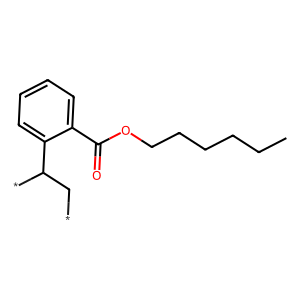

In [5]:
mol = Molecule(subset_df['SMILES'][0], input_type='smiles')
mol.visualize()

In [6]:
df = pd.read_csv(subset_path)
print(f"Loaded {len(df)} molecules.")

Loaded 7973 molecules.


In [7]:
df.head(5)

,SMILES,Tg,FFV,Tc,Density,Rg
0,*C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC...,NaN,0.386695,NaN,NaN,NaN
1,*CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1,NaN,0.335504,NaN,NaN,NaN
2,*CC(*)c1ccccc1C(=O)NC,NaN,0.355580,0.183667,NaN,NaN
3,*c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-...,NaN,0.401573,NaN,NaN,NaN
4,*CC(*)OC(=O)c1ccc(-c2ccccc2)cc1,NaN,0.353609,NaN,NaN,NaN


In [8]:
missing_values = df.isnull().sum()
total_rows = len(df)
percent_missing = (missing_values / total_rows) * 100

missing_df = pd.DataFrame({
    'Total Missing': missing_values,
    'Percent Missing': percent_missing
})

print("Missing Values by Column:")
print(missing_df)
print("\nFeature Statistics (Min, Max, Mean, etc.):")
print(df[['Tg', 'FFV', 'Tc', 'Density', 'Rg']].describe())

Missing Values by Column:
         Total Missing  Percent Missing
SMILES               0         0.000000
Tg                7462        93.590869
FFV                943        11.827418
Tc                7236        90.756303
Density           7360        92.311551
Rg                7359        92.299009

Feature Statistics (Min, Max, Mean, etc.):
               Tg          FFV          Tc     Density          Rg
count  511.000000  7030.000000  737.000000  613.000000  614.000000
mean    96.452314     0.367212    0.256334    0.985484   16.419787
std    111.228279     0.029609    0.089538    0.146189    4.608640
min   -148.029738     0.226992    0.046500    0.748691    9.728355
25%     13.674509     0.349549    0.186000    0.890243   12.540328
50%     74.040183     0.364264    0.236000    0.948193   15.052194
75%    161.147595     0.380790    0.330500    1.062096   20.411067
max    472.250000     0.777097    0.524000    1.840999   34.672906


The only property that appears will succeed with a simple imputation strategy is FFV. All other properties contain very high percent missing. Therefore, I will impute median for FFV, train a model for FFV, and train separate models for other properties. I will attempt to filter out missing values for each property. If this yields uncessful, I may explore sampling techniques or use the trained model to impute values to train a secondaery model. |

# Tg Model

In [9]:
# 1. Create a new DataFrame with only the SMILES and Tg columns
df_tg = df[['SMILES', 'Tg']].copy()

print("Initial Tg DataFrame shape:", df_tg.shape)
print("Initial Tg Missing Values:")
print(df_tg.isnull().sum())

# 2. Drop all rows where the 'Tg' value is missing
df_tg.dropna(subset=['Tg'], inplace=True)

print("\nCleaned Tg DataFrame shape:", df_tg.shape)
print("Cleaned Tg Missing Values:")
print(df_tg.isnull().sum())

Initial Tg DataFrame shape: (7973, 2)
Initial Tg Missing Values:
SMILES       0
Tg        7462
dtype: int64

Cleaned Tg DataFrame shape: (511, 2)
Cleaned Tg Missing Values:
SMILES    0
Tg        0
dtype: int64


In [10]:
from rdkit.Chem import AllChem, Descriptors, HybridizationType, SanitizeFlags
def rdkit_ogb_agree(smi: str) -> bool:
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return False
    return m.GetNumAtoms() == smiles2graph(smi)["num_nodes"]

def canonicalize_polymer_smiles(smiles: str, cap_atomic_num: int = 6) -> str:
    """
    Turn every '*' (dummy atom) into a real atom (default C) in the RDKit graph,
    preserving existing bond orders/stereo; sanitize, remove explicit Hs, and
    return canonical isomeric SMILES.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    if mol is None:
        raise ValueError(f"RDKit could not parse SMILES: {smiles}")

    rw = Chem.RWMol(mol)
    for a in rw.GetAtoms():
        if a.GetAtomicNum() == 0:   # '*'
            a.SetAtomicNum(cap_atomic_num)  # 6 = carbon
            a.SetFormalCharge(0)
            a.SetIsAromatic(False)
            a.SetNoImplicit(False)
            a.SetNumExplicitHs(0)

    mol2 = rw.GetMol()
    try:
        Chem.SanitizeMol(mol2)
    except Exception:
        Chem.SanitizeMol(mol2, sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ SanitizeFlags.SANITIZE_KEKULIZE)
        Chem.Kekulize(mol2, clearAromaticFlags=True)

    mol2 = Chem.RemoveHs(mol2)
    return Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)

In [11]:
# Build the molecule list
valid_mol_objs = []
valid_targets = []  # Now stores an array with one value per molecule

for i, row in df_tg.iterrows():
    smi = row['SMILES']
    
    # 2.a Clean the SMILES first
    cleaned_smiles = canonicalize_polymer_smiles(smi)

    try:
        # 2.b Create your custom Molecule from the cleaned string
        mol = Molecule(cleaned_smiles, input_type='smiles')
        mol.hydrogens('add')
        mol.to_xyz(optimizer='MMFF', maxIters=200)

        # 2.c Only keep molecules that got a 3-D geometry
        if mol.xyz is not None:
            valid_mol_objs.append(mol)
            
            # Keep only the 'Tg' target column as a NumPy array
            valid_targets.append(
                row[['Tg']].values
            )
        else:
            print(f"Skipped bc missing xyz: {smi}")

    except Exception as e:
        print(f"Failed on {smi} | Reason: {e}")

print(f"Kept {len(valid_mol_objs)} molecules after filtering.")

df_clean = pd.DataFrame({
    'SMILES': [m.smiles for m in valid_mol_objs],
    'Tg':     [t[0] for t in valid_targets],
})
print(f"Kept {len(df_clean)} molecules after filtering.")
df_clean.to_csv('cleaned_tg_dataset.csv', index=False)
print("Saved cleaned Tg dataset to 'cleaned_tg_dataset.csv'.")

y = np.array([t[0] for t in valid_targets])
print("Target shape:", y.shape)

# Your feature computation will now work correctly
fp_featurizer = RDKitFingerprint(
    fingerprint_type='morgan', vector='bit', n_bits=1024, radius=3
)
X_fp = fp_featurizer.represent(valid_mol_objs)

print("RDKit FP shape:", X_fp.shape)

Failed on *CC(*)(C)C(=O)OCCOC(=O)c1cc(OC(=O)c2ccc(N=Nc3ccc(OCCCCCCC)cc3)cc2)cc(OC(=O)c2ccc(N=Nc3ccc(OCCCCCCC)cc3)cc2)c1 | Reason: Bad Conformer Id
Failed on *c1ccc(-c2cc(Oc3ccc(S(=O)(=O)O[Na])cc3)c(*)cc2Oc2ccc(S(=O)(=O)O[Na])cc2)cc1 | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *C#CC(Cn1c2ccc(CCCCCCCCCCCCCCCC)cc2c2cc(CCCCCCCCCCCCCCCC)ccc21)=C(*)Cn1c2ccc(CCCCCCCCCCCCCCCC)cc2c2cc(CCCCCCCCCCCCCCCC)ccc21 | Reason: Bad Conformer Id
Failed on *C#Cc1cc(OC(COCCOCCOCCOC)COCCOCCOCCOC)c(C#Cc2cc(OCCOCCOCCOCCC(=O)O[Na])c(*)cc2OCCOCCOCCOCCC(=O)O[Na])cc1OC(COCCOCCOCCOC)COCCOCCOCCOC | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *Oc1ccc(C(c2ccc(Oc3ccc(C(=O)c4ccc(*)cc4)cc3)cc2)c2ccccc2C(=O)O[Na])cc1 | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *Nc1ccc(NC(=O)c2cc(C(*)=O)c(C(=O)O)cc2C(=O)O)cc1S(=O)(=O)O[Na] | Reason: The MMFF parameters are not available for all of the mo

In [12]:
# # 1. make separate train/test splits for both scaled and unscaled targets
# # scaled targets (MLP, KRR, GNN)
# X_train_fp_scaled, X_test_fp_scaled, y_train_scaled, y_test_scaled = train_test_split(
#     X_fp, y, test_size=0.2, random_state=42
# )
# # X_train_cm_scaled, X_test_cm_scaled, _, _ = train_test_split(
# #     X_cm, y, test_size=0.2, random_state=42
# # )

# xscaler_fp = StandardScaler()
# # xscaler_cm = StandardScaler()
# yscaler = StandardScaler()

# X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp_scaled)
# X_test_fp_scaled  = xscaler_fp.transform(X_test_fp_scaled)

# # X_train_cm_scaled = xscaler_cm.fit_transform(X_train_cm_scaled)
# # X_test_cm_scaled  = xscaler_cm.transform(X_test_cm_scaled)

# y_train_scaled = yscaler.fit_transform(y_train_scaled)
# y_test_scaled  = yscaler.transform(y_test_scaled)

# # b) unscaled targets (Random Forest)
# y_unscaled = y              
# X_train_fp_unscaled, X_test_fp_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(
#     X_fp, y_unscaled, test_size=0.2, random_state=42
# )

# # 2. show shapes
# tools.display_dataframe_to_user(
#     name="Cleaned Feature Splits",
#     dataframe=pd.DataFrame({
#         "Split": [
#             "X_train_fp_scaled", "X_test_fp_scaled",
#             # "X_train_cm_scaled", "X_test_cm_scaled",
#             "y_train_scaled",   "y_test_scaled",
#             "X_train_fp_unscaled", "X_test_fp_unscaled",
#             "y_train_unscaled",   "y_test_unscaled"
#         ],
#         "Shape": [
#             X_train_fp_scaled.shape, X_test_fp_scaled.shape,
#             # X_train_cm_scaled.shape, X_test_cm_scaled.shape,
#             y_train_scaled.shape,   y_test_scaled.shape,
#             X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
#             y_train_unscaled.shape,   y_test_unscaled.shape
#         ]
#     })
# )

# 1. make separate train/test splits for both scaled and unscaled targets
# a) Scaled targets (for KRR)
# Your y is now a 1D array of FFV values.
X_train_fp, X_test_fp, y_train, y_test = train_test_split(
    X_fp, y, test_size=0.2, random_state=42
)

xscaler_fp = StandardScaler()
yscaler = StandardScaler()

X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp)
X_test_fp_scaled = xscaler_fp.transform(X_test_fp)

# Reshape y arrays for the StandardScaler
y_train_scaled = yscaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = yscaler.transform(y_test.reshape(-1, 1))

# b) Unscaled targets (for models that don't need scaling, like Random Forest)
# These are the original, unscaled splits. You can use the variables you already created.
X_train_fp_unscaled = X_train_fp
X_test_fp_unscaled = X_test_fp
y_train_unscaled = y_train
y_test_unscaled = y_test

# 2. show shapes
# The shape display now reflects the single target variable
tools.display_dataframe_to_user(
    name="Cleaned Feature Splits",
    dataframe=pd.DataFrame({
        "Split": [
            "X_train_fp_scaled", "X_test_fp_scaled",
            "y_train_scaled", "y_test_scaled",
            "X_train_fp_unscaled", "X_test_fp_unscaled",
            "y_train_unscaled", "y_test_unscaled"
        ],
        "Shape": [
            X_train_fp_scaled.shape, X_test_fp_scaled.shape,
            y_train_scaled.shape, y_test_scaled.shape,
            X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
            y_train_unscaled.shape, y_test_unscaled.shape
        ]
    })
)

Cleaned Feature Splits


## Kernel Ridge Regression baseline first

In [13]:
# Kernel Ridge on RDKit fingerprints
krr = KernelRidge(kernel='rbf', alpha=1.0)
krr.fit(X_train_fp_scaled, y_train_scaled)

# predict on scaled test set
y_pred_krr_scaled = krr.predict(X_test_fp_scaled)

# Inverse transform predictions and test targets to compare with unscaled values
# You must reshape y_pred_krr_scaled and y_test_scaled to 2D before inverse transforming
y_pred_krr = yscaler.inverse_transform(y_pred_krr_scaled.reshape(-1, 1)).flatten()
y_test_krr = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("Kernel Ridge (RDKit FP)")
metrics_krr = regression_metrics(y_test_krr, y_pred_krr)
print(metrics_krr[['MAE', 'RMSE', 'r_squared']])

Kernel Ridge (RDKit FP)
         MAE       RMSE  r_squared
0  63.695431  85.338681   0.415116


## Random Forest Regression baseline 

In [14]:
# Random Forest (RDKit FP) 
rfr = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
rfr.fit(X_train_fp_unscaled, y_train_unscaled)
# predict
y_pred_rfr = rfr.predict(X_test_fp_unscaled)
# eval
print("Random Forest (RDKit FP)")
metrics_rfr = regression_metrics(y_test_unscaled, y_pred_rfr)
print(metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Random Forest (RDKit FP)
         MAE       RMSE  r_squared
0  54.404863  73.313325   0.568338


## Multi-Layer Perceptron with Morgan Fingerprints baseline 

In [15]:
# MLP (Fingerprint)
mlp_fp = MLP(
    engine='tensorflow',
    nfeatures=X_train_fp_scaled.shape[1],
    nneurons=[64, 128], # These are the hidden layers
    activations=['ReLU', 'ReLU'],
    learning_rate=0.01,
    alpha=0.001,
    nepochs=200,
    batch_size=64,
    loss='mean_squared_error',
    is_regression=True
)

mlp_fp.fit(X=X_train_fp_scaled, y=y_train_scaled.ravel()) # Use .ravel() to convert to 1D
y_pred_fp_scaled = mlp_fp.predict(X_test_fp_scaled)
# Reshape the output from predict() to 2D before inverse transforming
y_pred_fp = yscaler.inverse_transform(y_pred_fp_scaled.reshape(-1, 1)).flatten()
y_test_fp = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("MLP (RDKit FP)")
metrics_mlp = regression_metrics(y_test, y_pred_fp)
print(metrics_mlp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
7/7 [==============================] - 0s 2ms/step - loss: 1.6521
Epoch 2/200
7/7 [==============================] - 0s 2ms/step - loss: 0.8103
Epoch 3/200
7/7 [==============================] - 0s 1ms/step - loss: 0.5092
Epoch 4/200
7/7 [==============================] - 0s 1ms/step - loss: 0.3847
Epoch 5/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3149
Epoch 6/200
7/7 [==============================] - 0s 1ms/step - loss: 0.2796
Epoch 7/200
7/7 [==============================] - 0s 1ms/step - loss: 0.2548
Epoch 8/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2333
Epoch 9/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2206
Epoch 10/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2144
Epoch 11/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2100
Epoch 12/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2060
Epoch 13/200
7/7 [==============================] - 0s 2ms/st

## Multi-Layer Perceptron with Coulomb Matrix representation baseline 

In [16]:
# # MLP (Coulomb matrix)
# mlp_cm = MLP(
#     engine='tensorflow', 
#     nfeatures=X_train_cm_scaled.shape[1], 
#     nneurons=[64, 128], 
#     activations=['ReLU', 'ReLU'],
#     learning_rate=0.0001, 
#     alpha=0.001, 
#     nepochs=100, 
#     batch_size=64, 
#     loss='mean_squared_error', 
#     is_regression=True
#     )

# mlp_cm.fit(X=X_train_cm_scaled, y=y_train_scaled)
# y_pred_cm_scaled = mlp_cm.predict(X_test_cm_scaled)
# y_pred_cm = yscaler.inverse_transform(y_pred_cm_scaled)
# y_test_cm = yscaler.inverse_transform(y_test_scaled)

In [17]:
# eval
results = {"Kernel Ridge (RDKit FP)": regression_metrics(y_test_krr, y_pred_krr),
           "Random Forest (RDKit FP)": regression_metrics(y_test_unscaled, y_pred_rfr),
           "MLP (RDKit FP)": regression_metrics(y_test_fp, y_pred_fp),
        #    "MLP (Coulomb Matrix)": regression_metrics(y_test_cm, y_pred_cm)
        }

# display
print("Final Model Comparison")
for name, metrics_df in results.items():
    print(f"\n{name}")
    print(metrics_df[['MAE', 'RMSE', 'r_squared']])

Final Model Comparison

Kernel Ridge (RDKit FP)
         MAE       RMSE  r_squared
0  63.695431  85.338681   0.415116

Random Forest (RDKit FP)
         MAE       RMSE  r_squared
0  54.404863  73.313325   0.568338

MLP (RDKit FP)
         MAE      RMSE  r_squared
0  54.047308  71.89681   0.584857


## Parity Plots and Residuals Histograms

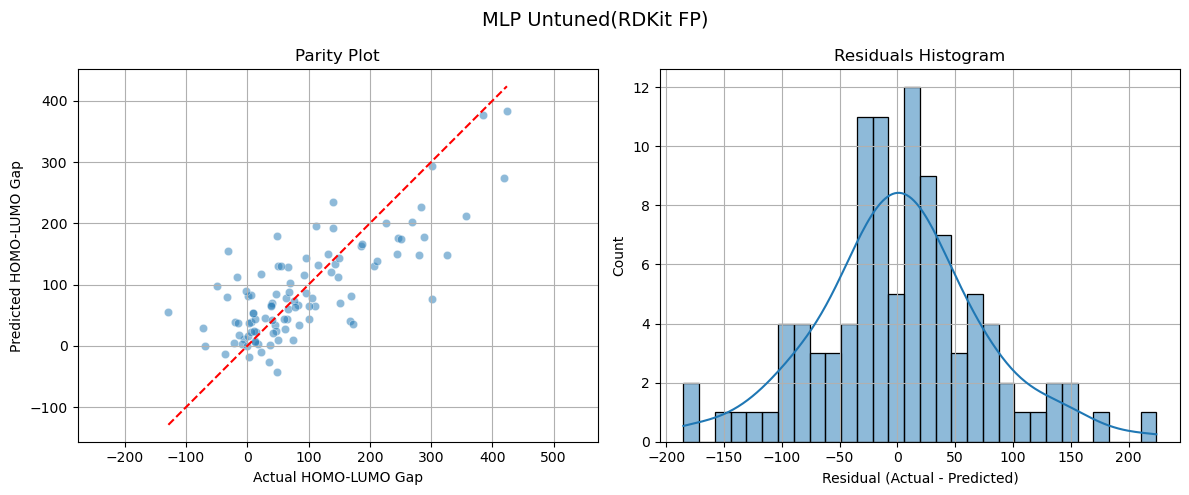

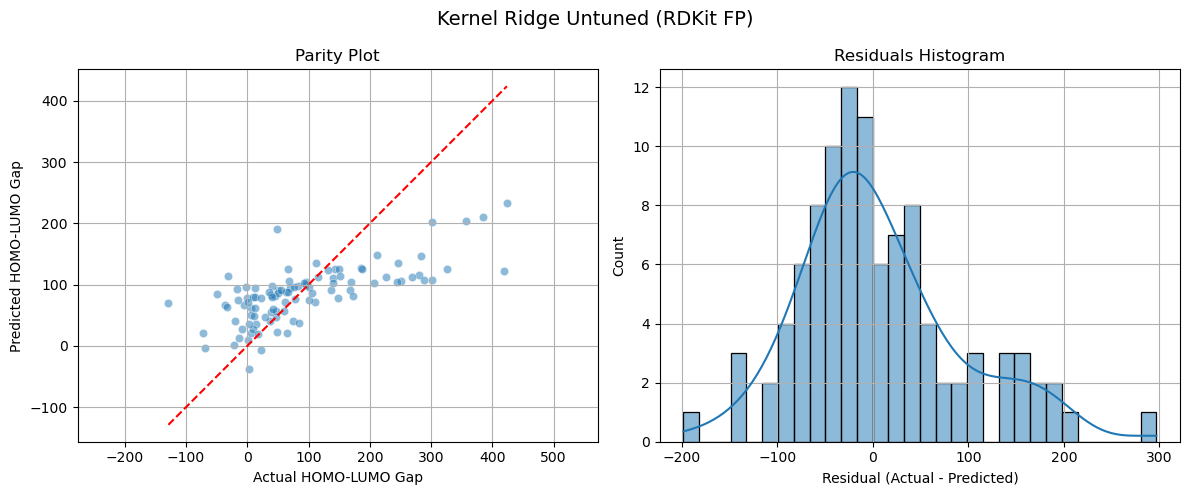

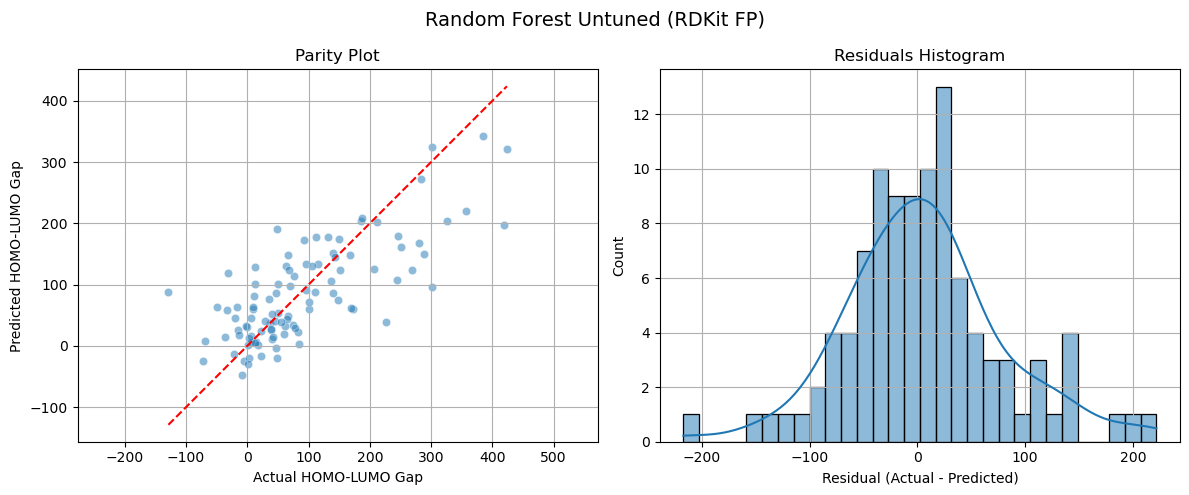

In [18]:
def plot_regression_results(y_true, y_pred, title="Model Evaluation", save_dir="plots"):
    residuals = y_true.flatten() - y_pred.flatten()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # parity plot
    sns.scatterplot(ax=axes[0], x=y_true.flatten(), y=y_pred.flatten(), alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], '--r')
    axes[0].set_xlabel("Actual HOMO-LUMO Gap")
    axes[0].set_ylabel("Predicted HOMO-LUMO Gap")
    axes[0].set_title("Parity Plot")
    axes[0].grid(True)
    axes[0].axis('equal')

    # residuals histogram
    sns.histplot(ax=axes[1], data=residuals, bins=30, kde=True)
    axes[1].set_title("Residuals Histogram")
    axes[1].set_xlabel("Residual (Actual - Predicted)")
    axes[1].grid(True)

    # overall title
    fig.suptitle(title, fontsize=14)

    # save fig as pdf for best overleaf upload format 
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"{title.lower().replace(' ', '_')}_plots.pdf")
    fig.savefig(filename, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

plot_regression_results(y_test_fp, y_pred_fp, title="MLP Untuned(RDKit FP)")
# plot_regression_results(y_test_cm, y_pred_cm, title="MLP Untuned (Coulomb Matrix)")
plot_regression_results(y_test_krr, y_pred_krr, title="Kernel Ridge Untuned (RDKit FP)")
plot_regression_results(y_test_unscaled, y_pred_rfr, title="Random Forest Untuned (RDKit FP)")

## Tune hyperparameters for baseline models with Optuna 

In [29]:
def objective_krr(trial):
    alpha = trial.suggest_float('alpha', 0.01, 1.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True) if kernel == 'rbf' else None
    model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma) if gamma else KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_krr = optuna.create_study(direction='minimize')
study_krr.optimize(objective_krr, n_trials=100)

[I 2025-09-04 18:07:31,274] A new study created in memory with name: no-name-2c5544dd-a13f-4e25-84e0-408d9fef1e39
[I 2025-09-04 18:07:31,289] Trial 0 finished with value: 52.47805602991537 and parameters: {'alpha': 0.06586033910839106, 'kernel': 'poly'}. Best is trial 0 with value: 52.47805602991537.
[I 2025-09-04 18:07:31,303] Trial 1 finished with value: 55.412910810865775 and parameters: {'alpha': 0.01189927541556288, 'kernel': 'rbf', 'gamma': 0.0001648963316314988}. Best is trial 0 with value: 52.47805602991537.
[I 2025-09-04 18:07:31,316] Trial 2 finished with value: 52.14000842310857 and parameters: {'alpha': 0.26346624549357756, 'kernel': 'poly'}. Best is trial 2 with value: 52.14000842310857.
[I 2025-09-04 18:07:31,328] Trial 3 finished with value: 52.09947380024483 and parameters: {'alpha': 0.7923779405719946, 'kernel': 'poly'}. Best is trial 3 with value: 52.09947380024483.
[I 2025-09-04 18:07:31,340] Trial 4 finished with value: 52.32335741706265 and parameters: {'alpha': 0.

In [30]:
def objective_rfr(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 10, 100, step=10)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
    model.fit(X_train_fp_unscaled, y_train_unscaled)
    preds = model.predict(X_test_fp_unscaled)
    metrics = regression_metrics(y_test_unscaled, preds)
    return metrics['MAE'][0]

study_rfr = optuna.create_study(direction='minimize')
study_rfr.optimize(objective_rfr, n_trials=100)

[I 2025-09-04 18:07:36,340] A new study created in memory with name: no-name-571e3f03-3bb2-49d7-9e5b-88944aa83273
[I 2025-09-04 18:07:36,695] Trial 0 finished with value: 54.611500266146024 and parameters: {'n_estimators': 100, 'max_depth': 60}. Best is trial 0 with value: 54.611500266146024.
[I 2025-09-04 18:07:37,127] Trial 1 finished with value: 53.24178721398811 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 1 with value: 53.24178721398811.
[I 2025-09-04 18:07:37,730] Trial 2 finished with value: 52.84979616026849 and parameters: {'n_estimators': 300, 'max_depth': 10}. Best is trial 2 with value: 52.84979616026849.
[I 2025-09-04 18:07:38,343] Trial 3 finished with value: 54.05674128710554 and parameters: {'n_estimators': 200, 'max_depth': 40}. Best is trial 2 with value: 52.84979616026849.
[I 2025-09-04 18:07:38,560] Trial 4 finished with value: 54.704354298388026 and parameters: {'n_estimators': 50, 'max_depth': 80}. Best is trial 2 with value: 52.8497961602

In [32]:
def objective_mlp_fp(trial):
    lr = trial.suggest_float('lr', 1e-4, 2e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-4, 5e-2, log=True)
    act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
    n1 = trial.suggest_int('n1', 128, 384, step=64)
    n2 = trial.suggest_int('n2', 128, 384, step=64)

    model = MLP(engine='tensorflow', nfeatures=X_train_fp_scaled.shape[1], nneurons=[n1, n2],
                activations=[act, act], learning_rate=lr, alpha=alpha,
                nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)
    
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_mlp_fp = optuna.create_study(direction='minimize')
study_mlp_fp.optimize(objective_mlp_fp, n_trials=100)

[I 2025-09-04 20:07:24,914] A new study created in memory with name: no-name-4ab51d06-e6c2-4787-94b5-1e523db9ae9a


Epoch 1/100
7/7 [==============================] - 0s 3ms/step - loss: 13.0463
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 12.5493
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.0623
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7880
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 11.6493
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.5376
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 11.4500
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 11.3826
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3276
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 11.2778
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 11.2318
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1888
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:07:32,502] Trial 0 finished with value: 65.97623144240474 and parameters: {'lr': 0.0006131707246017513, 'alpha': 0.014757403572832895, 'activation': 'relu', 'n1': 320, 'n2': 256}. Best is trial 0 with value: 65.97623144240474.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.0463
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2119
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9368
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7513
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6307
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5531
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 0.5196
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4819
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4692
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4585
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4498
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4446
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:34,264] Trial 1 finished with value: 61.46685337652091 and parameters: {'lr': 0.007037316607790657, 'alpha': 0.0009259457413312761, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 1 with value: 61.46685337652091.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4335
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8620
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5381
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3505
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2835
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2151
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1895
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1468
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1299
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1167
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1062
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0995
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:36,083] Trial 2 finished with value: 59.99714808365374 and parameters: {'lr': 0.007103555042896184, 'alpha': 0.001803930832367276, 'activation': 'gelu', 'n1': 256, 'n2': 192}. Best is trial 2 with value: 59.99714808365374.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.1853
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1944
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0524
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9098
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 0.8578
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8153
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7964
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7762
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 0.7648
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7566
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7523
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7489
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:07:37,651] Trial 3 finished with value: 59.55488712192801 and parameters: {'lr': 0.004657392505497789, 'alpha': 0.0021561184888452835, 'activation': 'relu', 'n1': 128, 'n2': 128}. Best is trial 3 with value: 59.55488712192801.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8280
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1476
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9408
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8615
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8108
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7829
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7879
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7556
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7404
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7325
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7278
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7225
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:39,472] Trial 4 finished with value: 59.83959769023511 and parameters: {'lr': 0.005391205538210505, 'alpha': 0.001257192903748666, 'activation': 'gelu', 'n1': 192, 'n2': 384}. Best is trial 3 with value: 59.55488712192801.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3738
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3670
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3664
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3614
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3317
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3240
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3112
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3013
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2926
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2734
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2624
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2540
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:07:41,049] Trial 5 finished with value: 57.95134360880324 and parameters: {'lr': 0.0010252295697744435, 'alpha': 0.000894687368799269, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 5 with value: 57.95134360880324.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 17.7150
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 17.6512
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 17.5593
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 17.4668
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 17.3681
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 17.2775
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 17.1930
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 17.1197
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 17.0473
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 16.9818
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 16.9202
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 16.8640
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:07:42,714] Trial 6 finished with value: 72.7612765917017 and parameters: {'lr': 0.00011936108934714092, 'alpha': 0.04139892684630957, 'activation': 'relu', 'n1': 128, 'n2': 256}. Best is trial 5 with value: 57.95134360880324.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2594
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 20.9850
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 20.7148
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 20.5996
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 20.4031
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 20.2582
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 20.0912
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 19.9319
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 19.7817
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 19.6202
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 19.4729
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 19.3153
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:07:44,394] Trial 7 finished with value: 57.49475406130353 and parameters: {'lr': 0.0007068994556534392, 'alpha': 0.03869731508263629, 'activation': 'sigmoid', 'n1': 192, 'n2': 192}. Best is trial 7 with value: 57.49475406130353.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2655
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 4.1104
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 3.9899
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 3.8382
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 3.7176
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 3.6132
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5277
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4574
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4002
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3516
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3067
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 3.2706
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:45,990] Trial 8 finished with value: 78.30218485723917 and parameters: {'lr': 0.00012402581332656212, 'alpha': 0.003015430821816265, 'activation': 'relu', 'n1': 384, 'n2': 384}. Best is trial 7 with value: 57.49475406130353.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 9.2297
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 9.0752
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 8.8669
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 8.6755
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5013
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 8.3621
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 8.2509
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 8.1622
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0873
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0249
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 7.9719
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 7.9249
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:07:47,652] Trial 9 finished with value: 83.68321030912738 and parameters: {'lr': 0.00014305628101450837, 'alpha': 0.013006000625615206, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 7 with value: 57.49475406130353.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1573
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1453
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1421
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1357
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1233
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1150
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1061
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1006
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0935
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0831
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0795
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0682
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:49,264] Trial 10 finished with value: 57.97517346034134 and parameters: {'lr': 0.00036853845956751074, 'alpha': 0.00015476639458539238, 'activation': 'sigmoid', 'n1': 320, 'n2': 320}. Best is trial 7 with value: 57.49475406130353.


Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 1.3986
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2354
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1900
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1557
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0989
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0824
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0562
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0351
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0155
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9839
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9570
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 0.9367
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:07:50,859] Trial 11 finished with value: 57.14954265060914 and parameters: {'lr': 0.001519422226672702, 'alpha': 0.00034349596510678093, 'activation': 'sigmoid', 'n1': 192, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3800
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6918
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5007
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3052
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2524
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1969
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1562
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1365
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1178
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1070
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0975
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0906
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:52,487] Trial 12 finished with value: 70.68801466047385 and parameters: {'lr': 0.0016197931101672725, 'alpha': 0.00012750602782036794, 'activation': 'tanh', 'n1': 192, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1879
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1610
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1446
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1327
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0977
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 1.0490
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 1.0140
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9793
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 0.9600
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9283
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8867
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8583
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:54,123] Trial 13 finished with value: 61.0425012665679 and parameters: {'lr': 0.002137765007936263, 'alpha': 0.00028448720470978487, 'activation': 'sigmoid', 'n1': 192, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1571
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 4.7166
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2476
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 3.9758
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 3.7779
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5826
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4175
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 3.2727
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 3.1898
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 3.0606
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9383
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8365
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:55,778] Trial 14 finished with value: 63.52409774657985 and parameters: {'lr': 0.019547295308692616, 'alpha': 0.00597785411675189, 'activation': 'sigmoid', 'n1': 256, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8739
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4172
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3025
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2784
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2100
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1982
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1830
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1791
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1679
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1612
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1567
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1495
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:07:57,330] Trial 15 finished with value: 58.562715955041384 and parameters: {'lr': 0.00035676340184542766, 'alpha': 0.0003903578866662198, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 37.3357
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 35.7575
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 34.4924
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 33.3279
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 32.0825
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 30.9001
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 29.7407
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 28.6266
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 27.5528
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 26.5195
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 25.5254
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 24.5685
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:07:58,960] Trial 16 finished with value: 65.87201327033065 and parameters: {'lr': 0.002699479695264986, 'alpha': 0.04927873066015183, 'activation': 'tanh', 'n1': 320, 'n2': 192}. Best is trial 11 with value: 57.14954265060914.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2194
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2184
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2144
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2083
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1662
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1577
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1518
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1463
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1381
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1191
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1112
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1075
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:00,497] Trial 17 finished with value: 54.887397256505984 and parameters: {'lr': 0.0008268674952260534, 'alpha': 0.0004886784355305433, 'activation': 'sigmoid', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3388
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2017
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2134
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1775
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1779
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1659
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1627
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1599
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1569
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1519
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1499
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1447
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:02,146] Trial 18 finished with value: 67.32759250313498 and parameters: {'lr': 0.0003127506277317366, 'alpha': 0.0004365005994739172, 'activation': 'sigmoid', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2263
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2193
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2167
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 1.2134
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1880
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1817
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1694
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1597
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1534
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1338
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1243
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1167
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:03,805] Trial 19 finished with value: 57.10359805375634 and parameters: {'lr': 0.0008688529977470843, 'alpha': 0.000620431612666866, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 1s 2ms/step - loss: 1.7689
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1850
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8495
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7121
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6139
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5447
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4978
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4623
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4338
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4118
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3914
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3746
Epoch 13/100
7/7 [==============================] - 0s 3ms/st

[I 2025-09-04 20:08:06,036] Trial 20 finished with value: 73.66704382072314 and parameters: {'lr': 0.0008042694329300243, 'alpha': 0.0005797064995685693, 'activation': 'tanh', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1884
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1026
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0988
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0897
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0430
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0291
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0180
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0056
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9991
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9743
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 0.9463
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 0.9314
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:07,773] Trial 21 finished with value: 58.82215589005639 and parameters: {'lr': 0.001293822559519647, 'alpha': 0.00024436757942165546, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3108
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3166
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2347
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2158
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2174
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1865
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1839
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0888
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0550
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0148
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9777
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9462
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:09,500] Trial 22 finished with value: 64.36580875396851 and parameters: {'lr': 0.0027744557006031084, 'alpha': 0.0005827368166316126, 'activation': 'sigmoid', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1227
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1163
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1142
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1092
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0922
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0885
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0737
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0690
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0630
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0481
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0467
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0334
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:11,192] Trial 23 finished with value: 57.49350968555152 and parameters: {'lr': 0.0005666118553888679, 'alpha': 0.0001988065057044844, 'activation': 'sigmoid', 'n1': 192, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3773
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3157
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3248
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3085
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3075
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3054
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3003
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2988
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2953
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2923
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2891
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2846
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:12,843] Trial 24 finished with value: 74.36739544316448 and parameters: {'lr': 0.00025402258047026735, 'alpha': 0.0007753327889135206, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2495
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2632
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1705
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1598
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1449
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1124
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0825
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0557
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0465
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0257
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9973
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9867
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:14,554] Trial 25 finished with value: 56.17399134753914 and parameters: {'lr': 0.0014832161187332013, 'alpha': 0.0003380614603970123, 'activation': 'sigmoid', 'n1': 192, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0639
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0594
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0600
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0590
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0424
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 1.0436
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0326
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0283
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0291
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0154
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0145
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 1.0106
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:16,155] Trial 26 finished with value: 59.40491410688315 and parameters: {'lr': 0.0005225852011665604, 'alpha': 0.00010234367597197874, 'activation': 'sigmoid', 'n1': 128, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 3.1172
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8391
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8782
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8105
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 2.8106
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7910
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7895
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7833
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7771
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7728
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7697
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7649
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:17,827] Trial 27 finished with value: 71.64389253822792 and parameters: {'lr': 0.00021514221254018622, 'alpha': 0.0031128939043399, 'activation': 'sigmoid', 'n1': 192, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4629
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9092
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6181
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4800
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3813
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3246
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2872
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2563
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2338
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2171
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2028
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1915
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:19,511] Trial 28 finished with value: 75.46315048873812 and parameters: {'lr': 0.0009504018362641837, 'alpha': 0.00018772816978607088, 'activation': 'tanh', 'n1': 256, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.7843
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4013
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 2.0503
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8431
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.7014
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.6210
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5649
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5178
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4877
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4598
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4382
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4192
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:21,285] Trial 29 finished with value: 75.71937928748969 and parameters: {'lr': 0.0005303842432961027, 'alpha': 0.0013844633386373548, 'activation': 'gelu', 'n1': 384, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3925
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3866
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3192
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2998
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3019
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2609
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2246
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1668
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1574
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1118
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1015
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0686
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:22,790] Trial 30 finished with value: 58.70081934525798 and parameters: {'lr': 0.0023123022936027016, 'alpha': 0.000586292422524495, 'activation': 'sigmoid', 'n1': 128, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4406
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2482
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2420
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2164
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1433
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1048
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0885
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0609
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0454
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0189
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9778
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9526
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:24,422] Trial 31 finished with value: 56.794680817555815 and parameters: {'lr': 0.0014571610387418346, 'alpha': 0.0003171968403787017, 'activation': 'sigmoid', 'n1': 256, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2442
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1869
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1735
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1582
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1157
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1004
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0806
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0644
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0472
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0173
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9942
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9784
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:25,988] Trial 32 finished with value: 58.5561709359424 and parameters: {'lr': 0.001095587620589835, 'alpha': 0.00026712732781587935, 'activation': 'sigmoid', 'n1': 256, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5063
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3945
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3300
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 1.2198
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1490
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0795
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0829
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9526
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8738
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8330
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7997
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7218
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:27,679] Trial 33 finished with value: 62.33236491380777 and parameters: {'lr': 0.0034300013336170374, 'alpha': 0.0004402987574185776, 'activation': 'sigmoid', 'n1': 256, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4266
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.6878
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4347
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3238
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2447
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1838
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1467
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1168
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1036
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0935
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0868
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0811
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:29,496] Trial 34 finished with value: 65.05443481641218 and parameters: {'lr': 0.001715196401300293, 'alpha': 0.0013219123216076413, 'activation': 'gelu', 'n1': 320, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5447
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.6048
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5959
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4039
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3133
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2508
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2523
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1808
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1575
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0340
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9694
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8834
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:31,102] Trial 35 finished with value: 64.18843170252426 and parameters: {'lr': 0.003637777667057363, 'alpha': 0.0007445754898470012, 'activation': 'sigmoid', 'n1': 192, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.6763
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.8767
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.3659
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2203
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1269
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0628
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0219
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.9953
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9736
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9600
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9483
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9394
Epoch 13/100
7/7 [==============================] - 0s 3ms/st

[I 2025-09-04 20:08:32,954] Trial 36 finished with value: 76.06853375116097 and parameters: {'lr': 0.000781099390239808, 'alpha': 0.0011604181674921877, 'activation': 'gelu', 'n1': 320, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.7803
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4847
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2502
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 1.1572
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1039
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0207
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 1.0013
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9800
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9742
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9433
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9062
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8878
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:34,555] Trial 37 finished with value: 58.24711478208619 and parameters: {'lr': 0.0012659580917846744, 'alpha': 0.00019105348920217408, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.5300
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5876
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3921
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3307
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3053
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2785
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2508
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2260
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2198
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2131
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2071
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2065
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:36,234] Trial 38 finished with value: 59.783804825071115 and parameters: {'lr': 0.008061907712918122, 'alpha': 0.0003608613311849593, 'activation': 'relu', 'n1': 192, 'n2': 320}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9989
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9940
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9925
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9871
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9691
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9663
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9510
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9440
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9417
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9242
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9209
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 2.9131
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:37,843] Trial 39 finished with value: 55.55557160710136 and parameters: {'lr': 0.0004500254115521539, 'alpha': 0.0027582362290749732, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1542
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6544
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 4.1112
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 3.8658
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 3.7405
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 3.6371
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 3.5616
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5115
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 3.4783
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 3.4426
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4151
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3944
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:39,458] Trial 40 finished with value: 78.5477734197659 and parameters: {'lr': 0.000442128886129882, 'alpha': 0.004572804169783657, 'activation': 'relu', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5943
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 2.5951
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5846
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5808
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5555
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5252
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 2.5149
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4990
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4951
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4708
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 2.4431
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 2.4281
Epoch 13/100
7/7 [==============================] - 0s 1ms/st

[I 2025-09-04 20:08:41,003] Trial 41 finished with value: 57.85965679787283 and parameters: {'lr': 0.000924801486507968, 'alpha': 0.0022087628583511336, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 6.9288
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 6.9218
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8928
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8753
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8195
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7913
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7761
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7600
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7419
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7101
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 6.6857
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 6.6706
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:42,655] Trial 42 finished with value: 56.009657313499055 and parameters: {'lr': 0.000698821200582735, 'alpha': 0.008196610165303004, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6672
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6602
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6441
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6243
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5610
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5345
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5095
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4853
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4594
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4258
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4014
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 8.3815
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:44,296] Trial 43 finished with value: 55.42133869615102 and parameters: {'lr': 0.0006530219627934531, 'alpha': 0.010667358653405856, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8646
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8464
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8431
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8321
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8243
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8161
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8065
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7989
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7902
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7808
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7726
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7624
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:45,876] Trial 44 finished with value: 74.18297710794084 and parameters: {'lr': 0.0001801887393834703, 'alpha': 0.012333680001063628, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 17 with value: 54.887397256505984.


Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 19.9119
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 19.8497
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 19.7820
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 19.7075
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 19.6122
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 19.5295
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 19.4401
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 19.3555
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 19.2736
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 19.1790
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 19.0918
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 19.0112
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:08:47,462] Trial 45 finished with value: 54.434319211628384 and parameters: {'lr': 0.000648662551024776, 'alpha': 0.02260346133324402, 'activation': 'sigmoid', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3387
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 21.8465
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 21.4531
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2060
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 21.0383
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 20.8949
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 20.7618
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 20.6426
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 20.5361
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 20.4308
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 20.3320
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 20.2363
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:08:49,265] Trial 46 finished with value: 69.39861457218095 and parameters: {'lr': 0.0006674482071770976, 'alpha': 0.022344366281202434, 'activation': 'gelu', 'n1': 384, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 8.7258
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4953
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1855
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1632
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1495
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1068
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0929
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0763
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0583
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0388
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 8.0265
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0091
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:50,839] Trial 47 finished with value: 57.86262325052492 and parameters: {'lr': 0.00042339336152147746, 'alpha': 0.008543526188068818, 'activation': 'sigmoid', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 23.6998
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 23.4304
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1473
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 22.9178
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 22.7111
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 22.5653
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 22.4352
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3336
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.2422
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 22.1612
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0852
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0151
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:08:52,462] Trial 48 finished with value: 76.45138356723437 and parameters: {'lr': 0.0002693783264055018, 'alpha': 0.02658771263919912, 'activation': 'relu', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 16.7953
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3826
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 16.0338
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 15.8243
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6738
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 15.5535
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 15.4559
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3734
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3054
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 15.2410
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 15.1819
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 15.1270
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:08:54,029] Trial 49 finished with value: 79.13577456217612 and parameters: {'lr': 0.0004616504188371658, 'alpha': 0.018294769482185606, 'activation': 'tanh', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 9.9157
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8939
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8720
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8502
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 9.8136
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7884
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7569
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7299
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7066
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6699
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6453
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6214
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:55,671] Trial 50 finished with value: 56.475750969483066 and parameters: {'lr': 0.0006453727281820407, 'alpha': 0.009790137385693147, 'activation': 'sigmoid', 'n1': 384, 'n2': 320}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4690
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3381
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0930
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0201
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0244
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9868
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9400
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9155
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8965
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8730
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8403
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8211
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:57,236] Trial 51 finished with value: 55.88046729443471 and parameters: {'lr': 0.0010990602884344404, 'alpha': 0.005651126370097854, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5178
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4785
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4338
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3938
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3172
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2957
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2816
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2678
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2496
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2254
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2100
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2015
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:08:58,918] Trial 52 finished with value: 57.723269285538926 and parameters: {'lr': 0.0006604875383176219, 'alpha': 0.006040681144711947, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5580
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5606
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 3.5344
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5249
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5081
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4702
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4437
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4204
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 3.4113
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3955
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3615
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 3.3462
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:09:00,509] Trial 53 finished with value: 60.72872794413582 and parameters: {'lr': 0.001117578516471097, 'alpha': 0.003561639301935277, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1988
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7092
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3117
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3195
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 6.2243
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1622
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1497
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1359
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1169
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0996
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0932
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0749
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:09:02,338] Trial 54 finished with value: 59.69757891514321 and parameters: {'lr': 0.0003889726320747716, 'alpha': 0.0072501034517637765, 'activation': 'sigmoid', 'n1': 256, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1943
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8422
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6778
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6902
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6086
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 4.6265
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5958
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5915
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 4.5875
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5745
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5717
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5596
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:09:03,959] Trial 55 finished with value: 60.41195850551317 and parameters: {'lr': 0.0003051940280185812, 'alpha': 0.004336887877957567, 'activation': 'sigmoid', 'n1': 320, 'n2': 384}. Best is trial 45 with value: 54.434319211628384.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 23.7395
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 23.5572
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1991
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 22.8287
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 22.4537
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0319
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 21.6169
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2083
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 20.8271
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 20.4383
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 20.0526
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 19.6961
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:05,534] Trial 56 finished with value: 52.81048543606694 and parameters: {'lr': 0.00194612835157685, 'alpha': 0.03280636474326703, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 25.5355
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 25.2679
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 24.7919
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 24.4116
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 23.9927
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 23.5828
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1784
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.7700
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3899
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0046
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 21.6104
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2492
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:07,270] Trial 57 finished with value: 55.33884713276276 and parameters: {'lr': 0.0017224473897670786, 'alpha': 0.035158247086843245, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 26.0702
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 25.7136
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 25.4195
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0374
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 24.6779
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 24.2724
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 23.8658
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 23.4719
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1093
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 22.7363
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3624
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 22.0171
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:08,900] Trial 58 finished with value: 56.920772943434145 and parameters: {'lr': 0.001785481306795398, 'alpha': 0.03079649038272542, 'activation': 'sigmoid', 'n1': 320, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 29.5054
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 27.8108
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 26.3308
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 24.7305
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 23.1206
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 21.5899
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 20.1644
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 18.8073
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 17.5496
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3704
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 15.2707
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 14.2460
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:10,469] Trial 59 finished with value: 62.95734778948861 and parameters: {'lr': 0.00578184151227972, 'alpha': 0.04098935941014275, 'activation': 'tanh', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6384
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 15.5813
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3928
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 15.2103
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 15.0376
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 14.8439
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 14.6762
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 14.4114
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 14.2090
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 14.0161
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 13.8349
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6436
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:12,140] Trial 60 finished with value: 56.696271028300565 and parameters: {'lr': 0.002461490694915656, 'alpha': 0.016151784191946968, 'activation': 'sigmoid', 'n1': 384, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 25.2478
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0172
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 24.6292
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 24.2039
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 23.7728
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 23.3084
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 22.8436
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3769
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 21.9510
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 21.5081
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 21.0783
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 20.6730
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:13,780] Trial 61 finished with value: 55.08044581208695 and parameters: {'lr': 0.001958106556908009, 'alpha': 0.034984303463819054, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 24.1616
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 23.8200
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 23.3166
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 22.5923
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 21.9211
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2497
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 20.6290
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 19.9602
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 19.3305
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 18.7055
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 18.1374
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 17.5334
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:15,332] Trial 62 finished with value: 56.70197451274833 and parameters: {'lr': 0.0032422305194448643, 'alpha': 0.033385227441928095, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 35.5160
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 34.3798
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 33.6214
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 32.6235
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 31.7705
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 30.9054
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 30.0474
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 29.1749
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 28.3661
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 27.5506
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 26.7811
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 26.0299
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:17,022] Trial 63 finished with value: 54.66146450273181 and parameters: {'lr': 0.0020581756490388532, 'alpha': 0.048516082802718796, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 34.6021
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 34.1687
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 33.4120
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 32.6096
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 31.7844
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 30.9139
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 30.0611
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 29.2258
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 28.4434
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 27.6504
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 26.8943
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 26.1686
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:18,657] Trial 64 finished with value: 54.59184485389007 and parameters: {'lr': 0.0020123123607267567, 'alpha': 0.048452573091974704, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 27.5493
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 26.5576
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 26.0548
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 25.3595
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 24.7560
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 24.1291
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 23.4954
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.8784
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3208
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 21.7350
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 21.1715
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 20.6448
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:20,374] Trial 65 finished with value: 54.29691622536134 and parameters: {'lr': 0.001974353041603855, 'alpha': 0.045875023609623755, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 26.6103
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 25.7891
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 25.2425
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 24.5463
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 23.9425
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 23.3232
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 22.7147
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.0731
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 21.4991
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 20.9076
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 20.3549
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 19.8116
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:22,067] Trial 66 finished with value: 54.65766232421647 and parameters: {'lr': 0.00214220020753589, 'alpha': 0.04442101481643664, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 27.5023
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 26.9981
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 26.3848
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 25.7039
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0389
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 24.3509
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 23.6681
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 22.9667
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3211
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 21.6706
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 21.0593
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 20.4583
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:23,734] Trial 67 finished with value: 54.38580421337003 and parameters: {'lr': 0.0021726256722235855, 'alpha': 0.04672479114420974, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 28.3087
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 27.8229
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 27.2061
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 26.5029
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 25.8105
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0884
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 24.3734
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 23.6497
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 22.9900
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 22.3084
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 21.6713
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 21.0465
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:25,411] Trial 68 finished with value: 53.91736794297466 and parameters: {'lr': 0.0021248397770244963, 'alpha': 0.048452239153924805, 'activation': 'sigmoid', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.9031
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 14.8734
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 14.0875
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6943
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 13.3314
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 13.0074
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7043
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 12.4272
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 12.1568
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 11.8977
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6449
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 11.4002
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:27,057] Trial 69 finished with value: 57.01057855341436 and parameters: {'lr': 0.002957590254938874, 'alpha': 0.02509315814409954, 'activation': 'relu', 'n1': 192, 'n2': 320}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 23.3545
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 21.7899
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 20.7643
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 19.7079
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 18.6886
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 17.6936
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 16.7475
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 15.8459
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 14.9941
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 14.1884
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4264
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7061
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:28,835] Trial 70 finished with value: 54.224988136544084 and parameters: {'lr': 0.0041223405551542875, 'alpha': 0.046427939714433056, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 25.0043
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 23.4276
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 22.1737
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 20.9376
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 19.7125
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 18.5382
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 17.4376
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3893
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 15.4064
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 14.4842
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6185
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 12.8052
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:30,657] Trial 71 finished with value: 54.6606564701801 and parameters: {'lr': 0.004286202090680954, 'alpha': 0.04966097050391106, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 21.2335
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 19.8185
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 18.8566
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 17.9104
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 16.9524
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 16.0168
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 15.1403
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 14.3042
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 13.5138
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7733
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 12.0739
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 11.4131
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:32,452] Trial 72 finished with value: 54.31076159649843 and parameters: {'lr': 0.00463546788420104, 'alpha': 0.042097378084847925, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3571
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 10.3923
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7418
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1521
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6424
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1813
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7388
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.3208
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.9304
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.5679
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 6.2221
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.8977
Epoch 13/100
7/7 [==============================] - 0s 3ms/

[I 2025-09-04 20:09:34,296] Trial 73 finished with value: 54.453783915730945 and parameters: {'lr': 0.008804173964550322, 'alpha': 0.0210942773834046, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1602
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 10.3501
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8385
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.0344
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5121
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 8.0055
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 7.5523
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1098
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7050
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3242
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 5.9643
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.6289
Epoch 13/100
7/7 [==============================] - 0s 2ms/

[I 2025-09-04 20:09:36,065] Trial 74 finished with value: 54.531885326614606 and parameters: {'lr': 0.009520095859857844, 'alpha': 0.021031807479581142, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3046
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.9278
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 13.1760
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.5194
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.8814
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3370
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.8032
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.2895
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8090
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.3519
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.9165
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5046
Epoch 13/100
7/7 [==============================] - 0

[I 2025-09-04 20:09:37,882] Trial 75 finished with value: 53.330981826575204 and parameters: {'lr': 0.005745559099222646, 'alpha': 0.028691482524501436, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 16.0167
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 14.7525
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 14.0323
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4488
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7890
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 12.1962
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6028
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 11.0486
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5240
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 10.0268
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.5543
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1043
Epoch 13/100
7/7 [==============================] -

[I 2025-09-04 20:09:39,708] Trial 76 finished with value: 54.142874385042184 and parameters: {'lr': 0.00542159070491758, 'alpha': 0.030944388344594388, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 14.7769
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.5807
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.8940
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.2812
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6773
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.0996
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5574
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.0287
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.5273
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.0544
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6076
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.1826
Epoch 13/100
7/7 [==============================] - 0

[I 2025-09-04 20:09:41,473] Trial 77 finished with value: 54.22571804367231 and parameters: {'lr': 0.006210474656590668, 'alpha': 0.028307470595575146, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.1699
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.7354
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.8764
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 11.4395
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 10.4069
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.4765
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5810
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7839
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 7.0600
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.4057
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.8138
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2756
Epoch 13/100
7/7 [==============================] - 0s 2

[I 2025-09-04 20:09:43,311] Trial 78 finished with value: 56.19758879906386 and parameters: {'lr': 0.011394619525542356, 'alpha': 0.02876680619016224, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 19.5619
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 18.1673
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 17.0264
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 15.9782
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 14.9261
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 13.9291
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 12.9906
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 12.1082
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 11.2878
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5235
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8132
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1507
Epoch 13/100
7/7 [==============================] -

[I 2025-09-04 20:09:45,139] Trial 79 finished with value: 54.92387933984133 and parameters: {'lr': 0.006219573309194602, 'alpha': 0.03869730855519753, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 9.5796
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6544
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 8.2432
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0026
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7814
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 7.5707
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 7.3843
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1970
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 7.0254
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8595
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 6.6986
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 6.5422
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:09:46,953] Trial 80 finished with value: 55.47997905097739 and parameters: {'lr': 0.004761660891407249, 'alpha': 0.017383691919961128, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.4726
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 14.1791
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6582
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.2170
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7532
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 12.3150
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.9053
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 11.5091
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1267
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 10.7606
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 10.4082
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 10.0673
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:48,734] Trial 81 finished with value: 55.27014748184249 and parameters: {'lr': 0.003966510983459755, 'alpha': 0.029436816394541963, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 20.0846
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 18.4511
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 17.4634
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 16.5710
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6677
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 14.8086
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 13.9886
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 13.2101
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 12.4768
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7873
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1367
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5225
Epoch 13/100
7/7 [==============================]

[I 2025-09-04 20:09:50,522] Trial 82 finished with value: 54.747110517986215 and parameters: {'lr': 0.005044296075894868, 'alpha': 0.03898893704105874, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 14.1712
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.1082
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 12.4294
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 11.8799
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3212
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 10.7576
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.2468
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7421
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.2772
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 8.8353
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4160
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.0178
Epoch 13/100
7/7 [==============================] - 0s

[I 2025-09-04 20:09:52,644] Trial 83 finished with value: 54.60401935582229 and parameters: {'lr': 0.006680939529286577, 'alpha': 0.025221417860610478, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 18.2609
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 16.9057
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6846
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 14.5373
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4546
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 12.4352
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.5014
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.6267
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 9.8254
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 9.0821
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.3972
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7652
Epoch 13/100
7/7 [==============================] - 0

[I 2025-09-04 20:09:54,447] Trial 84 finished with value: 55.2301306889337 and parameters: {'lr': 0.007559863856886031, 'alpha': 0.035507594224455964, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 22.1100
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 20.1282
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 17.9910
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 15.5752
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4630
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6171
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.0027
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 8.5823
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 7.3675
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3295
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4319
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6669
Epoch 13/100
7/7 [==============================] - 0s

[I 2025-09-04 20:09:56,307] Trial 85 finished with value: 54.38135509720895 and parameters: {'lr': 0.011372490571262574, 'alpha': 0.043753669347685945, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3589
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 15.0197
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6719
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.0422
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 10.6142
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.3706
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.2413
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.2324
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3587
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5845
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9082
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3142
Epoch 13/100
7/7 [==============================] - 0s 2

[I 2025-09-04 20:09:58,113] Trial 86 finished with value: 55.949863005042836 and parameters: {'lr': 0.013245679779290231, 'alpha': 0.032390335022136216, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 19.5125
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 17.4318
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 15.3427
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.2672
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.4022
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7736
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.3242
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 7.0855
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0264
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1226
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3576
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 3.7072
Epoch 13/100
7/7 [==============================] - 0s 2

[I 2025-09-04 20:09:59,979] Trial 87 finished with value: 57.13412939449313 and parameters: {'lr': 0.013753092965148251, 'alpha': 0.038327108731713286, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 14.5395
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.3995
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.7529
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.2619
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7653
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.2932
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.8385
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.4261
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 10.0254
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6424
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.2763
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.9265
Epoch 13/100
7/7 [==============================] - 

[I 2025-09-04 20:10:01,777] Trial 88 finished with value: 54.13674064855176 and parameters: {'lr': 0.005266479996662898, 'alpha': 0.02548226942571884, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 56 with value: 52.81048543606694.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1876
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3958
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1493
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0015
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8501
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 4.7229
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6050
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 4.4999
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3984
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3023
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2086
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.1187
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:03,621] Trial 89 finished with value: 51.87719012805435 and parameters: {'lr': 0.005659908689217048, 'alpha': 0.013367428810420565, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 7.0343
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0685
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 5.7975
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5824
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4653
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 5.3267
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 5.2184
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1173
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 5.0260
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9389
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.8531
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.7715
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:05,502] Trial 90 finished with value: 58.129531107344214 and parameters: {'lr': 0.003931747065517547, 'alpha': 0.014788267825545398, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 8.6282
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7252
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 7.3552
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1177
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 6.8124
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 6.5910
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3921
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1991
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 6.0099
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.8331
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.6654
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5047
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:07,384] Trial 91 finished with value: 56.448921305401946 and parameters: {'lr': 0.005212677116400229, 'alpha': 0.019241661342297642, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 15.6721
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 14.1908
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 13.4788
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.8803
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 12.2981
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7365
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1883
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.6943
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 10.2248
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7745
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 9.3465
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.9400
Epoch 13/100
7/7 [==============================] - 

[I 2025-09-04 20:10:09,177] Trial 92 finished with value: 53.66051793603558 and parameters: {'lr': 0.005706785231232192, 'alpha': 0.02717730570168838, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 14.4230
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 13.2813
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 12.6719
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 12.1149
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.5863
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.0802
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5963
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.1262
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.6824
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.2603
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.8572
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4732
Epoch 13/100
7/7 [==============================] - 0

[I 2025-09-04 20:10:11,006] Trial 93 finished with value: 55.13825186992917 and parameters: {'lr': 0.006023648939669022, 'alpha': 0.025608930381952826, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 8.2661
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 7.4897
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 7.1263
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 6.9051
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 6.7195
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 6.5040
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 6.3225
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 6.1144
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 5.9333
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 5.7622
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5967
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 5.4283
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:12,831] Trial 94 finished with value: 55.18334923023347 and parameters: {'lr': 0.007249996136264344, 'alpha': 0.014062824067704701, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 12.0250
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 11.3852
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 10.9268
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5371
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 10.2529
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.9803
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 9.7584
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 9.5522
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 9.3441
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1443
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 8.9548
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 8.7715
Epoch 13/100
7/7 [==============================] - 0s 2

[I 2025-09-04 20:10:14,712] Trial 95 finished with value: 54.400481701617174 and parameters: {'lr': 0.0025573425263952228, 'alpha': 0.028210335093461072, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 13.7481
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 12.6631
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 12.2909
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 11.9439
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 11.6741
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 11.3850
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1206
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 10.8751
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 10.6384
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 10.4115
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 10.1906
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.9758
Epoch 13/100
7/7 [==============================] 

[I 2025-09-04 20:10:16,571] Trial 96 finished with value: 55.179252811348114 and parameters: {'lr': 0.003132280531967108, 'alpha': 0.023861343794290158, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 5.9706
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 5.1561
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9325
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 4.7667
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6790
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5910
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 4.5139
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 4.4429
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 4.3787
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3190
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2604
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2037
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

[I 2025-09-04 20:10:18,389] Trial 97 finished with value: 67.3344204733916 and parameters: {'lr': 0.003667060694435729, 'alpha': 0.01251252893772502, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 16.3530
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 15.0170
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 14.2973
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 13.6584
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 12.9925
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 12.3343
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7154
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 11.1308
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 10.5841
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 10.0634
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 9.5696
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1012
Epoch 13/100
7/7 [==============================] -

[I 2025-09-04 20:10:20,253] Trial 98 finished with value: 55.53417099862192 and parameters: {'lr': 0.005553259285402389, 'alpha': 0.031422762431068584, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 89 with value: 51.87719012805435.


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 11.7737
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 10.7919
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 10.3475
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.8931
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 9.4857
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 9.1215
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 8.7553
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 8.4123
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 8.0940
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 7.7823
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 7.4852
Epoch 12/100
7/7 [==============================] - 0s 1ms/step - loss: 7.2009
Epoch 13/100
7/7 [==============================] - 0s 2ms

[I 2025-09-04 20:10:21,794] Trial 99 finished with value: 62.044510384425536 and parameters: {'lr': 0.006585817412694317, 'alpha': 0.020427505645992144, 'activation': 'tanh', 'n1': 192, 'n2': 192}. Best is trial 89 with value: 51.87719012805435.


In [33]:
# def objective_mlp_cm(trial):
#     lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
#     alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
#     act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
#     n1 = trial.suggest_int('n1', 64, 256, step=64)
#     n2 = trial.suggest_int('n2', 64, 256, step=64)

#     model = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[n1, n2],
#                 activations=[act, act], learning_rate=lr, alpha=alpha,
#                 nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

#     model.fit(X_train_cm_scaled, y_train_scaled)
#     preds_scaled = model.predict(X_test_cm_scaled).reshape(-1, 1)
#     preds = yscaler.inverse_transform(preds_scaled)
#     y_test_inv = yscaler.inverse_transform(y_test_scaled)
#     metrics = regression_metrics(y_test_inv, preds)
#     return metrics['MAE'][0]

# study_mlp_cm = optuna.create_study(direction='minimize')
# study_mlp_cm.optimize(objective_mlp_cm, n_trials=100)

## Retrain Models with Best Parameters Found in Respective Optuna Studies

In [34]:
best_krr = study_krr.best_params

# build final model using best params
if best_krr['kernel'] == 'rbf':
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel='rbf', gamma=best_krr['gamma'])
else:
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel=best_krr['kernel'])

# train on scaled data
final_krr.fit(X_train_fp_scaled, y_train_scaled)
# predict on test set (scaled)
final_preds_krr_scaled = final_krr.predict(X_test_fp_scaled).reshape(-1, 1)
# inverse transform both predictions and gt
final_preds_krr = yscaler.inverse_transform(final_preds_krr_scaled)
y_test_krr = yscaler.inverse_transform(y_test_scaled)
# eval
final_metrics_krr = regression_metrics(y_test_krr, final_preds_krr)
print("Final Tuned Kernel Ridge (RDKit FP):")
print(final_metrics_krr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Kernel Ridge (RDKit FP):
         MAE       RMSE  r_squared
0  51.961371  69.519814   0.611854


In [35]:
# rebuild and retrain the RFR model
best_rfr = study_rfr.best_params
final_rfr = RandomForestRegressor(n_estimators=best_rfr['n_estimators'], max_depth=best_rfr['max_depth'], random_state=42)
final_rfr.fit(X_train_fp_unscaled, y_train_unscaled)

# predict on test set
final_preds_rfr = final_rfr.predict(X_test_fp_unscaled)

# eval using unscaled targets
final_metrics_rfr = regression_metrics(y_test_unscaled, final_preds_rfr)
print("Final Tuned Random Forest (RDKit FP):")
print(final_metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Random Forest (RDKit FP):
         MAE       RMSE  r_squared
0  52.849796  72.147222   0.581961


In [36]:
best_fp = study_mlp_fp.best_params
final_mlp_fp = MLP(
    engine='tensorflow', 
    nfeatures=X_train_fp_scaled.shape[1], 
    nneurons=[best_fp['n1'], best_fp['n2']], 
    activations=[best_fp['activation'], best_fp['activation']], 
    learning_rate=best_fp['lr'], 
    alpha=best_fp['alpha'], 
    nepochs=100, 
    batch_size=64, 
    loss='mean_squared_error', 
    is_regression=True
    )

# train on scaled data
final_mlp_fp.fit(X_train_fp_scaled, y_train_scaled)

# predict and inverse transform
final_preds_fp_scaled = final_mlp_fp.predict(X_test_fp_scaled).reshape(-1, 1)
final_preds_inv_fp = yscaler.inverse_transform(final_preds_fp_scaled)
y_test_inv_fp = yscaler.inverse_transform(y_test_scaled)

# eval in eV
final_metrics_fp = regression_metrics(y_test_inv_fp, final_preds_inv_fp)
print("Final Tuned MLP (RDKit FP):")
print(final_metrics_fp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/100
7/7 [==============================] - 0s 4ms/step - loss: 6.1200
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 5.3776
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 5.1536
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 4.9777
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 4.8416
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 4.7229
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 4.6043
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 4.4930
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3931
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2974
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 4.2036
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 4.1140
Epoch 13/100
7/7 [==============================] - 0s 2ms/st

In [37]:
# best_cm = study_mlp_cm.best_params
# final_mlp_cm = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[best_cm['n1'], best_cm['n2']], activations=[best_cm['activation'], best_cm['activation']], learning_rate=best_cm['lr'], alpha=best_cm['alpha'], nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

# # train on scaled data
# final_mlp_cm.fit(X_train_cm_scaled, y_train_scaled)

# # predict and inverse transform
# final_preds_cm_scaled = final_mlp_cm.predict(X_test_cm_scaled).reshape(-1, 1)
# final_preds_inv_cm = yscaler.inverse_transform(final_preds_cm_scaled)
# y_test_inv_cm = yscaler.inverse_transform(y_test_scaled)

# # eval in eV
# final_metrics_cm = regression_metrics(y_test_inv_cm, final_preds_inv_cm)
# print("Final Tuned MLP (Coulomb Matrix):")
# print(final_metrics_cm[['MAE', 'RMSE', 'r_squared']])

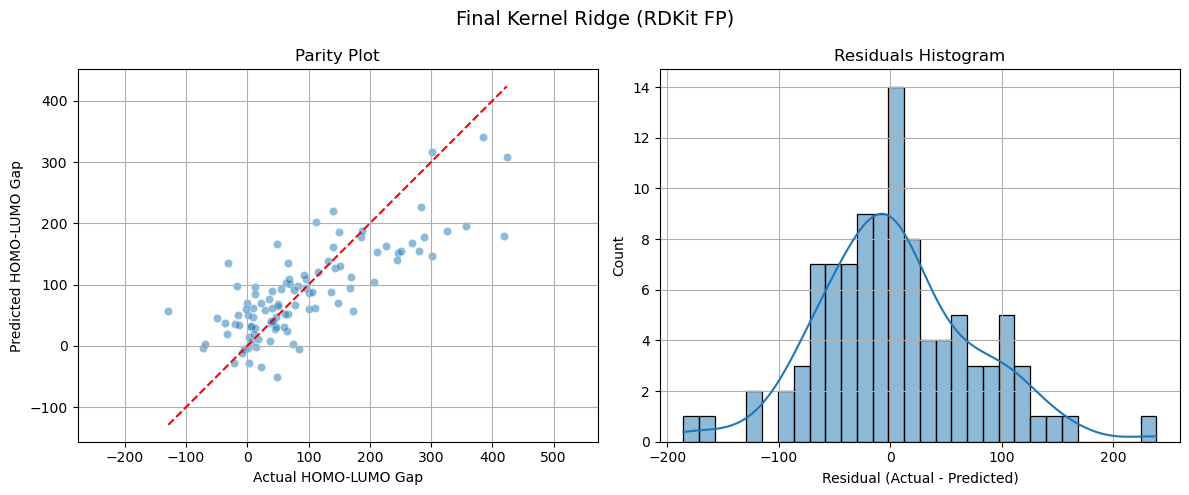

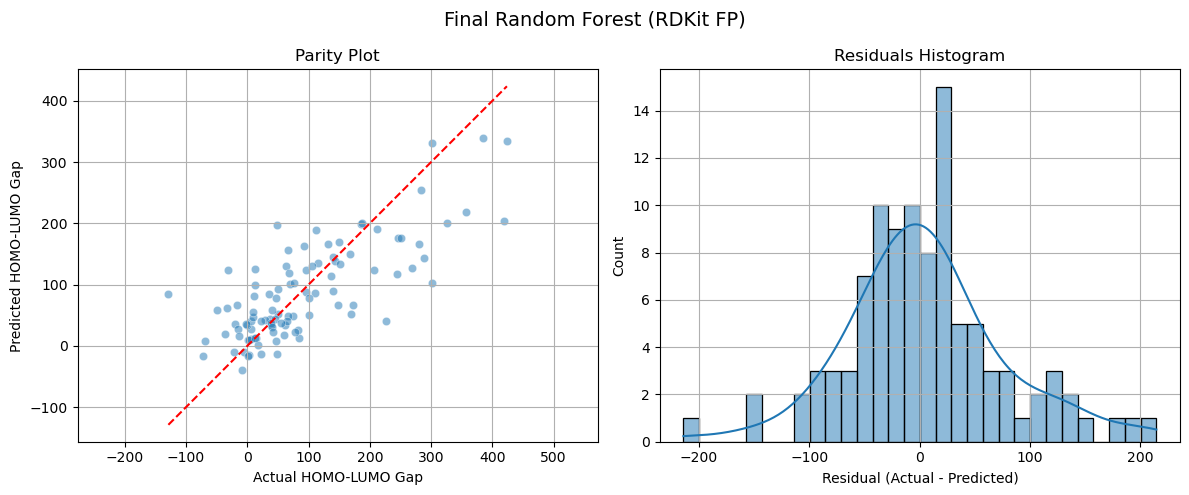

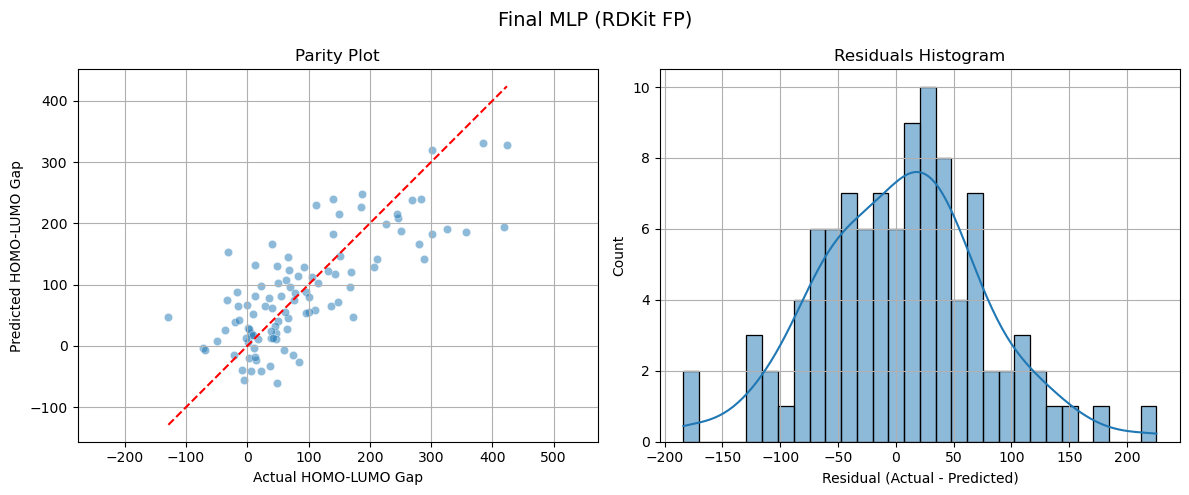

In [38]:
plot_regression_results(y_test_krr, final_preds_krr, title="Final Kernel Ridge (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_unscaled, final_preds_rfr, title="Final Random Forest (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_inv_fp, final_preds_inv_fp, title="Final MLP (RDKit FP)", save_dir="plots")
# plot_regression_results(y_test_inv_cm, final_preds_inv_cm, title="Final MLP (Coulomb Matrix)", save_dir="plots")


| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| MLP (Tuned)          | RDKit Fingerprints   | 0.426 | 0.574 | 0.798 | Strong performance across all metrics   |
| KRR (Tuned)          | RDKit Fingerprints   | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R² than MLP|
| RF (Tuned)           | RDKit Fingerprints   | 0.423| 0.583 | 0.791  | Top MAE, but slightly higher R²/RMSE    |
| MLP (Tuned)          | Coulomb Matrix       | 0.636 | 0.819 | 0.588 | Significantly worse than FP models      |
| MLP (Untuned Baseline) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Reasonable baseline performance         |
| KRR (Untuned Baseline) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Noticeable drop from tuned KRR          |
| RF (Untuned Baseline) | RDKit Fingerprints  | 0.426| 0.587 | 0.788  | Surprisingly strong untuned performance |
| MLP (Untuned Baseline) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Confirms Coulomb Matrix as weak         |

Save best model and metrics

In [39]:
# create a save directory
os.makedirs("saved_models_Tg", exist_ok=True)

# save the final trained MLP model (Keras backend)
final_mlp_fp.model.save("saved_models_Tg/best_mlp_fp_model_keras")

# save the X and Y scalers
joblib.dump(xscaler_fp, "saved_models_Tg/xscaler_fp.pkl")
joblib.dump(yscaler, "saved_models_Tg/yscaler.pkl")

# save evaluation metrics
final_metrics_fp.to_csv("saved_models_Tg/best_mlp_fp_metrics.csv", index=False)

INFO:tensorflow:Assets written to: saved_models_Tg/best_mlp_fp_model_keras\assets


If you wanted to reload these later...

In [40]:
# from tensorflow.keras.models import load_model

# # load model and scalersand metrics
# mlp_model = load_model("saved_models/best_mlp_fp_model_keras")
# xscaler_fp = joblib.load("saved_models/xscaler_fp.pkl")
# yscaler = joblib.load("saved_models/yscaler.pkl")
# metrics_df = pd.read_csv("saved_models/best_mlp_fp_metrics.csv")

# Training a Baseline GNN with ChemML
ChemML's `tensorise_molecules` generates its own graph. Its important to note this graph is not the official graph from PCQM4Mv2. It may miss out on features OGB uses like formal charge, aromatacity flags, atomic chirality, and explicit hydrogens. However, tensorise_molecules is a good choice for quick prototyping and it handles graph generation and tensor formatting in a numpy-friendly way which was easier for me to understand. Final training will use smiles2graph for compatability with OGB splits and better feature representation. 

In [41]:
# tensorize molecules
X_atoms, X_bonds, X_edges = tensorise_molecules(valid_mol_objs)
y = df_clean['Tg'].values.reshape(-1, 1)

# train test split (80/20)
split = int(0.8 * len(y))
X_atoms_train, X_atoms_test = X_atoms[:split], X_atoms[split:]
X_bonds_train, X_bonds_test = X_bonds[:split], X_bonds[split:]
X_edges_train, X_edges_test = X_edges[:split], X_edges[split:]
y_train, y_test = y[:split], y[split:]

# scale target
yscaler = StandardScaler()
y_train_scaled = yscaler.fit_transform(y_train)

# model input shapes
max_atoms = X_atoms.shape[1]
max_degree = X_bonds.shape[2]
num_atom_features = X_atoms.shape[-1]
num_bond_features = X_bonds.shape[-1]

# input layers
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

# GNN layers
conv1 = NeuralGraphHidden(8, activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(8, activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(128, activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(128, activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(128, activation='relu')([conv2, bonds_input, edges_input])

# fingerprint aggregation
fingerprint = Add()([fp1, fp2, fp3])

# dense layers
dense1 = Dense(128, activation='relu')(fingerprint)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# model compilation
model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# model training
model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=1, validation_split=0.1)

# preds and eval
y_pred = model.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred = yscaler.inverse_transform(y_pred)
metrics = regression_metrics(y_test, y_pred)
print("\nGNN Model Results:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Tensorising molecules in batches of 3000 ...
504/504 [==================================================] - 10s 21ms/step
Merging batch tensors ...    [DONE]
Epoch 1/100
6/6 [==============================] - 1s 89ms/step - loss: 211.7961 - val_loss: 4.2279
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 46.4533 - val_loss: 14.0274
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 28.2108 - val_loss: 3.2301
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 14.4109 - val_loss: 1.5478
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 8.2681 - val_loss: 1.6073
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 5.2334 - val_loss: 0.9518
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 2.8695 - val_loss: 1.7679
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 1.8212 - val_loss: 0.9395
Epoch 9/100
6/6 [==============================] - 0s 9ms/s

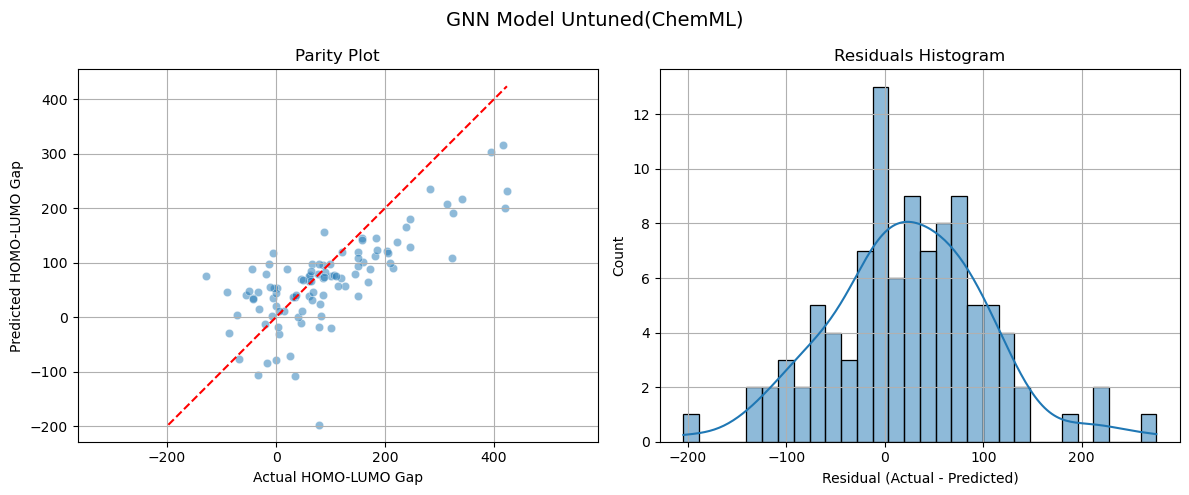

In [42]:
# plot results
plot_regression_results(y_test, y_pred, title="GNN Model Untuned(ChemML)", save_dir="plots")

In [43]:
from tensorflow.keras.metrics import MeanAbsoluteError

def objective_gnn(trial):
    conv_width = trial.suggest_categorical('conv_width', [8, 16, 32])
    fp_length = trial.suggest_categorical('fp_length', [96, 128, 160])
    n1 = trial.suggest_int('n1', 128, 192, step=32)
    n2 = trial.suggest_int('n2', 64, 96, step=32)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-8, 1e-4, log=True)
    activation = 'relu'

    # model definition
    atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
    bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
    edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

    conv1 = NeuralGraphHidden(conv_width, activation=activation)([atoms_input, bonds_input, edges_input])
    conv2 = NeuralGraphHidden(conv_width, activation=activation)([conv1, bonds_input, edges_input])

    fp1 = NeuralGraphOutput(fp_length, activation=activation)([atoms_input, bonds_input, edges_input])
    fp2 = NeuralGraphOutput(fp_length, activation=activation)([conv1, bonds_input, edges_input])
    fp3 = NeuralGraphOutput(fp_length, activation=activation)([conv2, bonds_input, edges_input])
    fingerprint = Add()([fp1, fp2, fp3])

    dense1 = Dense(n1, activation=activation, kernel_regularizer=regularizers.l2(alpha))(fingerprint)
    dense2 = Dense(n2, activation=activation, kernel_regularizer=regularizers.l2(alpha))(dense1)
    output = Dense(1, activation='linear')(dense2)

    model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

    history = model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=0, validation_split=0.2)

    # return best validation MAE
    val_mae = min(history.history["val_mean_absolute_error"])  
    return val_mae

study_gnn = optuna.create_study(direction='minimize')  
study_gnn.optimize(objective_gnn, n_trials=50)

[I 2025-09-04 20:17:31,688] A new study created in memory with name: no-name-db90c8e1-5bb4-4a60-b540-debf549064f0
[I 2025-09-04 20:17:38,194] Trial 0 finished with value: 0.5784119963645935 and parameters: {'conv_width': 16, 'fp_length': 160, 'n1': 160, 'n2': 64, 'lr': 0.0074779903531160775, 'alpha': 1.1713607039847262e-05}. Best is trial 0 with value: 0.5784119963645935.
[I 2025-09-04 20:17:44,489] Trial 1 finished with value: 0.6189797520637512 and parameters: {'conv_width': 8, 'fp_length': 160, 'n1': 192, 'n2': 96, 'lr': 2.0096572916443418e-05, 'alpha': 6.93435054090891e-07}. Best is trial 0 with value: 0.5784119963645935.
[I 2025-09-04 20:17:50,936] Trial 2 finished with value: 1.3424192667007446 and parameters: {'conv_width': 16, 'fp_length': 96, 'n1': 192, 'n2': 96, 'lr': 1.0740694360574098e-05, 'alpha': 4.07655092722975e-07}. Best is trial 0 with value: 0.5784119963645935.
[I 2025-09-04 20:17:57,470] Trial 3 finished with value: 0.6044057607650757 and parameters: {'conv_width': 

## Retraining ChemML GNN with Best Parameter Found in Optuna Search

In [44]:
params = study_gnn.best_params

# redefine and compile using best params
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

conv1 = NeuralGraphHidden(params['conv_width'], activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(params['conv_width'], activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(params['fp_length'], activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(params['fp_length'],activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(params['fp_length'], activation='relu')([conv2, bonds_input, edges_input])
fingerprint = Add()([fp1, fp2, fp3])

dense1 = Dense(params['n1'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(fingerprint)
dense2 = Dense(params['n2'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(dense1)
output = Dense(1, activation='linear')(dense2)

final_gnn = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
final_gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']), loss='mean_squared_error')

final_gnn.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=200, batch_size=64, verbose=1)

# final eval
y_pred_final = final_gnn.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred_final = yscaler.inverse_transform(y_pred_final)
final_metrics = regression_metrics(y_test, y_pred_final)
print("\nFinal Tuned GNN Results:")
print(final_metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
7/7 [==============================] - 1s 29ms/step - loss: 1828.2208
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 83.8997
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 36.6573
Epoch 4/200
7/7 [==============================] - 0s 5ms/step - loss: 12.0149
Epoch 5/200
7/7 [==============================] - 0s 5ms/step - loss: 2.5238
Epoch 6/200
7/7 [==============================] - 0s 4ms/step - loss: 1.7810
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.9541
Epoch 8/200
7/7 [==============================] - 0s 5ms/step - loss: 0.6475
Epoch 9/200
7/7 [==============================] - 0s 4ms/step - loss: 0.6104
Epoch 10/200
7/7 [==============================] - 0s 4ms/step - loss: 0.5773
Epoch 11/200
7/7 [==============================] - 0s 4ms/step - loss: 0.6357
Epoch 12/200
7/7 [==============================] - 0s 4ms/step - loss: 0.5952
Epoch 13/200
7/7 [==============================] - 0

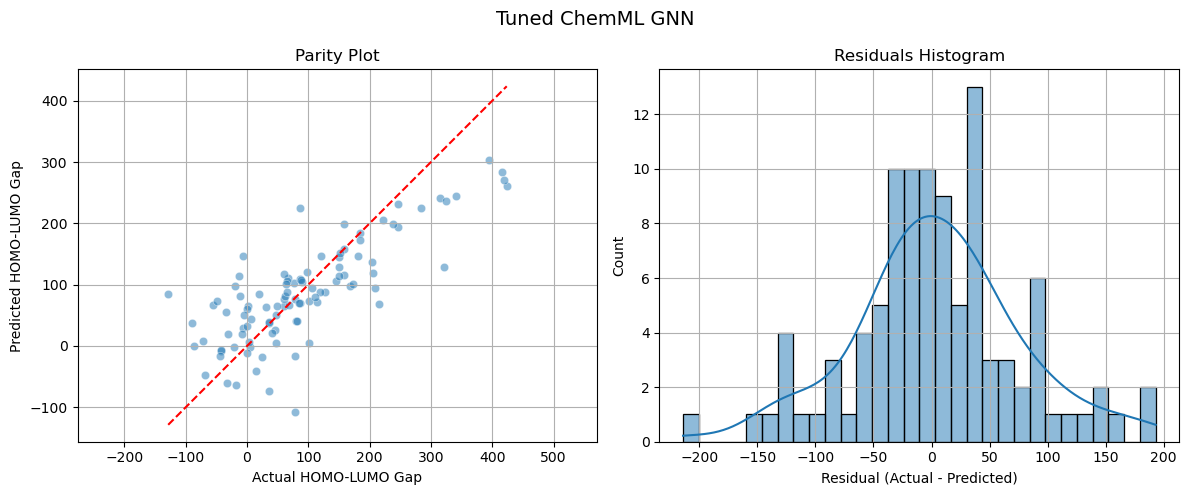

In [45]:
plot_regression_results(y_test, y_pred_final, title="Tuned ChemML GNN", save_dir="plots")

In [46]:
import json

# make a directory for this specific model
save_dir = "saved_models_Tg/gnn_tensorise_molecules_model"
os.makedirs(save_dir, exist_ok=True)

# 1. save the trained GNN model
final_gnn.save(os.path.join(save_dir, "gnn_tensorise_molecules_model_tf"), save_format="tf")

# 2. save the y target scaler
with open(os.path.join(save_dir, "gnn_tensorise_molecules_target_scaler.pkl"), "wb") as f:
    pickle.dump(yscaler, f)

# 3. save the final metrics
final_metrics.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_metrics.csv"), index=False)

# 4. save predictions
pred_df = pd.DataFrame({"true_gap": y_test.flatten(), "predicted_gap": y_pred_final.flatten()})
pred_df.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_predictions.csv"), index=False)

# 5. save the best hyperparameters
with open(os.path.join(save_dir, "gnn_tensorise_molecules_best_params.json"), "w") as f:
    json.dump(params, f, indent=4)

INFO:tensorflow:Assets written to: saved_models_Tg/gnn_tensorise_molecules_model\gnn_tensorise_molecules_model_tf\assets


## ChemML GNN Model Results
| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| GNN (Tuned)            | tensorise_molecules Graph   | 0.302 | 0.411 | 0.900 | Best performance across all metrics   |
| GNN (Untuned)          | tensorise_molecules Graph   | 0.400 | 0.519 | 0.841 | Good overall|


---
# Final Model Training

Having explored different molecular graph representations and model architectures, I am now moving to training what is expected to be the best-performing model using the full dataset. The earlier GNN model was based on `tensorise_molecules` (ChemML) graphs and had strong performance with a **mean absolute error (MAE) around 0.30**. These graphs are based on RDKit's internal descriptors and do not reflect the original PCQM4Mv2 graph structure used in the Open Graph Benchmark (OGB). Therefore, I will shift focus to the `smiles2graph` representation provided by OGB, which aligns more directly with the benchmark's evaluation setup and top-performing models on the leaderboard.


| Source                         | Atom/Bond Features                                                 | Format                                          | Customizable?     | Alignment with PCQM4Mv2?  |
| ------------------------------ | ------------------------------------------------------------------ | ----------------------------------------------- | ----------------- | ---------------------- |
| `tensorise_molecules` (ChemML) | RDKit-based descriptors (ex: atom number, degree, hybridization) | NumPy tensors (`X_atoms`, `X_bonds`, `X_edges`) | Limited           |  Not aligned          |
| `smiles2graph` (OGB / PyG)     | Predefined categorical features from PCQM4Mv2                      | PyTorch Geometric `Data` objects                |  Highly flexible |  Matches OGB standard |

By using `smiles2graph`, we:

* Use OGB-standard graph construction and feature encoding for fair comparisons with leaderboard models
* Include learnable AtomEncoder and BondEncoder embeddings from `ogb.graphproppred.mol_encoder`, which improve model expressiveness
* Maintain compatibility with PyTorch Geometric, DGL, and OGB tools

I will also concatenate GNN-derived embeddings with SMILES-based RDKit descriptors, feeding this hybrid representation into MLP head. This allows you to combine structural and cheminformatics perspectives for improved prediction accuracy. With this setup, I aim to improve upon the MAE of \~0.30 achieved earlier and push closer toward state-of-the-art performance.


## Step 1: Load PyG-Compatible Dataset



In [47]:
def check_cuda():
    print("PyTorch version:", torch.__version__)
    print("CUDA available? ", torch.cuda.is_available())
    
    if torch.cuda.is_available():
        print("Device count:", torch.cuda.device_count())
        print("GPU Name:", torch.cuda.get_device_name(0))
        print("Current device:", torch.cuda.current_device())
    else:
        print("Running on CPU")

check_cuda()

PyTorch version: 2.4.1+cu118
CUDA available?  True
Device count: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Current device: 0


In [19]:
# 1. load OGB dataset 
df_tg = pd.read_csv('cleaned_tg_dataset.csv')


#  Step 2: Extract SMILES from Original Dataset

In [20]:
# 2. Extract SMILES and Tg targets
# `df_tg` already contains the SMILES and Tg columns.
smiles_list = df_tg['SMILES'].tolist()
Tg_list = df_tg['Tg'].tolist()

num_mols = len(smiles_list)
print(f"Loaded {num_mols} molecules.")

Loaded 504 molecules.


In [21]:
def compute_rdkit_features(smiles):
    cleaned_smiles = canonicalize_polymer_smiles(smiles)
    mol = Chem.MolFromSmiles(cleaned_smiles)
    if mol is None:
        return [np.nan] * 9  # Update the number of NaNs to match new features

    # Check for empty molecule
    if mol.GetNumAtoms() == 0:
        return [np.nan] * 9

    # Add features that capture size, shape, and interactions
    return [
        Descriptors.MolWt(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),  # New: Fraction of sp3 hybridized carbons
        Descriptors.MolLogP(mol),      # New: Octanol-water partition coefficient
        Descriptors.NumSaturatedRings(mol) # New: Number of saturated rings
    ]

rdkit_features = np.array([compute_rdkit_features(smi) for smi in smiles_list])
print(f"Shape of RDKit features: {rdkit_features.shape}") # Should be (N, 9)

Shape of RDKit features: (504, 9)


In [22]:
# Remove rows with NaN values (failed RDKit featurization)
valid_indices = ~np.isnan(rdkit_features).any(axis=1)
rdkit_features = rdkit_features[valid_indices]
smiles_list = np.array(smiles_list)[valid_indices].tolist()
Tg_list = np.array(Tg_list)[valid_indices].tolist()

print(f"Kept {len(smiles_list)} molecules with valid RDKit features.")

Kept 504 molecules with valid RDKit features.


# Step 4: attach RDKit features to PyG data objects

In [23]:
import torch
from torch_geometric.data import Data, DataLoader

# Assuming your previous cells have loaded and processed the data into these lists:
# smiles_list: list of SMILES strings
# rdkit_features: numpy array of RDKit features (N, 6)
# Tg_list: list of Tg values (N,)

# 1. Create a list of PyG Data objects
rdkit_features_tensor = torch.tensor(rdkit_features, dtype=torch.float32)
ffv_targets_tensor = torch.tensor(Tg_list, dtype=torch.float32).view(-1, 1)

data_list = []
for i in range(len(smiles_list)):
    # smiles2graph returns a dictionary
    graph_dict = smiles2graph(smiles_list[i])
    
    # Create the Data object from the dictionary keys, converting to tensors
    # Convert node and edge features to LongTensor 
    data = Data(
        x=torch.tensor(graph_dict['node_feat'], dtype=torch.long),
        edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(graph_dict['edge_feat'], dtype=torch.long),
        rdkit_feats=rdkit_features_tensor[i],
        y=ffv_targets_tensor[i]
    )
    data_list.append(data)

# 2. Split the dataset
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=42)

# 3. Create PyG DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# 4. Verification
for batch in train_loader:
    print(batch)
    print("Batch's node features shape:", batch.x.shape)
    print("Batch's RDKit features shape:", batch.rdkit_feats.shape)
    print("Batch's targets shape:", batch.y.shape)
    print("Batch's 'batch' attribute shape:", batch.batch.shape)
    break

DataBatch(x=[1032, 9], edge_index=[2, 2182], edge_attr=[2182, 3], y=[32], rdkit_feats=[288], batch=[1032], ptr=[33])
Batch's node features shape: torch.Size([1032, 9])
Batch's RDKit features shape: torch.Size([288])
Batch's targets shape: torch.Size([32])
Batch's 'batch' attribute shape: torch.Size([1032])


c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Step 5: Define the Hybrid GNN Model

The final architecture uses both structural and cheminformatics data by combining GNN-learned graph embeddings with SMILES-derived RDKit descriptors. This Hybrid GNN model uses `smiles2graph` for graph construction and augments it with RDKit-based molecular features for improved prediction accuracy.

### Model Components:

* **AtomEncoder / BondEncoder**
  Transforms categorical atom and bond features (provided by OGB) into learnable embeddings using the encoders from `ogb.graphproppred.mol_encoder`. These provide a strong foundation for expressive graph learning.

* **GINEConv Layers (x2)**
  I use two stacked GINEConv layers (Graph Isomorphism Network with Edge features). These layers perform neighborhood aggregation based on edge attributes, allowing the model to capture localized chemical environments.

* **Global Mean Pooling**
  After message passing, node level embeddings are aggregated into a fixed size graph level representation using `global_mean_pool`.

* **Concatenation with RDKit Descriptors**
  The pooled GNN embedding is concatenated with external RDKit descriptors, which capture global molecular properties not easily inferred from graph data alone.

* **MLP Prediction Head**
  A multilayer perceptron processes the combined feature vector with ReLU activations, dropout regularization, and linear layers to predict the HOMO–LUMO gap.

In [24]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2):
        super().__init__()
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim, hidden_dim // 2), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

# Step 7: training loop 

In [25]:
# initialize model
model = HybridGNN(gnn_dim=128, rdkit_dim=rdkit_features.shape[1], hidden_dim=256)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = float('inf')
patience = 10
patience_counter = 0

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    loss = F.mse_loss(preds, targets)
    return loss.item(), preds, targets

# training loop
for epoch in range(1, 101): # long since early stopping
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch:02d}"):
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_dir = "saved_models/gnn_smiles2graph_model"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "hybridgnn_untuned.pt"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# final eval on val set
model.load_state_dict(torch.load(os.path.join(save_dir, "hybridgnn_untuned.pt")))
model.eval()
_, final_preds, final_targets = evaluate(model, valid_loader)
metrics = regression_metrics(final_targets.numpy(), final_preds.numpy())
print("\nGNN Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 01: 100%|██████████| 13/13 [00:00<00:00, 60.14it/s]


Epoch 01 | Train Loss: 14966.3594 | Val Loss: 11512.8027


Epoch 02: 100%|██████████| 13/13 [00:00<00:00, 108.89it/s]


Epoch 02 | Train Loss: 11906.9952 | Val Loss: 10899.3535


Epoch 03: 100%|██████████| 13/13 [00:00<00:00, 137.88it/s]


Epoch 03 | Train Loss: 10743.5882 | Val Loss: 9611.4268


Epoch 04: 100%|██████████| 13/13 [00:00<00:00, 142.45it/s]


Epoch 04 | Train Loss: 8785.2726 | Val Loss: 7241.0376


Epoch 05: 100%|██████████| 13/13 [00:00<00:00, 159.78it/s]


Epoch 05 | Train Loss: 7528.4167 | Val Loss: 5260.0459


Epoch 06: 100%|██████████| 13/13 [00:00<00:00, 137.24it/s]


Epoch 06 | Train Loss: 6511.8596 | Val Loss: 4957.6353


Epoch 07: 100%|██████████| 13/13 [00:00<00:00, 176.00it/s]


Epoch 07 | Train Loss: 6373.2479 | Val Loss: 4830.2041


Epoch 08: 100%|██████████| 13/13 [00:00<00:00, 176.77it/s]


Epoch 08 | Train Loss: 6298.0629 | Val Loss: 5033.8071


Epoch 09: 100%|██████████| 13/13 [00:00<00:00, 186.96it/s]


Epoch 09 | Train Loss: 6202.5310 | Val Loss: 5345.5386


Epoch 10: 100%|██████████| 13/13 [00:00<00:00, 134.68it/s]


Epoch 10 | Train Loss: 6072.5672 | Val Loss: 4692.9863


Epoch 11: 100%|██████████| 13/13 [00:00<00:00, 163.14it/s]


Epoch 11 | Train Loss: 5881.2335 | Val Loss: 4204.9956


Epoch 12: 100%|██████████| 13/13 [00:00<00:00, 179.99it/s]

Epoch 12 | Train Loss: 6033.7601 | Val Loss: 4466.8452

Epoch 13: 100%|██████████| 13/13 [00:00<00:00, 185.41it/s]


Epoch 13 | Train Loss: 5463.4788 | Val Loss: 4294.0400


Epoch 14: 100%|██████████| 13/13 [00:00<00:00, 184.40it/s]


Epoch 14 | Train Loss: 5408.3220 | Val Loss: 4383.6265


Epoch 15: 100%|██████████| 13/13 [00:00<00:00, 136.01it/s]


Epoch 15 | Train Loss: 5344.6624 | Val Loss: 4296.7300


Epoch 16: 100%|██████████| 13/13 [00:00<00:00, 176.97it/s]


Epoch 16 | Train Loss: 5411.0324 | Val Loss: 3983.4148


Epoch 17: 100%|██████████| 13/13 [00:00<00:00, 181.81it/s]


Epoch 17 | Train Loss: 5319.1669 | Val Loss: 4663.2109


Epoch 18: 100%|██████████| 13/13 [00:00<00:00, 186.45it/s]


Epoch 18 | Train Loss: 5129.0777 | Val Loss: 4066.8186


Epoch 19: 100%|██████████| 13/13 [00:00<00:00, 129.60it/s]


Epoch 19 | Train Loss: 5256.7687 | Val Loss: 3979.9556


Epoch 20: 100%|██████████| 13/13 [00:00<00:00, 176.66it/s]


Epoch 20 | Train Loss: 5255.6154 | Val Loss: 3947.0869


Epoch 21: 100%|██████████| 13/13 [00:00<00:00, 198.45it/s]


Epoch 21 | Train Loss: 5253.9093 | Val Loss: 4706.0840


Epoch 22: 100%|██████████| 13/13 [00:00<00:00, 191.31it/s]


Epoch 22 | Train Loss: 5246.5694 | Val Loss: 3758.7673


Epoch 23: 100%|██████████| 13/13 [00:00<00:00, 187.80it/s]


Epoch 23 | Train Loss: 5158.5458 | Val Loss: 4060.2312


Epoch 24: 100%|██████████| 13/13 [00:00<00:00, 148.91it/s]


Epoch 24 | Train Loss: 5331.8830 | Val Loss: 3814.5173


Epoch 25: 100%|██████████| 13/13 [00:00<00:00, 178.45it/s]

Epoch 25 | Train Loss: 5026.8323 | Val Loss: 3753.6299

Epoch 26: 100%|██████████| 13/13 [00:00<00:00, 200.23it/s]


Epoch 26 | Train Loss: 5182.3270 | Val Loss: 3895.0588


Epoch 27: 100%|██████████| 13/13 [00:00<00:00, 189.08it/s]


Epoch 27 | Train Loss: 5047.7889 | Val Loss: 4028.6306


Epoch 28: 100%|██████████| 13/13 [00:00<00:00, 199.31it/s]


Epoch 28 | Train Loss: 4810.3956 | Val Loss: 3649.9131


Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 153.09it/s]

Epoch 29 | Train Loss: 5639.8314 | Val Loss: 4151.3579



Epoch 30: 100%|██████████| 13/13 [00:00<00:00, 193.44it/s]

Epoch 30 | Train Loss: 4844.5139 | Val Loss: 3883.1401

Epoch 31: 100%|██████████| 13/13 [00:00<00:00, 186.62it/s]


Epoch 31 | Train Loss: 6156.9958 | Val Loss: 4602.6216


Epoch 32: 100%|██████████| 13/13 [00:00<00:00, 188.10it/s]


Epoch 32 | Train Loss: 5210.3431 | Val Loss: 3886.7363


Epoch 33: 100%|██████████| 13/13 [00:00<00:00, 133.84it/s]

Epoch 33 | Train Loss: 4991.4911 | Val Loss: 3676.1914

Epoch 34: 100%|██████████| 13/13 [00:00<00:00, 169.39it/s]


Epoch 34 | Train Loss: 4763.9710 | Val Loss: 4195.1245


Epoch 35: 100%|██████████| 13/13 [00:00<00:00, 197.78it/s]


Epoch 35 | Train Loss: 4901.2642 | Val Loss: 4628.0796


Epoch 36: 100%|██████████| 13/13 [00:00<00:00, 197.33it/s]


Epoch 36 | Train Loss: 5414.0003 | Val Loss: 3806.2488


Epoch 37: 100%|██████████| 13/13 [00:00<00:00, 186.32it/s]


Epoch 37 | Train Loss: 5099.8593 | Val Loss: 3547.3022


Epoch 38: 100%|██████████| 13/13 [00:00<00:00, 141.06it/s]


Epoch 38 | Train Loss: 4911.2688 | Val Loss: 3910.7456


Epoch 39: 100%|██████████| 13/13 [00:00<00:00, 180.17it/s]


Epoch 39 | Train Loss: 5103.1292 | Val Loss: 3805.1677


Epoch 40: 100%|██████████| 13/13 [00:00<00:00, 200.09it/s]


Epoch 40 | Train Loss: 5131.8367 | Val Loss: 3614.9355


Epoch 41: 100%|██████████| 13/13 [00:00<00:00, 173.47it/s]


Epoch 41 | Train Loss: 4767.0297 | Val Loss: 3555.4512


Epoch 42: 100%|██████████| 13/13 [00:00<00:00, 185.41it/s]


Epoch 42 | Train Loss: 4818.1657 | Val Loss: 3624.4854


Epoch 43: 100%|██████████| 13/13 [00:00<00:00, 145.32it/s]


Epoch 43 | Train Loss: 4576.8361 | Val Loss: 4143.8711


Epoch 44: 100%|██████████| 13/13 [00:00<00:00, 180.14it/s]


Epoch 44 | Train Loss: 4342.7143 | Val Loss: 3691.6885


Epoch 45: 100%|██████████| 13/13 [00:00<00:00, 188.23it/s]


Epoch 45 | Train Loss: 4263.7348 | Val Loss: 3396.1584


Epoch 46: 100%|██████████| 13/13 [00:00<00:00, 198.66it/s]


Epoch 46 | Train Loss: 4343.3689 | Val Loss: 3821.3723


Epoch 47: 100%|██████████| 13/13 [00:00<00:00, 194.89it/s]


Epoch 47 | Train Loss: 4252.4639 | Val Loss: 3425.8694


Epoch 48: 100%|██████████| 13/13 [00:00<00:00, 141.01it/s]


Epoch 48 | Train Loss: 4496.8659 | Val Loss: 3433.8384


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 176.58it/s]

Epoch 49 | Train Loss: 4650.5424 | Val Loss: 3835.2700

Epoch 50: 100%|██████████| 13/13 [00:00<00:00, 120.15it/s]


Epoch 50 | Train Loss: 4575.2184 | Val Loss: 3520.6484


Epoch 51: 100%|██████████| 13/13 [00:00<00:00, 183.87it/s]


Epoch 51 | Train Loss: 4339.4751 | Val Loss: 3492.7603


Epoch 52: 100%|██████████| 13/13 [00:00<00:00, 144.83it/s]

Epoch 52 | Train Loss: 4168.6959 | Val Loss: 3818.1165

Epoch 53: 100%|██████████| 13/13 [00:00<00:00, 164.47it/s]


Epoch 53 | Train Loss: 4114.1805 | Val Loss: 3461.8186


Epoch 54: 100%|██████████| 13/13 [00:00<00:00, 185.59it/s]

Epoch 54 | Train Loss: 4162.3618 | Val Loss: 4534.2358



Epoch 55: 100%|██████████| 13/13 [00:00<00:00, 190.80it/s]
C:\Users\mattg\AppData\Local\Temp\ipykernel_16100\2343932047.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

Epoch 55 | Train Loss: 4186.9516 | Val Loss: 3480.4678
Early stopping triggered at epoch 55

GNN Evaluation:
         MAE       RMSE  r_squared
0  41.419392  58.276566   0.727249


# Step 8: Optuna tuning of Hybrid GNN

In [26]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2, activation='ReLU'):
        super().__init__()
        act_map = {'ReLU': torch.nn.ReLU(), 'ELU': torch.nn.ELU(), 'GELU': torch.nn.GELU(), 'LeakyReLU': torch.nn.LeakyReLU(), 'PReLU': torch.nn.PReLU(), 'Swish': torch.nn.SiLU()}
        act_fn = act_map[activation]
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim, hidden_dim // 2), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

Multiple rounds of tuning have suggested to refine my search space to ReLU, GELU, and Swish activation functions and Adam and AdamW optimizers. Therefore, I have commented out unused parameters like momentum for SGD and the unused optimizers. 

In [32]:
def objective(trial):
    # hyperparameter search space
    gnn_dim = trial.suggest_categorical("gnn_dim", [256, 384, 512, 1024])
    hidden_dim = trial.suggest_categorical("hidden_dim", [256, 384, 512])
    dropout_rate = trial.suggest_float("dropout_rate", 0.15, 0.4)
    lr = trial.suggest_float("lr", 8e-6, 1e-3, log=True)
    activation = trial.suggest_categorical("activation", ['ReLU', 'GELU', 'Swish'])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD", "RMSprop"])
    momentum = trial.suggest_float("momentum", 0.8, 0.99, log=True) if optimizer_name == "SGD" else None
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Corrected Data Splitting for Polymer Data 
    # Split the full data_list into train, validation, and test sets.
    # Note: `data_list` should be created in a previous cell.
    train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
    train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)
    
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    valid_loader = DataLoader(val_set, batch_size=64)
    
    # model instantiation
    # The rdkit_dim is dynamically taken from the pre-processed features.
    model = HybridGNN(
        gnn_dim=gnn_dim,
        rdkit_dim=rdkit_features.shape[1],
        hidden_dim=hidden_dim,
        dropout_rate=dropout_rate,
        activation=activation
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # optimizer instantiation
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not supported")

    # training loop with NaN check and early stopping
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(1, 100):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))

            if torch.isnan(loss).any():
                print(f"Trial {trial.number} | Epoch {epoch:02d} | NaN loss detected so pruning trial")
                trial.report(float('inf'), epoch)
                raise optuna.TrialPruned()

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_loss += F.mse_loss(pred, batch.y.view(-1, 1)).item() * batch.num_graphs
        val_loss /= len(valid_loader.dataset)

        # logging, reporting, pruning, early stopping
        print(f"Trial {trial.number} | Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Optimizer: {optimizer_name}")
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Trial {trial.number} - Early stopping triggered at epoch {epoch}")
                break

    return best_val_loss

if __name__ == '__main__':
    study_name = "final_2d_gnn_study_Tg_6"
    storage_name = f"sqlite:///{study_name}.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", pruner=optuna.pruners.MedianPruner())

    def save_study_callback(study, trial):
        pass

    study.optimize(objective, n_trials=1500, callbacks=[save_study_callback])
    print(study.best_params)
    joblib.dump(study, f"{study_name}_final.pkl")
    
    # final plots
    vis = optuna.visualization
    fig = vis.plot_optimization_history(study)
    fig.show()
    fig_params = vis.plot_param_importances(study)
    fig_params.show()
    fig_intermediate = vis.plot_intermediate_values(study)
    fig_intermediate.show()
    fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
    fig_parallel_coordinate.show()
    fig_slice = vis.plot_slice(study)
    fig_slice.show()

[I 2025-09-05 18:59:29,258] A new study created in RDB with name: final_2d_gnn_study_Tg_6
c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



Trial 0 | Epoch 01 | Train Loss: 21353.0280 | Val Loss: 21130.4590 | Optimizer: AdamW
Trial 0 | Epoch 02 | Train Loss: 19865.8993 | Val Loss: 18284.1584 | Optimizer: AdamW
Trial 0 | Epoch 03 | Train Loss: 15630.9519 | Val Loss: 10764.1219 | Optimizer: AdamW
Trial 0 | Epoch 04 | Train Loss: 11053.8478 | Val Loss: 10290.9002 | Optimizer: AdamW
Trial 0 | Epoch 05 | Train Loss: 11017.4944 | Val Loss: 9036.3738 | Optimizer: AdamW
Trial 0 | Epoch 06 | Train Loss: 9980.0131 | Val Loss: 10554.1747 | Optimizer: AdamW
Trial 0 | Epoch 07 | Train Loss: 10365.6873 | Val Loss: 8638.2348 | Optimizer: AdamW
Trial 0 | Epoch 08 | Train Loss: 9144.0439 | Val Loss: 8065.1139 | Optimizer: AdamW
Trial 0 | Epoch 09 | Train Loss: 8325.6938 | Val Loss: 7044.7456 | Optimizer: AdamW
Trial 0 | Epoch 10 | Train Loss: 7781.7158 | Val Loss: 7842.9243 | Optimizer: AdamW
Trial 0 | Epoch 11 | Train Loss: 8178.6324 | Val Loss: 6498.4299 | Optimizer: AdamW
Trial 0 | Epoch 12 | Train Loss: 8316.6447 | Val Loss: 6362.2449 

[I 2025-09-05 18:59:35,160] Trial 0 finished with value: 5197.783649209105 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.34789969778599206, 'lr': 0.00019706110180855172, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 6.918777663255381e-06}. Best is trial 0 with value: 5197.783649209105.


Trial 0 | Epoch 70 | Train Loss: 7642.9100 | Val Loss: 5354.3312 | Optimizer: AdamW
Trial 0 - Early stopping triggered at epoch 70
Trial 1 | Epoch 01 | Train Loss: 18620.6935 | Val Loss: 13732.5400 | Optimizer: Adam
Trial 1 | Epoch 02 | Train Loss: 12839.7794 | Val Loss: 10173.1253 | Optimizer: Adam
Trial 1 | Epoch 03 | Train Loss: 10908.4518 | Val Loss: 9593.9016 | Optimizer: Adam
Trial 1 | Epoch 04 | Train Loss: 10015.3029 | Val Loss: 8103.3509 | Optimizer: Adam
Trial 1 | Epoch 05 | Train Loss: 8782.8457 | Val Loss: 7833.3933 | Optimizer: Adam
Trial 1 | Epoch 06 | Train Loss: 8556.1367 | Val Loss: 7152.4838 | Optimizer: Adam
Trial 1 | Epoch 07 | Train Loss: 8040.3176 | Val Loss: 6746.5570 | Optimizer: Adam
Trial 1 | Epoch 08 | Train Loss: 7345.4207 | Val Loss: 6321.3125 | Optimizer: Adam
Trial 1 | Epoch 09 | Train Loss: 7099.1777 | Val Loss: 6901.4940 | Optimizer: Adam
Trial 1 | Epoch 10 | Train Loss: 7535.1776 | Val Loss: 8169.6968 | Optimizer: Adam
Trial 1 | Epoch 11 | Train Loss: 

[I 2025-09-05 18:59:37,619] Trial 1 finished with value: 5052.430064260224 and parameters: {'gnn_dim': 256, 'hidden_dim': 384, 'dropout_rate': 0.3386970659282392, 'lr': 0.0008805083733534888, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 1.4250321078722525e-06}. Best is trial 1 with value: 5052.430064260224.


Trial 1 | Epoch 47 | Train Loss: 5252.2945 | Val Loss: 5193.4824 | Optimizer: Adam
Trial 1 | Epoch 48 | Train Loss: 5083.4840 | Val Loss: 5198.2090 | Optimizer: Adam
Trial 1 - Early stopping triggered at epoch 48
Trial 2 | Epoch 01 | Train Loss: 26717.4958 | Val Loss: 22543.5034 | Optimizer: SGD
Trial 2 | Epoch 02 | Train Loss: 22012.2307 | Val Loss: 22414.0762 | Optimizer: SGD
Trial 2 | Epoch 03 | Train Loss: 21927.4850 | Val Loss: 22379.3090 | Optimizer: SGD
Trial 2 | Epoch 04 | Train Loss: 21896.4000 | Val Loss: 22353.1413 | Optimizer: SGD
Trial 2 | Epoch 05 | Train Loss: 21870.1305 | Val Loss: 22327.3915 | Optimizer: SGD
Trial 2 | Epoch 06 | Train Loss: 21844.0990 | Val Loss: 22298.9447 | Optimizer: SGD
Trial 2 | Epoch 07 | Train Loss: 21813.0929 | Val Loss: 22263.8213 | Optimizer: SGD
Trial 2 | Epoch 08 | Train Loss: 21774.2502 | Val Loss: 22223.2584 | Optimizer: SGD
Trial 2 | Epoch 09 | Train Loss: 21735.6673 | Val Loss: 22187.5272 | Optimizer: SGD
Trial 2 | Epoch 10 | Train Loss

[I 2025-09-05 18:59:42,843] Trial 2 finished with value: 12828.505365065586 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.1865352470138201, 'lr': 1.9496309765903227e-05, 'activation': 'ReLU', 'optimizer': 'SGD', 'momentum': 0.8249147681381581, 'weight_decay': 2.4239649920149693e-06}. Best is trial 1 with value: 5052.430064260224.


Trial 2 | Epoch 65 | Train Loss: 12746.9392 | Val Loss: 12978.9382 | Optimizer: SGD
Trial 2 - Early stopping triggered at epoch 65
Trial 3 | Epoch 01 | Train Loss: 21209.7255 | Val Loss: 20547.8431 | Optimizer: Adam
Trial 3 | Epoch 02 | Train Loss: 19734.1264 | Val Loss: 19040.5971 | Optimizer: Adam
Trial 3 | Epoch 03 | Train Loss: 18498.1451 | Val Loss: 17618.5432 | Optimizer: Adam
Trial 3 | Epoch 04 | Train Loss: 16811.9537 | Val Loss: 15874.3342 | Optimizer: Adam
Trial 3 | Epoch 05 | Train Loss: 15148.1524 | Val Loss: 13387.7922 | Optimizer: Adam
Trial 3 | Epoch 06 | Train Loss: 12602.1459 | Val Loss: 10640.4751 | Optimizer: Adam
Trial 3 | Epoch 07 | Train Loss: 10679.9815 | Val Loss: 10541.7943 | Optimizer: Adam
Trial 3 | Epoch 08 | Train Loss: 10638.4144 | Val Loss: 9569.0723 | Optimizer: Adam
Trial 3 | Epoch 09 | Train Loss: 9983.7287 | Val Loss: 9736.4614 | Optimizer: Adam
Trial 3 | Epoch 10 | Train Loss: 9894.3647 | Val Loss: 8944.3889 | Optimizer: Adam
Trial 3 | Epoch 11 | Tra

[I 2025-09-05 18:59:46,043] Trial 3 finished with value: 5137.008415316358 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.33601299717314004, 'lr': 0.00011346972633906472, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 6.85481436715093e-05}. Best is trial 1 with value: 5052.430064260224.


Trial 3 | Epoch 55 | Train Loss: 6105.0193 | Val Loss: 5484.9383 | Optimizer: Adam
Trial 3 | Epoch 56 | Train Loss: 6104.0638 | Val Loss: 5247.7969 | Optimizer: Adam
Trial 3 - Early stopping triggered at epoch 56
Trial 4 | Epoch 01 | Train Loss: 20638.3185 | Val Loss: 19509.7425 | Optimizer: AdamW
Trial 4 | Epoch 02 | Train Loss: 18708.2655 | Val Loss: 17643.9660 | Optimizer: AdamW
Trial 4 | Epoch 03 | Train Loss: 17017.6209 | Val Loss: 15954.9260 | Optimizer: AdamW
Trial 4 | Epoch 04 | Train Loss: 15461.9907 | Val Loss: 14300.6933 | Optimizer: AdamW
Trial 4 | Epoch 05 | Train Loss: 14054.1709 | Val Loss: 12741.5159 | Optimizer: AdamW
Trial 4 | Epoch 06 | Train Loss: 12686.1595 | Val Loss: 11324.3750 | Optimizer: AdamW
Trial 4 | Epoch 07 | Train Loss: 11287.9765 | Val Loss: 10338.0924 | Optimizer: AdamW
Trial 4 | Epoch 08 | Train Loss: 10953.1182 | Val Loss: 10124.3860 | Optimizer: AdamW
Trial 4 | Epoch 09 | Train Loss: 10783.7309 | Val Loss: 9763.8713 | Optimizer: AdamW
Trial 4 | Epoc

[I 2025-09-05 18:59:50,867] Trial 4 finished with value: 4895.3238691165125 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.18059684143646632, 'lr': 0.00012869301102808614, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 2.3165953485163707e-05}. Best is trial 4 with value: 4895.3238691165125.


Trial 4 | Epoch 90 | Train Loss: 6104.8352 | Val Loss: 5104.1217 | Optimizer: AdamW
Trial 4 | Epoch 91 | Train Loss: 5371.6885 | Val Loss: 4906.7218 | Optimizer: AdamW
Trial 4 - Early stopping triggered at epoch 91
Trial 5 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 18:59:51,008] Trial 5 pruned. 


Trial 6 | Epoch 01 | Train Loss: 20367.9253 | Val Loss: 17058.3622 | Optimizer: AdamW
Trial 6 | Epoch 02 | Train Loss: 15071.1234 | Val Loss: 10888.6746 | Optimizer: AdamW
Trial 6 | Epoch 03 | Train Loss: 10936.3272 | Val Loss: 9876.5172 | Optimizer: AdamW
Trial 6 | Epoch 04 | Train Loss: 10884.0288 | Val Loss: 10083.3526 | Optimizer: AdamW
Trial 6 | Epoch 05 | Train Loss: 9891.0620 | Val Loss: 8681.1629 | Optimizer: AdamW
Trial 6 | Epoch 06 | Train Loss: 9216.8615 | Val Loss: 9445.0307 | Optimizer: AdamW
Trial 6 | Epoch 07 | Train Loss: 9937.2442 | Val Loss: 8663.2830 | Optimizer: AdamW
Trial 6 | Epoch 08 | Train Loss: 8687.7468 | Val Loss: 8164.9112 | Optimizer: AdamW
Trial 6 | Epoch 09 | Train Loss: 8728.9136 | Val Loss: 7794.4601 | Optimizer: AdamW
Trial 6 | Epoch 10 | Train Loss: 8585.3888 | Val Loss: 7732.6860 | Optimizer: AdamW
Trial 6 | Epoch 11 | Train Loss: 8324.5966 | Val Loss: 7813.1113 | Optimizer: AdamW
Trial 6 | Epoch 12 | Train Loss: 9083.6291 | Val Loss: 7226.4139 | Op

[I 2025-09-05 18:59:53,089] Trial 6 finished with value: 5173.171805676119 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.25985474455857405, 'lr': 0.000396935242987587, 'activation': 'ReLU', 'optimizer': 'AdamW', 'weight_decay': 1.3210659763817696e-05}. Best is trial 4 with value: 4895.3238691165125.


Trial 6 | Epoch 33 | Train Loss: 5926.2010 | Val Loss: 5353.0906 | Optimizer: AdamW
Trial 6 | Epoch 34 | Train Loss: 7574.3283 | Val Loss: 7917.6559 | Optimizer: AdamW
Trial 6 | Epoch 35 | Train Loss: 6812.7642 | Val Loss: 5990.6624 | Optimizer: AdamW
Trial 6 - Early stopping triggered at epoch 35
Trial 7 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 18:59:53,173] Trial 7 pruned. 


Trial 8 | Epoch 01 | Train Loss: 18414.7025 | Val Loss: 12275.0585 | Optimizer: Adam
Trial 8 | Epoch 02 | Train Loss: 11678.4854 | Val Loss: 10389.4472 | Optimizer: Adam
Trial 8 | Epoch 03 | Train Loss: 11652.7947 | Val Loss: 9423.6070 | Optimizer: Adam
Trial 8 | Epoch 04 | Train Loss: 10222.4200 | Val Loss: 9244.9703 | Optimizer: Adam
Trial 8 | Epoch 05 | Train Loss: 10004.7690 | Val Loss: 8118.7797 | Optimizer: Adam
Trial 8 | Epoch 06 | Train Loss: 8487.1510 | Val Loss: 6046.5025 | Optimizer: Adam
Trial 8 | Epoch 07 | Train Loss: 8397.4805 | Val Loss: 6178.3683 | Optimizer: Adam
Trial 8 | Epoch 08 | Train Loss: 7405.6785 | Val Loss: 5613.0283 | Optimizer: Adam
Trial 8 | Epoch 09 | Train Loss: 7573.1514 | Val Loss: 5843.8423 | Optimizer: Adam
Trial 8 | Epoch 10 | Train Loss: 7159.1995 | Val Loss: 5699.8547 | Optimizer: Adam
Trial 8 | Epoch 11 | Train Loss: 6823.8289 | Val Loss: 6468.5953 | Optimizer: Adam
Trial 8 | Epoch 12 | Train Loss: 6764.0656 | Val Loss: 6101.6251 | Optimizer: Ad

[I 2025-09-05 18:59:55,009] Trial 8 finished with value: 5041.545129846643 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.35612764458112756, 'lr': 0.0009189169772612875, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.349467656920903e-06}. Best is trial 4 with value: 4895.3238691165125.


Trial 8 | Epoch 36 | Train Loss: 5784.3935 | Val Loss: 5084.1263 | Optimizer: Adam
Trial 8 - Early stopping triggered at epoch 36
Trial 9 | Epoch 01 | Train Loss: 18182.1289 | Val Loss: 12629.2969 | Optimizer: RMSprop
Trial 9 | Epoch 02 | Train Loss: 10512.2684 | Val Loss: 13156.9573 | Optimizer: RMSprop


[I 2025-09-05 18:59:55,257] Trial 9 pruned. 
[I 2025-09-05 18:59:55,366] Trial 10 pruned. 


Trial 9 | Epoch 03 | Train Loss: 10333.1951 | Val Loss: 12765.7452 | Optimizer: RMSprop
Trial 10 | Epoch 01 | Train Loss: 21420.7787 | Val Loss: 21476.4468 | Optimizer: AdamW


[I 2025-09-05 18:59:55,482] Trial 11 pruned. 


Trial 11 | Epoch 01 | Train Loss: 22107.7970 | Val Loss: 22584.6427 | Optimizer: Adam
Trial 12 | Epoch 01 | Train Loss: 19463.6455 | Val Loss: 16345.1535 | Optimizer: RMSprop
Trial 12 | Epoch 02 | Train Loss: 13281.4543 | Val Loss: 13088.4520 | Optimizer: RMSprop
Trial 12 | Epoch 03 | Train Loss: 12072.6706 | Val Loss: 8550.4144 | Optimizer: RMSprop
Trial 12 | Epoch 04 | Train Loss: 9270.7147 | Val Loss: 15311.1166 | Optimizer: RMSprop
Trial 12 | Epoch 05 | Train Loss: 10860.8160 | Val Loss: 8351.2006 | Optimizer: RMSprop
Trial 12 | Epoch 06 | Train Loss: 10088.0657 | Val Loss: 6383.9705 | Optimizer: RMSprop
Trial 12 | Epoch 07 | Train Loss: 7472.2313 | Val Loss: 6144.9340 | Optimizer: RMSprop
Trial 12 | Epoch 08 | Train Loss: 7430.1338 | Val Loss: 8554.8698 | Optimizer: RMSprop
Trial 12 | Epoch 09 | Train Loss: 7624.8978 | Val Loss: 7402.3055 | Optimizer: RMSprop
Trial 12 | Epoch 10 | Train Loss: 7718.7273 | Val Loss: 23018.7686 | Optimizer: RMSprop
Trial 12 | Epoch 11 | Train Loss: 1

[I 2025-09-05 18:59:56,424] Trial 12 finished with value: 6144.934003665124 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.28521461902471096, 'lr': 0.0009538062531716071, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 2.4084023484740054e-05}. Best is trial 4 with value: 4895.3238691165125.
[I 2025-09-05 18:59:56,535] Trial 13 pruned. 


Trial 12 | Epoch 17 | Train Loss: 7463.5920 | Val Loss: 6187.6516 | Optimizer: RMSprop
Trial 12 - Early stopping triggered at epoch 17
Trial 13 | Epoch 01 | Train Loss: 22115.8189 | Val Loss: 22018.9758 | Optimizer: Adam


[I 2025-09-05 18:59:56,661] Trial 14 pruned. 
[I 2025-09-05 18:59:56,806] Trial 15 pruned. 


Trial 14 | Epoch 01 | Train Loss: 22235.4201 | Val Loss: 22098.0740 | Optimizer: AdamW
Trial 15 | Epoch 01 | Train Loss: 21594.4020 | Val Loss: 21905.3358 | Optimizer: Adam
Trial 16 | Epoch 01 | Train Loss: 18497.1564 | Val Loss: 14331.0536 | Optimizer: AdamW
Trial 16 | Epoch 02 | Train Loss: 13502.4014 | Val Loss: 10821.9086 | Optimizer: AdamW
Trial 16 | Epoch 03 | Train Loss: 11523.3900 | Val Loss: 10153.5270 | Optimizer: AdamW
Trial 16 | Epoch 04 | Train Loss: 11070.3478 | Val Loss: 9712.3665 | Optimizer: AdamW
Trial 16 | Epoch 05 | Train Loss: 10177.1393 | Val Loss: 8725.5594 | Optimizer: AdamW
Trial 16 | Epoch 06 | Train Loss: 9448.3656 | Val Loss: 7857.8472 | Optimizer: AdamW
Trial 16 | Epoch 07 | Train Loss: 8755.5193 | Val Loss: 6892.0728 | Optimizer: AdamW
Trial 16 | Epoch 08 | Train Loss: 8078.2533 | Val Loss: 6131.8825 | Optimizer: AdamW
Trial 16 | Epoch 09 | Train Loss: 8102.2658 | Val Loss: 5829.6055 | Optimizer: AdamW
Trial 16 | Epoch 10 | Train Loss: 7047.7425 | Val Loss

[I 2025-09-05 18:59:58,103] Trial 16 finished with value: 5304.862024377893 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3128222564081033, 'lr': 0.0005056700478673483, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.659857613372755e-05}. Best is trial 4 with value: 4895.3238691165125.


Trial 16 | Epoch 23 | Train Loss: 6739.6887 | Val Loss: 7189.9082 | Optimizer: AdamW
Trial 16 | Epoch 24 | Train Loss: 7781.9860 | Val Loss: 5637.1688 | Optimizer: AdamW
Trial 16 - Early stopping triggered at epoch 24
Trial 17 | Epoch 01 | Train Loss: 18344.0937 | Val Loss: 11520.3243 | Optimizer: RMSprop
Trial 17 | Epoch 02 | Train Loss: 10925.0214 | Val Loss: 10112.7385 | Optimizer: RMSprop
Trial 17 | Epoch 03 | Train Loss: 10113.0838 | Val Loss: 9112.5618 | Optimizer: RMSprop
Trial 17 | Epoch 04 | Train Loss: 9469.5033 | Val Loss: 9564.3833 | Optimizer: RMSprop
Trial 17 | Epoch 05 | Train Loss: 9383.2806 | Val Loss: 8047.5243 | Optimizer: RMSprop
Trial 17 | Epoch 06 | Train Loss: 8508.7545 | Val Loss: 8117.7146 | Optimizer: RMSprop
Trial 17 | Epoch 07 | Train Loss: 8294.6991 | Val Loss: 7198.6394 | Optimizer: RMSprop
Trial 17 | Epoch 08 | Train Loss: 7811.7346 | Val Loss: 7143.0471 | Optimizer: RMSprop
Trial 17 | Epoch 09 | Train Loss: 7793.6831 | Val Loss: 6904.9328 | Optimizer: RM

[I 2025-09-05 18:59:59,005] Trial 17 pruned. 


Trial 17 | Epoch 15 | Train Loss: 8327.0332 | Val Loss: 9094.4134 | Optimizer: RMSprop
Trial 17 | Epoch 16 | Train Loss: 7498.8860 | Val Loss: 7213.2735 | Optimizer: RMSprop
Trial 18 | Epoch 01 | Train Loss: 21723.3924 | Val Loss: 22195.2944 | Optimizer: AdamW


[I 2025-09-05 18:59:59,143] Trial 18 pruned. 
[I 2025-09-05 18:59:59,249] Trial 19 pruned. 


Trial 19 | Epoch 01 | Train Loss: 21116.4216 | Val Loss: 19968.0652 | Optimizer: Adam
Trial 20 | Epoch 01 | Train Loss: 18261.9019 | Val Loss: 13885.3567 | Optimizer: Adam
Trial 20 | Epoch 02 | Train Loss: 12811.2327 | Val Loss: 10417.5478 | Optimizer: Adam


[I 2025-09-05 18:59:59,556] Trial 20 pruned. 


Trial 20 | Epoch 03 | Train Loss: 11640.1472 | Val Loss: 9843.5403 | Optimizer: Adam
Trial 20 | Epoch 04 | Train Loss: 10984.4684 | Val Loss: 10242.6752 | Optimizer: Adam
Trial 20 | Epoch 05 | Train Loss: 11155.1581 | Val Loss: 9899.9366 | Optimizer: Adam
Trial 21 | Epoch 01 | Train Loss: 18231.6490 | Val Loss: 11665.2880 | Optimizer: Adam


[I 2025-09-05 18:59:59,772] Trial 21 pruned. 


Trial 21 | Epoch 02 | Train Loss: 12827.9375 | Val Loss: 10970.8426 | Optimizer: Adam
Trial 21 | Epoch 03 | Train Loss: 11482.5378 | Val Loss: 10653.9043 | Optimizer: Adam
Trial 22 | Epoch 01 | Train Loss: 19493.9644 | Val Loss: 14609.0361 | Optimizer: Adam


[I 2025-09-05 18:59:59,984] Trial 22 pruned. 
[I 2025-09-05 19:00:00,095] Trial 23 pruned. 


Trial 22 | Epoch 02 | Train Loss: 12447.7837 | Val Loss: 11068.6745 | Optimizer: Adam
Trial 22 | Epoch 03 | Train Loss: 11593.6961 | Val Loss: 10328.7026 | Optimizer: Adam
Trial 23 | Epoch 01 | Train Loss: 20930.8919 | Val Loss: 18053.7844 | Optimizer: Adam
Trial 24 | Epoch 01 | Train Loss: 19734.1637 | Val Loss: 15835.6678 | Optimizer: Adam
Trial 24 | Epoch 02 | Train Loss: 14359.9311 | Val Loss: 10532.2763 | Optimizer: Adam
Trial 24 | Epoch 03 | Train Loss: 11320.3157 | Val Loss: 10112.9367 | Optimizer: Adam
Trial 24 | Epoch 04 | Train Loss: 10781.0044 | Val Loss: 9368.0493 | Optimizer: Adam
Trial 24 | Epoch 05 | Train Loss: 10319.0236 | Val Loss: 8512.6437 | Optimizer: Adam
Trial 24 | Epoch 06 | Train Loss: 9817.2587 | Val Loss: 8248.6840 | Optimizer: Adam
Trial 24 | Epoch 07 | Train Loss: 10002.4177 | Val Loss: 7499.5688 | Optimizer: Adam
Trial 24 | Epoch 08 | Train Loss: 8813.1667 | Val Loss: 9402.4070 | Optimizer: Adam


[I 2025-09-05 19:00:00,621] Trial 24 pruned. 
[I 2025-09-05 19:00:00,761] Trial 25 pruned. 


Trial 24 | Epoch 09 | Train Loss: 9525.6077 | Val Loss: 7660.9636 | Optimizer: Adam
Trial 25 | Epoch 01 | Train Loss: 21012.7895 | Val Loss: 19246.3172 | Optimizer: AdamW


[I 2025-09-05 19:00:00,871] Trial 26 pruned. 


Trial 26 | Epoch 01 | NaN loss detected so pruning trial
Trial 27 | Epoch 01 | Train Loss: 19392.1198 | Val Loss: 14728.2466 | Optimizer: RMSprop


[I 2025-09-05 19:00:01,201] Trial 27 pruned. 


Trial 27 | Epoch 02 | Train Loss: 12072.5317 | Val Loss: 10520.7062 | Optimizer: RMSprop
Trial 27 | Epoch 03 | Train Loss: 10187.6914 | Val Loss: 14888.9181 | Optimizer: RMSprop
Trial 28 | Epoch 01 | Train Loss: 21563.2778 | Val Loss: 20785.4409 | Optimizer: Adam


[I 2025-09-05 19:00:01,311] Trial 28 pruned. 
[I 2025-09-05 19:00:01,468] Trial 29 pruned. 
[I 2025-09-05 19:00:01,575] Trial 30 pruned. 


Trial 29 | Epoch 01 | Train Loss: 17757.3276 | Val Loss: 91311.2861 | Optimizer: AdamW
Trial 30 | Epoch 01 | Train Loss: 20921.9402 | Val Loss: 18904.9862 | Optimizer: AdamW


[I 2025-09-05 19:00:01,690] Trial 31 pruned. 
[I 2025-09-05 19:00:01,816] Trial 32 pruned. 


Trial 31 | Epoch 01 | Train Loss: 21569.5930 | Val Loss: 20752.9936 | Optimizer: Adam
Trial 32 | Epoch 01 | Train Loss: 22110.7901 | Val Loss: 21699.4340 | Optimizer: Adam


[I 2025-09-05 19:00:01,934] Trial 33 pruned. 
[I 2025-09-05 19:00:02,071] Trial 34 pruned. 


Trial 33 | Epoch 01 | Train Loss: 21364.3809 | Val Loss: 21536.4079 | Optimizer: Adam
Trial 34 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:00:02,236] Trial 35 pruned. 
[I 2025-09-05 19:00:02,347] Trial 36 pruned. 


Trial 35 | Epoch 01 | Train Loss: 20513.5065 | Val Loss: 17818.4524 | Optimizer: Adam
Trial 36 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:00:02,469] Trial 37 pruned. 
[I 2025-09-05 19:00:02,626] Trial 38 pruned. 


Trial 37 | Epoch 01 | Train Loss: 22105.2289 | Val Loss: 22361.0676 | Optimizer: Adam
Trial 38 | Epoch 01 | Train Loss: 20919.9185 | Val Loss: 18043.4887 | Optimizer: AdamW


[I 2025-09-05 19:00:02,729] Trial 39 pruned. 
[I 2025-09-05 19:00:02,846] Trial 40 pruned. 


Trial 39 | Epoch 01 | Train Loss: 16034.5317 | Val Loss: 24857.8595 | Optimizer: RMSprop
Trial 40 | Epoch 01 | Train Loss: 22011.7830 | Val Loss: 22005.1576 | Optimizer: Adam


[I 2025-09-05 19:00:03,068] Trial 41 pruned. 


Trial 41 | Epoch 01 | Train Loss: 19231.1712 | Val Loss: 14458.2909 | Optimizer: AdamW
Trial 41 | Epoch 02 | Train Loss: 12430.8512 | Val Loss: 10284.4174 | Optimizer: AdamW
Trial 41 | Epoch 03 | Train Loss: 11142.1630 | Val Loss: 11899.6287 | Optimizer: AdamW


[I 2025-09-05 19:00:03,330] Trial 42 pruned. 


Trial 42 | Epoch 01 | Train Loss: 18983.2471 | Val Loss: 11584.8781 | Optimizer: AdamW
Trial 42 | Epoch 02 | Train Loss: 12104.6931 | Val Loss: 10815.6020 | Optimizer: AdamW
Trial 42 | Epoch 03 | Train Loss: 11901.9215 | Val Loss: 11586.1464 | Optimizer: AdamW


[I 2025-09-05 19:00:03,509] Trial 43 pruned. 


Trial 43 | Epoch 01 | Train Loss: 19784.1168 | Val Loss: 16182.0033 | Optimizer: AdamW
Trial 43 | Epoch 02 | Train Loss: 13351.5628 | Val Loss: 13130.7326 | Optimizer: AdamW
Trial 44 | Epoch 01 | Train Loss: 22554.9700 | Val Loss: 22058.8608 | Optimizer: AdamW


[I 2025-09-05 19:00:03,614] Trial 44 pruned. 
[I 2025-09-05 19:00:03,733] Trial 45 pruned. 
[I 2025-09-05 19:00:03,828] Trial 46 pruned. 


Trial 45 | Epoch 01 | Train Loss: 21440.7207 | Val Loss: 21620.4726 | Optimizer: AdamW
Trial 46 | Epoch 01 | NaN loss detected so pruning trial
Trial 47 | Epoch 01 | Train Loss: 17270.8290 | Val Loss: 14020.8895 | Optimizer: RMSprop


[I 2025-09-05 19:00:04,033] Trial 47 pruned. 


Trial 47 | Epoch 02 | Train Loss: 12366.3123 | Val Loss: 12012.0623 | Optimizer: RMSprop
Trial 47 | Epoch 03 | Train Loss: 10846.8721 | Val Loss: 10473.5828 | Optimizer: RMSprop
Trial 48 | Epoch 01 | Train Loss: 19500.0107 | Val Loss: 15457.3522 | Optimizer: Adam
Trial 48 | Epoch 02 | Train Loss: 13843.4684 | Val Loss: 10371.6013 | Optimizer: Adam


[I 2025-09-05 19:00:04,355] Trial 48 pruned. 


Trial 48 | Epoch 03 | Train Loss: 12082.0926 | Val Loss: 10099.5462 | Optimizer: Adam
Trial 48 | Epoch 04 | Train Loss: 10739.1710 | Val Loss: 10341.4996 | Optimizer: Adam
Trial 48 | Epoch 05 | Train Loss: 11187.6546 | Val Loss: 10575.0338 | Optimizer: Adam


[I 2025-09-05 19:00:04,561] Trial 49 pruned. 


Trial 49 | Epoch 01 | Train Loss: 17848.8720 | Val Loss: 12855.9665 | Optimizer: Adam
Trial 49 | Epoch 02 | Train Loss: 12341.0486 | Val Loss: 11574.6296 | Optimizer: Adam
Trial 49 | Epoch 03 | Train Loss: 13781.1996 | Val Loss: 10795.3403 | Optimizer: Adam


[I 2025-09-05 19:00:04,704] Trial 50 pruned. 
[I 2025-09-05 19:00:04,859] Trial 51 pruned. 


Trial 50 | Epoch 01 | Train Loss: 21737.0683 | Val Loss: 22055.1724 | Optimizer: AdamW
Trial 51 | Epoch 01 | Train Loss: 21559.0977 | Val Loss: 21427.5259 | Optimizer: AdamW


[I 2025-09-05 19:00:05,017] Trial 52 pruned. 


Trial 52 | Epoch 01 | Train Loss: 21378.2413 | Val Loss: 21406.2011 | Optimizer: AdamW
Trial 53 | Epoch 01 | Train Loss: 21089.7648 | Val Loss: 20662.4095 | Optimizer: AdamW


[I 2025-09-05 19:00:05,178] Trial 53 pruned. 
[I 2025-09-05 19:00:05,287] Trial 54 pruned. 
[I 2025-09-05 19:00:05,454] Trial 55 pruned. 


Trial 54 | Epoch 01 | Train Loss: 20692.0094 | Val Loss: 18851.0399 | Optimizer: Adam
Trial 55 | Epoch 01 | Train Loss: 21619.2368 | Val Loss: 21345.0738 | Optimizer: AdamW


[I 2025-09-05 19:00:05,563] Trial 56 pruned. 


Trial 56 | Epoch 01 | Train Loss: 21439.0662 | Val Loss: 20731.7871 | Optimizer: Adam
Trial 57 | Epoch 01 | Train Loss: 16020.7649 | Val Loss: 10029.4849 | Optimizer: RMSprop
Trial 57 | Epoch 02 | Train Loss: 17794.6862 | Val Loss: 10761.6078 | Optimizer: RMSprop
Trial 57 | Epoch 03 | Train Loss: 10330.7279 | Val Loss: 7536.2369 | Optimizer: RMSprop
Trial 57 | Epoch 04 | Train Loss: 8528.2598 | Val Loss: 34195.0634 | Optimizer: RMSprop
Trial 57 | Epoch 05 | Train Loss: 16903.5322 | Val Loss: 7386.0053 | Optimizer: RMSprop
Trial 57 | Epoch 06 | Train Loss: 8482.5334 | Val Loss: 6407.8713 | Optimizer: RMSprop
Trial 57 | Epoch 07 | Train Loss: 7849.3581 | Val Loss: 6124.6067 | Optimizer: RMSprop
Trial 57 | Epoch 08 | Train Loss: 7735.5575 | Val Loss: 7831.5256 | Optimizer: RMSprop
Trial 57 | Epoch 09 | Train Loss: 8423.8800 | Val Loss: 13881.5605 | Optimizer: RMSprop
Trial 57 | Epoch 10 | Train Loss: 9725.2917 | Val Loss: 5805.0017 | Optimizer: RMSprop
Trial 57 | Epoch 11 | Train Loss: 72

[I 2025-09-05 19:00:07,120] Trial 57 finished with value: 5370.617841555749 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3297342560264259, 'lr': 0.0005897786395570446, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.0439629457863275e-05}. Best is trial 4 with value: 4895.3238691165125.


Trial 57 | Epoch 27 | Train Loss: 7327.3374 | Val Loss: 6635.0418 | Optimizer: RMSprop
Trial 57 | Epoch 28 | Train Loss: 6753.4207 | Val Loss: 12870.6701 | Optimizer: RMSprop
Trial 57 | Epoch 29 | Train Loss: 7959.3213 | Val Loss: 6119.7745 | Optimizer: RMSprop
Trial 57 - Early stopping triggered at epoch 29


[I 2025-09-05 19:00:07,340] Trial 58 pruned. 


Trial 58 | Epoch 01 | Train Loss: 19203.1161 | Val Loss: 13324.9888 | Optimizer: AdamW
Trial 58 | Epoch 02 | Train Loss: 12625.2149 | Val Loss: 10286.0780 | Optimizer: AdamW
Trial 58 | Epoch 03 | Train Loss: 11395.0268 | Val Loss: 11517.5284 | Optimizer: AdamW


[I 2025-09-05 19:00:07,454] Trial 59 pruned. 


Trial 59 | Epoch 01 | Train Loss: 21795.0930 | Val Loss: 20198.4576 | Optimizer: Adam
Trial 60 | Epoch 01 | Train Loss: 23519.7650 | Val Loss: 4044656.7068 | Optimizer: SGD


[I 2025-09-05 19:00:07,624] Trial 60 pruned. 
[I 2025-09-05 19:00:07,845] Trial 61 pruned. 


Trial 61 | Epoch 01 | Train Loss: 18679.1762 | Val Loss: 13757.8904 | Optimizer: AdamW
Trial 61 | Epoch 02 | Train Loss: 12976.0395 | Val Loss: 10500.2357 | Optimizer: AdamW
Trial 61 | Epoch 03 | Train Loss: 11988.9649 | Val Loss: 10304.7760 | Optimizer: AdamW
Trial 62 | Epoch 01 | Train Loss: 17582.7035 | Val Loss: 11939.1513 | Optimizer: AdamW
Trial 62 | Epoch 02 | Train Loss: 11546.7679 | Val Loss: 12430.7539 | Optimizer: AdamW
Trial 62 | Epoch 03 | Train Loss: 13470.5586 | Val Loss: 9976.3998 | Optimizer: AdamW
Trial 62 | Epoch 04 | Train Loss: 10909.9300 | Val Loss: 10202.9135 | Optimizer: AdamW


[I 2025-09-05 19:00:08,175] Trial 62 pruned. 
[I 2025-09-05 19:00:08,284] Trial 63 pruned. 


Trial 62 | Epoch 05 | Train Loss: 10760.4758 | Val Loss: 9299.6267 | Optimizer: AdamW
Trial 63 | Epoch 01 | Train Loss: 21872.6684 | Val Loss: 21124.9614 | Optimizer: AdamW
Trial 64 | Epoch 01 | Train Loss: 18249.7788 | Val Loss: 11762.4321 | Optimizer: AdamW
Trial 64 | Epoch 02 | Train Loss: 11714.4292 | Val Loss: 10569.9854 | Optimizer: AdamW
Trial 64 | Epoch 03 | Train Loss: 11258.0825 | Val Loss: 9488.3326 | Optimizer: AdamW
Trial 64 | Epoch 04 | Train Loss: 9773.4718 | Val Loss: 7711.5902 | Optimizer: AdamW
Trial 64 | Epoch 05 | Train Loss: 8496.2073 | Val Loss: 7533.4448 | Optimizer: AdamW
Trial 64 | Epoch 06 | Train Loss: 7788.8766 | Val Loss: 5625.6416 | Optimizer: AdamW
Trial 64 | Epoch 07 | Train Loss: 7322.0306 | Val Loss: 5503.0114 | Optimizer: AdamW
Trial 64 | Epoch 08 | Train Loss: 7058.7412 | Val Loss: 6224.2737 | Optimizer: AdamW
Trial 64 | Epoch 09 | Train Loss: 7702.9532 | Val Loss: 7746.3104 | Optimizer: AdamW
Trial 64 | Epoch 10 | Train Loss: 10107.6931 | Val Loss: 

[I 2025-09-05 19:00:09,876] Trial 64 finished with value: 5154.686996648341 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3254243160531117, 'lr': 0.0008770788250256469, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.0873995636900527e-05}. Best is trial 4 with value: 4895.3238691165125.


Trial 64 | Epoch 24 | Train Loss: 6149.1330 | Val Loss: 5334.2965 | Optimizer: AdamW
Trial 64 | Epoch 25 | Train Loss: 6143.2599 | Val Loss: 5399.9213 | Optimizer: AdamW
Trial 64 | Epoch 26 | Train Loss: 6147.4068 | Val Loss: 5161.7721 | Optimizer: AdamW
Trial 64 - Early stopping triggered at epoch 26
Trial 65 | Epoch 01 | Train Loss: 18795.7763 | Val Loss: 12189.5834 | Optimizer: AdamW


[I 2025-09-05 19:00:10,085] Trial 65 pruned. 


Trial 65 | Epoch 02 | Train Loss: 11846.8365 | Val Loss: 10806.1291 | Optimizer: AdamW
Trial 65 | Epoch 03 | Train Loss: 11433.8493 | Val Loss: 10465.5194 | Optimizer: AdamW
Trial 66 | Epoch 01 | Train Loss: 19662.2253 | Val Loss: 15085.7398 | Optimizer: Adam
Trial 66 | Epoch 02 | Train Loss: 12664.6359 | Val Loss: 10440.4511 | Optimizer: Adam
Trial 66 | Epoch 03 | Train Loss: 10941.9318 | Val Loss: 9827.8916 | Optimizer: Adam
Trial 66 | Epoch 04 | Train Loss: 10013.2809 | Val Loss: 8790.7099 | Optimizer: Adam
Trial 66 | Epoch 05 | Train Loss: 9058.8860 | Val Loss: 7963.4157 | Optimizer: Adam
Trial 66 | Epoch 06 | Train Loss: 9112.3674 | Val Loss: 5758.5422 | Optimizer: Adam
Trial 66 | Epoch 07 | Train Loss: 7741.9527 | Val Loss: 6821.2376 | Optimizer: Adam
Trial 66 | Epoch 08 | Train Loss: 8206.4420 | Val Loss: 5601.9688 | Optimizer: Adam
Trial 66 | Epoch 09 | Train Loss: 7132.1089 | Val Loss: 6169.6239 | Optimizer: Adam
Trial 66 | Epoch 10 | Train Loss: 7576.5103 | Val Loss: 5767.393

[I 2025-09-05 19:00:11,180] Trial 66 finished with value: 5601.968828366126 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.36452763896294366, 'lr': 0.0006188124850156175, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 8.31164154954343e-06}. Best is trial 4 with value: 4895.3238691165125.


Trial 66 | Epoch 18 | Train Loss: 7361.6715 | Val Loss: 6324.1298 | Optimizer: Adam
Trial 66 - Early stopping triggered at epoch 18
Trial 67 | Epoch 01 | Train Loss: 17309.6981 | Val Loss: 12035.8050 | Optimizer: AdamW
Trial 67 | Epoch 02 | Train Loss: 11961.2144 | Val Loss: 11823.5375 | Optimizer: AdamW


[I 2025-09-05 19:00:11,354] Trial 67 pruned. 
[I 2025-09-05 19:00:11,475] Trial 68 pruned. 
[I 2025-09-05 19:00:11,583] Trial 69 pruned. 


Trial 68 | Epoch 01 | Train Loss: 20100.4519 | Val Loss: 18782.6994 | Optimizer: Adam
Trial 69 | Epoch 01 | Train Loss: 20721.2156 | Val Loss: 19656.6884 | Optimizer: Adam


[I 2025-09-05 19:00:11,741] Trial 70 pruned. 
[I 2025-09-05 19:00:11,849] Trial 71 pruned. 


Trial 70 | Epoch 01 | Train Loss: 20621.9527 | Val Loss: 17353.3133 | Optimizer: AdamW
Trial 71 | Epoch 01 | Train Loss: 21474.4414 | Val Loss: 21981.1940 | Optimizer: AdamW


[I 2025-09-05 19:00:12,015] Trial 72 pruned. 


Trial 72 | Epoch 01 | Train Loss: 17706.5273 | Val Loss: 11187.6777 | Optimizer: AdamW
Trial 72 | Epoch 02 | Train Loss: 11921.4243 | Val Loss: 11887.2393 | Optimizer: AdamW
Trial 73 | Epoch 01 | Train Loss: 19562.6071 | Val Loss: 14355.1678 | Optimizer: AdamW
Trial 73 | Epoch 02 | Train Loss: 13444.0112 | Val Loss: 10596.8604 | Optimizer: AdamW


[I 2025-09-05 19:00:12,219] Trial 73 pruned. 
[I 2025-09-05 19:00:12,327] Trial 74 pruned. 


Trial 73 | Epoch 03 | Train Loss: 11724.6022 | Val Loss: 10658.5914 | Optimizer: AdamW
Trial 74 | Epoch 01 | Train Loss: 21097.2420 | Val Loss: 19830.6830 | Optimizer: AdamW


[I 2025-09-05 19:00:12,460] Trial 75 pruned. 
[I 2025-09-05 19:00:12,590] Trial 76 pruned. 


Trial 75 | Epoch 01 | Train Loss: 1446187.3305 | Val Loss: 28918.2694 | Optimizer: RMSprop
Trial 76 | Epoch 01 | Train Loss: 19696.2003 | Val Loss: 16159.7561 | Optimizer: Adam


[I 2025-09-05 19:00:12,680] Trial 77 pruned. 
[I 2025-09-05 19:00:12,796] Trial 78 pruned. 


Trial 77 | Epoch 01 | NaN loss detected so pruning trial
Trial 78 | Epoch 01 | Train Loss: 21732.7578 | Val Loss: 22061.4992 | Optimizer: AdamW


[I 2025-09-05 19:00:12,955] Trial 79 pruned. 


Trial 79 | Epoch 01 | Train Loss: 19674.5411 | Val Loss: 15637.0244 | Optimizer: Adam
Trial 79 | Epoch 02 | Train Loss: 14291.0804 | Val Loss: 11411.9707 | Optimizer: Adam
Trial 80 | Epoch 01 | Train Loss: 20098.7185 | Val Loss: 16796.6557 | Optimizer: AdamW


[I 2025-09-05 19:00:13,072] Trial 80 pruned. 


Trial 81 | Epoch 01 | Train Loss: 19683.3535 | Val Loss: 11322.8192 | Optimizer: RMSprop
Trial 81 | Epoch 02 | Train Loss: 11942.3133 | Val Loss: 7680.2847 | Optimizer: RMSprop
Trial 81 | Epoch 03 | Train Loss: 8298.2695 | Val Loss: 305281.9223 | Optimizer: RMSprop
Trial 81 | Epoch 04 | Train Loss: 71010.2956 | Val Loss: 14665.9682 | Optimizer: RMSprop
Trial 81 | Epoch 05 | Train Loss: 13287.1794 | Val Loss: 8259.7597 | Optimizer: RMSprop
Trial 81 | Epoch 06 | Train Loss: 9390.1258 | Val Loss: 6207.6341 | Optimizer: RMSprop
Trial 81 | Epoch 07 | Train Loss: 7471.4061 | Val Loss: 5659.1690 | Optimizer: RMSprop
Trial 81 | Epoch 08 | Train Loss: 7846.9781 | Val Loss: 6085.7767 | Optimizer: RMSprop
Trial 81 | Epoch 09 | Train Loss: 7223.4790 | Val Loss: 5471.8524 | Optimizer: RMSprop
Trial 81 | Epoch 10 | Train Loss: 7265.9161 | Val Loss: 5655.0826 | Optimizer: RMSprop
Trial 81 | Epoch 11 | Train Loss: 7296.2084 | Val Loss: 5620.9122 | Optimizer: RMSprop
Trial 81 | Epoch 12 | Train Loss: 7

[I 2025-09-05 19:00:14,922] Trial 81 finished with value: 5256.830708068094 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.32998068704503075, 'lr': 0.0006025493886575723, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.0599936251987833e-05}. Best is trial 4 with value: 4895.3238691165125.


Trial 81 | Epoch 24 | Train Loss: 6769.5208 | Val Loss: 6411.1678 | Optimizer: RMSprop
Trial 81 | Epoch 25 | Train Loss: 6577.9356 | Val Loss: 5962.8397 | Optimizer: RMSprop
Trial 81 - Early stopping triggered at epoch 25
Trial 82 | Epoch 01 | Train Loss: 16885.7738 | Val Loss: 12809.9564 | Optimizer: RMSprop
Trial 82 | Epoch 02 | Train Loss: 12049.5643 | Val Loss: 9024.6080 | Optimizer: RMSprop
Trial 82 | Epoch 03 | Train Loss: 9348.3307 | Val Loss: 10740.5984 | Optimizer: RMSprop
Trial 82 | Epoch 04 | Train Loss: 9660.4803 | Val Loss: 22035.2991 | Optimizer: RMSprop
Trial 82 | Epoch 05 | Train Loss: 13000.9764 | Val Loss: 7830.8766 | Optimizer: RMSprop
Trial 82 | Epoch 06 | Train Loss: 8362.0632 | Val Loss: 6076.3017 | Optimizer: RMSprop
Trial 82 | Epoch 07 | Train Loss: 7955.1817 | Val Loss: 5909.9257 | Optimizer: RMSprop
Trial 82 | Epoch 08 | Train Loss: 7619.0784 | Val Loss: 6337.3571 | Optimizer: RMSprop
Trial 82 | Epoch 09 | Train Loss: 7277.4975 | Val Loss: 5856.3488 | Optimize

[I 2025-09-05 19:00:18,873] Trial 82 finished with value: 4888.95108748071 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.27876939870047435, 'lr': 0.0005771166905138669, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.518316725621616e-05}. Best is trial 82 with value: 4888.95108748071.


Trial 82 | Epoch 42 | Train Loss: 5319.1335 | Val Loss: 7644.8821 | Optimizer: RMSprop
Trial 82 | Epoch 43 | Train Loss: 6066.0592 | Val Loss: 7252.2764 | Optimizer: RMSprop
Trial 82 - Early stopping triggered at epoch 43
Trial 83 | Epoch 01 | Train Loss: 15389.8896 | Val Loss: 10787.8028 | Optimizer: RMSprop
Trial 83 | Epoch 02 | Train Loss: 13041.5515 | Val Loss: 11357.8222 | Optimizer: RMSprop
Trial 83 | Epoch 03 | Train Loss: 10531.1278 | Val Loss: 6371.1379 | Optimizer: RMSprop
Trial 83 | Epoch 04 | Train Loss: 8811.6643 | Val Loss: 14557.4386 | Optimizer: RMSprop
Trial 83 | Epoch 05 | Train Loss: 11664.9838 | Val Loss: 6880.9593 | Optimizer: RMSprop
Trial 83 | Epoch 06 | Train Loss: 9172.8626 | Val Loss: 6957.5577 | Optimizer: RMSprop
Trial 83 | Epoch 07 | Train Loss: 7835.4339 | Val Loss: 5929.6888 | Optimizer: RMSprop
Trial 83 | Epoch 08 | Train Loss: 7569.5991 | Val Loss: 5958.1033 | Optimizer: RMSprop
Trial 83 | Epoch 09 | Train Loss: 9431.8974 | Val Loss: 7723.7666 | Optimiz

[I 2025-09-05 19:00:24,658] Trial 83 finished with value: 4636.191819179206 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3584274447765387, 'lr': 0.0005990547500235965, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 9.325930827977706e-06}. Best is trial 83 with value: 4636.191819179206.


Trial 83 | Epoch 62 | Train Loss: 4881.3492 | Val Loss: 5432.1179 | Optimizer: RMSprop
Trial 83 - Early stopping triggered at epoch 62
Trial 84 | Epoch 01 | Train Loss: 15923.3301 | Val Loss: 9257.5431 | Optimizer: RMSprop
Trial 84 | Epoch 02 | Train Loss: 40929.1045 | Val Loss: 17223.7619 | Optimizer: RMSprop
Trial 84 | Epoch 03 | Train Loss: 14687.0446 | Val Loss: 8308.2209 | Optimizer: RMSprop
Trial 84 | Epoch 04 | Train Loss: 8660.0773 | Val Loss: 9842.2552 | Optimizer: RMSprop


[I 2025-09-05 19:00:25,196] Trial 84 pruned. 


Trial 84 | Epoch 05 | Train Loss: 9530.2941 | Val Loss: 13174.7588 | Optimizer: RMSprop
Trial 85 | Epoch 01 | Train Loss: 22988.8590 | Val Loss: 10238.9877 | Optimizer: RMSprop
Trial 85 | Epoch 02 | Train Loss: 12006.7109 | Val Loss: 9592.8315 | Optimizer: RMSprop
Trial 85 | Epoch 03 | Train Loss: 9581.9338 | Val Loss: 6227.6544 | Optimizer: RMSprop
Trial 85 | Epoch 04 | Train Loss: 7566.7183 | Val Loss: 5918.1820 | Optimizer: RMSprop
Trial 85 | Epoch 05 | Train Loss: 7604.8570 | Val Loss: 14784.0768 | Optimizer: RMSprop
Trial 85 | Epoch 06 | Train Loss: 11419.9992 | Val Loss: 7329.2869 | Optimizer: RMSprop
Trial 85 | Epoch 07 | Train Loss: 7665.3843 | Val Loss: 7449.8943 | Optimizer: RMSprop
Trial 85 | Epoch 08 | Train Loss: 7952.2569 | Val Loss: 38495.3870 | Optimizer: RMSprop
Trial 85 | Epoch 09 | Train Loss: 17481.0575 | Val Loss: 7584.7527 | Optimizer: RMSprop
Trial 85 | Epoch 10 | Train Loss: 8053.0706 | Val Loss: 10507.2764 | Optimizer: RMSprop
Trial 85 | Epoch 11 | Train Loss: 

[I 2025-09-05 19:00:28,097] Trial 85 pruned. 


Trial 85 | Epoch 31 | Train Loss: 7419.9578 | Val Loss: 21528.8410 | Optimizer: RMSprop
Trial 86 | Epoch 01 | Train Loss: 23934.8886 | Val Loss: 216959.4309 | Optimizer: RMSprop


[I 2025-09-05 19:00:28,282] Trial 86 pruned. 
[I 2025-09-05 19:00:28,567] Trial 87 pruned. 
[I 2025-09-05 19:00:28,721] Trial 88 pruned. 


Trial 87 | Epoch 01 | Train Loss: 19410.3814 | Val Loss: 16615.9246 | Optimizer: RMSprop
Trial 88 | Epoch 01 | Train Loss: 19779.8118 | Val Loss: 15159.5496 | Optimizer: RMSprop


[I 2025-09-05 19:00:28,904] Trial 89 pruned. 


Trial 89 | Epoch 01 | Train Loss: 19101.3196 | Val Loss: 14659.0189 | Optimizer: RMSprop
Trial 90 | Epoch 01 | Train Loss: 55194.6040 | Val Loss: 14547.7076 | Optimizer: RMSprop


[I 2025-09-05 19:00:29,072] Trial 90 pruned. 


Trial 91 | Epoch 01 | Train Loss: 15591.3854 | Val Loss: 10535.2642 | Optimizer: RMSprop
Trial 91 | Epoch 02 | Train Loss: 11212.7702 | Val Loss: 12343.6965 | Optimizer: RMSprop
Trial 91 | Epoch 03 | Train Loss: 10435.4071 | Val Loss: 10191.7295 | Optimizer: RMSprop


[I 2025-09-05 19:00:29,453] Trial 91 pruned. 
[I 2025-09-05 19:00:29,720] Trial 92 pruned. 


Trial 92 | Epoch 01 | Train Loss: 12817.6035 | Val Loss: 14571.5300 | Optimizer: RMSprop
Trial 93 | Epoch 01 | Train Loss: 16704.3357 | Val Loss: 10709.2764 | Optimizer: RMSprop
Trial 93 | Epoch 02 | Train Loss: 13329.8881 | Val Loss: 10866.5276 | Optimizer: RMSprop
Trial 93 | Epoch 03 | Train Loss: 9934.9078 | Val Loss: 8798.2069 | Optimizer: RMSprop
Trial 93 | Epoch 04 | Train Loss: 9254.3796 | Val Loss: 13009.7937 | Optimizer: RMSprop


[I 2025-09-05 19:00:30,295] Trial 93 pruned. 


Trial 93 | Epoch 05 | Train Loss: 9323.9527 | Val Loss: 142528.8812 | Optimizer: RMSprop
Trial 94 | Epoch 01 | Train Loss: 14693.9921 | Val Loss: 10801.9735 | Optimizer: RMSprop
Trial 94 | Epoch 02 | Train Loss: 12435.4553 | Val Loss: 10422.7616 | Optimizer: RMSprop
Trial 94 | Epoch 03 | Train Loss: 10891.2638 | Val Loss: 8131.8160 | Optimizer: RMSprop
Trial 94 | Epoch 04 | Train Loss: 10878.5430 | Val Loss: 9363.4064 | Optimizer: RMSprop


[I 2025-09-05 19:00:30,934] Trial 94 pruned. 


Trial 94 | Epoch 05 | Train Loss: 8800.0867 | Val Loss: 355547.7755 | Optimizer: RMSprop
Trial 94 | Epoch 06 | Train Loss: 89766.5357 | Val Loss: 12173.7280 | Optimizer: RMSprop
Trial 95 | Epoch 01 | Train Loss: 18743.3694 | Val Loss: 14248.3990 | Optimizer: Adam
Trial 95 | Epoch 02 | Train Loss: 12796.6439 | Val Loss: 10552.5556 | Optimizer: Adam
Trial 95 | Epoch 03 | Train Loss: 12267.7519 | Val Loss: 10696.4584 | Optimizer: Adam


[I 2025-09-05 19:00:31,308] Trial 95 pruned. 
[I 2025-09-05 19:00:31,503] Trial 96 pruned. 


Trial 96 | Epoch 01 | Train Loss: 21711.4079 | Val Loss: 17007.3021 | Optimizer: RMSprop


[I 2025-09-05 19:00:31,855] Trial 97 pruned. 


Trial 97 | Epoch 01 | Train Loss: 21526.5153 | Val Loss: 21053.0791 | Optimizer: Adam
Trial 98 | Epoch 01 | Train Loss: 16378.6464 | Val Loss: 9957.3255 | Optimizer: RMSprop
Trial 98 | Epoch 02 | Train Loss: 9984.9807 | Val Loss: 9022.2716 | Optimizer: RMSprop
Trial 98 | Epoch 03 | Train Loss: 8978.4894 | Val Loss: 10138.2597 | Optimizer: RMSprop
Trial 98 | Epoch 04 | Train Loss: 8802.8340 | Val Loss: 7210.0752 | Optimizer: RMSprop


[I 2025-09-05 19:00:32,518] Trial 98 pruned. 


Trial 98 | Epoch 05 | Train Loss: 7777.7179 | Val Loss: 7291.1440 | Optimizer: RMSprop
Trial 98 | Epoch 06 | Train Loss: 7871.7159 | Val Loss: 22627.9728 | Optimizer: RMSprop


[I 2025-09-05 19:00:32,691] Trial 99 pruned. 


Trial 99 | Epoch 01 | NaN loss detected so pruning trial
Trial 100 | Epoch 01 | Train Loss: 17840.5529 | Val Loss: 12411.9830 | Optimizer: Adam


[I 2025-09-05 19:00:32,978] Trial 100 pruned. 


Trial 100 | Epoch 02 | Train Loss: 11570.4594 | Val Loss: 11306.3361 | Optimizer: Adam
Trial 101 | Epoch 01 | Train Loss: 21139.0361 | Val Loss: 18865.9870 | Optimizer: AdamW


[I 2025-09-05 19:00:33,152] Trial 101 pruned. 
[I 2025-09-05 19:00:33,429] Trial 102 pruned. 


Trial 102 | Epoch 01 | Train Loss: 18400.6398 | Val Loss: 12419.2816 | Optimizer: AdamW
Trial 102 | Epoch 02 | Train Loss: 11893.0664 | Val Loss: 10837.8800 | Optimizer: AdamW


[I 2025-09-05 19:00:33,587] Trial 103 pruned. 


Trial 103 | Epoch 01 | Train Loss: 20197.2969 | Val Loss: 17259.6626 | Optimizer: AdamW
Trial 104 | Epoch 01 | Train Loss: 19166.8727 | Val Loss: 14041.7050 | Optimizer: AdamW


[I 2025-09-05 19:00:34,026] Trial 104 pruned. 


Trial 104 | Epoch 02 | Train Loss: 12712.6286 | Val Loss: 10657.2649 | Optimizer: AdamW
Trial 104 | Epoch 03 | Train Loss: 12000.6928 | Val Loss: 11252.6546 | Optimizer: AdamW


[I 2025-09-05 19:00:34,221] Trial 105 pruned. 


Trial 105 | Epoch 01 | Train Loss: 20584.6626 | Val Loss: 17869.4487 | Optimizer: Adam
Trial 106 | Epoch 01 | Train Loss: 19217.4505 | Val Loss: 10725.9548 | Optimizer: AdamW
Trial 106 | Epoch 02 | Train Loss: 12019.5464 | Val Loss: 11302.8758 | Optimizer: AdamW


[I 2025-09-05 19:00:34,782] Trial 106 pruned. 


Trial 106 | Epoch 03 | Train Loss: 9701.1501 | Val Loss: 14461.6448 | Optimizer: AdamW
Trial 107 | Epoch 01 | Train Loss: 20028.1910 | Val Loss: 17003.9769 | Optimizer: AdamW


[I 2025-09-05 19:00:34,944] Trial 107 pruned. 


Trial 108 | Epoch 01 | Train Loss: 19043.6992 | Val Loss: 12845.7867 | Optimizer: Adam
Trial 108 | Epoch 02 | Train Loss: 12700.2753 | Val Loss: 10246.6323 | Optimizer: Adam
Trial 108 | Epoch 03 | Train Loss: 11433.5428 | Val Loss: 10899.3792 | Optimizer: Adam


[I 2025-09-05 19:00:35,289] Trial 108 pruned. 
[I 2025-09-05 19:00:35,468] Trial 109 pruned. 
[I 2025-09-05 19:00:35,624] Trial 110 pruned. 


Trial 109 | Epoch 01 | Train Loss: 15831.0936 | Val Loss: 18758.1171 | Optimizer: RMSprop
Trial 110 | Epoch 01 | Train Loss: 20849.7920 | Val Loss: 19539.6497 | Optimizer: AdamW


[I 2025-09-05 19:00:35,872] Trial 111 pruned. 


Trial 111 | Epoch 01 | Train Loss: 16994.9479 | Val Loss: 16445.6883 | Optimizer: RMSprop
Trial 112 | Epoch 01 | Train Loss: 16984.8711 | Val Loss: 13159.0093 | Optimizer: RMSprop


[I 2025-09-05 19:00:36,348] Trial 112 pruned. 


Trial 112 | Epoch 02 | Train Loss: 12427.0641 | Val Loss: 10776.1605 | Optimizer: RMSprop
Trial 112 | Epoch 03 | Train Loss: 11299.9672 | Val Loss: 12554.8546 | Optimizer: RMSprop


[I 2025-09-05 19:00:36,543] Trial 113 pruned. 


Trial 113 | Epoch 01 | Train Loss: 38386.8892 | Val Loss: 18571.8035 | Optimizer: RMSprop
Trial 114 | Epoch 01 | Train Loss: 14051.4231 | Val Loss: 11089.3154 | Optimizer: RMSprop


[I 2025-09-05 19:00:36,810] Trial 114 pruned. 


Trial 114 | Epoch 02 | Train Loss: 11416.0157 | Val Loss: 12105.8875 | Optimizer: RMSprop
Trial 115 | Epoch 01 | Train Loss: 18286.6120 | Val Loss: 11829.6926 | Optimizer: Adam


[I 2025-09-05 19:00:37,169] Trial 115 pruned. 


Trial 115 | Epoch 02 | Train Loss: 11169.1361 | Val Loss: 9947.3006 | Optimizer: Adam
Trial 115 | Epoch 03 | Train Loss: 11169.3475 | Val Loss: 10804.5201 | Optimizer: Adam


[I 2025-09-05 19:00:37,367] Trial 116 pruned. 
[I 2025-09-05 19:00:37,495] Trial 117 pruned. 


Trial 116 | Epoch 01 | Train Loss: 20116.6986 | Val Loss: 17149.8623 | Optimizer: AdamW
Trial 117 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:00:37,769] Trial 118 pruned. 


Trial 118 | Epoch 01 | Train Loss: 19402.1206 | Val Loss: 16634.0829 | Optimizer: RMSprop


[I 2025-09-05 19:00:38,040] Trial 119 pruned. 


Trial 119 | Epoch 01 | Train Loss: 21833.5588 | Val Loss: 21344.2042 | Optimizer: AdamW
Trial 120 | Epoch 01 | Train Loss: 21632.4763 | Val Loss: 21885.5373 | Optimizer: Adam


[I 2025-09-05 19:00:38,211] Trial 120 pruned. 
[I 2025-09-05 19:00:38,426] Trial 121 pruned. 


Trial 121 | Epoch 01 | Train Loss: 19820.7079 | Val Loss: 15287.6740 | Optimizer: Adam
Trial 122 | Epoch 01 | Train Loss: 18807.1647 | Val Loss: 13944.5703 | Optimizer: Adam
Trial 122 | Epoch 02 | Train Loss: 12659.2481 | Val Loss: 10087.5023 | Optimizer: Adam
Trial 122 | Epoch 03 | Train Loss: 10677.2839 | Val Loss: 9764.1572 | Optimizer: Adam
Trial 122 | Epoch 04 | Train Loss: 10488.1688 | Val Loss: 8043.6744 | Optimizer: Adam


[I 2025-09-05 19:00:39,154] Trial 122 pruned. 


Trial 122 | Epoch 05 | Train Loss: 9088.3239 | Val Loss: 6997.9759 | Optimizer: Adam
Trial 122 | Epoch 06 | Train Loss: 9680.2561 | Val Loss: 7706.3657 | Optimizer: Adam
Trial 123 | Epoch 01 | Train Loss: 18194.2641 | Val Loss: 10306.2154 | Optimizer: Adam
Trial 123 | Epoch 02 | Train Loss: 11640.9112 | Val Loss: 11050.2534 | Optimizer: Adam
Trial 123 | Epoch 03 | Train Loss: 11777.6541 | Val Loss: 9745.0422 | Optimizer: Adam
Trial 123 | Epoch 04 | Train Loss: 9684.5646 | Val Loss: 6863.4454 | Optimizer: Adam
Trial 123 | Epoch 05 | Train Loss: 9189.2633 | Val Loss: 7854.6305 | Optimizer: Adam
Trial 123 | Epoch 06 | Train Loss: 8311.9033 | Val Loss: 6469.2392 | Optimizer: Adam


[I 2025-09-05 19:00:40,006] Trial 123 pruned. 


Trial 123 | Epoch 07 | Train Loss: 7718.1000 | Val Loss: 7016.7041 | Optimizer: Adam
Trial 123 | Epoch 08 | Train Loss: 7719.1601 | Val Loss: 10610.6287 | Optimizer: Adam
Trial 124 | Epoch 01 | Train Loss: 18945.0258 | Val Loss: 12801.6718 | Optimizer: Adam
Trial 124 | Epoch 02 | Train Loss: 11821.7235 | Val Loss: 10173.9070 | Optimizer: Adam
Trial 124 | Epoch 03 | Train Loss: 11353.2365 | Val Loss: 10607.1526 | Optimizer: Adam


[I 2025-09-05 19:00:40,396] Trial 124 pruned. 
[I 2025-09-05 19:00:40,781] Trial 125 pruned. 


Trial 125 | Epoch 01 | Train Loss: 19087.2351 | Val Loss: 13808.1751 | Optimizer: RMSprop
Trial 125 | Epoch 02 | Train Loss: 12584.9395 | Val Loss: 14092.0237 | Optimizer: RMSprop
Trial 126 | Epoch 01 | Train Loss: 18355.3150 | Val Loss: 13886.7969 | Optimizer: Adam
Trial 126 | Epoch 02 | Train Loss: 12681.9481 | Val Loss: 10554.8201 | Optimizer: Adam
Trial 126 | Epoch 03 | Train Loss: 11440.9417 | Val Loss: 10415.3852 | Optimizer: Adam


[I 2025-09-05 19:00:41,136] Trial 126 pruned. 
[I 2025-09-05 19:00:41,404] Trial 127 pruned. 


Trial 127 | Epoch 01 | Train Loss: 20046.1151 | Val Loss: 13947.0625 | Optimizer: AdamW
Trial 127 | Epoch 02 | Train Loss: 12732.5579 | Val Loss: 11016.1639 | Optimizer: AdamW


[I 2025-09-05 19:00:41,582] Trial 128 pruned. 


Trial 128 | Epoch 01 | Train Loss: 17719.1276 | Val Loss: 16582.7541 | Optimizer: RMSprop


[I 2025-09-05 19:00:41,843] Trial 129 pruned. 


Trial 129 | Epoch 01 | Train Loss: 19287.8464 | Val Loss: 15138.5802 | Optimizer: AdamW
Trial 130 | Epoch 01 | Train Loss: 18988.7215 | Val Loss: 14737.6891 | Optimizer: Adam


[I 2025-09-05 19:00:42,014] Trial 130 pruned. 
[I 2025-09-05 19:00:42,201] Trial 131 pruned. 


Trial 131 | Epoch 01 | Train Loss: 16788.0905 | Val Loss: 1686043.1065 | Optimizer: RMSprop
Trial 132 | Epoch 01 | Train Loss: 17428.9897 | Val Loss: 14575.5561 | Optimizer: RMSprop


[I 2025-09-05 19:00:42,373] Trial 132 pruned. 


Trial 133 | Epoch 01 | Train Loss: 17822.6463 | Val Loss: 11772.5538 | Optimizer: RMSprop
Trial 133 | Epoch 02 | Train Loss: 11403.5116 | Val Loss: 10164.7791 | Optimizer: RMSprop
Trial 133 | Epoch 03 | Train Loss: 10169.9103 | Val Loss: 8566.7467 | Optimizer: RMSprop
Trial 133 | Epoch 04 | Train Loss: 9145.1807 | Val Loss: 11707.5767 | Optimizer: RMSprop
Trial 133 | Epoch 05 | Train Loss: 9331.7007 | Val Loss: 7848.2381 | Optimizer: RMSprop
Trial 133 | Epoch 06 | Train Loss: 8449.9790 | Val Loss: 8556.1212 | Optimizer: RMSprop


[I 2025-09-05 19:00:43,067] Trial 133 pruned. 


Trial 134 | Epoch 01 | Train Loss: 16188.0634 | Val Loss: 8704.3558 | Optimizer: RMSprop
Trial 134 | Epoch 02 | Train Loss: 12225.7499 | Val Loss: 12590.5399 | Optimizer: RMSprop
Trial 134 | Epoch 03 | Train Loss: 10122.4654 | Val Loss: 11617.2848 | Optimizer: RMSprop
Trial 134 | Epoch 04 | Train Loss: 8855.4507 | Val Loss: 6198.9763 | Optimizer: RMSprop
Trial 134 | Epoch 05 | Train Loss: 9030.1776 | Val Loss: 8532.2325 | Optimizer: RMSprop
Trial 134 | Epoch 06 | Train Loss: 9343.6104 | Val Loss: 9890.7286 | Optimizer: RMSprop
Trial 134 | Epoch 07 | Train Loss: 8390.9883 | Val Loss: 6453.9905 | Optimizer: RMSprop
Trial 134 | Epoch 08 | Train Loss: 7488.9248 | Val Loss: 8148.4234 | Optimizer: RMSprop
Trial 134 | Epoch 09 | Train Loss: 8197.9090 | Val Loss: 7975.8983 | Optimizer: RMSprop
Trial 134 | Epoch 10 | Train Loss: 7704.5696 | Val Loss: 20123.4932 | Optimizer: RMSprop
Trial 134 | Epoch 11 | Train Loss: 11971.7209 | Val Loss: 6664.8920 | Optimizer: RMSprop
Trial 134 | Epoch 12 | Tr

[I 2025-09-05 19:00:51,669] Trial 134 finished with value: 4556.067195939429 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.34404144200017467, 'lr': 0.0005555079210176292, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 9.056299733554687e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 134 | Epoch 89 | Train Loss: 6716.0107 | Val Loss: 4781.4254 | Optimizer: RMSprop
Trial 134 | Epoch 90 | Train Loss: 4515.1379 | Val Loss: 7402.1189 | Optimizer: RMSprop
Trial 134 - Early stopping triggered at epoch 90
Trial 135 | Epoch 01 | Train Loss: 16555.2916 | Val Loss: 12667.3109 | Optimizer: RMSprop
Trial 135 | Epoch 02 | Train Loss: 12546.4954 | Val Loss: 10829.1999 | Optimizer: RMSprop
Trial 135 | Epoch 03 | Train Loss: 10536.2361 | Val Loss: 7933.1343 | Optimizer: RMSprop
Trial 135 | Epoch 04 | Train Loss: 9735.7457 | Val Loss: 7438.9362 | Optimizer: RMSprop
Trial 135 | Epoch 05 | Train Loss: 8609.3638 | Val Loss: 8939.9786 | Optimizer: RMSprop
Trial 135 | Epoch 06 | Train Loss: 8232.0192 | Val Loss: 5711.6492 | Optimizer: RMSprop
Trial 135 | Epoch 07 | Train Loss: 7784.0227 | Val Loss: 7392.7625 | Optimizer: RMSprop
Trial 135 | Epoch 08 | Train Loss: 7330.4591 | Val Loss: 10801.4872 | Optimizer: RMSprop
Trial 135 | Epoch 09 | Train Loss: 8358.4816 | Val Loss: 6528.551

[I 2025-09-05 19:00:55,545] Trial 135 finished with value: 5108.875099464699 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.34484267281148634, 'lr': 0.0005499340402916562, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 9.104485043537205e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 135 | Epoch 38 | Train Loss: 9511.4838 | Val Loss: 6593.1591 | Optimizer: RMSprop
Trial 135 - Early stopping triggered at epoch 38
Trial 136 | Epoch 01 | Train Loss: 17001.4608 | Val Loss: 10476.0918 | Optimizer: RMSprop
Trial 136 | Epoch 02 | Train Loss: 11277.8158 | Val Loss: 8031.4586 | Optimizer: RMSprop
Trial 136 | Epoch 03 | Train Loss: 11573.8576 | Val Loss: 11620.6050 | Optimizer: RMSprop
Trial 136 | Epoch 04 | Train Loss: 10090.4997 | Val Loss: 8908.6348 | Optimizer: RMSprop


[I 2025-09-05 19:00:56,164] Trial 136 pruned. 


Trial 136 | Epoch 05 | Train Loss: 8585.4171 | Val Loss: 7814.6021 | Optimizer: RMSprop
Trial 136 | Epoch 06 | Train Loss: 8430.2664 | Val Loss: 13383.5463 | Optimizer: RMSprop


[I 2025-09-05 19:00:56,528] Trial 137 pruned. 


Trial 137 | Epoch 01 | Train Loss: 15373.4338 | Val Loss: 10830.1975 | Optimizer: RMSprop
Trial 137 | Epoch 02 | Train Loss: 11533.4808 | Val Loss: 14976.1428 | Optimizer: RMSprop
Trial 138 | Epoch 01 | Train Loss: 37203.2484 | Val Loss: 12997.5553 | Optimizer: RMSprop
Trial 138 | Epoch 02 | Train Loss: 12274.9727 | Val Loss: 9672.7814 | Optimizer: RMSprop
Trial 138 | Epoch 03 | Train Loss: 9522.8550 | Val Loss: 7498.7376 | Optimizer: RMSprop
Trial 138 | Epoch 04 | Train Loss: 8220.7873 | Val Loss: 7434.6523 | Optimizer: RMSprop
Trial 138 | Epoch 05 | Train Loss: 7501.8627 | Val Loss: 15479.3865 | Optimizer: RMSprop
Trial 138 | Epoch 06 | Train Loss: 10435.8179 | Val Loss: 6189.5674 | Optimizer: RMSprop
Trial 138 | Epoch 07 | Train Loss: 7373.0542 | Val Loss: 5938.8398 | Optimizer: RMSprop
Trial 138 | Epoch 08 | Train Loss: 7163.5639 | Val Loss: 6475.9953 | Optimizer: RMSprop
Trial 138 | Epoch 09 | Train Loss: 7544.3349 | Val Loss: 5702.8684 | Optimizer: RMSprop
Trial 138 | Epoch 10 | 

[I 2025-09-05 19:00:58,969] Trial 138 finished with value: 5304.720594618056 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3380344802190641, 'lr': 0.0004932119011151507, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.3553334407880868e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 138 | Epoch 25 | Train Loss: 7132.4349 | Val Loss: 31934.0030 | Optimizer: RMSprop
Trial 138 | Epoch 26 | Train Loss: 13656.1525 | Val Loss: 6023.5249 | Optimizer: RMSprop
Trial 138 - Early stopping triggered at epoch 26


[I 2025-09-05 19:00:59,186] Trial 139 pruned. 


Trial 139 | Epoch 01 | Train Loss: 15076.3825 | Val Loss: 14851.0436 | Optimizer: RMSprop


[I 2025-09-05 19:00:59,416] Trial 140 pruned. 


Trial 140 | Epoch 01 | Train Loss: 13734.4894 | Val Loss: 68072.5580 | Optimizer: RMSprop
Trial 141 | Epoch 01 | Train Loss: 17231.5014 | Val Loss: 10844.2236 | Optimizer: RMSprop
Trial 141 | Epoch 02 | Train Loss: 12170.4277 | Val Loss: 9299.9596 | Optimizer: RMSprop
Trial 141 | Epoch 03 | Train Loss: 10078.1031 | Val Loss: 56033.2994 | Optimizer: RMSprop
Trial 141 | Epoch 04 | Train Loss: 22762.5120 | Val Loss: 7919.4324 | Optimizer: RMSprop


[I 2025-09-05 19:00:59,990] Trial 141 pruned. 


Trial 141 | Epoch 05 | Train Loss: 8947.6313 | Val Loss: 7479.7905 | Optimizer: RMSprop
Trial 141 | Epoch 06 | Train Loss: 8668.3878 | Val Loss: 8168.5369 | Optimizer: RMSprop


[I 2025-09-05 19:01:00,262] Trial 142 pruned. 


Trial 142 | Epoch 01 | Train Loss: 21724.3682 | Val Loss: 11803.5036 | Optimizer: RMSprop
Trial 142 | Epoch 02 | Train Loss: 11920.1973 | Val Loss: 13032.9327 | Optimizer: RMSprop
Trial 143 | Epoch 01 | Train Loss: 15885.5337 | Val Loss: 10449.2945 | Optimizer: RMSprop
Trial 143 | Epoch 02 | Train Loss: 11060.6194 | Val Loss: 8761.6379 | Optimizer: RMSprop
Trial 143 | Epoch 03 | Train Loss: 11054.2586 | Val Loss: 7349.9776 | Optimizer: RMSprop
Trial 143 | Epoch 04 | Train Loss: 8499.9933 | Val Loss: 10041.2198 | Optimizer: RMSprop
Trial 143 | Epoch 05 | Train Loss: 8454.0420 | Val Loss: 6557.2057 | Optimizer: RMSprop
Trial 143 | Epoch 06 | Train Loss: 7848.3290 | Val Loss: 8759.6491 | Optimizer: RMSprop
Trial 143 | Epoch 07 | Train Loss: 8593.3478 | Val Loss: 6981.9505 | Optimizer: RMSprop
Trial 143 | Epoch 08 | Train Loss: 7219.1760 | Val Loss: 5845.8910 | Optimizer: RMSprop
Trial 143 | Epoch 09 | Train Loss: 6909.7698 | Val Loss: 15096.4650 | Optimizer: RMSprop
Trial 143 | Epoch 10 |

[I 2025-09-05 19:01:03,431] Trial 143 finished with value: 5217.774314597801 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3386983578683681, 'lr': 0.00039321042774086146, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.857533471319384e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 143 | Epoch 33 | Train Loss: 5976.8534 | Val Loss: 8989.9072 | Optimizer: RMSprop
Trial 143 - Early stopping triggered at epoch 33
Trial 144 | Epoch 01 | Train Loss: 16120.5623 | Val Loss: 12223.7379 | Optimizer: RMSprop


[I 2025-09-05 19:01:03,682] Trial 144 pruned. 


Trial 144 | Epoch 02 | Train Loss: 10994.2301 | Val Loss: 35156.3391 | Optimizer: RMSprop
Trial 145 | Epoch 01 | Train Loss: 14194.2644 | Val Loss: 11393.0640 | Optimizer: RMSprop
Trial 145 | Epoch 02 | Train Loss: 11689.5919 | Val Loss: 9393.1691 | Optimizer: RMSprop
Trial 145 | Epoch 03 | Train Loss: 9102.9177 | Val Loss: 7012.6940 | Optimizer: RMSprop
Trial 145 | Epoch 04 | Train Loss: 8191.0635 | Val Loss: 6811.5902 | Optimizer: RMSprop
Trial 145 | Epoch 05 | Train Loss: 7893.1982 | Val Loss: 5707.7698 | Optimizer: RMSprop
Trial 145 | Epoch 06 | Train Loss: 7498.2709 | Val Loss: 5606.9367 | Optimizer: RMSprop
Trial 145 | Epoch 07 | Train Loss: 7041.4432 | Val Loss: 20942.3526 | Optimizer: RMSprop
Trial 145 | Epoch 08 | Train Loss: 9499.0606 | Val Loss: 6835.1373 | Optimizer: RMSprop
Trial 145 | Epoch 09 | Train Loss: 7281.4599 | Val Loss: 6062.4043 | Optimizer: RMSprop
Trial 145 | Epoch 10 | Train Loss: 6870.5114 | Val Loss: 6439.6238 | Optimizer: RMSprop
Trial 145 | Epoch 11 | Tra

[I 2025-09-05 19:01:08,850] Trial 145 finished with value: 4909.3860104407795 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.33848914593289514, 'lr': 0.0003945850812546342, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.2399767027471175e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 145 | Epoch 54 | Train Loss: 5305.1667 | Val Loss: 5064.6258 | Optimizer: RMSprop
Trial 145 - Early stopping triggered at epoch 54
Trial 146 | Epoch 01 | Train Loss: 14895.3853 | Val Loss: 13515.0625 | Optimizer: RMSprop


[I 2025-09-05 19:01:09,015] Trial 146 pruned. 
[I 2025-09-05 19:01:09,262] Trial 147 pruned. 


Trial 147 | Epoch 01 | Train Loss: 14528.6050 | Val Loss: 13252.4286 | Optimizer: RMSprop
Trial 148 | Epoch 01 | Train Loss: 17877.8306 | Val Loss: 14824.2224 | Optimizer: RMSprop


[I 2025-09-05 19:01:09,423] Trial 148 pruned. 


Trial 149 | Epoch 01 | Train Loss: 16538.5239 | Val Loss: 10175.6852 | Optimizer: RMSprop
Trial 149 | Epoch 02 | Train Loss: 10545.0829 | Val Loss: 612614.4726 | Optimizer: RMSprop
Trial 149 | Epoch 03 | Train Loss: 126697.1945 | Val Loss: 9623.1206 | Optimizer: RMSprop
Trial 149 | Epoch 04 | Train Loss: 9850.5891 | Val Loss: 7025.6381 | Optimizer: RMSprop
Trial 149 | Epoch 05 | Train Loss: 7867.2475 | Val Loss: 6749.8968 | Optimizer: RMSprop
Trial 149 | Epoch 06 | Train Loss: 7806.9573 | Val Loss: 5739.6766 | Optimizer: RMSprop
Trial 149 | Epoch 07 | Train Loss: 7658.2116 | Val Loss: 7216.6860 | Optimizer: RMSprop
Trial 149 | Epoch 08 | Train Loss: 7738.8686 | Val Loss: 5586.3793 | Optimizer: RMSprop
Trial 149 | Epoch 09 | Train Loss: 7473.5859 | Val Loss: 5386.7086 | Optimizer: RMSprop
Trial 149 | Epoch 10 | Train Loss: 6974.7868 | Val Loss: 5755.2851 | Optimizer: RMSprop
Trial 149 | Epoch 11 | Train Loss: 6930.3744 | Val Loss: 5408.5452 | Optimizer: RMSprop
Trial 149 | Epoch 12 | Tr

[I 2025-09-05 19:01:11,317] Trial 149 finished with value: 5386.708568431713 and parameters: {'gnn_dim': 384, 'hidden_dim': 512, 'dropout_rate': 0.3409812000063129, 'lr': 0.0004236985648273598, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.2945012826282918e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 149 | Epoch 17 | Train Loss: 6799.1915 | Val Loss: 5950.9909 | Optimizer: RMSprop
Trial 149 | Epoch 18 | Train Loss: 6940.1164 | Val Loss: 5544.1029 | Optimizer: RMSprop
Trial 149 | Epoch 19 | Train Loss: 6504.0576 | Val Loss: 6108.4172 | Optimizer: RMSprop
Trial 149 - Early stopping triggered at epoch 19
Trial 150 | Epoch 01 | Train Loss: 13762.3273 | Val Loss: 9269.1574 | Optimizer: RMSprop
Trial 150 | Epoch 02 | Train Loss: 9922.0819 | Val Loss: 13505.6769 | Optimizer: RMSprop
Trial 150 | Epoch 03 | Train Loss: 10281.4983 | Val Loss: 32213.1660 | Optimizer: RMSprop
Trial 150 | Epoch 04 | Train Loss: 15500.7797 | Val Loss: 6843.1147 | Optimizer: RMSprop
Trial 150 | Epoch 05 | Train Loss: 7619.1200 | Val Loss: 6258.1499 | Optimizer: RMSprop
Trial 150 | Epoch 06 | Train Loss: 7262.9514 | Val Loss: 5983.2604 | Optimizer: RMSprop
Trial 150 | Epoch 07 | Train Loss: 7181.5845 | Val Loss: 5649.1873 | Optimizer: RMSprop
Trial 150 | Epoch 08 | Train Loss: 7270.0792 | Val Loss: 7292.8719

[I 2025-09-05 19:01:14,371] Trial 150 finished with value: 5208.045373987268 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3465303462264981, 'lr': 0.00032516388931184184, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.1123987231590512e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 151 | Epoch 01 | Train Loss: 15718.8921 | Val Loss: 10550.3076 | Optimizer: RMSprop
Trial 151 | Epoch 02 | Train Loss: 10622.9936 | Val Loss: 7251.2448 | Optimizer: RMSprop
Trial 151 | Epoch 03 | Train Loss: 11325.3871 | Val Loss: 7905.7098 | Optimizer: RMSprop
Trial 151 | Epoch 04 | Train Loss: 7822.4560 | Val Loss: 8631.7984 | Optimizer: RMSprop
Trial 151 | Epoch 05 | Train Loss: 7999.8273 | Val Loss: 19380.2520 | Optimizer: RMSprop
Trial 151 | Epoch 06 | Train Loss: 11566.0410 | Val Loss: 7967.0813 | Optimizer: RMSprop


[I 2025-09-05 19:01:15,020] Trial 151 pruned. 


Trial 152 | Epoch 01 | Train Loss: 15462.3165 | Val Loss: 11223.3264 | Optimizer: RMSprop
Trial 152 | Epoch 02 | Train Loss: 10696.5220 | Val Loss: 8445.4159 | Optimizer: RMSprop
Trial 152 | Epoch 03 | Train Loss: 8500.2038 | Val Loss: 6188.5991 | Optimizer: RMSprop
Trial 152 | Epoch 04 | Train Loss: 12189.1361 | Val Loss: 5826.3719 | Optimizer: RMSprop
Trial 152 | Epoch 05 | Train Loss: 7249.6635 | Val Loss: 5908.4823 | Optimizer: RMSprop
Trial 152 | Epoch 06 | Train Loss: 7053.5176 | Val Loss: 5556.9167 | Optimizer: RMSprop
Trial 152 | Epoch 07 | Train Loss: 7118.9864 | Val Loss: 6237.6024 | Optimizer: RMSprop
Trial 152 | Epoch 08 | Train Loss: 7162.5705 | Val Loss: 5561.8122 | Optimizer: RMSprop
Trial 152 | Epoch 09 | Train Loss: 7031.2398 | Val Loss: 39634.4908 | Optimizer: RMSprop
Trial 152 | Epoch 10 | Train Loss: 14705.0493 | Val Loss: 7780.9850 | Optimizer: RMSprop
Trial 152 | Epoch 11 | Train Loss: 7282.3028 | Val Loss: 6128.7662 | Optimizer: RMSprop
Trial 152 | Epoch 12 | Tra

[I 2025-09-05 19:01:20,877] Trial 152 finished with value: 4899.03860737365 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3450919219654015, 'lr': 0.00031987520208023667, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.0710947423292408e-06}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:01:21,044] Trial 153 pruned. 


Trial 153 | Epoch 01 | Train Loss: 15055.9185 | Val Loss: 13033.3223 | Optimizer: RMSprop
Trial 154 | Epoch 01 | Train Loss: 15345.2356 | Val Loss: 11801.6563 | Optimizer: RMSprop
Trial 154 | Epoch 02 | Train Loss: 11518.7566 | Val Loss: 9896.6056 | Optimizer: RMSprop
Trial 154 | Epoch 03 | Train Loss: 10281.3345 | Val Loss: 9472.9197 | Optimizer: RMSprop
Trial 154 | Epoch 04 | Train Loss: 9199.7399 | Val Loss: 10000.0001 | Optimizer: RMSprop


[I 2025-09-05 19:01:21,586] Trial 154 pruned. 


Trial 154 | Epoch 05 | Train Loss: 8925.0598 | Val Loss: 10928.0207 | Optimizer: RMSprop
Trial 155 | Epoch 01 | Train Loss: 15872.6735 | Val Loss: 10072.6051 | Optimizer: RMSprop
Trial 155 | Epoch 02 | Train Loss: 11207.9908 | Val Loss: 8547.6276 | Optimizer: RMSprop
Trial 155 | Epoch 03 | Train Loss: 8875.7382 | Val Loss: 99696.4592 | Optimizer: RMSprop
Trial 155 | Epoch 04 | Train Loss: 27059.2403 | Val Loss: 8334.7005 | Optimizer: RMSprop
Trial 155 | Epoch 05 | Train Loss: 8825.7197 | Val Loss: 6689.0491 | Optimizer: RMSprop
Trial 155 | Epoch 06 | Train Loss: 7710.1493 | Val Loss: 5858.7249 | Optimizer: RMSprop
Trial 155 | Epoch 07 | Train Loss: 7349.6942 | Val Loss: 6215.0523 | Optimizer: RMSprop
Trial 155 | Epoch 08 | Train Loss: 7604.6271 | Val Loss: 5512.5886 | Optimizer: RMSprop
Trial 155 | Epoch 09 | Train Loss: 7127.6081 | Val Loss: 6303.3684 | Optimizer: RMSprop
Trial 155 | Epoch 10 | Train Loss: 7360.2668 | Val Loss: 6650.6086 | Optimizer: RMSprop
Trial 155 | Epoch 11 | Tra

[I 2025-09-05 19:01:25,541] Trial 155 finished with value: 5036.295765817901 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.35215422949179953, 'lr': 0.0003280483367968459, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.0124718992796603e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 156 | Epoch 01 | Train Loss: 14505.2424 | Val Loss: 9390.6923 | Optimizer: RMSprop
Trial 156 | Epoch 02 | Train Loss: 9902.5377 | Val Loss: 11285.1028 | Optimizer: RMSprop
Trial 156 | Epoch 03 | Train Loss: 9675.0880 | Val Loss: 7526.3885 | Optimizer: RMSprop
Trial 156 | Epoch 04 | Train Loss: 7827.3427 | Val Loss: 7633.2079 | Optimizer: RMSprop
Trial 156 | Epoch 05 | Train Loss: 7702.3036 | Val Loss: 10222.0545 | Optimizer: RMSprop
Trial 156 | Epoch 06 | Train Loss: 7526.3882 | Val Loss: 6232.1940 | Optimizer: RMSprop
Trial 156 | Epoch 07 | Train Loss: 7275.0030 | Val Loss: 6390.8253 | Optimizer: RMSprop
Trial 156 | Epoch 08 | Train Loss: 7040.3007 | Val Loss: 5483.2498 | Optimizer: RMSprop
Trial 156 | Epoch 09 | Train Loss: 6597.6676 | Val Loss: 7577.2325 | Optimizer: RMSprop
Trial 156 | Epoch 10 | Train Loss: 7106.6817 | Val Loss: 5949.6409 | Optimizer: RMSprop
Trial 156 | Epoch 11 | Train Loss: 6887.7111 | Val Loss: 15777.6192 | Optimizer: RMSprop
Trial 156 | Epoch 12 | Train

[I 2025-09-05 19:01:27,344] Trial 156 finished with value: 5483.249786000193 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3524117218508306, 'lr': 0.0002846214809071986, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.0180786761587102e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 156 | Epoch 18 | Train Loss: 7601.8102 | Val Loss: 6256.2667 | Optimizer: RMSprop
Trial 156 - Early stopping triggered at epoch 18
Trial 157 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:01:27,554] Trial 157 pruned. 


Trial 158 | Epoch 01 | Train Loss: 15430.3785 | Val Loss: 10453.6864 | Optimizer: RMSprop
Trial 158 | Epoch 02 | Train Loss: 10957.6006 | Val Loss: 11066.9810 | Optimizer: RMSprop
Trial 158 | Epoch 03 | Train Loss: 10292.6407 | Val Loss: 10847.5760 | Optimizer: RMSprop


[I 2025-09-05 19:01:27,884] Trial 158 pruned. 
[I 2025-09-05 19:01:28,066] Trial 159 pruned. 
[I 2025-09-05 19:01:28,212] Trial 160 pruned. 


Trial 159 | Epoch 01 | Train Loss: 15670.5281 | Val Loss: 24761.1031 | Optimizer: RMSprop
Trial 160 | Epoch 01 | Train Loss: 14043.6836 | Val Loss: 14639.3742 | Optimizer: RMSprop
Trial 161 | Epoch 01 | Train Loss: 15918.2731 | Val Loss: 11423.7932 | Optimizer: RMSprop
Trial 161 | Epoch 02 | Train Loss: 11544.7776 | Val Loss: 10471.4934 | Optimizer: RMSprop
Trial 161 | Epoch 03 | Train Loss: 10097.5498 | Val Loss: 40005.0023 | Optimizer: RMSprop


[I 2025-09-05 19:01:28,556] Trial 161 pruned. 
[I 2025-09-05 19:01:28,757] Trial 162 pruned. 


Trial 162 | Epoch 01 | Train Loss: 15303.8986 | Val Loss: 13046.3157 | Optimizer: RMSprop
Trial 163 | Epoch 01 | Train Loss: 14464.8559 | Val Loss: 10578.7552 | Optimizer: RMSprop
Trial 163 | Epoch 02 | Train Loss: 11010.4595 | Val Loss: 9661.5151 | Optimizer: RMSprop
Trial 163 | Epoch 03 | Train Loss: 10106.7427 | Val Loss: 10641.9637 | Optimizer: RMSprop


[I 2025-09-05 19:01:29,224] Trial 163 pruned. 
[I 2025-09-05 19:01:29,413] Trial 164 pruned. 


Trial 164 | Epoch 01 | Train Loss: 15111.4393 | Val Loss: 12658.4320 | Optimizer: RMSprop
Trial 165 | Epoch 01 | Train Loss: 14434.7547 | Val Loss: 11408.1341 | Optimizer: RMSprop
Trial 165 | Epoch 02 | Train Loss: 11225.6646 | Val Loss: 10399.8728 | Optimizer: RMSprop
Trial 165 | Epoch 03 | Train Loss: 9662.1827 | Val Loss: 8092.0433 | Optimizer: RMSprop
Trial 165 | Epoch 04 | Train Loss: 8513.5453 | Val Loss: 11298.1402 | Optimizer: RMSprop


[I 2025-09-05 19:01:30,061] Trial 165 pruned. 


Trial 165 | Epoch 05 | Train Loss: 9012.8743 | Val Loss: 9378.1134 | Optimizer: RMSprop
Trial 165 | Epoch 06 | Train Loss: 8355.5396 | Val Loss: 8009.0544 | Optimizer: RMSprop


[I 2025-09-05 19:01:30,242] Trial 166 pruned. 


Trial 166 | Epoch 01 | Train Loss: 20991.8169 | Val Loss: 18968.3298 | Optimizer: AdamW
Trial 167 | Epoch 01 | Train Loss: 15852.9470 | Val Loss: 15330.3050 | Optimizer: RMSprop


[I 2025-09-05 19:01:30,412] Trial 167 pruned. 
[I 2025-09-05 19:01:30,716] Trial 168 pruned. 


Trial 168 | Epoch 01 | Train Loss: 82173.1294 | Val Loss: 13490.7272 | Optimizer: RMSprop
Trial 169 | Epoch 01 | Train Loss: 19163.6150 | Val Loss: 14918.3559 | Optimizer: AdamW


[I 2025-09-05 19:01:30,882] Trial 169 pruned. 
[I 2025-09-05 19:01:31,149] Trial 170 pruned. 


Trial 170 | Epoch 01 | Train Loss: 14479.2279 | Val Loss: 12925.2431 | Optimizer: RMSprop
Trial 171 | Epoch 01 | Train Loss: 14268.4436 | Val Loss: 10920.4175 | Optimizer: RMSprop


[I 2025-09-05 19:01:31,421] Trial 171 pruned. 


Trial 171 | Epoch 02 | Train Loss: 11950.8642 | Val Loss: 11618.0785 | Optimizer: RMSprop
Trial 172 | Epoch 01 | Train Loss: 15098.4049 | Val Loss: 11658.8704 | Optimizer: RMSprop
Trial 172 | Epoch 02 | Train Loss: 11881.1780 | Val Loss: 7321.4103 | Optimizer: RMSprop
Trial 172 | Epoch 03 | Train Loss: 8700.3871 | Val Loss: 41361.9999 | Optimizer: RMSprop
Trial 172 | Epoch 04 | Train Loss: 16491.7866 | Val Loss: 7708.4304 | Optimizer: RMSprop
Trial 172 | Epoch 05 | Train Loss: 8241.3630 | Val Loss: 8515.1338 | Optimizer: RMSprop
Trial 172 | Epoch 06 | Train Loss: 8878.9886 | Val Loss: 6053.4476 | Optimizer: RMSprop
Trial 172 | Epoch 07 | Train Loss: 8040.1986 | Val Loss: 13201.1247 | Optimizer: RMSprop
Trial 172 | Epoch 08 | Train Loss: 10494.8457 | Val Loss: 9745.9539 | Optimizer: RMSprop
Trial 172 | Epoch 09 | Train Loss: 8421.3239 | Val Loss: 6012.2287 | Optimizer: RMSprop
Trial 172 | Epoch 10 | Train Loss: 7299.9145 | Val Loss: 8686.2228 | Optimizer: RMSprop
Trial 172 | Epoch 11 | 

[I 2025-09-05 19:01:33,975] Trial 172 finished with value: 5243.665801625193 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.34102979490428426, 'lr': 0.00043644545151318463, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 8.053774267468954e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 172 | Epoch 26 | Train Loss: 7382.7039 | Val Loss: 5350.9534 | Optimizer: RMSprop
Trial 172 | Epoch 27 | Train Loss: 5900.1954 | Val Loss: 5500.7978 | Optimizer: RMSprop
Trial 172 - Early stopping triggered at epoch 27


[I 2025-09-05 19:01:34,192] Trial 173 pruned. 


Trial 173 | Epoch 01 | Train Loss: 17864.9978 | Val Loss: 12280.2633 | Optimizer: RMSprop
Trial 174 | Epoch 01 | Train Loss: 15327.7720 | Val Loss: 10401.7434 | Optimizer: RMSprop
Trial 174 | Epoch 02 | Train Loss: 10621.9779 | Val Loss: 10671.9657 | Optimizer: RMSprop
Trial 174 | Epoch 03 | Train Loss: 9663.7241 | Val Loss: 9023.6398 | Optimizer: RMSprop


[I 2025-09-05 19:01:34,683] Trial 174 pruned. 


Trial 174 | Epoch 04 | Train Loss: 8894.1751 | Val Loss: 12973.7817 | Optimizer: RMSprop
Trial 175 | Epoch 01 | Train Loss: 15979.3717 | Val Loss: 10753.0909 | Optimizer: RMSprop
Trial 175 | Epoch 02 | Train Loss: 11290.1091 | Val Loss: 17809.9657 | Optimizer: RMSprop
Trial 175 | Epoch 03 | Train Loss: 13309.4133 | Val Loss: 6670.6599 | Optimizer: RMSprop
Trial 175 | Epoch 04 | Train Loss: 8994.9037 | Val Loss: 6407.0795 | Optimizer: RMSprop


[I 2025-09-05 19:01:35,337] Trial 175 pruned. 


Trial 175 | Epoch 05 | Train Loss: 8407.2737 | Val Loss: 6612.3758 | Optimizer: RMSprop
Trial 175 | Epoch 06 | Train Loss: 7832.5486 | Val Loss: 13324.8756 | Optimizer: RMSprop
Trial 176 | Epoch 01 | Train Loss: 15431.5575 | Val Loss: 10767.3731 | Optimizer: RMSprop
Trial 176 | Epoch 02 | Train Loss: 10008.3091 | Val Loss: 13219.6763 | Optimizer: RMSprop
Trial 176 | Epoch 03 | Train Loss: 10536.0111 | Val Loss: 54323.7525 | Optimizer: RMSprop


[I 2025-09-05 19:01:35,689] Trial 176 pruned. 
[I 2025-09-05 19:01:35,869] Trial 177 pruned. 


Trial 177 | Epoch 01 | Train Loss: 20590.6602 | Val Loss: 18195.4317 | Optimizer: AdamW
Trial 178 | Epoch 01 | Train Loss: 19400.7726 | Val Loss: 15338.7296 | Optimizer: Adam


[I 2025-09-05 19:01:36,049] Trial 178 pruned. 


Trial 179 | Epoch 01 | Train Loss: 16682.5503 | Val Loss: 11801.1123 | Optimizer: RMSprop
Trial 179 | Epoch 02 | Train Loss: 11290.2996 | Val Loss: 9273.6671 | Optimizer: RMSprop
Trial 179 | Epoch 03 | Train Loss: 9463.3829 | Val Loss: 10890.9983 | Optimizer: RMSprop
Trial 179 | Epoch 04 | Train Loss: 10120.4884 | Val Loss: 7772.3984 | Optimizer: RMSprop
Trial 179 | Epoch 05 | Train Loss: 8756.0138 | Val Loss: 8339.0086 | Optimizer: RMSprop


[I 2025-09-05 19:01:36,765] Trial 179 pruned. 
[I 2025-09-05 19:01:36,910] Trial 180 pruned. 


Trial 179 | Epoch 06 | Train Loss: 8570.4489 | Val Loss: 7598.8345 | Optimizer: RMSprop
Trial 180 | Epoch 01 | NaN loss detected so pruning trial
Trial 181 | Epoch 01 | Train Loss: 14498.3332 | Val Loss: 10601.6824 | Optimizer: RMSprop
Trial 181 | Epoch 02 | Train Loss: 11589.8272 | Val Loss: 10484.9786 | Optimizer: RMSprop
Trial 181 | Epoch 03 | Train Loss: 10723.5912 | Val Loss: 13585.8241 | Optimizer: RMSprop


[I 2025-09-05 19:01:37,275] Trial 181 pruned. 
[I 2025-09-05 19:01:37,463] Trial 182 pruned. 


Trial 182 | Epoch 01 | Train Loss: 16600.4892 | Val Loss: 12914.4142 | Optimizer: RMSprop
Trial 183 | Epoch 01 | Train Loss: 14348.9545 | Val Loss: 12380.6676 | Optimizer: RMSprop


[I 2025-09-05 19:01:37,646] Trial 183 pruned. 


Trial 184 | Epoch 01 | Train Loss: 16371.8197 | Val Loss: 10497.0662 | Optimizer: RMSprop
Trial 184 | Epoch 02 | Train Loss: 11200.4967 | Val Loss: 14482.9067 | Optimizer: RMSprop


[I 2025-09-05 19:01:38,079] Trial 184 pruned. 


Trial 184 | Epoch 03 | Train Loss: 11820.5717 | Val Loss: 20718.7351 | Optimizer: RMSprop
Trial 185 | Epoch 01 | Train Loss: 14664.0055 | Val Loss: 10776.4012 | Optimizer: RMSprop
Trial 185 | Epoch 02 | Train Loss: 12148.4037 | Val Loss: 10285.9745 | Optimizer: RMSprop
Trial 185 | Epoch 03 | Train Loss: 10486.9626 | Val Loss: 9598.9884 | Optimizer: RMSprop
Trial 185 | Epoch 04 | Train Loss: 9794.6380 | Val Loss: 8400.5103 | Optimizer: RMSprop
Trial 185 | Epoch 05 | Train Loss: 8616.8095 | Val Loss: 6314.4159 | Optimizer: RMSprop
Trial 185 | Epoch 06 | Train Loss: 8068.1765 | Val Loss: 8206.1582 | Optimizer: RMSprop


[I 2025-09-05 19:01:38,747] Trial 185 pruned. 
[I 2025-09-05 19:01:39,016] Trial 186 pruned. 


Trial 186 | Epoch 01 | Train Loss: 19966.5691 | Val Loss: 12199.7459 | Optimizer: AdamW
Trial 187 | Epoch 01 | Train Loss: 14454.2132 | Val Loss: 14717.1227 | Optimizer: RMSprop


[I 2025-09-05 19:01:39,182] Trial 187 pruned. 


Trial 188 | Epoch 01 | Train Loss: 18313.3000 | Val Loss: 11387.6900 | Optimizer: Adam
Trial 188 | Epoch 02 | Train Loss: 11801.8608 | Val Loss: 10241.4097 | Optimizer: Adam
Trial 188 | Epoch 03 | Train Loss: 11234.9833 | Val Loss: 9318.3698 | Optimizer: Adam
Trial 188 | Epoch 04 | Train Loss: 10147.6215 | Val Loss: 6748.1771 | Optimizer: Adam
Trial 188 | Epoch 05 | Train Loss: 7913.6300 | Val Loss: 6001.3267 | Optimizer: Adam
Trial 188 | Epoch 06 | Train Loss: 8092.5537 | Val Loss: 8987.9912 | Optimizer: Adam
Trial 188 | Epoch 07 | Train Loss: 9482.7119 | Val Loss: 8786.0774 | Optimizer: Adam
Trial 188 | Epoch 08 | Train Loss: 9728.5059 | Val Loss: 7644.4802 | Optimizer: Adam
Trial 188 | Epoch 09 | Train Loss: 7238.1903 | Val Loss: 8311.2346 | Optimizer: Adam
Trial 188 | Epoch 10 | Train Loss: 8577.4755 | Val Loss: 7459.3570 | Optimizer: Adam
Trial 188 | Epoch 11 | Train Loss: 9193.4205 | Val Loss: 6770.2478 | Optimizer: Adam
Trial 188 | Epoch 12 | Train Loss: 6937.9496 | Val Loss: 60

[I 2025-09-05 19:01:44,145] Trial 188 finished with value: 4963.60376880787 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.32004497572323753, 'lr': 0.0008702912440150264, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 3.7657807683114416e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 188 | Epoch 54 | Train Loss: 6059.4924 | Val Loss: 5284.1809 | Optimizer: Adam
Trial 188 - Early stopping triggered at epoch 54
Trial 189 | Epoch 01 | Train Loss: 19053.3300 | Val Loss: 11240.8640 | Optimizer: Adam
Trial 189 | Epoch 02 | Train Loss: 11351.9983 | Val Loss: 10751.1297 | Optimizer: Adam
Trial 189 | Epoch 03 | Train Loss: 11370.0795 | Val Loss: 8688.9726 | Optimizer: Adam
Trial 189 | Epoch 04 | Train Loss: 10291.9201 | Val Loss: 8360.0702 | Optimizer: Adam
Trial 189 | Epoch 05 | Train Loss: 8888.9753 | Val Loss: 6107.6879 | Optimizer: Adam
Trial 189 | Epoch 06 | Train Loss: 8165.5062 | Val Loss: 7913.6474 | Optimizer: Adam
Trial 189 | Epoch 07 | Train Loss: 9869.7364 | Val Loss: 6630.1040 | Optimizer: Adam
Trial 189 | Epoch 08 | Train Loss: 8478.0216 | Val Loss: 6263.9435 | Optimizer: Adam
Trial 189 | Epoch 09 | Train Loss: 7289.8226 | Val Loss: 5930.2119 | Optimizer: Adam
Trial 189 | Epoch 10 | Train Loss: 6947.8932 | Val Loss: 6135.6695 | Optimizer: Adam
Trial 189 

[I 2025-09-05 19:01:48,751] Trial 189 finished with value: 4965.00473210841 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.3196900599921548, 'lr': 0.0008366507177717356, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 3.647131477457351e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 189 | Epoch 47 | Train Loss: 5155.7123 | Val Loss: 5507.5203 | Optimizer: Adam
Trial 189 - Early stopping triggered at epoch 47
Trial 190 | Epoch 01 | Train Loss: 18405.0275 | Val Loss: 10866.3908 | Optimizer: Adam
Trial 190 | Epoch 02 | Train Loss: 10904.2679 | Val Loss: 9194.7639 | Optimizer: Adam
Trial 190 | Epoch 03 | Train Loss: 9672.9125 | Val Loss: 7379.8504 | Optimizer: Adam
Trial 190 | Epoch 04 | Train Loss: 9024.2220 | Val Loss: 5848.6662 | Optimizer: Adam
Trial 190 | Epoch 05 | Train Loss: 7148.5678 | Val Loss: 5949.1402 | Optimizer: Adam
Trial 190 | Epoch 06 | Train Loss: 7461.4690 | Val Loss: 5844.6774 | Optimizer: Adam
Trial 190 | Epoch 07 | Train Loss: 7532.2791 | Val Loss: 5353.2428 | Optimizer: Adam
Trial 190 | Epoch 08 | Train Loss: 6665.7462 | Val Loss: 6375.8598 | Optimizer: Adam
Trial 190 | Epoch 09 | Train Loss: 7784.5466 | Val Loss: 5621.0743 | Optimizer: Adam
Trial 190 | Epoch 10 | Train Loss: 6670.7586 | Val Loss: 5754.7819 | Optimizer: Adam
Trial 190 | E

[I 2025-09-05 19:01:53,923] Trial 190 finished with value: 4838.967086226852 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.3202434181813916, 'lr': 0.0008808587742518549, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 4.327603663684977e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 190 | Epoch 53 | Train Loss: 6913.1703 | Val Loss: 8103.4842 | Optimizer: Adam
Trial 190 | Epoch 54 | Train Loss: 8655.6076 | Val Loss: 6008.5010 | Optimizer: Adam
Trial 190 - Early stopping triggered at epoch 54
Trial 191 | Epoch 01 | Train Loss: 17736.6825 | Val Loss: 10620.2605 | Optimizer: Adam
Trial 191 | Epoch 02 | Train Loss: 13295.4514 | Val Loss: 11271.1889 | Optimizer: Adam
Trial 191 | Epoch 03 | Train Loss: 12489.1875 | Val Loss: 12176.6011 | Optimizer: Adam


[I 2025-09-05 19:01:54,347] Trial 191 pruned. 


Trial 192 | Epoch 01 | Train Loss: 18908.6789 | Val Loss: 10802.8148 | Optimizer: Adam
Trial 192 | Epoch 02 | Train Loss: 11400.8648 | Val Loss: 9925.1165 | Optimizer: Adam
Trial 192 | Epoch 03 | Train Loss: 9835.1547 | Val Loss: 6874.3565 | Optimizer: Adam
Trial 192 | Epoch 04 | Train Loss: 7741.8408 | Val Loss: 6312.5023 | Optimizer: Adam


[I 2025-09-05 19:01:55,147] Trial 192 pruned. 


Trial 192 | Epoch 05 | Train Loss: 8305.6849 | Val Loss: 7421.6848 | Optimizer: Adam
Trial 192 | Epoch 06 | Train Loss: 7376.1094 | Val Loss: 6889.5632 | Optimizer: Adam


[I 2025-09-05 19:01:55,294] Trial 193 pruned. 


Trial 193 | Epoch 01 | Train Loss: 19174.7163 | Val Loss: 12635.7443 | Optimizer: Adam
Trial 194 | Epoch 01 | Train Loss: 18620.9419 | Val Loss: 10896.6702 | Optimizer: Adam
Trial 194 | Epoch 02 | Train Loss: 11216.2229 | Val Loss: 10326.4013 | Optimizer: Adam
Trial 194 | Epoch 03 | Train Loss: 10860.5097 | Val Loss: 8443.8941 | Optimizer: Adam
Trial 194 | Epoch 04 | Train Loss: 8887.3753 | Val Loss: 6471.0314 | Optimizer: Adam
Trial 194 | Epoch 05 | Train Loss: 7393.6331 | Val Loss: 6098.1981 | Optimizer: Adam
Trial 194 | Epoch 06 | Train Loss: 9845.6600 | Val Loss: 7731.4337 | Optimizer: Adam
Trial 194 | Epoch 07 | Train Loss: 7905.1120 | Val Loss: 10604.3101 | Optimizer: Adam
Trial 194 | Epoch 08 | Train Loss: 9531.2142 | Val Loss: 8203.9835 | Optimizer: Adam
Trial 194 | Epoch 09 | Train Loss: 9737.5427 | Val Loss: 7766.4905 | Optimizer: Adam
Trial 194 | Epoch 10 | Train Loss: 7500.7086 | Val Loss: 5747.0021 | Optimizer: Adam
Trial 194 | Epoch 11 | Train Loss: 7042.3710 | Val Loss: 

[I 2025-09-05 19:01:57,353] Trial 194 finished with value: 5165.112871334876 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.31700788963620274, 'lr': 0.000822167962658358, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 6.406461562687465e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 194 | Epoch 33 | Train Loss: 5949.8189 | Val Loss: 5255.8869 | Optimizer: Adam
Trial 194 - Early stopping triggered at epoch 33
Trial 195 | Epoch 01 | Train Loss: 18042.0902 | Val Loss: 10210.3801 | Optimizer: Adam
Trial 195 | Epoch 02 | Train Loss: 11492.0163 | Val Loss: 10602.1478 | Optimizer: Adam
Trial 195 | Epoch 03 | Train Loss: 10781.2503 | Val Loss: 8051.2110 | Optimizer: Adam
Trial 195 | Epoch 04 | Train Loss: 8553.9882 | Val Loss: 5679.0303 | Optimizer: Adam
Trial 195 | Epoch 05 | Train Loss: 7762.4104 | Val Loss: 6459.4874 | Optimizer: Adam
Trial 195 | Epoch 06 | Train Loss: 7942.8019 | Val Loss: 5835.3210 | Optimizer: Adam
Trial 195 | Epoch 07 | Train Loss: 6982.4987 | Val Loss: 6275.1687 | Optimizer: Adam
Trial 195 | Epoch 08 | Train Loss: 7413.6488 | Val Loss: 5936.0828 | Optimizer: Adam
Trial 195 | Epoch 09 | Train Loss: 6785.2532 | Val Loss: 6489.9695 | Optimizer: Adam
Trial 195 | Epoch 10 | Train Loss: 6911.7225 | Val Loss: 7097.7119 | Optimizer: Adam
Trial 195 |

[I 2025-09-05 19:01:59,226] Trial 195 finished with value: 5267.644483024691 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.31559826290558757, 'lr': 0.000908597757734247, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 4.9452302148085184e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 195 | Epoch 31 | Train Loss: 6417.3307 | Val Loss: 6991.9091 | Optimizer: Adam
Trial 195 - Early stopping triggered at epoch 31
Trial 196 | Epoch 01 | Train Loss: 18364.1840 | Val Loss: 11119.2442 | Optimizer: Adam
Trial 196 | Epoch 02 | Train Loss: 10667.3506 | Val Loss: 9821.9940 | Optimizer: Adam
Trial 196 | Epoch 03 | Train Loss: 10360.8446 | Val Loss: 8093.7889 | Optimizer: Adam
Trial 196 | Epoch 04 | Train Loss: 9103.6873 | Val Loss: 6556.7596 | Optimizer: Adam
Trial 196 | Epoch 05 | Train Loss: 8316.5043 | Val Loss: 8575.5481 | Optimizer: Adam
Trial 196 | Epoch 06 | Train Loss: 8979.5716 | Val Loss: 5394.5377 | Optimizer: Adam
Trial 196 | Epoch 07 | Train Loss: 7120.7205 | Val Loss: 6526.0136 | Optimizer: Adam
Trial 196 | Epoch 08 | Train Loss: 8515.5673 | Val Loss: 7255.0742 | Optimizer: Adam
Trial 196 | Epoch 09 | Train Loss: 7164.7964 | Val Loss: 5904.3199 | Optimizer: Adam
Trial 196 | Epoch 10 | Train Loss: 7751.5309 | Val Loss: 7307.0133 | Optimizer: Adam
Trial 196 | 

[I 2025-09-05 19:02:01,838] Trial 196 finished with value: 5037.231948664159 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.29709481279179, 'lr': 0.0008234836530719138, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 7.993942580161632e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 196 | Epoch 43 | Train Loss: 5405.6200 | Val Loss: 5440.4912 | Optimizer: Adam
Trial 196 | Epoch 44 | Train Loss: 7231.0648 | Val Loss: 7956.4268 | Optimizer: Adam
Trial 196 - Early stopping triggered at epoch 44
Trial 197 | Epoch 01 | Train Loss: 20625.8362 | Val Loss: 16670.1168 | Optimizer: Adam


[I 2025-09-05 19:02:01,967] Trial 197 pruned. 


Trial 198 | Epoch 01 | Train Loss: 18132.7056 | Val Loss: 10205.8079 | Optimizer: Adam
Trial 198 | Epoch 02 | Train Loss: 11012.0748 | Val Loss: 9261.8077 | Optimizer: Adam
Trial 198 | Epoch 03 | Train Loss: 9414.1586 | Val Loss: 6663.4257 | Optimizer: Adam
Trial 198 | Epoch 04 | Train Loss: 8184.6618 | Val Loss: 7124.8272 | Optimizer: Adam
Trial 198 | Epoch 05 | Train Loss: 8515.9406 | Val Loss: 6975.1734 | Optimizer: Adam
Trial 198 | Epoch 06 | Train Loss: 7372.6720 | Val Loss: 5944.9558 | Optimizer: Adam
Trial 198 | Epoch 07 | Train Loss: 9734.8670 | Val Loss: 12140.6221 | Optimizer: Adam
Trial 198 | Epoch 08 | Train Loss: 12073.1981 | Val Loss: 8651.4292 | Optimizer: Adam
Trial 198 | Epoch 09 | Train Loss: 9109.5531 | Val Loss: 6243.8206 | Optimizer: Adam
Trial 198 | Epoch 10 | Train Loss: 7056.8430 | Val Loss: 6759.0012 | Optimizer: Adam
Trial 198 | Epoch 11 | Train Loss: 6917.4015 | Val Loss: 6289.2862 | Optimizer: Adam
Trial 198 | Epoch 12 | Train Loss: 7046.9613 | Val Loss: 612

[I 2025-09-05 19:02:03,962] Trial 198 finished with value: 5244.769401644483 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.2994125965478684, 'lr': 0.0009937666224628348, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 7.540947300642986e-05}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:02:04,092] Trial 199 pruned. 


Trial 198 | Epoch 33 | Train Loss: 5644.0707 | Val Loss: 5275.9348 | Optimizer: Adam
Trial 198 - Early stopping triggered at epoch 33
Trial 199 | Epoch 01 | Train Loss: 18669.7435 | Val Loss: 11777.7686 | Optimizer: Adam
Trial 200 | Epoch 01 | Train Loss: 18387.4872 | Val Loss: 10766.6513 | Optimizer: Adam
Trial 200 | Epoch 02 | Train Loss: 11749.0690 | Val Loss: 10301.9983 | Optimizer: Adam
Trial 200 | Epoch 03 | Train Loss: 10726.7039 | Val Loss: 8774.7303 | Optimizer: Adam
Trial 200 | Epoch 04 | Train Loss: 9141.0470 | Val Loss: 8948.9572 | Optimizer: Adam


[I 2025-09-05 19:02:04,389] Trial 200 pruned. 
[I 2025-09-05 19:02:04,518] Trial 201 pruned. 
[I 2025-09-05 19:02:04,648] Trial 202 pruned. 


Trial 201 | Epoch 01 | Train Loss: 19002.9175 | Val Loss: 12713.1858 | Optimizer: Adam
Trial 202 | Epoch 01 | Train Loss: 18788.8590 | Val Loss: 12174.2095 | Optimizer: Adam


[I 2025-09-05 19:02:04,889] Trial 203 pruned. 


Trial 203 | Epoch 01 | Train Loss: 18191.3410 | Val Loss: 10181.0700 | Optimizer: Adam
Trial 203 | Epoch 02 | Train Loss: 11120.1895 | Val Loss: 10518.8500 | Optimizer: Adam
Trial 203 | Epoch 03 | Train Loss: 12186.0038 | Val Loss: 12104.0592 | Optimizer: Adam


[I 2025-09-05 19:02:05,104] Trial 204 pruned. 


Trial 204 | Epoch 01 | Train Loss: 18977.9654 | Val Loss: 11293.0762 | Optimizer: Adam
Trial 204 | Epoch 02 | Train Loss: 11288.5478 | Val Loss: 10589.3151 | Optimizer: Adam
Trial 205 | Epoch 01 | Train Loss: 20593.4113 | Val Loss: 16307.0874 | Optimizer: Adam


[I 2025-09-05 19:02:05,232] Trial 205 pruned. 
[I 2025-09-05 19:02:05,479] Trial 206 pruned. 


Trial 206 | Epoch 01 | Train Loss: 18189.7866 | Val Loss: 10779.7276 | Optimizer: Adam
Trial 206 | Epoch 02 | Train Loss: 12026.3505 | Val Loss: 10463.3409 | Optimizer: Adam
Trial 206 | Epoch 03 | Train Loss: 11400.1703 | Val Loss: 10029.1436 | Optimizer: Adam


[I 2025-09-05 19:02:05,723] Trial 207 pruned. 


Trial 207 | Epoch 01 | Train Loss: 18555.7575 | Val Loss: 10392.3114 | Optimizer: Adam
Trial 207 | Epoch 02 | Train Loss: 11817.2035 | Val Loss: 11929.0407 | Optimizer: Adam
Trial 207 | Epoch 03 | Train Loss: 12610.3599 | Val Loss: 11457.5626 | Optimizer: Adam


[I 2025-09-05 19:02:05,916] Trial 208 pruned. 


Trial 208 | Epoch 01 | Train Loss: 18399.1423 | Val Loss: 11057.7358 | Optimizer: Adam
Trial 208 | Epoch 02 | Train Loss: 11709.2420 | Val Loss: 10989.1017 | Optimizer: Adam
Trial 209 | Epoch 01 | Train Loss: 18844.0600 | Val Loss: 12208.6230 | Optimizer: Adam


[I 2025-09-05 19:02:06,050] Trial 209 pruned. 


Trial 210 | Epoch 01 | Train Loss: 18897.4985 | Val Loss: 11034.8893 | Optimizer: Adam
Trial 210 | Epoch 02 | Train Loss: 12189.4882 | Val Loss: 10153.0879 | Optimizer: Adam
Trial 210 | Epoch 03 | Train Loss: 10805.1599 | Val Loss: 8926.7141 | Optimizer: Adam
Trial 210 | Epoch 04 | Train Loss: 10279.5198 | Val Loss: 6920.1262 | Optimizer: Adam
Trial 210 | Epoch 05 | Train Loss: 7703.7503 | Val Loss: 5855.9888 | Optimizer: Adam
Trial 210 | Epoch 06 | Train Loss: 8017.1413 | Val Loss: 7166.5569 | Optimizer: Adam
Trial 210 | Epoch 07 | Train Loss: 9394.9519 | Val Loss: 5833.2313 | Optimizer: Adam
Trial 210 | Epoch 08 | Train Loss: 9453.2328 | Val Loss: 6546.6274 | Optimizer: Adam
Trial 210 | Epoch 09 | Train Loss: 9367.3999 | Val Loss: 9588.8586 | Optimizer: Adam
Trial 210 | Epoch 10 | Train Loss: 8581.9306 | Val Loss: 7323.4477 | Optimizer: Adam
Trial 210 | Epoch 11 | Train Loss: 9051.9522 | Val Loss: 5977.4634 | Optimizer: Adam
Trial 210 | Epoch 12 | Train Loss: 8006.4468 | Val Loss: 63

[I 2025-09-05 19:02:07,150] Trial 210 finished with value: 5833.231285566165 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.31918680128550087, 'lr': 0.0008748531769544928, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 3.3973619356154615e-05}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:02:07,274] Trial 211 pruned. 


Trial 210 | Epoch 17 | Train Loss: 7212.0149 | Val Loss: 6033.5476 | Optimizer: Adam
Trial 210 - Early stopping triggered at epoch 17
Trial 211 | Epoch 01 | Train Loss: 16410.0832 | Val Loss: 11728.5181 | Optimizer: Adam


[I 2025-09-05 19:02:07,405] Trial 212 pruned. 
[I 2025-09-05 19:02:07,536] Trial 213 pruned. 


Trial 212 | Epoch 01 | Train Loss: 18937.1561 | Val Loss: 12671.3794 | Optimizer: Adam
Trial 213 | Epoch 01 | Train Loss: 21156.6118 | Val Loss: 20876.9623 | Optimizer: AdamW


[I 2025-09-05 19:02:07,671] Trial 214 pruned. 


Trial 214 | Epoch 01 | Train Loss: 21103.0418 | Val Loss: 19324.9190 | Optimizer: Adam
Trial 215 | Epoch 01 | Train Loss: 18713.8137 | Val Loss: 10804.7502 | Optimizer: AdamW
Trial 215 | Epoch 02 | Train Loss: 10865.8163 | Val Loss: 8114.6864 | Optimizer: AdamW
Trial 215 | Epoch 03 | Train Loss: 8103.5403 | Val Loss: 6668.2938 | Optimizer: AdamW
Trial 215 | Epoch 04 | Train Loss: 7783.7696 | Val Loss: 5787.8920 | Optimizer: AdamW
Trial 215 | Epoch 05 | Train Loss: 6757.6739 | Val Loss: 5489.2777 | Optimizer: AdamW
Trial 215 | Epoch 06 | Train Loss: 6605.4243 | Val Loss: 5521.5086 | Optimizer: AdamW
Trial 215 | Epoch 07 | Train Loss: 6657.9967 | Val Loss: 5396.3466 | Optimizer: AdamW
Trial 215 | Epoch 08 | Train Loss: 6457.2298 | Val Loss: 6453.7422 | Optimizer: AdamW
Trial 215 | Epoch 09 | Train Loss: 6497.4874 | Val Loss: 5466.3094 | Optimizer: AdamW
Trial 215 | Epoch 10 | Train Loss: 6507.5262 | Val Loss: 9136.4536 | Optimizer: AdamW
Trial 215 | Epoch 11 | Train Loss: 11018.1588 | Va

[I 2025-09-05 19:02:09,161] Trial 215 finished with value: 5396.346625434027 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.3282735592940588, 'lr': 0.0007630632043811693, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 1.082295451662262e-06}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:02:09,285] Trial 216 pruned. 


Trial 215 | Epoch 17 | Train Loss: 6498.4315 | Val Loss: 5653.3785 | Optimizer: AdamW
Trial 215 - Early stopping triggered at epoch 17
Trial 216 | Epoch 01 | Train Loss: 18106.4958 | Val Loss: 11899.9482 | Optimizer: Adam


[I 2025-09-05 19:02:09,408] Trial 217 pruned. 
[I 2025-09-05 19:02:09,539] Trial 218 pruned. 


Trial 217 | Epoch 01 | Train Loss: 20378.1645 | Val Loss: 17733.1807 | Optimizer: Adam
Trial 218 | Epoch 01 | Train Loss: 20284.1252 | Val Loss: 16774.6554 | Optimizer: AdamW


[I 2025-09-05 19:02:09,667] Trial 219 pruned. 
[I 2025-09-05 19:02:09,823] Trial 220 pruned. 


Trial 219 | Epoch 01 | Train Loss: 20341.0391 | Val Loss: 16893.5310 | Optimizer: Adam
Trial 220 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:02:09,949] Trial 221 pruned. 


Trial 221 | Epoch 01 | Train Loss: 18273.1359 | Val Loss: 11546.6635 | Optimizer: Adam
Trial 222 | Epoch 01 | Train Loss: 17509.9614 | Val Loss: 10893.6417 | Optimizer: Adam
Trial 222 | Epoch 02 | Train Loss: 10985.1339 | Val Loss: 10620.7929 | Optimizer: Adam


[I 2025-09-05 19:02:10,143] Trial 222 pruned. 
[I 2025-09-05 19:02:10,381] Trial 223 pruned. 


Trial 223 | Epoch 01 | Train Loss: 17471.6782 | Val Loss: 10445.2095 | Optimizer: Adam
Trial 223 | Epoch 02 | Train Loss: 10848.0212 | Val Loss: 10415.2364 | Optimizer: Adam
Trial 223 | Epoch 03 | Train Loss: 11646.8471 | Val Loss: 9385.7979 | Optimizer: Adam


[I 2025-09-05 19:02:10,514] Trial 224 pruned. 
[I 2025-09-05 19:02:10,638] Trial 225 pruned. 


Trial 224 | Epoch 01 | Train Loss: 16771.5374 | Val Loss: 12408.2897 | Optimizer: Adam
Trial 225 | Epoch 01 | Train Loss: 20755.7657 | Val Loss: 17975.6339 | Optimizer: Adam


[I 2025-09-05 19:02:10,759] Trial 226 pruned. 
[I 2025-09-05 19:02:10,918] Trial 227 pruned. 


Trial 226 | Epoch 01 | Train Loss: 18222.4094 | Val Loss: 11900.7897 | Optimizer: AdamW
Trial 227 | Epoch 01 | Train Loss: 19607.8020 | Val Loss: 13741.7496 | Optimizer: Adam


[I 2025-09-05 19:02:11,042] Trial 228 pruned. 


Trial 228 | Epoch 01 | Train Loss: 15042.6820 | Val Loss: 34372.2029 | Optimizer: RMSprop
Trial 229 | Epoch 01 | Train Loss: 21906.6802 | Val Loss: 22278.4684 | Optimizer: Adam


[I 2025-09-05 19:02:11,232] Trial 229 pruned. 
[I 2025-09-05 19:02:11,358] Trial 230 pruned. 
[I 2025-09-05 19:02:11,474] Trial 231 pruned. 


Trial 230 | Epoch 01 | Train Loss: 22326.9115 | Val Loss: 21449.3047 | Optimizer: AdamW
Trial 231 | Epoch 01 | Train Loss: 53010.2509 | Val Loss: 15925.1882 | Optimizer: RMSprop


[I 2025-09-05 19:02:11,600] Trial 232 pruned. 
[I 2025-09-05 19:02:11,724] Trial 233 pruned. 


Trial 232 | Epoch 01 | Train Loss: 18203.9677 | Val Loss: 12652.3283 | Optimizer: RMSprop
Trial 233 | Epoch 01 | Train Loss: 14085.8315 | Val Loss: 13778.8794 | Optimizer: RMSprop


[I 2025-09-05 19:02:11,847] Trial 234 pruned. 
[I 2025-09-05 19:02:11,989] Trial 235 pruned. 


Trial 234 | Epoch 01 | Train Loss: 16196.2571 | Val Loss: 132887.4437 | Optimizer: RMSprop
Trial 235 | Epoch 01 | Train Loss: 17218.2828 | Val Loss: 13657.0872 | Optimizer: RMSprop
Trial 236 | Epoch 01 | Train Loss: 18248.3631 | Val Loss: 10962.9138 | Optimizer: RMSprop
Trial 236 | Epoch 02 | Train Loss: 11268.3573 | Val Loss: 9298.5212 | Optimizer: RMSprop
Trial 236 | Epoch 03 | Train Loss: 9411.8636 | Val Loss: 7151.8907 | Optimizer: RMSprop
Trial 236 | Epoch 04 | Train Loss: 8880.7224 | Val Loss: 95594.9114 | Optimizer: RMSprop
Trial 236 | Epoch 05 | Train Loss: 28293.2512 | Val Loss: 8806.9236 | Optimizer: RMSprop
Trial 236 | Epoch 06 | Train Loss: 9008.0923 | Val Loss: 6130.1852 | Optimizer: RMSprop
Trial 236 | Epoch 07 | Train Loss: 7729.1256 | Val Loss: 6245.4925 | Optimizer: RMSprop
Trial 236 | Epoch 08 | Train Loss: 7340.3458 | Val Loss: 6067.1176 | Optimizer: RMSprop
Trial 236 | Epoch 09 | Train Loss: 7496.8041 | Val Loss: 5990.3684 | Optimizer: RMSprop
Trial 236 | Epoch 10 |

[I 2025-09-05 19:02:13,461] Trial 236 finished with value: 5294.435598114391 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.15561410566186373, 'lr': 0.00043604025551845693, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 8.997255347967321e-06}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:02:13,607] Trial 237 pruned. 
[I 2025-09-05 19:02:13,727] Trial 238 pruned. 


Trial 237 | Epoch 01 | Train Loss: 21122.2166 | Val Loss: 20419.3068 | Optimizer: Adam
Trial 238 | Epoch 01 | Train Loss: 18703.9238 | Val Loss: 11309.7987 | Optimizer: RMSprop


[I 2025-09-05 19:02:13,858] Trial 239 pruned. 
[I 2025-09-05 19:02:14,015] Trial 240 pruned. 


Trial 239 | Epoch 01 | Train Loss: 20572.9886 | Val Loss: 13340.4843 | Optimizer: RMSprop
Trial 240 | Epoch 01 | Train Loss: 19242.2725 | Val Loss: 14225.3696 | Optimizer: Adam


[I 2025-09-05 19:02:14,290] Trial 241 pruned. 


Trial 241 | Epoch 01 | Train Loss: 17546.5618 | Val Loss: 10427.6503 | Optimizer: Adam
Trial 241 | Epoch 02 | Train Loss: 11388.4100 | Val Loss: 10391.5522 | Optimizer: Adam
Trial 241 | Epoch 03 | Train Loss: 11903.5318 | Val Loss: 11368.8623 | Optimizer: Adam


[I 2025-09-05 19:02:14,428] Trial 242 pruned. 
[I 2025-09-05 19:02:14,554] Trial 243 pruned. 


Trial 242 | Epoch 01 | Train Loss: 17977.0853 | Val Loss: 12634.5727 | Optimizer: Adam
Trial 243 | Epoch 01 | Train Loss: 17482.8335 | Val Loss: 11632.2704 | Optimizer: Adam
Trial 244 | Epoch 01 | Train Loss: 16578.3783 | Val Loss: 10243.5313 | Optimizer: Adam
Trial 244 | Epoch 02 | Train Loss: 10717.8481 | Val Loss: 8943.2134 | Optimizer: Adam
Trial 244 | Epoch 03 | Train Loss: 9636.2426 | Val Loss: 7113.7477 | Optimizer: Adam
Trial 244 | Epoch 04 | Train Loss: 9393.5823 | Val Loss: 6373.0008 | Optimizer: Adam


[I 2025-09-05 19:02:14,980] Trial 244 pruned. 


Trial 244 | Epoch 05 | Train Loss: 7245.3442 | Val Loss: 8628.0067 | Optimizer: Adam
Trial 244 | Epoch 06 | Train Loss: 8904.4922 | Val Loss: 7327.6669 | Optimizer: Adam
Trial 245 | Epoch 01 | Train Loss: 18343.0229 | Val Loss: 12400.6547 | Optimizer: Adam


[I 2025-09-05 19:02:15,110] Trial 245 pruned. 
[I 2025-09-05 19:02:15,258] Trial 246 pruned. 
[I 2025-09-05 19:02:15,384] Trial 247 pruned. 


Trial 246 | Epoch 01 | Train Loss: 18430.2045 | Val Loss: 14447.4981 | Optimizer: AdamW
Trial 247 | Epoch 01 | Train Loss: 20219.3430 | Val Loss: 18351.0189 | Optimizer: RMSprop


[I 2025-09-05 19:02:15,551] Trial 248 pruned. 


Trial 248 | Epoch 01 | Train Loss: 17609.3616 | Val Loss: 11127.8236 | Optimizer: Adam
Trial 248 | Epoch 02 | Train Loss: 12132.1963 | Val Loss: 11110.5324 | Optimizer: Adam
Trial 249 | Epoch 01 | Train Loss: 15356.6700 | Val Loss: 147721.5409 | Optimizer: RMSprop


[I 2025-09-05 19:02:15,666] Trial 249 pruned. 
[I 2025-09-05 19:02:15,795] Trial 250 pruned. 


Trial 250 | Epoch 01 | Train Loss: 21702.5125 | Val Loss: 21667.8395 | Optimizer: Adam
Trial 251 | Epoch 01 | Train Loss: 20912.8716 | Val Loss: 16944.1141 | Optimizer: AdamW


[I 2025-09-05 19:02:15,968] Trial 251 pruned. 
[I 2025-09-05 19:02:16,084] Trial 252 pruned. 
[I 2025-09-05 19:02:16,203] Trial 253 pruned. 


Trial 252 | Epoch 01 | Train Loss: 17135.5706 | Val Loss: 19986.3404 | Optimizer: RMSprop
Trial 253 | Epoch 01 | Train Loss: 20390.4201 | Val Loss: 18524.2565 | Optimizer: Adam


[I 2025-09-05 19:02:16,403] Trial 254 pruned. 


Trial 254 | Epoch 01 | Train Loss: 114887.1024 | Val Loss: 10660.8202 | Optimizer: RMSprop
Trial 254 | Epoch 02 | Train Loss: 10940.3769 | Val Loss: 17523.0748 | Optimizer: RMSprop
Trial 255 | Epoch 01 | Train Loss: 21321.5964 | Val Loss: 20380.6497 | Optimizer: Adam


[I 2025-09-05 19:02:16,524] Trial 255 pruned. 
[I 2025-09-05 19:02:16,641] Trial 256 pruned. 
[I 2025-09-05 19:02:16,752] Trial 257 pruned. 


Trial 256 | Epoch 01 | Train Loss: 18000.0626 | Val Loss: 12197.9595 | Optimizer: AdamW
Trial 257 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:02:16,875] Trial 258 pruned. 
[I 2025-09-05 19:02:16,992] Trial 259 pruned. 


Trial 258 | Epoch 01 | Train Loss: 15643.9521 | Val Loss: 13357.9835 | Optimizer: RMSprop
Trial 259 | Epoch 01 | Train Loss: 19992.3421 | Val Loss: 17598.4042 | Optimizer: Adam


[I 2025-09-05 19:02:17,133] Trial 260 pruned. 
[I 2025-09-05 19:02:17,253] Trial 261 pruned. 


Trial 260 | Epoch 01 | Train Loss: 30357.5870 | Val Loss: 12973.9839 | Optimizer: RMSprop
Trial 261 | Epoch 01 | Train Loss: 18617.1756 | Val Loss: 12908.7732 | Optimizer: Adam


[I 2025-09-05 19:02:17,385] Trial 262 pruned. 
[I 2025-09-05 19:02:17,546] Trial 263 pruned. 


Trial 262 | Epoch 01 | Train Loss: 19815.3374 | Val Loss: 17440.9907 | Optimizer: AdamW
Trial 263 | Epoch 01 | Train Loss: 503734.0648 | Val Loss: 65669.6480 | Optimizer: RMSprop


[I 2025-09-05 19:02:17,786] Trial 264 pruned. 


Trial 264 | Epoch 01 | Train Loss: 16848.0483 | Val Loss: 10690.4602 | Optimizer: Adam
Trial 264 | Epoch 02 | Train Loss: 11932.7017 | Val Loss: 10274.5185 | Optimizer: Adam
Trial 264 | Epoch 03 | Train Loss: 11290.6325 | Val Loss: 9289.6113 | Optimizer: Adam


[I 2025-09-05 19:02:17,994] Trial 265 pruned. 
[I 2025-09-05 19:02:18,135] Trial 266 pruned. 


Trial 265 | Epoch 01 | Train Loss: 139425.7686 | Val Loss: 12610.3823 | Optimizer: RMSprop
Trial 266 | Epoch 01 | Train Loss: 19585.8211 | Val Loss: 14033.6053 | Optimizer: Adam
Trial 267 | Epoch 01 | Train Loss: 13443.2789 | Val Loss: 9321.4459 | Optimizer: RMSprop
Trial 267 | Epoch 02 | Train Loss: 8739.5257 | Val Loss: 7228.1129 | Optimizer: RMSprop
Trial 267 | Epoch 03 | Train Loss: 8010.5708 | Val Loss: 6188.0776 | Optimizer: RMSprop
Trial 267 | Epoch 04 | Train Loss: 7083.8224 | Val Loss: 5913.8403 | Optimizer: RMSprop
Trial 267 | Epoch 05 | Train Loss: 7370.5279 | Val Loss: 5674.6544 | Optimizer: RMSprop
Trial 267 | Epoch 06 | Train Loss: 7161.8161 | Val Loss: 5487.8809 | Optimizer: RMSprop
Trial 267 | Epoch 07 | Train Loss: 6663.9261 | Val Loss: 6875.6382 | Optimizer: RMSprop
Trial 267 | Epoch 08 | Train Loss: 6761.2840 | Val Loss: 5369.7061 | Optimizer: RMSprop
Trial 267 | Epoch 09 | Train Loss: 6655.0688 | Val Loss: 5712.7089 | Optimizer: RMSprop
Trial 267 | Epoch 10 | Train 

[I 2025-09-05 19:02:19,184] Trial 267 finished with value: 5369.706063729745 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3219525822206331, 'lr': 0.00033921892248462885, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 5.4306513618210684e-05}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:02:19,329] Trial 268 pruned. 


Trial 267 | Epoch 18 | Train Loss: 9228.0920 | Val Loss: 5424.3687 | Optimizer: RMSprop
Trial 267 - Early stopping triggered at epoch 18
Trial 268 | Epoch 01 | Train Loss: 20542.8609 | Val Loss: 17571.0853 | Optimizer: AdamW


[I 2025-09-05 19:02:19,456] Trial 269 pruned. 
[I 2025-09-05 19:02:19,574] Trial 270 pruned. 


Trial 269 | Epoch 01 | Train Loss: 861813.1552 | Val Loss: 21112.4490 | Optimizer: RMSprop
Trial 270 | Epoch 01 | Train Loss: 20343.5731 | Val Loss: 18051.5918 | Optimizer: Adam


[I 2025-09-05 19:02:19,692] Trial 271 pruned. 
[I 2025-09-05 19:02:19,826] Trial 272 pruned. 


Trial 271 | Epoch 01 | Train Loss: 16689.5963 | Val Loss: 11853.9574 | Optimizer: RMSprop
Trial 272 | Epoch 01 | Train Loss: 21260.7112 | Val Loss: 20741.9164 | Optimizer: Adam


[I 2025-09-05 19:02:19,994] Trial 273 pruned. 


Trial 273 | Epoch 01 | Train Loss: 17002.2195 | Val Loss: 11082.7693 | Optimizer: AdamW
Trial 273 | Epoch 02 | Train Loss: 11989.3103 | Val Loss: 11076.0193 | Optimizer: AdamW
Trial 274 | Epoch 01 | Train Loss: 24236930.0537 | Val Loss: 26678.3077 | Optimizer: RMSprop


[I 2025-09-05 19:02:20,121] Trial 274 pruned. 
[I 2025-09-05 19:02:20,273] Trial 275 pruned. 


Trial 275 | Epoch 01 | Train Loss: 19636.2521 | Val Loss: 15129.7168 | Optimizer: Adam
Trial 276 | Epoch 01 | Train Loss: 14851.8016 | Val Loss: 10461.1652 | Optimizer: RMSprop
Trial 276 | Epoch 02 | Train Loss: 11132.8111 | Val Loss: 84840.8948 | Optimizer: RMSprop


[I 2025-09-05 19:02:20,445] Trial 276 pruned. 
[I 2025-09-05 19:02:20,594] Trial 277 pruned. 


Trial 277 | Epoch 01 | Train Loss: 19149.0764 | Val Loss: 13973.2388 | Optimizer: Adam


[I 2025-09-05 19:02:20,803] Trial 278 pruned. 


Trial 278 | Epoch 01 | Train Loss: 21584.2448 | Val Loss: 20969.0744 | Optimizer: AdamW
Trial 279 | Epoch 01 | Train Loss: 14053.8428 | Val Loss: 10466.9963 | Optimizer: RMSprop
Trial 279 | Epoch 02 | Train Loss: 11261.3177 | Val Loss: 9213.7938 | Optimizer: RMSprop


[I 2025-09-05 19:02:21,198] Trial 279 pruned. 


Trial 279 | Epoch 03 | Train Loss: 9377.8389 | Val Loss: 6547.6734 | Optimizer: RMSprop
Trial 279 | Epoch 04 | Train Loss: 7196.3386 | Val Loss: 6933.2247 | Optimizer: RMSprop
Trial 279 | Epoch 05 | Train Loss: 7548.7375 | Val Loss: 14053.9581 | Optimizer: RMSprop
Trial 279 | Epoch 06 | Train Loss: 10238.6708 | Val Loss: 6626.3954 | Optimizer: RMSprop


[I 2025-09-05 19:02:21,331] Trial 280 pruned. 
[I 2025-09-05 19:02:21,447] Trial 281 pruned. 


Trial 280 | Epoch 01 | Train Loss: 19632.1177 | Val Loss: 16120.3430 | Optimizer: Adam
Trial 281 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:02:21,594] Trial 282 pruned. 


Trial 282 | Epoch 01 | Train Loss: 17801.6575 | Val Loss: 14280.3079 | Optimizer: RMSprop
Trial 283 | Epoch 01 | Train Loss: 17401.2240 | Val Loss: 11054.6772 | Optimizer: Adam
Trial 283 | Epoch 02 | Train Loss: 12132.6584 | Val Loss: 10757.5648 | Optimizer: Adam


[I 2025-09-05 19:02:21,783] Trial 283 pruned. 
[I 2025-09-05 19:02:21,922] Trial 284 pruned. 
[I 2025-09-05 19:02:22,049] Trial 285 pruned. 


Trial 284 | Epoch 01 | Train Loss: 432069.5837 | Val Loss: 13357.4175 | Optimizer: RMSprop
Trial 285 | Epoch 01 | Train Loss: 18067.4123 | Val Loss: 11660.1955 | Optimizer: AdamW


[I 2025-09-05 19:02:22,199] Trial 286 pruned. 
[I 2025-09-05 19:02:22,327] Trial 287 pruned. 


Trial 286 | Epoch 01 | Train Loss: 21517.8025 | Val Loss: 20733.3221 | Optimizer: Adam
Trial 287 | Epoch 01 | Train Loss: 21714.1601 | Val Loss: 41934.6001 | Optimizer: RMSprop


[I 2025-09-05 19:02:22,454] Trial 288 pruned. 


Trial 288 | Epoch 01 | Train Loss: 18861.2185 | Val Loss: 13850.4645 | Optimizer: Adam
Trial 289 | Epoch 01 | Train Loss: 28357.5394 | Val Loss: 10836.8206 | Optimizer: RMSprop


[I 2025-09-05 19:02:22,666] Trial 289 pruned. 
[I 2025-09-05 19:02:22,819] Trial 290 pruned. 


Trial 289 | Epoch 02 | Train Loss: 12211.5343 | Val Loss: 13023.8728 | Optimizer: RMSprop
Trial 290 | Epoch 01 | Train Loss: 20293.2814 | Val Loss: 17763.3812 | Optimizer: AdamW
Trial 291 | Epoch 01 | Train Loss: 19917.8591 | Val Loss: 10595.0595 | Optimizer: Adam
Trial 291 | Epoch 02 | Train Loss: 11242.9683 | Val Loss: 10118.3040 | Optimizer: Adam
Trial 291 | Epoch 03 | Train Loss: 10531.8649 | Val Loss: 7558.6309 | Optimizer: Adam
Trial 291 | Epoch 04 | Train Loss: 11073.6098 | Val Loss: 9769.3170 | Optimizer: Adam
Trial 291 | Epoch 05 | Train Loss: 12856.4099 | Val Loss: 12365.5258 | Optimizer: Adam
Trial 291 | Epoch 06 | Train Loss: 10963.4058 | Val Loss: 6468.6111 | Optimizer: Adam


[I 2025-09-05 19:02:23,467] Trial 291 pruned. 
[I 2025-09-05 19:02:23,587] Trial 292 pruned. 
[I 2025-09-05 19:02:23,714] Trial 293 pruned. 


Trial 292 | Epoch 01 | Train Loss: 29343.6081 | Val Loss: 21919.3149 | Optimizer: RMSprop
Trial 293 | Epoch 01 | Train Loss: 22076.5197 | Val Loss: 21092.9829 | Optimizer: Adam


[I 2025-09-05 19:02:23,834] Trial 294 pruned. 
[I 2025-09-05 19:02:23,961] Trial 295 pruned. 


Trial 294 | Epoch 01 | Train Loss: 15463.6278 | Val Loss: 12971.8511 | Optimizer: RMSprop
Trial 295 | Epoch 01 | Train Loss: 19321.4488 | Val Loss: 13467.5710 | Optimizer: AdamW


[I 2025-09-05 19:02:24,127] Trial 296 pruned. 


Trial 296 | Epoch 01 | Train Loss: 18548.3549 | Val Loss: 10985.2516 | Optimizer: RMSprop
Trial 296 | Epoch 02 | Train Loss: 12168.8611 | Val Loss: 14088.8099 | Optimizer: RMSprop
Trial 297 | Epoch 01 | Train Loss: 20303.3984 | Val Loss: 17285.9889 | Optimizer: Adam


[I 2025-09-05 19:02:24,270] Trial 297 pruned. 
[I 2025-09-05 19:02:24,401] Trial 298 pruned. 


Trial 298 | Epoch 01 | Train Loss: 346120.1131 | Val Loss: 12868.2929 | Optimizer: RMSprop
Trial 299 | Epoch 01 | Train Loss: 17289.2018 | Val Loss: 11205.3148 | Optimizer: Adam
Trial 299 | Epoch 02 | Train Loss: 12239.9459 | Val Loss: 10527.5891 | Optimizer: Adam


[I 2025-09-05 19:02:24,574] Trial 299 pruned. 
[I 2025-09-05 19:02:24,704] Trial 300 pruned. 


Trial 300 | Epoch 01 | Train Loss: 70785.5838 | Val Loss: 19950.4916 | Optimizer: RMSprop
Trial 301 | Epoch 01 | Train Loss: 16963.0409 | Val Loss: 11122.6485 | Optimizer: Adam
Trial 301 | Epoch 02 | Train Loss: 11549.7013 | Val Loss: 10534.8644 | Optimizer: Adam


[I 2025-09-05 19:02:24,884] Trial 301 pruned. 
[I 2025-09-05 19:02:25,006] Trial 302 pruned. 


Trial 302 | Epoch 01 | Train Loss: 20218.0067 | Val Loss: 15196.1894 | Optimizer: AdamW
Trial 303 | Epoch 01 | Train Loss: 16109.6353 | Val Loss: 10049.1668 | Optimizer: RMSprop
Trial 303 | Epoch 02 | Train Loss: 10687.5286 | Val Loss: 10058.3086 | Optimizer: RMSprop


[I 2025-09-05 19:02:25,221] Trial 303 pruned. 
[I 2025-09-05 19:02:25,361] Trial 304 pruned. 


Trial 303 | Epoch 03 | Train Loss: 9059.8668 | Val Loss: 36211.6619 | Optimizer: RMSprop
Trial 304 | Epoch 01 | Train Loss: 20707.2009 | Val Loss: 18499.0564 | Optimizer: Adam


[I 2025-09-05 19:02:25,538] Trial 305 pruned. 
[I 2025-09-05 19:02:25,662] Trial 306 pruned. 


Trial 305 | Epoch 01 | NaN loss detected so pruning trial
Trial 306 | Epoch 01 | Train Loss: 18591.5750 | Val Loss: 14661.1825 | Optimizer: RMSprop


[I 2025-09-05 19:02:25,790] Trial 307 pruned. 
[I 2025-09-05 19:02:25,942] Trial 308 pruned. 


Trial 307 | Epoch 01 | Train Loss: 20623.4798 | Val Loss: 19251.8705 | Optimizer: Adam
Trial 308 | Epoch 01 | Train Loss: 22127.6465 | Val Loss: 22436.6610 | Optimizer: AdamW


[I 2025-09-05 19:02:26,125] Trial 309 pruned. 


Trial 309 | Epoch 01 | Train Loss: 15354.1284 | Val Loss: 10861.6243 | Optimizer: RMSprop
Trial 309 | Epoch 02 | Train Loss: 11494.5843 | Val Loss: 51528.9548 | Optimizer: RMSprop


[I 2025-09-05 19:02:26,275] Trial 310 pruned. 
[I 2025-09-05 19:02:26,401] Trial 311 pruned. 


Trial 310 | Epoch 01 | Train Loss: 20007.6812 | Val Loss: 14549.9024 | Optimizer: Adam
Trial 311 | Epoch 01 | Train Loss: 18316.3569 | Val Loss: 14028.7693 | Optimizer: RMSprop


[I 2025-09-05 19:02:26,559] Trial 312 pruned. 
[I 2025-09-05 19:02:26,716] Trial 313 pruned. 


Trial 312 | Epoch 01 | Train Loss: 20501.7291 | Val Loss: 17135.4320 | Optimizer: Adam
Trial 313 | Epoch 01 | Train Loss: 19632.3359 | Val Loss: 13519.2971 | Optimizer: AdamW


[I 2025-09-05 19:02:26,843] Trial 314 pruned. 
[I 2025-09-05 19:02:27,000] Trial 315 pruned. 


Trial 314 | Epoch 01 | Train Loss: 17297.4549 | Val Loss: 18538.7596 | Optimizer: RMSprop
Trial 315 | Epoch 01 | Train Loss: 20235.0354 | Val Loss: 15962.2070 | Optimizer: Adam


[I 2025-09-05 19:02:27,134] Trial 316 pruned. 
[I 2025-09-05 19:02:27,259] Trial 317 pruned. 


Trial 316 | Epoch 01 | Train Loss: 14823.2933 | Val Loss: 12026.4774 | Optimizer: RMSprop
Trial 317 | Epoch 01 | Train Loss: 19949.4821 | Val Loss: 15700.6808 | Optimizer: Adam
Trial 318 | Epoch 01 | Train Loss: 19819.5169 | Val Loss: 10121.5555 | Optimizer: RMSprop
Trial 318 | Epoch 02 | Train Loss: 10698.5253 | Val Loss: 9330.8656 | Optimizer: RMSprop


[I 2025-09-05 19:02:27,701] Trial 318 pruned. 
[I 2025-09-05 19:02:27,834] Trial 319 pruned. 


Trial 318 | Epoch 03 | Train Loss: 8354.6614 | Val Loss: 13590.7790 | Optimizer: RMSprop
Trial 319 | Epoch 01 | Train Loss: 18928.6574 | Val Loss: 14149.7176 | Optimizer: AdamW


[I 2025-09-05 19:02:28,032] Trial 320 pruned. 


Trial 320 | Epoch 01 | Train Loss: 17374.4949 | Val Loss: 11047.7465 | Optimizer: Adam
Trial 320 | Epoch 02 | Train Loss: 13001.1329 | Val Loss: 11508.9485 | Optimizer: Adam
Trial 321 | Epoch 01 | Train Loss: 450021.7537 | Val Loss: 13107.9264 | Optimizer: RMSprop


[I 2025-09-05 19:02:28,155] Trial 321 pruned. 
[I 2025-09-05 19:02:28,276] Trial 322 pruned. 


Trial 322 | Epoch 01 | Train Loss: 20098.9651 | Val Loss: 18461.9680 | Optimizer: Adam
Trial 323 | Epoch 01 | Train Loss: 15639.8737 | Val Loss: 10483.9216 | Optimizer: RMSprop
Trial 323 | Epoch 02 | Train Loss: 10833.9101 | Val Loss: 9186.5901 | Optimizer: RMSprop


[I 2025-09-05 19:02:28,551] Trial 323 pruned. 


Trial 323 | Epoch 03 | Train Loss: 9666.0677 | Val Loss: 8037.0731 | Optimizer: RMSprop
Trial 323 | Epoch 04 | Train Loss: 8405.1920 | Val Loss: 11286.2783 | Optimizer: RMSprop
Trial 324 | Epoch 01 | Train Loss: 19165.6247 | Val Loss: 14226.9010 | Optimizer: AdamW


[I 2025-09-05 19:02:28,681] Trial 324 pruned. 
[I 2025-09-05 19:02:28,800] Trial 325 pruned. 
[I 2025-09-05 19:02:28,918] Trial 326 pruned. 


Trial 325 | Epoch 01 | Train Loss: 19660.3953 | Val Loss: 15777.0814 | Optimizer: Adam
Trial 326 | Epoch 01 | Train Loss: 15712.9958 | Val Loss: 14600.4224 | Optimizer: RMSprop


[I 2025-09-05 19:02:29,052] Trial 327 pruned. 


Trial 327 | Epoch 01 | Train Loss: 27519.8036 | Val Loss: 24248.1513 | Optimizer: RMSprop
Trial 328 | Epoch 01 | Train Loss: 18371.6269 | Val Loss: 10752.0478 | Optimizer: Adam
Trial 328 | Epoch 02 | Train Loss: 12442.1130 | Val Loss: 10331.1587 | Optimizer: Adam


[I 2025-09-05 19:02:29,298] Trial 328 pruned. 
[I 2025-09-05 19:02:29,427] Trial 329 pruned. 


Trial 328 | Epoch 03 | Train Loss: 11475.2464 | Val Loss: 10035.8403 | Optimizer: Adam
Trial 329 | Epoch 01 | Train Loss: 21874.7000 | Val Loss: 20657.9609 | Optimizer: AdamW


[I 2025-09-05 19:02:29,548] Trial 330 pruned. 
[I 2025-09-05 19:02:29,668] Trial 331 pruned. 


Trial 330 | Epoch 01 | NaN loss detected so pruning trial
Trial 331 | Epoch 01 | Train Loss: 18381.1393 | Val Loss: 15103.8157 | Optimizer: RMSprop


[I 2025-09-05 19:02:29,880] Trial 332 pruned. 
[I 2025-09-05 19:02:30,037] Trial 333 pruned. 


Trial 332 | Epoch 01 | Train Loss: 21551.7202 | Val Loss: 20974.8258 | Optimizer: Adam
Trial 333 | Epoch 01 | Train Loss: 13801.6752 | Val Loss: 13971.3820 | Optimizer: RMSprop


[I 2025-09-05 19:02:30,197] Trial 334 pruned. 


Trial 334 | Epoch 01 | Train Loss: 19863.0251 | Val Loss: 16531.1624 | Optimizer: Adam
Trial 335 | Epoch 01 | Train Loss: 14528.7377 | Val Loss: 10063.3987 | Optimizer: RMSprop


[I 2025-09-05 19:02:30,539] Trial 335 pruned. 


Trial 335 | Epoch 02 | Train Loss: 10461.6712 | Val Loss: 33215.9587 | Optimizer: RMSprop
Trial 335 | Epoch 03 | Train Loss: 16227.1760 | Val Loss: 8588.8954 | Optimizer: RMSprop
Trial 335 | Epoch 04 | Train Loss: 9111.2823 | Val Loss: 8658.0550 | Optimizer: RMSprop


[I 2025-09-05 19:02:30,694] Trial 336 pruned. 
[I 2025-09-05 19:02:30,827] Trial 337 pruned. 


Trial 336 | Epoch 01 | Train Loss: 19319.2555 | Val Loss: 12771.0387 | Optimizer: AdamW
Trial 337 | Epoch 01 | Train Loss: 17552.1304 | Val Loss: 11700.1709 | Optimizer: Adam


[I 2025-09-05 19:02:30,964] Trial 338 pruned. 
[I 2025-09-05 19:02:31,119] Trial 339 pruned. 


Trial 338 | Epoch 01 | Train Loss: 33071.0890 | Val Loss: 23913.2717 | Optimizer: RMSprop
Trial 339 | Epoch 01 | Train Loss: 18664.3127 | Val Loss: 13411.5862 | Optimizer: Adam


[I 2025-09-05 19:02:31,252] Trial 340 pruned. 
[I 2025-09-05 19:02:31,380] Trial 341 pruned. 


Trial 340 | Epoch 01 | Train Loss: 13824.9501 | Val Loss: 12632.3865 | Optimizer: RMSprop
Trial 341 | Epoch 01 | Train Loss: 18063.2163 | Val Loss: 12501.7446 | Optimizer: Adam


[I 2025-09-05 19:02:31,553] Trial 342 pruned. 
[I 2025-09-05 19:02:31,675] Trial 343 pruned. 


Trial 342 | Epoch 01 | Train Loss: 22137.8594 | Val Loss: 21824.8300 | Optimizer: AdamW
Trial 343 | Epoch 01 | Train Loss: 18234.7665 | Val Loss: 12334.1011 | Optimizer: RMSprop


[I 2025-09-05 19:02:31,824] Trial 344 pruned. 


Trial 344 | Epoch 01 | Train Loss: 21196.6947 | Val Loss: 19264.3876 | Optimizer: Adam


[I 2025-09-05 19:02:32,051] Trial 345 pruned. 
[I 2025-09-05 19:02:32,177] Trial 346 pruned. 


Trial 345 | Epoch 01 | Train Loss: 1315857.5747 | Val Loss: 22084.0625 | Optimizer: RMSprop
Trial 346 | Epoch 01 | Train Loss: 19521.9114 | Val Loss: 15936.5695 | Optimizer: Adam


[I 2025-09-05 19:02:32,305] Trial 347 pruned. 
[I 2025-09-05 19:02:32,452] Trial 348 pruned. 


Trial 347 | Epoch 01 | Train Loss: 17782.9640 | Val Loss: 12060.3225 | Optimizer: AdamW
Trial 348 | Epoch 01 | Train Loss: 672772.8934 | Val Loss: 20696.9576 | Optimizer: RMSprop


[I 2025-09-05 19:02:32,598] Trial 349 pruned. 


Trial 349 | Epoch 01 | Train Loss: 17156.7112 | Val Loss: 11737.3827 | Optimizer: Adam
Trial 350 | Epoch 01 | Train Loss: 16176.4456 | Val Loss: 10672.0209 | Optimizer: RMSprop


[I 2025-09-05 19:02:32,825] Trial 350 pruned. 
[I 2025-09-05 19:02:32,950] Trial 351 pruned. 


Trial 350 | Epoch 02 | Train Loss: 15772.5718 | Val Loss: 13686.9843 | Optimizer: RMSprop
Trial 351 | Epoch 01 | Train Loss: 19397.6705 | Val Loss: 14729.4171 | Optimizer: Adam


[I 2025-09-05 19:02:33,070] Trial 352 pruned. 
[I 2025-09-05 19:02:33,203] Trial 353 pruned. 


Trial 352 | Epoch 01 | Train Loss: 19528.0591 | Val Loss: 18075.3983 | Optimizer: RMSprop
Trial 353 | Epoch 01 | Train Loss: 18283.0065 | Val Loss: 11855.7749 | Optimizer: AdamW


[I 2025-09-05 19:02:33,338] Trial 354 pruned. 
[I 2025-09-05 19:02:33,468] Trial 355 pruned. 


Trial 354 | Epoch 01 | NaN loss detected so pruning trial
Trial 355 | Epoch 01 | Train Loss: 17230.4485 | Val Loss: 11897.8171 | Optimizer: Adam


[I 2025-09-05 19:02:33,707] Trial 356 pruned. 


Trial 356 | Epoch 01 | Train Loss: 15581.9762 | Val Loss: 11115.8775 | Optimizer: RMSprop
Trial 356 | Epoch 02 | Train Loss: 11191.6068 | Val Loss: 9259.8383 | Optimizer: RMSprop
Trial 356 | Epoch 03 | Train Loss: 10076.2886 | Val Loss: 13218.6616 | Optimizer: RMSprop


[I 2025-09-05 19:02:33,872] Trial 357 pruned. 
[I 2025-09-05 19:02:33,995] Trial 358 pruned. 


Trial 357 | Epoch 01 | Train Loss: 678918.5303 | Val Loss: 16259.2180 | Optimizer: RMSprop
Trial 358 | Epoch 01 | Train Loss: 21680.2384 | Val Loss: 21105.5972 | Optimizer: Adam


[I 2025-09-05 19:02:34,196] Trial 359 pruned. 
[I 2025-09-05 19:02:34,342] Trial 360 pruned. 


Trial 359 | Epoch 01 | Train Loss: 18449.3282 | Val Loss: 22579.8048 | Optimizer: AdamW
Trial 360 | Epoch 01 | Train Loss: 15360715.4119 | Val Loss: 18101.2458 | Optimizer: RMSprop


[I 2025-09-05 19:02:34,472] Trial 361 pruned. 


Trial 361 | Epoch 01 | Train Loss: 19102.5209 | Val Loss: 14429.0926 | Optimizer: Adam
Trial 362 | Epoch 01 | Train Loss: 14071.6082 | Val Loss: 10135.3028 | Optimizer: RMSprop
Trial 362 | Epoch 02 | Train Loss: 11386.3843 | Val Loss: 10513.3175 | Optimizer: RMSprop


[I 2025-09-05 19:02:34,711] Trial 362 pruned. 


Trial 362 | Epoch 03 | Train Loss: 8945.7230 | Val Loss: 23011.3110 | Optimizer: RMSprop
Trial 363 | Epoch 01 | Train Loss: 17823.9352 | Val Loss: 11128.7632 | Optimizer: Adam
Trial 363 | Epoch 02 | Train Loss: 11067.9636 | Val Loss: 9478.7793 | Optimizer: Adam
Trial 363 | Epoch 03 | Train Loss: 10405.5669 | Val Loss: 7718.2218 | Optimizer: Adam
Trial 363 | Epoch 04 | Train Loss: 8317.7906 | Val Loss: 5505.4126 | Optimizer: Adam
Trial 363 | Epoch 05 | Train Loss: 8650.0590 | Val Loss: 7237.9419 | Optimizer: Adam
Trial 363 | Epoch 06 | Train Loss: 7626.4796 | Val Loss: 7400.9225 | Optimizer: Adam
Trial 363 | Epoch 07 | Train Loss: 7878.8068 | Val Loss: 8359.6709 | Optimizer: Adam
Trial 363 | Epoch 08 | Train Loss: 8009.6941 | Val Loss: 6673.4183 | Optimizer: Adam
Trial 363 | Epoch 09 | Train Loss: 7137.0060 | Val Loss: 5796.8677 | Optimizer: Adam
Trial 363 | Epoch 10 | Train Loss: 9921.9285 | Val Loss: 8656.4324 | Optimizer: Adam
Trial 363 | Epoch 11 | Train Loss: 7877.5315 | Val Loss: 

[I 2025-09-05 19:02:35,671] Trial 363 finished with value: 5505.412591628086 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.2983420488396585, 'lr': 0.0009019076399644156, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.0386234520938875e-05}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:02:35,788] Trial 364 pruned. 


Trial 363 | Epoch 14 | Train Loss: 7406.0689 | Val Loss: 6604.8557 | Optimizer: Adam
Trial 363 - Early stopping triggered at epoch 14
Trial 364 | Epoch 01 | Train Loss: 19987.5351 | Val Loss: 18534.8546 | Optimizer: AdamW


[I 2025-09-05 19:02:35,917] Trial 365 pruned. 
[I 2025-09-05 19:02:36,035] Trial 366 pruned. 


Trial 365 | Epoch 01 | Train Loss: 556282.8517 | Val Loss: 14825.5566 | Optimizer: RMSprop
Trial 366 | Epoch 01 | Train Loss: 19803.6433 | Val Loss: 17478.7373 | Optimizer: Adam


[I 2025-09-05 19:02:36,149] Trial 367 pruned. 
[I 2025-09-05 19:02:36,277] Trial 368 pruned. 


Trial 367 | Epoch 01 | Train Loss: 14487.9314 | Val Loss: 95880.3808 | Optimizer: RMSprop
Trial 368 | Epoch 01 | Train Loss: 21245.9317 | Val Loss: 19333.2298 | Optimizer: Adam


[I 2025-09-05 19:02:36,406] Trial 369 pruned. 
[I 2025-09-05 19:02:36,556] Trial 370 pruned. 


Trial 369 | Epoch 01 | Train Loss: 15584.7997 | Val Loss: 19010.0327 | Optimizer: RMSprop
Trial 370 | Epoch 01 | Train Loss: 18343.9862 | Val Loss: 11826.8549 | Optimizer: AdamW


[I 2025-09-05 19:02:36,668] Trial 371 pruned. 


Trial 371 | Epoch 01 | Train Loss: 19447.8482 | Val Loss: 14115.3605 | Optimizer: Adam
Trial 372 | Epoch 01 | Train Loss: 772472.6751 | Val Loss: 21773.4067 | Optimizer: RMSprop


[I 2025-09-05 19:02:36,838] Trial 372 pruned. 
[I 2025-09-05 19:02:36,957] Trial 373 pruned. 
[I 2025-09-05 19:02:37,088] Trial 374 pruned. 


Trial 373 | Epoch 01 | Train Loss: 18463.7961 | Val Loss: 12517.7520 | Optimizer: Adam
Trial 374 | Epoch 01 | Train Loss: 88339.2137 | Val Loss: 22791.4607 | Optimizer: RMSprop


[I 2025-09-05 19:02:37,209] Trial 375 pruned. 
[I 2025-09-05 19:02:37,327] Trial 376 pruned. 


Trial 375 | Epoch 01 | Train Loss: 17036.3539 | Val Loss: 11418.5733 | Optimizer: AdamW
Trial 376 | Epoch 01 | Train Loss: 18692.4688 | Val Loss: 12617.8076 | Optimizer: Adam


[I 2025-09-05 19:02:37,452] Trial 377 pruned. 
[I 2025-09-05 19:02:37,598] Trial 378 pruned. 


Trial 377 | Epoch 01 | Train Loss: 15671.9298 | Val Loss: 14620.0868 | Optimizer: RMSprop
Trial 378 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:02:37,719] Trial 379 pruned. 
[I 2025-09-05 19:02:37,860] Trial 380 pruned. 


Trial 379 | Epoch 01 | Train Loss: 17155.4159 | Val Loss: 11858.9985 | Optimizer: Adam
Trial 380 | Epoch 01 | Train Loss: 21854.7793 | Val Loss: 21833.7311 | Optimizer: RMSprop


[I 2025-09-05 19:02:37,985] Trial 381 pruned. 
[I 2025-09-05 19:02:38,112] Trial 382 pruned. 


Trial 381 | Epoch 01 | Train Loss: 22026.6496 | Val Loss: 20592.5810 | Optimizer: Adam
Trial 382 | Epoch 01 | Train Loss: 21603.4001 | Val Loss: 13279.6728 | Optimizer: RMSprop


[I 2025-09-05 19:02:38,417] Trial 383 pruned. 


Trial 383 | Epoch 01 | Train Loss: 18109.6189 | Val Loss: 10472.4436 | Optimizer: AdamW
Trial 383 | Epoch 02 | Train Loss: 13122.2712 | Val Loss: 10096.8341 | Optimizer: AdamW
Trial 383 | Epoch 03 | Train Loss: 11175.2562 | Val Loss: 10428.7539 | Optimizer: AdamW


[I 2025-09-05 19:02:38,542] Trial 384 pruned. 


Trial 384 | Epoch 01 | Train Loss: 21683.8581 | Val Loss: 20510.4135 | Optimizer: Adam
Trial 385 | Epoch 01 | Train Loss: 921189.6970 | Val Loss: 20218.1502 | Optimizer: RMSprop


[I 2025-09-05 19:02:38,744] Trial 385 pruned. 
[I 2025-09-05 19:02:38,895] Trial 386 pruned. 
[I 2025-09-05 19:02:39,022] Trial 387 pruned. 


Trial 386 | Epoch 01 | Train Loss: 2855614.8671 | Val Loss: 18103.0352 | Optimizer: RMSprop
Trial 387 | Epoch 01 | Train Loss: 19183.4427 | Val Loss: 14065.7184 | Optimizer: Adam


[I 2025-09-05 19:02:39,150] Trial 388 pruned. 
[I 2025-09-05 19:02:39,287] Trial 389 pruned. 


Trial 388 | Epoch 01 | Train Loss: 20404.7646 | Val Loss: 18272.8330 | Optimizer: AdamW
Trial 389 | Epoch 01 | Train Loss: 23054.2778 | Val Loss: 12520.6761 | Optimizer: RMSprop


[I 2025-09-05 19:02:39,413] Trial 390 pruned. 
[I 2025-09-05 19:02:39,539] Trial 391 pruned. 


Trial 390 | Epoch 01 | Train Loss: 20912.9568 | Val Loss: 17858.6903 | Optimizer: Adam
Trial 391 | Epoch 01 | Train Loss: 18246.2133 | Val Loss: 11591.9996 | Optimizer: RMSprop


[I 2025-09-05 19:02:39,682] Trial 392 pruned. 
[I 2025-09-05 19:02:39,809] Trial 393 pruned. 


Trial 392 | Epoch 01 | Train Loss: 19890.0351 | Val Loss: 16910.8132 | Optimizer: Adam
Trial 393 | Epoch 01 | Train Loss: 20533.8501 | Val Loss: 16981.9572 | Optimizer: AdamW


[I 2025-09-05 19:02:39,966] Trial 394 pruned. 
[I 2025-09-05 19:02:40,102] Trial 395 pruned. 


Trial 394 | Epoch 01 | Train Loss: 982618.6021 | Val Loss: 23242.6632 | Optimizer: RMSprop
Trial 395 | Epoch 01 | Train Loss: 19408.8002 | Val Loss: 14367.4773 | Optimizer: Adam


[I 2025-09-05 19:02:40,342] Trial 396 pruned. 


Trial 396 | Epoch 01 | Train Loss: 13674.5215 | Val Loss: 11005.8738 | Optimizer: RMSprop
Trial 396 | Epoch 02 | Train Loss: 12109.1538 | Val Loss: 9641.0951 | Optimizer: RMSprop
Trial 396 | Epoch 03 | Train Loss: 10560.8794 | Val Loss: 9235.0865 | Optimizer: RMSprop


[I 2025-09-05 19:02:40,493] Trial 397 pruned. 
[I 2025-09-05 19:02:40,624] Trial 398 pruned. 


Trial 397 | Epoch 01 | Train Loss: 20234.9710 | Val Loss: 15174.6061 | Optimizer: Adam
Trial 398 | Epoch 01 | Train Loss: 32235.2472 | Val Loss: 20344.1567 | Optimizer: RMSprop


[I 2025-09-05 19:02:40,836] Trial 399 pruned. 
[I 2025-09-05 19:02:40,982] Trial 400 pruned. 


Trial 399 | Epoch 01 | Train Loss: 21697.7632 | Val Loss: 20314.2646 | Optimizer: AdamW
Trial 400 | Epoch 01 | Train Loss: 19465.2273 | Val Loss: 12182.9441 | Optimizer: Adam


[I 2025-09-05 19:02:41,102] Trial 401 pruned. 
[I 2025-09-05 19:02:41,240] Trial 402 pruned. 


Trial 401 | Epoch 01 | Train Loss: 53132.5455 | Val Loss: 14048.3427 | Optimizer: RMSprop
Trial 402 | Epoch 01 | Train Loss: 47717.2838 | Val Loss: 1141041.2647 | Optimizer: SGD


[I 2025-09-05 19:02:41,394] Trial 403 pruned. 
[I 2025-09-05 19:02:41,536] Trial 404 pruned. 


Trial 403 | Epoch 01 | Train Loss: 19947.0835 | Val Loss: 16835.5524 | Optimizer: Adam
Trial 404 | Epoch 01 | Train Loss: 17442.5301 | Val Loss: 11835.7528 | Optimizer: RMSprop


[I 2025-09-05 19:02:41,667] Trial 405 pruned. 
[I 2025-09-05 19:02:41,809] Trial 406 pruned. 


Trial 405 | Epoch 01 | Train Loss: 19063.0486 | Val Loss: 15097.2377 | Optimizer: AdamW
Trial 406 | Epoch 01 | Train Loss: 20521.6620 | Val Loss: 14961.4041 | Optimizer: Adam


[I 2025-09-05 19:02:41,940] Trial 407 pruned. 


Trial 407 | Epoch 01 | Train Loss: 20491.6168 | Val Loss: 11688.6980 | Optimizer: RMSprop
Trial 408 | Epoch 01 | Train Loss: 17470.3295 | Val Loss: 10836.0961 | Optimizer: Adam
Trial 408 | Epoch 02 | Train Loss: 12012.7828 | Val Loss: 10464.0830 | Optimizer: Adam


[I 2025-09-05 19:02:42,122] Trial 408 pruned. 
[I 2025-09-05 19:02:42,345] Trial 409 pruned. 


Trial 409 | Epoch 01 | Train Loss: 48964.2982 | Val Loss: 10657.6992 | Optimizer: RMSprop
Trial 409 | Epoch 02 | Train Loss: 12470.0178 | Val Loss: 11105.6378 | Optimizer: RMSprop
Trial 410 | Epoch 01 | Train Loss: 20674.5398 | Val Loss: 18225.9950 | Optimizer: AdamW


[I 2025-09-05 19:02:42,469] Trial 410 pruned. 
[I 2025-09-05 19:02:42,632] Trial 411 pruned. 


Trial 411 | Epoch 01 | Train Loss: 20925.3773 | Val Loss: 19074.8858 | Optimizer: Adam
Trial 412 | Epoch 01 | Train Loss: 17055.8921 | Val Loss: 11138.6221 | Optimizer: RMSprop


[I 2025-09-05 19:02:43,003] Trial 412 pruned. 


Trial 412 | Epoch 02 | Train Loss: 9959.5900 | Val Loss: 8681.5267 | Optimizer: RMSprop
Trial 412 | Epoch 03 | Train Loss: 8698.0071 | Val Loss: 12347.9154 | Optimizer: RMSprop
Trial 412 | Epoch 04 | Train Loss: 9777.5332 | Val Loss: 10702.6901 | Optimizer: RMSprop


[I 2025-09-05 19:02:43,182] Trial 413 pruned. 


Trial 413 | Epoch 01 | Train Loss: 16922.3101 | Val Loss: 10783.1028 | Optimizer: Adam
Trial 413 | Epoch 02 | Train Loss: 12226.2113 | Val Loss: 10542.2138 | Optimizer: Adam


[I 2025-09-05 19:02:43,380] Trial 414 pruned. 


Trial 414 | Epoch 01 | Train Loss: 882475605.4482 | Val Loss: 19335.2474 | Optimizer: RMSprop
Trial 415 | Epoch 01 | Train Loss: 313656.0181 | Val Loss: 7948.5929 | Optimizer: RMSprop
Trial 415 | Epoch 02 | Train Loss: 11206.5912 | Val Loss: 13049.9043 | Optimizer: RMSprop
Trial 415 | Epoch 03 | Train Loss: 10619.4594 | Val Loss: 13204.2635 | Optimizer: RMSprop
Trial 415 | Epoch 04 | Train Loss: 9182.6443 | Val Loss: 5955.8369 | Optimizer: RMSprop
Trial 415 | Epoch 05 | Train Loss: 7519.5472 | Val Loss: 6170.0124 | Optimizer: RMSprop
Trial 415 | Epoch 06 | Train Loss: 7081.0152 | Val Loss: 5535.4402 | Optimizer: RMSprop
Trial 415 | Epoch 07 | Train Loss: 7332.7475 | Val Loss: 10266.2412 | Optimizer: RMSprop
Trial 415 | Epoch 08 | Train Loss: 7365.0596 | Val Loss: 5741.3307 | Optimizer: RMSprop
Trial 415 | Epoch 09 | Train Loss: 6297.5494 | Val Loss: 8018.8713 | Optimizer: RMSprop
Trial 415 | Epoch 10 | Train Loss: 7014.2286 | Val Loss: 14137.7594 | Optimizer: RMSprop
Trial 415 | Epoch 

[I 2025-09-05 19:02:44,905] Trial 415 finished with value: 5418.104025004823 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.3182548181466011, 'lr': 0.000710957648467422, 'activation': 'GELU', 'optimizer': 'RMSprop', 'weight_decay': 4.849503072519385e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 415 | Epoch 23 | Train Loss: 6451.4574 | Val Loss: 6525.3758 | Optimizer: RMSprop
Trial 415 | Epoch 24 | Train Loss: 6987.8629 | Val Loss: 5938.9179 | Optimizer: RMSprop
Trial 415 - Early stopping triggered at epoch 24
Trial 416 | Epoch 01 | Train Loss: 19121.2168 | Val Loss: 14842.7705 | Optimizer: Adam


[I 2025-09-05 19:02:45,022] Trial 416 pruned. 
[I 2025-09-05 19:02:45,143] Trial 417 pruned. 
[I 2025-09-05 19:02:45,270] Trial 418 pruned. 


Trial 417 | Epoch 01 | Train Loss: 19690.0919 | Val Loss: 14029.8380 | Optimizer: AdamW
Trial 418 | Epoch 01 | Train Loss: 6927140.9367 | Val Loss: 22066.8309 | Optimizer: RMSprop


[I 2025-09-05 19:02:45,393] Trial 419 pruned. 
[I 2025-09-05 19:02:45,522] Trial 420 pruned. 


Trial 419 | Epoch 01 | Train Loss: 20989.6955 | Val Loss: 17960.6886 | Optimizer: Adam
Trial 420 | Epoch 01 | Train Loss: 22943.7516 | Val Loss: 12489.0036 | Optimizer: RMSprop


[I 2025-09-05 19:02:45,640] Trial 421 pruned. 
[I 2025-09-05 19:02:45,760] Trial 422 pruned. 


Trial 421 | Epoch 01 | Train Loss: 20634.0804 | Val Loss: 18912.0655 | Optimizer: Adam
Trial 422 | Epoch 01 | Train Loss: 21429.9390 | Val Loss: 20807.8908 | Optimizer: AdamW


[I 2025-09-05 19:02:45,979] Trial 423 pruned. 


Trial 423 | Epoch 01 | Train Loss: 16142.8358 | Val Loss: 10444.5770 | Optimizer: RMSprop
Trial 423 | Epoch 02 | Train Loss: 12243.2891 | Val Loss: 12323.6678 | Optimizer: RMSprop
Trial 424 | Epoch 01 | Train Loss: 18026.3863 | Val Loss: 12514.7039 | Optimizer: Adam


[I 2025-09-05 19:02:46,093] Trial 424 pruned. 
[I 2025-09-05 19:02:46,220] Trial 425 pruned. 


Trial 425 | Epoch 01 | Train Loss: 17063.4774 | Val Loss: 13271.5534 | Optimizer: RMSprop
Trial 426 | Epoch 01 | Train Loss: 16981.3267 | Val Loss: 10613.6521 | Optimizer: Adam
Trial 426 | Epoch 02 | Train Loss: 12072.2858 | Val Loss: 10342.9676 | Optimizer: Adam


[I 2025-09-05 19:02:46,449] Trial 426 pruned. 
[I 2025-09-05 19:02:46,589] Trial 427 pruned. 


Trial 426 | Epoch 03 | Train Loss: 11128.9317 | Val Loss: 9771.4458 | Optimizer: Adam
Trial 427 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:02:46,733] Trial 428 pruned. 
[I 2025-09-05 19:02:46,860] Trial 429 pruned. 


Trial 428 | Epoch 01 | Train Loss: 20214.6259 | Val Loss: 17501.0627 | Optimizer: AdamW
Trial 429 | Epoch 01 | Train Loss: 17638.6323 | Val Loss: 11549.2168 | Optimizer: RMSprop


[I 2025-09-05 19:02:47,076] Trial 430 pruned. 


Trial 430 | Epoch 01 | Train Loss: 17817.0938 | Val Loss: 10604.9383 | Optimizer: Adam
Trial 430 | Epoch 02 | Train Loss: 11479.5702 | Val Loss: 10540.9957 | Optimizer: Adam


[I 2025-09-05 19:02:47,225] Trial 431 pruned. 
[I 2025-09-05 19:02:47,352] Trial 432 pruned. 


Trial 431 | Epoch 01 | Train Loss: 567513.6506 | Val Loss: 11484.2659 | Optimizer: RMSprop
Trial 432 | Epoch 01 | Train Loss: 19432.8305 | Val Loss: 15742.6459 | Optimizer: Adam


[I 2025-09-05 19:02:47,495] Trial 433 pruned. 
[I 2025-09-05 19:02:47,619] Trial 434 pruned. 


Trial 433 | Epoch 01 | Train Loss: 97928.8874 | Val Loss: 16617.8978 | Optimizer: RMSprop
Trial 434 | Epoch 01 | Train Loss: 22132.1712 | Val Loss: 22437.8952 | Optimizer: AdamW


[I 2025-09-05 19:02:47,769] Trial 435 pruned. 
[I 2025-09-05 19:02:47,900] Trial 436 pruned. 


Trial 435 | Epoch 01 | Train Loss: 20150.1465 | Val Loss: 15096.1956 | Optimizer: Adam
Trial 436 | Epoch 01 | Train Loss: 15907.4622 | Val Loss: 13629.3036 | Optimizer: RMSprop


[I 2025-09-05 19:02:48,034] Trial 437 pruned. 
[I 2025-09-05 19:02:48,179] Trial 438 pruned. 


Trial 437 | Epoch 01 | Train Loss: 17502.5229 | Val Loss: 11606.6368 | Optimizer: Adam
Trial 438 | Epoch 01 | Train Loss: 66197.2717 | Val Loss: 13273.4667 | Optimizer: RMSprop


[I 2025-09-05 19:02:48,397] Trial 439 pruned. 
[I 2025-09-05 19:02:48,557] Trial 440 pruned. 


Trial 439 | Epoch 01 | Train Loss: 21177.3482 | Val Loss: 21027.7068 | Optimizer: AdamW
Trial 440 | Epoch 01 | Train Loss: 19954.1033 | Val Loss: 16120.6145 | Optimizer: Adam


[I 2025-09-05 19:02:48,677] Trial 441 pruned. 
[I 2025-09-05 19:02:48,826] Trial 442 pruned. 


Trial 441 | Epoch 01 | Train Loss: 17986.7140 | Val Loss: 13092.0398 | Optimizer: RMSprop
Trial 442 | Epoch 01 | Train Loss: 20703.6530 | Val Loss: 19711.7662 | Optimizer: Adam


[I 2025-09-05 19:02:48,957] Trial 443 pruned. 
[I 2025-09-05 19:02:49,106] Trial 444 pruned. 


Trial 443 | Epoch 01 | Train Loss: 29559.9611 | Val Loss: 11989.9083 | Optimizer: RMSprop
Trial 444 | Epoch 01 | Train Loss: 19963.3853 | Val Loss: 14170.2503 | Optimizer: AdamW


[I 2025-09-05 19:02:49,236] Trial 445 pruned. 


Trial 445 | Epoch 01 | Train Loss: 19591.9102 | Val Loss: 14922.0603 | Optimizer: Adam
Trial 446 | Epoch 01 | Train Loss: 14049.9050 | Val Loss: 10338.0672 | Optimizer: RMSprop
Trial 446 | Epoch 02 | Train Loss: 11083.2931 | Val Loss: 10961.1154 | Optimizer: RMSprop


[I 2025-09-05 19:02:49,480] Trial 446 pruned. 
[I 2025-09-05 19:02:49,642] Trial 447 pruned. 


Trial 446 | Epoch 03 | Train Loss: 10047.5642 | Val Loss: 9161.3921 | Optimizer: RMSprop
Trial 447 | Epoch 01 | Train Loss: 15082.9081 | Val Loss: 13013.0538 | Optimizer: RMSprop


[I 2025-09-05 19:02:49,769] Trial 448 pruned. 
[I 2025-09-05 19:02:49,913] Trial 449 pruned. 


Trial 448 | Epoch 01 | Train Loss: 18567.4185 | Val Loss: 13186.3395 | Optimizer: Adam
Trial 449 | Epoch 01 | Train Loss: 54474.4862 | Val Loss: 21008.6134 | Optimizer: RMSprop


[I 2025-09-05 19:02:50,051] Trial 450 pruned. 
[I 2025-09-05 19:02:50,177] Trial 451 pruned. 


Trial 450 | Epoch 01 | Train Loss: 19811.9063 | Val Loss: 15501.1204 | Optimizer: AdamW
Trial 451 | Epoch 01 | Train Loss: 19985.5272 | Val Loss: 16463.6069 | Optimizer: Adam


[I 2025-09-05 19:02:50,286] Trial 452 pruned. 


Trial 452 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:02:50,500] Trial 453 pruned. 
[I 2025-09-05 19:02:50,650] Trial 454 pruned. 


Trial 453 | Epoch 01 | Train Loss: 3151154427.4798 | Val Loss: 49502.6782 | Optimizer: RMSprop
Trial 454 | Epoch 01 | Train Loss: 20807.4376 | Val Loss: 18630.7283 | Optimizer: Adam


[I 2025-09-05 19:02:50,792] Trial 455 pruned. 
[I 2025-09-05 19:02:50,946] Trial 456 pruned. 


Trial 455 | Epoch 01 | Train Loss: 47530.0684 | Val Loss: 19349.9471 | Optimizer: RMSprop
Trial 456 | Epoch 01 | Train Loss: 21484.5310 | Val Loss: 19669.4056 | Optimizer: Adam


[I 2025-09-05 19:02:51,074] Trial 457 pruned. 
[I 2025-09-05 19:02:51,199] Trial 458 pruned. 


Trial 457 | Epoch 01 | Train Loss: 17510.7870 | Val Loss: 11489.2513 | Optimizer: AdamW
Trial 458 | Epoch 01 | Train Loss: 14078.6226 | Val Loss: 15975.7721 | Optimizer: RMSprop


[I 2025-09-05 19:02:51,349] Trial 459 pruned. 
[I 2025-09-05 19:02:51,473] Trial 460 pruned. 


Trial 459 | Epoch 01 | Train Loss: 20833.4550 | Val Loss: 19410.5042 | Optimizer: Adam
Trial 460 | Epoch 01 | Train Loss: 17564.3294 | Val Loss: 21357.3512 | Optimizer: RMSprop


[I 2025-09-05 19:02:51,602] Trial 461 pruned. 
[I 2025-09-05 19:02:51,750] Trial 462 pruned. 


Trial 461 | Epoch 01 | Train Loss: 17841.0308 | Val Loss: 11486.2934 | Optimizer: Adam
Trial 462 | Epoch 01 | Train Loss: 19503.5414 | Val Loss: 13709.7753 | Optimizer: AdamW


[I 2025-09-05 19:02:51,887] Trial 463 pruned. 
[I 2025-09-05 19:02:52,047] Trial 464 pruned. 


Trial 463 | Epoch 01 | Train Loss: 46075.0574 | Val Loss: 14297.3160 | Optimizer: RMSprop
Trial 464 | Epoch 01 | Train Loss: 19519.8641 | Val Loss: 16447.5707 | Optimizer: Adam


[I 2025-09-05 19:02:52,174] Trial 465 pruned. 


Trial 465 | Epoch 01 | Train Loss: 17088.5373 | Val Loss: 24523.0212 | Optimizer: RMSprop


[I 2025-09-05 19:02:52,386] Trial 466 pruned. 
[I 2025-09-05 19:02:52,517] Trial 467 pruned. 


Trial 466 | Epoch 01 | Train Loss: 20733.9155 | Val Loss: 18902.9271 | Optimizer: Adam
Trial 467 | Epoch 01 | Train Loss: 17371.2961 | Val Loss: 13201.9035 | Optimizer: RMSprop


[I 2025-09-05 19:02:52,665] Trial 468 pruned. 
[I 2025-09-05 19:02:52,795] Trial 469 pruned. 


Trial 468 | Epoch 01 | Train Loss: 22123.1109 | Val Loss: 21140.9785 | Optimizer: AdamW
Trial 469 | Epoch 01 | Train Loss: 19131.6481 | Val Loss: 13975.0886 | Optimizer: Adam


[I 2025-09-05 19:02:53,015] Trial 470 pruned. 


Trial 470 | Epoch 01 | Train Loss: 19200.1664 | Val Loss: 10474.0841 | Optimizer: RMSprop
Trial 470 | Epoch 02 | Train Loss: 14709.6573 | Val Loss: 13108.5065 | Optimizer: RMSprop


[I 2025-09-05 19:02:53,177] Trial 471 pruned. 
[I 2025-09-05 19:02:53,300] Trial 472 pruned. 


Trial 471 | Epoch 01 | Train Loss: 18104.7244 | Val Loss: 11465.1886 | Optimizer: Adam
Trial 472 | Epoch 01 | Train Loss: 16365.1780 | Val Loss: 12007.0356 | Optimizer: RMSprop


[I 2025-09-05 19:02:53,444] Trial 473 pruned. 
[I 2025-09-05 19:02:53,574] Trial 474 pruned. 


Trial 473 | Epoch 01 | Train Loss: 19579.1827 | Val Loss: 14818.0841 | Optimizer: AdamW
Trial 474 | Epoch 01 | Train Loss: 20020.3593 | Val Loss: 15990.3615 | Optimizer: Adam


[I 2025-09-05 19:02:53,699] Trial 475 pruned. 
[I 2025-09-05 19:02:53,826] Trial 476 pruned. 


Trial 475 | Epoch 01 | Train Loss: 19395.2614 | Val Loss: 11329.7566 | Optimizer: RMSprop
Trial 476 | Epoch 01 | Train Loss: 15759.6687 | Val Loss: 14685.2968 | Optimizer: RMSprop


[I 2025-09-05 19:02:53,973] Trial 477 pruned. 
[I 2025-09-05 19:02:54,077] Trial 478 pruned. 


Trial 477 | Epoch 01 | Train Loss: 19191.8382 | Val Loss: 11777.0488 | Optimizer: Adam
Trial 478 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:02:54,293] Trial 479 pruned. 


Trial 479 | Epoch 01 | Train Loss: 21407.7751 | Val Loss: 19417.8028 | Optimizer: AdamW
Trial 480 | Epoch 01 | Train Loss: 16467.3043 | Val Loss: 10215.6424 | Optimizer: RMSprop


[I 2025-09-05 19:02:54,587] Trial 480 pruned. 


Trial 480 | Epoch 02 | Train Loss: 15516.6734 | Val Loss: 9948.8730 | Optimizer: RMSprop
Trial 480 | Epoch 03 | Train Loss: 10207.2206 | Val Loss: 8958.8877 | Optimizer: RMSprop


[I 2025-09-05 19:02:54,719] Trial 481 pruned. 
[I 2025-09-05 19:02:54,840] Trial 482 pruned. 


Trial 481 | Epoch 01 | Train Loss: 21197.7139 | Val Loss: 19102.3527 | Optimizer: Adam
Trial 482 | Epoch 01 | Train Loss: 14712.7221 | Val Loss: 15550.7482 | Optimizer: RMSprop


[I 2025-09-05 19:02:55,059] Trial 483 pruned. 


Trial 483 | Epoch 01 | Train Loss: 17619.1758 | Val Loss: 11065.0186 | Optimizer: Adam
Trial 483 | Epoch 02 | Train Loss: 12298.9632 | Val Loss: 10432.2364 | Optimizer: Adam
Trial 484 | Epoch 01 | Train Loss: 16254.6614 | Val Loss: 10559.5865 | Optimizer: RMSprop


[I 2025-09-05 19:02:55,250] Trial 484 pruned. 
[I 2025-09-05 19:02:55,395] Trial 485 pruned. 


Trial 484 | Epoch 02 | Train Loss: 10446.2865 | Val Loss: 33440.1571 | Optimizer: RMSprop
Trial 485 | Epoch 01 | Train Loss: 21533.5677 | Val Loss: 20523.7933 | Optimizer: AdamW


[I 2025-09-05 19:02:55,540] Trial 486 pruned. 


Trial 486 | Epoch 01 | Train Loss: 18260.3350 | Val Loss: 12622.2245 | Optimizer: Adam
Trial 487 | Epoch 01 | Train Loss: 17496.1654 | Val Loss: 10662.8003 | Optimizer: RMSprop
Trial 487 | Epoch 02 | Train Loss: 11485.6056 | Val Loss: 917309.1836 | Optimizer: RMSprop


[I 2025-09-05 19:02:55,732] Trial 487 pruned. 
[I 2025-09-05 19:02:55,880] Trial 488 pruned. 
[I 2025-09-05 19:02:56,009] Trial 489 pruned. 


Trial 488 | Epoch 01 | Train Loss: 20144.4587 | Val Loss: 16888.5273 | Optimizer: Adam
Trial 489 | Epoch 01 | Train Loss: 13074.4175 | Val Loss: 319072.2427 | Optimizer: RMSprop


[I 2025-09-05 19:02:56,138] Trial 490 pruned. 
[I 2025-09-05 19:02:56,281] Trial 491 pruned. 


Trial 490 | Epoch 01 | Train Loss: 17658.6940 | Val Loss: 12266.3059 | Optimizer: AdamW
Trial 491 | Epoch 01 | Train Loss: 22033.6211 | Val Loss: 21407.1154 | Optimizer: Adam


[I 2025-09-05 19:02:56,409] Trial 492 pruned. 


Trial 492 | Epoch 01 | Train Loss: 14928.2606 | Val Loss: 12358.5637 | Optimizer: RMSprop


[I 2025-09-05 19:02:56,625] Trial 493 pruned. 
[I 2025-09-05 19:02:56,774] Trial 494 pruned. 


Trial 493 | Epoch 01 | Train Loss: 22086.6880 | Val Loss: 22374.0117 | Optimizer: Adam
Trial 494 | Epoch 01 | Train Loss: 830372.3325 | Val Loss: 17104.0325 | Optimizer: RMSprop


[I 2025-09-05 19:02:56,936] Trial 495 pruned. 
[I 2025-09-05 19:02:57,066] Trial 496 pruned. 


Trial 495 | Epoch 01 | Train Loss: 20401.5231 | Val Loss: 17402.3127 | Optimizer: Adam
Trial 496 | Epoch 01 | Train Loss: 15009.9131 | Val Loss: 16932.2611 | Optimizer: RMSprop


[I 2025-09-05 19:02:57,215] Trial 497 pruned. 
[I 2025-09-05 19:02:57,358] Trial 498 pruned. 


Trial 497 | Epoch 01 | Train Loss: 18760.5982 | Val Loss: 12662.2908 | Optimizer: AdamW
Trial 498 | Epoch 01 | Train Loss: 21005.9745 | Val Loss: 17780.8857 | Optimizer: Adam


[I 2025-09-05 19:02:57,489] Trial 499 pruned. 
[I 2025-09-05 19:02:57,613] Trial 500 pruned. 


Trial 499 | Epoch 01 | Train Loss: 20098.2969 | Val Loss: 13110.3758 | Optimizer: RMSprop
Trial 500 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:02:57,743] Trial 501 pruned. 


Trial 501 | Epoch 01 | Train Loss: 20722.5494 | Val Loss: 19875.4007 | Optimizer: Adam
Trial 502 | Epoch 01 | Train Loss: 14850.8268 | Val Loss: 9653.5749 | Optimizer: RMSprop
Trial 502 | Epoch 02 | Train Loss: 10252.0666 | Val Loss: 8331.3972 | Optimizer: RMSprop
Trial 502 | Epoch 03 | Train Loss: 8084.6461 | Val Loss: 7511.7724 | Optimizer: RMSprop
Trial 502 | Epoch 04 | Train Loss: 7666.2938 | Val Loss: 8145.4561 | Optimizer: RMSprop
Trial 502 | Epoch 05 | Train Loss: 7547.4993 | Val Loss: 5830.4732 | Optimizer: RMSprop
Trial 502 | Epoch 06 | Train Loss: 6927.4719 | Val Loss: 6291.9877 | Optimizer: RMSprop
Trial 502 | Epoch 07 | Train Loss: 7329.3205 | Val Loss: 6119.3794 | Optimizer: RMSprop
Trial 502 | Epoch 08 | Train Loss: 6874.7661 | Val Loss: 10462.2897 | Optimizer: RMSprop
Trial 502 | Epoch 09 | Train Loss: 7544.9836 | Val Loss: 5299.7919 | Optimizer: RMSprop
Trial 502 | Epoch 10 | Train Loss: 6331.2730 | Val Loss: 20941.1791 | Optimizer: RMSprop
Trial 502 | Epoch 11 | Train 

[I 2025-09-05 19:02:58,946] Trial 502 finished with value: 5299.791850525656 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.32602427200325795, 'lr': 0.000371872705182012, 'activation': 'GELU', 'optimizer': 'RMSprop', 'weight_decay': 1.00623368463843e-05}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:02:59,084] Trial 503 pruned. 


Trial 502 | Epoch 19 | Train Loss: 7981.8732 | Val Loss: 5304.4687 | Optimizer: RMSprop
Trial 502 - Early stopping triggered at epoch 19
Trial 503 | Epoch 01 | Train Loss: 20082.9014 | Val Loss: 18072.9267 | Optimizer: AdamW


[I 2025-09-05 19:02:59,210] Trial 504 pruned. 
[I 2025-09-05 19:02:59,354] Trial 505 pruned. 


Trial 504 | Epoch 01 | Train Loss: 22105.2518 | Val Loss: 21701.8143 | Optimizer: Adam
Trial 505 | Epoch 01 | Train Loss: 21692.9275 | Val Loss: 12352.3257 | Optimizer: RMSprop
Trial 506 | Epoch 01 | Train Loss: 23066.4261 | Val Loss: 10238.1714 | Optimizer: RMSprop
Trial 506 | Epoch 02 | Train Loss: 13434.1191 | Val Loss: 10862.1466 | Optimizer: RMSprop
Trial 506 | Epoch 03 | Train Loss: 10239.6658 | Val Loss: 6527.1265 | Optimizer: RMSprop
Trial 506 | Epoch 04 | Train Loss: 7879.8190 | Val Loss: 6173.7509 | Optimizer: RMSprop
Trial 506 | Epoch 05 | Train Loss: 7881.7178 | Val Loss: 6484.3798 | Optimizer: RMSprop
Trial 506 | Epoch 06 | Train Loss: 8201.6477 | Val Loss: 6239.8651 | Optimizer: RMSprop
Trial 506 | Epoch 07 | Train Loss: 7424.0125 | Val Loss: 14569.1042 | Optimizer: RMSprop
Trial 506 | Epoch 08 | Train Loss: 10327.9491 | Val Loss: 6496.5314 | Optimizer: RMSprop
Trial 506 | Epoch 09 | Train Loss: 6896.6380 | Val Loss: 98285.6486 | Optimizer: RMSprop


[I 2025-09-05 19:03:00,099] Trial 506 pruned. 


Trial 506 | Epoch 10 | Train Loss: 34558.8015 | Val Loss: 13044.9665 | Optimizer: RMSprop
Trial 506 | Epoch 11 | Train Loss: 11458.2569 | Val Loss: 6800.6103 | Optimizer: RMSprop
Trial 506 | Epoch 12 | Train Loss: 7911.6321 | Val Loss: 8917.1638 | Optimizer: RMSprop


[I 2025-09-05 19:03:00,293] Trial 507 pruned. 
[I 2025-09-05 19:03:00,422] Trial 508 pruned. 


Trial 507 | Epoch 01 | Train Loss: 21799.2938 | Val Loss: 20331.1551 | Optimizer: Adam
Trial 508 | Epoch 01 | Train Loss: 16713.1183 | Val Loss: 11412.2278 | Optimizer: AdamW


[I 2025-09-05 19:03:00,637] Trial 509 pruned. 


Trial 509 | Epoch 01 | Train Loss: 16952.4849 | Val Loss: 10727.5011 | Optimizer: RMSprop
Trial 509 | Epoch 02 | Train Loss: 11856.5137 | Val Loss: 14979.5334 | Optimizer: RMSprop
Trial 510 | Epoch 01 | Train Loss: 18885.2502 | Val Loss: 13924.1632 | Optimizer: Adam


[I 2025-09-05 19:03:00,773] Trial 510 pruned. 
[I 2025-09-05 19:03:00,904] Trial 511 pruned. 
[I 2025-09-05 19:03:01,048] Trial 512 pruned. 


Trial 511 | Epoch 01 | Train Loss: 17750.2841 | Val Loss: 26239.6583 | Optimizer: RMSprop
Trial 512 | Epoch 01 | Train Loss: 20680.4698 | Val Loss: 18386.9592 | Optimizer: Adam


[I 2025-09-05 19:03:01,181] Trial 513 pruned. 
[I 2025-09-05 19:03:01,331] Trial 514 pruned. 


Trial 513 | Epoch 01 | Train Loss: 19088.7106 | Val Loss: 14344.6514 | Optimizer: AdamW
Trial 514 | Epoch 01 | Train Loss: 16730.8485 | Val Loss: 12979.3521 | Optimizer: RMSprop


[I 2025-09-05 19:03:01,613] Trial 515 pruned. 


Trial 515 | Epoch 01 | Train Loss: 15674.6513 | Val Loss: 10718.9553 | Optimizer: Adam
Trial 515 | Epoch 02 | Train Loss: 11644.7324 | Val Loss: 10184.1284 | Optimizer: Adam
Trial 515 | Epoch 03 | Train Loss: 11194.1967 | Val Loss: 9180.0780 | Optimizer: Adam
Trial 516 | Epoch 01 | Train Loss: 14926.4351 | Val Loss: 10698.1825 | Optimizer: RMSprop
Trial 516 | Epoch 02 | Train Loss: 12484.6149 | Val Loss: 6756.2537 | Optimizer: RMSprop
Trial 516 | Epoch 03 | Train Loss: 9424.8374 | Val Loss: 6818.9677 | Optimizer: RMSprop
Trial 516 | Epoch 04 | Train Loss: 8563.2683 | Val Loss: 5678.3304 | Optimizer: RMSprop
Trial 516 | Epoch 05 | Train Loss: 8709.6742 | Val Loss: 6121.8911 | Optimizer: RMSprop
Trial 516 | Epoch 06 | Train Loss: 7670.3954 | Val Loss: 6623.9914 | Optimizer: RMSprop
Trial 516 | Epoch 07 | Train Loss: 7495.5690 | Val Loss: 6086.7915 | Optimizer: RMSprop
Trial 516 | Epoch 08 | Train Loss: 7374.0738 | Val Loss: 51001.2869 | Optimizer: RMSprop
Trial 516 | Epoch 09 | Train Los

[I 2025-09-05 19:03:04,107] Trial 516 finished with value: 4819.421615788966 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3536014184065482, 'lr': 0.0005807500950925079, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.0517333884700056e-05}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:03:04,253] Trial 517 pruned. 


Trial 516 | Epoch 41 | Train Loss: 5973.5514 | Val Loss: 5073.4262 | Optimizer: RMSprop
Trial 516 - Early stopping triggered at epoch 41
Trial 517 | Epoch 01 | Train Loss: 15624.4119 | Val Loss: 13650.4099 | Optimizer: RMSprop


[I 2025-09-05 19:03:04,380] Trial 518 pruned. 
[I 2025-09-05 19:03:04,513] Trial 519 pruned. 


Trial 518 | Epoch 01 | Train Loss: 16035.5356 | Val Loss: 12015.9773 | Optimizer: RMSprop
Trial 519 | Epoch 01 | Train Loss: 73139.8082 | Val Loss: 18297.9869 | Optimizer: RMSprop


[I 2025-09-05 19:03:04,646] Trial 520 pruned. 
[I 2025-09-05 19:03:04,775] Trial 521 pruned. 


Trial 520 | Epoch 01 | Train Loss: 15348.9496 | Val Loss: 12226.1014 | Optimizer: RMSprop
Trial 521 | Epoch 01 | Train Loss: 15530.9750 | Val Loss: 11387.0743 | Optimizer: RMSprop


[I 2025-09-05 19:03:04,908] Trial 522 pruned. 


Trial 522 | Epoch 01 | Train Loss: 15097.6936 | Val Loss: 15829.8978 | Optimizer: RMSprop
Trial 523 | Epoch 01 | Train Loss: 16333.6699 | Val Loss: 10923.1281 | Optimizer: RMSprop
Trial 523 | Epoch 02 | Train Loss: 11547.0741 | Val Loss: 12748.5705 | Optimizer: RMSprop


[I 2025-09-05 19:03:05,102] Trial 523 pruned. 
[I 2025-09-05 19:03:05,359] Trial 524 pruned. 


Trial 524 | Epoch 01 | Train Loss: 14882.8579 | Val Loss: 10175.8171 | Optimizer: RMSprop
Trial 524 | Epoch 02 | Train Loss: 10297.3813 | Val Loss: 8790.3664 | Optimizer: RMSprop
Trial 524 | Epoch 03 | Train Loss: 12712.6860 | Val Loss: 10298.6173 | Optimizer: RMSprop


[I 2025-09-05 19:03:05,508] Trial 525 pruned. 
[I 2025-09-05 19:03:05,649] Trial 526 pruned. 


Trial 525 | Epoch 01 | Train Loss: 23044.5627 | Val Loss: 15732.5232 | Optimizer: RMSprop
Trial 526 | Epoch 01 | Train Loss: 13727.7833 | Val Loss: 11143.3266 | Optimizer: RMSprop


[I 2025-09-05 19:03:05,777] Trial 527 pruned. 


Trial 527 | Epoch 01 | Train Loss: 20889.5076 | Val Loss: 20009.8186 | Optimizer: AdamW
Trial 528 | Epoch 01 | Train Loss: 15633.3042 | Val Loss: 10455.5833 | Optimizer: RMSprop
Trial 528 | Epoch 02 | Train Loss: 11607.6869 | Val Loss: 11883.7366 | Optimizer: RMSprop


[I 2025-09-05 19:03:05,969] Trial 528 pruned. 
[I 2025-09-05 19:03:06,190] Trial 529 pruned. 
[I 2025-09-05 19:03:06,299] Trial 530 pruned. 


Trial 529 | Epoch 01 | Train Loss: 17713.9697 | Val Loss: 13947.6582 | Optimizer: RMSprop
Trial 530 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:03:06,437] Trial 531 pruned. 
[I 2025-09-05 19:03:06,568] Trial 532 pruned. 


Trial 531 | Epoch 01 | Train Loss: 19807.1322 | Val Loss: 13828.6357 | Optimizer: RMSprop
Trial 532 | Epoch 01 | Train Loss: 18030.4085 | Val Loss: 13179.3389 | Optimizer: AdamW


[I 2025-09-05 19:03:06,697] Trial 533 pruned. 
[I 2025-09-05 19:03:06,842] Trial 534 pruned. 


Trial 533 | Epoch 01 | Train Loss: 14896.1435 | Val Loss: 13764.3208 | Optimizer: RMSprop
Trial 534 | Epoch 01 | Train Loss: 17395.3853 | Val Loss: 12404.7089 | Optimizer: RMSprop


[I 2025-09-05 19:03:06,986] Trial 535 pruned. 
[I 2025-09-05 19:03:07,113] Trial 536 pruned. 


Trial 535 | Epoch 01 | Train Loss: 18924.7089 | Val Loss: 14584.8931 | Optimizer: AdamW
Trial 536 | Epoch 01 | Train Loss: 18000.3682 | Val Loss: 12700.9755 | Optimizer: RMSprop


[I 2025-09-05 19:03:07,323] Trial 537 pruned. 
[I 2025-09-05 19:03:07,457] Trial 538 pruned. 


Trial 537 | Epoch 01 | Train Loss: 19950.3620 | Val Loss: 12907.5197 | Optimizer: RMSprop
Trial 538 | Epoch 01 | Train Loss: 16178.3618 | Val Loss: 12768.4780 | Optimizer: RMSprop


[I 2025-09-05 19:03:07,590] Trial 539 pruned. 


Trial 539 | Epoch 01 | Train Loss: 18325.4591 | Val Loss: 11842.9122 | Optimizer: AdamW
Trial 540 | Epoch 01 | Train Loss: 14746.7258 | Val Loss: 11016.1653 | Optimizer: RMSprop
Trial 540 | Epoch 02 | Train Loss: 10674.3407 | Val Loss: 9968.4486 | Optimizer: RMSprop
Trial 540 | Epoch 03 | Train Loss: 9218.5488 | Val Loss: 6846.7232 | Optimizer: RMSprop
Trial 540 | Epoch 04 | Train Loss: 7838.5874 | Val Loss: 9266.7267 | Optimizer: RMSprop
Trial 540 | Epoch 05 | Train Loss: 8256.4017 | Val Loss: 6504.1739 | Optimizer: RMSprop
Trial 540 | Epoch 06 | Train Loss: 7351.2800 | Val Loss: 6039.7328 | Optimizer: RMSprop
Trial 540 | Epoch 07 | Train Loss: 7645.2929 | Val Loss: 7799.8271 | Optimizer: RMSprop
Trial 540 | Epoch 08 | Train Loss: 7287.3957 | Val Loss: 42086.8455 | Optimizer: RMSprop
Trial 540 | Epoch 09 | Train Loss: 14781.9904 | Val Loss: 5874.4953 | Optimizer: RMSprop
Trial 540 | Epoch 10 | Train Loss: 6833.6287 | Val Loss: 5465.3761 | Optimizer: RMSprop
Trial 540 | Epoch 11 | Trai

[I 2025-09-05 19:03:10,939] Trial 540 finished with value: 4956.010054976852 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.29415873851214674, 'lr': 0.00028883148927072525, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 7.036298126223104e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 540 | Epoch 56 | Train Loss: 5313.6641 | Val Loss: 8504.6650 | Optimizer: RMSprop
Trial 540 | Epoch 57 | Train Loss: 6665.7366 | Val Loss: 5065.8995 | Optimizer: RMSprop
Trial 540 | Epoch 58 | Train Loss: 5531.6255 | Val Loss: 5554.6261 | Optimizer: RMSprop
Trial 540 - Early stopping triggered at epoch 58
Trial 541 | Epoch 01 | Train Loss: 15598.6739 | Val Loss: 10056.9224 | Optimizer: RMSprop
Trial 541 | Epoch 02 | Train Loss: 11043.7771 | Val Loss: 13278.0110 | Optimizer: RMSprop
Trial 541 | Epoch 03 | Train Loss: 11086.1016 | Val Loss: 7058.3096 | Optimizer: RMSprop
Trial 541 | Epoch 04 | Train Loss: 8477.7011 | Val Loss: 12011.3496 | Optimizer: RMSprop


[I 2025-09-05 19:03:11,359] Trial 541 pruned. 


Trial 541 | Epoch 05 | Train Loss: 9514.4083 | Val Loss: 6822.2706 | Optimizer: RMSprop
Trial 541 | Epoch 06 | Train Loss: 8017.9127 | Val Loss: 9796.7261 | Optimizer: RMSprop
Trial 542 | Epoch 01 | Train Loss: 14442.2809 | Val Loss: 12101.7834 | Optimizer: RMSprop


[I 2025-09-05 19:03:11,498] Trial 542 pruned. 
[I 2025-09-05 19:03:11,613] Trial 543 pruned. 
[I 2025-09-05 19:03:11,738] Trial 544 pruned. 


Trial 543 | Epoch 01 | Train Loss: 19407.5187 | Val Loss: 15990.3774 | Optimizer: AdamW
Trial 544 | Epoch 01 | Train Loss: 20282.1322 | Val Loss: 17331.8719 | Optimizer: Adam


[I 2025-09-05 19:03:11,867] Trial 545 pruned. 
[I 2025-09-05 19:03:12,003] Trial 546 pruned. 


Trial 545 | Epoch 01 | Train Loss: 18288.4493 | Val Loss: 13179.3287 | Optimizer: RMSprop
Trial 546 | Epoch 01 | Train Loss: 20838.3558 | Val Loss: 19301.5781 | Optimizer: Adam


[I 2025-09-05 19:03:12,324] Trial 547 pruned. 


Trial 547 | Epoch 01 | Train Loss: 97079.4666 | Val Loss: 10439.9861 | Optimizer: RMSprop
Trial 547 | Epoch 02 | Train Loss: 11819.0496 | Val Loss: 10423.7437 | Optimizer: RMSprop


[I 2025-09-05 19:03:12,454] Trial 548 pruned. 
[I 2025-09-05 19:03:12,584] Trial 549 pruned. 


Trial 548 | Epoch 01 | Train Loss: 20609.7587 | Val Loss: 17110.9302 | Optimizer: AdamW
Trial 549 | Epoch 01 | Train Loss: 15076.6111 | Val Loss: 11988.8863 | Optimizer: RMSprop


[I 2025-09-05 19:03:12,739] Trial 550 pruned. 
[I 2025-09-05 19:03:12,852] Trial 551 pruned. 


Trial 550 | Epoch 01 | Train Loss: 21373.9357 | Val Loss: 19122.9270 | Optimizer: Adam
Trial 551 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:03:12,972] Trial 552 pruned. 
[I 2025-09-05 19:03:13,099] Trial 553 pruned. 


Trial 552 | Epoch 01 | Train Loss: 13790.2228 | Val Loss: 87380.1299 | Optimizer: RMSprop
Trial 553 | Epoch 01 | Train Loss: 20818.5606 | Val Loss: 17733.2485 | Optimizer: Adam


[I 2025-09-05 19:03:13,237] Trial 554 pruned. 
[I 2025-09-05 19:03:13,368] Trial 555 pruned. 


Trial 554 | Epoch 01 | Train Loss: 16039.9872 | Val Loss: 11495.9577 | Optimizer: RMSprop
Trial 555 | Epoch 01 | Train Loss: 17458.7390 | Val Loss: 11550.7928 | Optimizer: AdamW


[I 2025-09-05 19:03:13,510] Trial 556 pruned. 


Trial 556 | Epoch 01 | Train Loss: 21108.9909 | Val Loss: 19142.2071 | Optimizer: Adam
Trial 557 | Epoch 01 | Train Loss: 16169.2577 | Val Loss: 10436.2665 | Optimizer: RMSprop
Trial 557 | Epoch 02 | Train Loss: 10490.7115 | Val Loss: 13558.8920 | Optimizer: RMSprop


[I 2025-09-05 19:03:13,682] Trial 557 pruned. 
[I 2025-09-05 19:03:13,892] Trial 558 pruned. 


Trial 558 | Epoch 01 | Train Loss: 16326.7642 | Val Loss: 10882.3534 | Optimizer: Adam
Trial 558 | Epoch 02 | Train Loss: 11928.9869 | Val Loss: 10360.2705 | Optimizer: Adam
Trial 559 | Epoch 01 | Train Loss: 16901.3093 | Val Loss: 11474.0220 | Optimizer: RMSprop


[I 2025-09-05 19:03:14,027] Trial 559 pruned. 
[I 2025-09-05 19:03:14,148] Trial 560 pruned. 


Trial 560 | Epoch 01 | Train Loss: 21066.9825 | Val Loss: 19448.7095 | Optimizer: AdamW


[I 2025-09-05 19:03:14,365] Trial 561 pruned. 
[I 2025-09-05 19:03:14,496] Trial 562 pruned. 


Trial 561 | Epoch 01 | Train Loss: 354517747.2025 | Val Loss: 30837.8747 | Optimizer: RMSprop
Trial 562 | Epoch 01 | Train Loss: 20658.5058 | Val Loss: 18390.9496 | Optimizer: Adam


[I 2025-09-05 19:03:14,643] Trial 563 pruned. 


Trial 563 | Epoch 01 | Train Loss: 18382.2492 | Val Loss: 12094.1261 | Optimizer: RMSprop
Trial 564 | Epoch 01 | Train Loss: 17936.2538 | Val Loss: 11055.1966 | Optimizer: Adam


[I 2025-09-05 19:03:14,840] Trial 564 pruned. 


Trial 564 | Epoch 02 | Train Loss: 12646.1736 | Val Loss: 10894.4291 | Optimizer: Adam
Trial 565 | Epoch 01 | Train Loss: 17728.6258 | Val Loss: 11010.0391 | Optimizer: RMSprop
Trial 565 | Epoch 02 | Train Loss: 10551.5178 | Val Loss: 10386.8455 | Optimizer: RMSprop


[I 2025-09-05 19:03:15,027] Trial 565 pruned. 
[I 2025-09-05 19:03:15,204] Trial 566 pruned. 
[I 2025-09-05 19:03:15,331] Trial 567 pruned. 


Trial 566 | Epoch 01 | Train Loss: 19090.9197 | Val Loss: 12443.4155 | Optimizer: AdamW
Trial 567 | Epoch 01 | Train Loss: 20289.8885 | Val Loss: 18960.4391 | Optimizer: Adam


[I 2025-09-05 19:03:15,456] Trial 568 pruned. 
[I 2025-09-05 19:03:15,604] Trial 569 pruned. 


Trial 568 | Epoch 01 | Train Loss: 16881.3255 | Val Loss: 60053.2686 | Optimizer: RMSprop
Trial 569 | Epoch 01 | Train Loss: 19578.4217 | Val Loss: 15926.3874 | Optimizer: Adam


[I 2025-09-05 19:03:15,738] Trial 570 pruned. 
[I 2025-09-05 19:03:15,885] Trial 571 pruned. 


Trial 570 | Epoch 01 | Train Loss: 17960.4748 | Val Loss: 13986.9195 | Optimizer: RMSprop
Trial 571 | Epoch 01 | Train Loss: 162313.8252 | Val Loss: 346639.6292 | Optimizer: RMSprop


[I 2025-09-05 19:03:16,013] Trial 572 pruned. 
[I 2025-09-05 19:03:16,155] Trial 573 pruned. 


Trial 572 | Epoch 01 | Train Loss: 20794.7913 | Val Loss: 17528.2222 | Optimizer: AdamW
Trial 573 | Epoch 01 | Train Loss: 20721.2906 | Val Loss: 16964.9412 | Optimizer: Adam


[I 2025-09-05 19:03:16,292] Trial 574 pruned. 


Trial 574 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:03:16,523] Trial 575 pruned. 
[I 2025-09-05 19:03:16,678] Trial 576 pruned. 


Trial 575 | Epoch 01 | Train Loss: 1828553423.0946 | Val Loss: 36631.6944 | Optimizer: RMSprop
Trial 576 | Epoch 01 | Train Loss: 19538.7589 | Val Loss: 13244.7981 | Optimizer: Adam
Trial 577 | Epoch 01 | Train Loss: 15321.7265 | Val Loss: 10677.8624 | Optimizer: RMSprop
Trial 577 | Epoch 02 | Train Loss: 10872.6369 | Val Loss: 6774.3689 | Optimizer: RMSprop
Trial 577 | Epoch 03 | Train Loss: 9243.2033 | Val Loss: 9139.2280 | Optimizer: RMSprop
Trial 577 | Epoch 04 | Train Loss: 8833.5976 | Val Loss: 5876.2525 | Optimizer: RMSprop
Trial 577 | Epoch 05 | Train Loss: 8142.2684 | Val Loss: 8576.4223 | Optimizer: RMSprop
Trial 577 | Epoch 06 | Train Loss: 8943.3431 | Val Loss: 10123.4742 | Optimizer: RMSprop
Trial 577 | Epoch 07 | Train Loss: 9692.8938 | Val Loss: 9175.1169 | Optimizer: RMSprop
Trial 577 | Epoch 08 | Train Loss: 7808.6355 | Val Loss: 9506.1906 | Optimizer: RMSprop
Trial 577 | Epoch 09 | Train Loss: 7965.1097 | Val Loss: 7129.6489 | Optimizer: RMSprop
Trial 577 | Epoch 10 |

[I 2025-09-05 19:03:20,280] Trial 577 finished with value: 4831.10770821277 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3364214942279832, 'lr': 0.00044000773544044614, 'activation': 'GELU', 'optimizer': 'RMSprop', 'weight_decay': 1.4446258720835799e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 577 | Epoch 60 | Train Loss: 5361.0138 | Val Loss: 5002.2312 | Optimizer: RMSprop
Trial 577 - Early stopping triggered at epoch 60
Trial 578 | Epoch 01 | Train Loss: 16082.0487 | Val Loss: 10109.1581 | Optimizer: RMSprop
Trial 578 | Epoch 02 | Train Loss: 10539.5897 | Val Loss: 8737.1627 | Optimizer: RMSprop
Trial 578 | Epoch 03 | Train Loss: 11609.5741 | Val Loss: 8438.3760 | Optimizer: RMSprop
Trial 578 | Epoch 04 | Train Loss: 7864.5160 | Val Loss: 6336.6063 | Optimizer: RMSprop
Trial 578 | Epoch 05 | Train Loss: 8204.2999 | Val Loss: 5850.3690 | Optimizer: RMSprop
Trial 578 | Epoch 06 | Train Loss: 6537.2700 | Val Loss: 21959.2675 | Optimizer: RMSprop
Trial 578 | Epoch 07 | Train Loss: 11049.9983 | Val Loss: 9592.7458 | Optimizer: RMSprop
Trial 578 | Epoch 08 | Train Loss: 8493.9995 | Val Loss: 5935.6988 | Optimizer: RMSprop
Trial 578 | Epoch 09 | Train Loss: 6844.9027 | Val Loss: 6264.2808 | Optimizer: RMSprop
Trial 578 | Epoch 10 | Train Loss: 6759.1719 | Val Loss: 5798.080

[I 2025-09-05 19:03:21,316] Trial 578 pruned. 


Trial 578 | Epoch 17 | Train Loss: 7037.6732 | Val Loss: 12944.8794 | Optimizer: RMSprop
Trial 578 | Epoch 18 | Train Loss: 9409.8068 | Val Loss: 7428.6300 | Optimizer: RMSprop
Trial 578 | Epoch 19 | Train Loss: 6587.5587 | Val Loss: 9313.1781 | Optimizer: RMSprop


[I 2025-09-05 19:03:21,509] Trial 579 pruned. 


Trial 579 | Epoch 01 | Train Loss: 14750.7603 | Val Loss: 11086.8951 | Optimizer: RMSprop
Trial 579 | Epoch 02 | Train Loss: 11913.0468 | Val Loss: 13764.0677 | Optimizer: RMSprop


[I 2025-09-05 19:03:21,640] Trial 580 pruned. 
[I 2025-09-05 19:03:21,762] Trial 581 pruned. 


Trial 580 | Epoch 01 | Train Loss: 18521.9482 | Val Loss: 13392.2332 | Optimizer: RMSprop
Trial 581 | Epoch 01 | Train Loss: 14470.5322 | Val Loss: 13603.1953 | Optimizer: RMSprop


[I 2025-09-05 19:03:21,942] Trial 582 pruned. 


Trial 582 | Epoch 01 | Train Loss: 14896.9300 | Val Loss: 10704.5203 | Optimizer: RMSprop
Trial 582 | Epoch 02 | Train Loss: 10834.3063 | Val Loss: 10769.6166 | Optimizer: RMSprop
Trial 583 | Epoch 01 | Train Loss: 16353.9942 | Val Loss: 12174.8478 | Optimizer: RMSprop


[I 2025-09-05 19:03:22,068] Trial 583 pruned. 
[I 2025-09-05 19:03:22,195] Trial 584 pruned. 
[I 2025-09-05 19:03:22,316] Trial 585 pruned. 


Trial 584 | Epoch 01 | Train Loss: 14683.8571 | Val Loss: 13297.7789 | Optimizer: RMSprop
Trial 585 | Epoch 01 | Train Loss: 14552.2242 | Val Loss: 11919.5020 | Optimizer: RMSprop


[I 2025-09-05 19:03:22,441] Trial 586 pruned. 


Trial 586 | Epoch 01 | Train Loss: 17317.7948 | Val Loss: 14064.6259 | Optimizer: RMSprop
Trial 587 | Epoch 01 | Train Loss: 27865.9551 | Val Loss: 13008.6031 | Optimizer: RMSprop


[I 2025-09-05 19:03:22,612] Trial 587 pruned. 
[I 2025-09-05 19:03:22,744] Trial 588 pruned. 
[I 2025-09-05 19:03:22,881] Trial 589 pruned. 


Trial 588 | Epoch 01 | Train Loss: 21648.1116 | Val Loss: 21009.2161 | Optimizer: RMSprop
Trial 589 | Epoch 01 | Train Loss: 21665.4494 | Val Loss: 20953.0475 | Optimizer: AdamW


[I 2025-09-05 19:03:23,079] Trial 590 pruned. 


Trial 590 | Epoch 01 | Train Loss: 14863.0458 | Val Loss: 10958.2169 | Optimizer: RMSprop
Trial 590 | Epoch 02 | Train Loss: 11692.0472 | Val Loss: 12333.8511 | Optimizer: RMSprop
Trial 591 | Epoch 01 | Train Loss: 15678.9432 | Val Loss: 9998.6629 | Optimizer: RMSprop
Trial 591 | Epoch 02 | Train Loss: 13395.8095 | Val Loss: 11166.8933 | Optimizer: RMSprop
Trial 591 | Epoch 03 | Train Loss: 9782.0762 | Val Loss: 7556.1173 | Optimizer: RMSprop
Trial 591 | Epoch 04 | Train Loss: 8173.3707 | Val Loss: 6943.5522 | Optimizer: RMSprop
Trial 591 | Epoch 05 | Train Loss: 7871.0762 | Val Loss: 6468.0138 | Optimizer: RMSprop


[I 2025-09-05 19:03:23,538] Trial 591 pruned. 
[I 2025-09-05 19:03:23,669] Trial 592 pruned. 


Trial 591 | Epoch 06 | Train Loss: 7415.7532 | Val Loss: 66425.9384 | Optimizer: RMSprop
Trial 592 | Epoch 01 | Train Loss: 21020.7823 | Val Loss: 18695.7921 | Optimizer: AdamW


[I 2025-09-05 19:03:23,802] Trial 593 pruned. 
[I 2025-09-05 19:03:23,959] Trial 594 pruned. 


Trial 593 | Epoch 01 | Train Loss: 13885.1220 | Val Loss: 12044.1134 | Optimizer: RMSprop
Trial 594 | Epoch 01 | Train Loss: 14740.0583 | Val Loss: 15541.0391 | Optimizer: RMSprop


[I 2025-09-05 19:03:24,165] Trial 595 pruned. 
[I 2025-09-05 19:03:24,299] Trial 596 pruned. 


Trial 595 | Epoch 01 | Train Loss: 1826807.6094 | Val Loss: 18754.1543 | Optimizer: RMSprop
Trial 596 | Epoch 01 | Train Loss: 19042.1931 | Val Loss: 15836.9136 | Optimizer: AdamW
Trial 597 | Epoch 01 | Train Loss: 14751.5890 | Val Loss: 9817.4796 | Optimizer: RMSprop
Trial 597 | Epoch 02 | Train Loss: 10320.9201 | Val Loss: 9688.4760 | Optimizer: RMSprop
Trial 597 | Epoch 03 | Train Loss: 9402.6436 | Val Loss: 8197.2932 | Optimizer: RMSprop
Trial 597 | Epoch 04 | Train Loss: 8535.1984 | Val Loss: 8087.1468 | Optimizer: RMSprop


[I 2025-09-05 19:03:24,599] Trial 597 pruned. 
[I 2025-09-05 19:03:24,732] Trial 598 pruned. 
[I 2025-09-05 19:03:24,867] Trial 599 pruned. 


Trial 598 | Epoch 01 | Train Loss: 18679.8583 | Val Loss: 12512.1103 | Optimizer: RMSprop
Trial 599 | Epoch 01 | Train Loss: 18591.7908 | Val Loss: 13840.3272 | Optimizer: RMSprop


[I 2025-09-05 19:03:25,001] Trial 600 pruned. 


Trial 600 | Epoch 01 | Train Loss: 20317.2823 | Val Loss: 16212.8386 | Optimizer: AdamW
Trial 601 | Epoch 01 | Train Loss: 14473.5482 | Val Loss: 9975.3040 | Optimizer: RMSprop
Trial 601 | Epoch 02 | Train Loss: 10589.3833 | Val Loss: 35349.7407 | Optimizer: RMSprop
Trial 601 | Epoch 03 | Train Loss: 14653.7492 | Val Loss: 7385.4816 | Optimizer: RMSprop
Trial 601 | Epoch 04 | Train Loss: 8034.1132 | Val Loss: 11881.7014 | Optimizer: RMSprop
Trial 601 | Epoch 05 | Train Loss: 8513.9265 | Val Loss: 6796.3949 | Optimizer: RMSprop
Trial 601 | Epoch 06 | Train Loss: 7412.1590 | Val Loss: 9858.4540 | Optimizer: RMSprop


[I 2025-09-05 19:03:25,438] Trial 601 pruned. 
[I 2025-09-05 19:03:25,551] Trial 602 pruned. 
[I 2025-09-05 19:03:25,685] Trial 603 pruned. 


Trial 602 | Epoch 01 | NaN loss detected so pruning trial
Trial 603 | Epoch 01 | Train Loss: 54261.9848 | Val Loss: 16795.5841 | Optimizer: RMSprop


[I 2025-09-05 19:03:25,821] Trial 604 pruned. 


Trial 604 | Epoch 01 | Train Loss: 19936.9982 | Val Loss: 15952.9930 | Optimizer: AdamW


[I 2025-09-05 19:03:26,029] Trial 605 pruned. 


Trial 605 | Epoch 01 | Train Loss: 38112199.6891 | Val Loss: 1887765.4907 | Optimizer: RMSprop
Trial 606 | Epoch 01 | Train Loss: 14456.0812 | Val Loss: 8681.1086 | Optimizer: RMSprop
Trial 606 | Epoch 02 | Train Loss: 8860.2880 | Val Loss: 10831.0176 | Optimizer: RMSprop
Trial 606 | Epoch 03 | Train Loss: 8584.7942 | Val Loss: 136778.6405 | Optimizer: RMSprop
Trial 606 | Epoch 04 | Train Loss: 34420.1142 | Val Loss: 6924.7616 | Optimizer: RMSprop
Trial 606 | Epoch 05 | Train Loss: 7581.5047 | Val Loss: 5883.4581 | Optimizer: RMSprop
Trial 606 | Epoch 06 | Train Loss: 6879.8024 | Val Loss: 5877.4006 | Optimizer: RMSprop
Trial 606 | Epoch 07 | Train Loss: 6954.1597 | Val Loss: 5825.0639 | Optimizer: RMSprop
Trial 606 | Epoch 08 | Train Loss: 6872.6830 | Val Loss: 6456.1000 | Optimizer: RMSprop
Trial 606 | Epoch 09 | Train Loss: 6858.7756 | Val Loss: 6100.4575 | Optimizer: RMSprop
Trial 606 | Epoch 10 | Train Loss: 6680.2791 | Val Loss: 6117.1464 | Optimizer: RMSprop
Trial 606 | Epoch 11

[I 2025-09-05 19:03:29,928] Trial 606 pruned. 


Trial 606 | Epoch 71 | Train Loss: 5527.4145 | Val Loss: 5922.6814 | Optimizer: RMSprop
Trial 606 | Epoch 72 | Train Loss: 5638.0335 | Val Loss: 6906.2319 | Optimizer: RMSprop
Trial 606 | Epoch 73 | Train Loss: 6187.3338 | Val Loss: 5868.1589 | Optimizer: RMSprop


[I 2025-09-05 19:03:30,085] Trial 607 pruned. 
[I 2025-09-05 19:03:30,207] Trial 608 pruned. 


Trial 607 | Epoch 01 | Train Loss: 14847.5758 | Val Loss: 11983.2447 | Optimizer: RMSprop
Trial 608 | Epoch 01 | Train Loss: 20564.8606 | Val Loss: 19325.4919 | Optimizer: AdamW


[I 2025-09-05 19:03:30,334] Trial 609 pruned. 
[I 2025-09-05 19:03:30,457] Trial 610 pruned. 


Trial 609 | Epoch 01 | Train Loss: 19909.4051 | Val Loss: 16450.1697 | Optimizer: RMSprop
Trial 610 | Epoch 01 | Train Loss: 18601.1790 | Val Loss: 13145.0791 | Optimizer: Adam


[I 2025-09-05 19:03:30,587] Trial 611 pruned. 


Trial 611 | Epoch 01 | Train Loss: 16388.8280 | Val Loss: 16535.2745 | Optimizer: RMSprop
Trial 612 | Epoch 01 | Train Loss: 15006.3950 | Val Loss: 11087.1640 | Optimizer: RMSprop
Trial 612 | Epoch 02 | Train Loss: 11825.3717 | Val Loss: 8531.6308 | Optimizer: RMSprop


[I 2025-09-05 19:03:30,880] Trial 612 pruned. 


Trial 612 | Epoch 03 | Train Loss: 11635.6761 | Val Loss: 11513.1407 | Optimizer: RMSprop
Trial 612 | Epoch 04 | Train Loss: 9325.4534 | Val Loss: 11916.5762 | Optimizer: RMSprop
Trial 613 | Epoch 01 | Train Loss: 21349.1217 | Val Loss: 20713.2042 | Optimizer: AdamW


[I 2025-09-05 19:03:31,004] Trial 613 pruned. 
[I 2025-09-05 19:03:31,175] Trial 614 pruned. 


Trial 614 | Epoch 01 | Train Loss: 22044.1655 | Val Loss: 22395.1644 | Optimizer: Adam


[I 2025-09-05 19:03:31,386] Trial 615 pruned. 
[I 2025-09-05 19:03:31,517] Trial 616 pruned. 


Trial 615 | Epoch 01 | Train Loss: 1644850.5075 | Val Loss: 21882.4610 | Optimizer: RMSprop
Trial 616 | Epoch 01 | Train Loss: 20270.9818 | Val Loss: 17175.4125 | Optimizer: Adam
Trial 617 | Epoch 01 | Train Loss: 15015.6187 | Val Loss: 10422.2253 | Optimizer: RMSprop
Trial 617 | Epoch 02 | Train Loss: 10681.3967 | Val Loss: 8830.7348 | Optimizer: RMSprop
Trial 617 | Epoch 03 | Train Loss: 9346.7667 | Val Loss: 7198.2948 | Optimizer: RMSprop
Trial 617 | Epoch 04 | Train Loss: 8085.6843 | Val Loss: 10494.2564 | Optimizer: RMSprop
Trial 617 | Epoch 05 | Train Loss: 11256.3638 | Val Loss: 6124.4372 | Optimizer: RMSprop
Trial 617 | Epoch 06 | Train Loss: 7125.4101 | Val Loss: 6092.8477 | Optimizer: RMSprop
Trial 617 | Epoch 07 | Train Loss: 7697.5212 | Val Loss: 5680.7689 | Optimizer: RMSprop
Trial 617 | Epoch 08 | Train Loss: 6918.0908 | Val Loss: 12126.9268 | Optimizer: RMSprop
Trial 617 | Epoch 09 | Train Loss: 9567.1308 | Val Loss: 7245.6954 | Optimizer: RMSprop
Trial 617 | Epoch 10 | 

[I 2025-09-05 19:03:33,812] Trial 617 finished with value: 5087.321653766397 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.34170640026473564, 'lr': 0.0002767472118280528, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.1981811416746035e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 617 | Epoch 39 | Train Loss: 5594.1694 | Val Loss: 6223.6655 | Optimizer: RMSprop
Trial 617 | Epoch 40 | Train Loss: 6046.8387 | Val Loss: 6166.5188 | Optimizer: RMSprop
Trial 617 | Epoch 41 | Train Loss: 5718.8829 | Val Loss: 6391.3479 | Optimizer: RMSprop
Trial 617 - Early stopping triggered at epoch 41


[I 2025-09-05 19:03:33,950] Trial 618 pruned. 
[I 2025-09-05 19:03:34,074] Trial 619 pruned. 


Trial 618 | Epoch 01 | Train Loss: 16855.3153 | Val Loss: 14724.3652 | Optimizer: RMSprop
Trial 619 | Epoch 01 | Train Loss: 20499.6584 | Val Loss: 17749.5821 | Optimizer: AdamW


[I 2025-09-05 19:03:34,313] Trial 620 pruned. 


Trial 620 | Epoch 01 | Train Loss: 14427.4341 | Val Loss: 10114.0930 | Optimizer: RMSprop
Trial 620 | Epoch 02 | Train Loss: 10738.3147 | Val Loss: 11869.3199 | Optimizer: RMSprop
Trial 620 | Epoch 03 | Train Loss: 10235.9966 | Val Loss: 10474.8977 | Optimizer: RMSprop


[I 2025-09-05 19:03:34,442] Trial 621 pruned. 
[I 2025-09-05 19:03:34,591] Trial 622 pruned. 


Trial 621 | Epoch 01 | Train Loss: 21420.6712 | Val Loss: 20529.9822 | Optimizer: Adam
Trial 622 | Epoch 01 | Train Loss: 27485.8198 | Val Loss: 12558.0050 | Optimizer: RMSprop


[I 2025-09-05 19:03:34,746] Trial 623 pruned. 
[I 2025-09-05 19:03:34,863] Trial 624 pruned. 


Trial 623 | Epoch 01 | Train Loss: 20680.1806 | Val Loss: 18005.8005 | Optimizer: Adam
Trial 624 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:03:34,993] Trial 625 pruned. 
[I 2025-09-05 19:03:35,142] Trial 626 pruned. 


Trial 625 | Epoch 01 | Train Loss: 15152.4951 | Val Loss: 11968.7792 | Optimizer: RMSprop
Trial 626 | Epoch 01 | Train Loss: 20861.0526 | Val Loss: 19212.1594 | Optimizer: AdamW
Trial 627 | Epoch 01 | Train Loss: 14971.5661 | Val Loss: 9722.1265 | Optimizer: RMSprop
Trial 627 | Epoch 02 | Train Loss: 10058.7589 | Val Loss: 10048.7616 | Optimizer: RMSprop
Trial 627 | Epoch 03 | Train Loss: 9945.5176 | Val Loss: 6702.8065 | Optimizer: RMSprop
Trial 627 | Epoch 04 | Train Loss: 7692.9870 | Val Loss: 8500.0494 | Optimizer: RMSprop


[I 2025-09-05 19:03:35,561] Trial 627 pruned. 


Trial 627 | Epoch 05 | Train Loss: 7829.6591 | Val Loss: 12985.6883 | Optimizer: RMSprop
Trial 627 | Epoch 06 | Train Loss: 9660.0512 | Val Loss: 8010.2097 | Optimizer: RMSprop
Trial 628 | Epoch 01 | Train Loss: 21240.3821 | Val Loss: 18305.7682 | Optimizer: Adam


[I 2025-09-05 19:03:35,685] Trial 628 pruned. 
[I 2025-09-05 19:03:35,838] Trial 629 pruned. 


Trial 629 | Epoch 01 | Train Loss: 4970962.8642 | Val Loss: 19084.4878 | Optimizer: RMSprop


[I 2025-09-05 19:03:36,054] Trial 630 pruned. 


Trial 630 | Epoch 01 | Train Loss: 19068.6768 | Val Loss: 11449.4256 | Optimizer: Adam
Trial 631 | Epoch 01 | Train Loss: 17669.6439 | Val Loss: 11738.2174 | Optimizer: AdamW


[I 2025-09-05 19:03:36,215] Trial 631 pruned. 
[I 2025-09-05 19:03:36,345] Trial 632 pruned. 
[I 2025-09-05 19:03:36,495] Trial 633 pruned. 


Trial 632 | Epoch 01 | Train Loss: 15401.6988 | Val Loss: 11703.2566 | Optimizer: RMSprop
Trial 633 | Epoch 01 | Train Loss: 891047.8078 | Val Loss: 73382.0532 | Optimizer: RMSprop


[I 2025-09-05 19:03:36,625] Trial 634 pruned. 


Trial 634 | Epoch 01 | Train Loss: 22848.4626 | Val Loss: 22853.3240 | Optimizer: Adam
Trial 635 | Epoch 01 | Train Loss: 14324.5308 | Val Loss: 10568.9424 | Optimizer: RMSprop
Trial 635 | Epoch 02 | Train Loss: 11170.1742 | Val Loss: 10105.6302 | Optimizer: RMSprop


[I 2025-09-05 19:03:36,978] Trial 635 pruned. 


Trial 635 | Epoch 03 | Train Loss: 10667.9162 | Val Loss: 8020.7082 | Optimizer: RMSprop
Trial 635 | Epoch 04 | Train Loss: 8552.4920 | Val Loss: 7584.2572 | Optimizer: RMSprop
Trial 635 | Epoch 05 | Train Loss: 7970.1854 | Val Loss: 12507.5256 | Optimizer: RMSprop


[I 2025-09-05 19:03:37,128] Trial 636 pruned. 
[I 2025-09-05 19:03:37,261] Trial 637 pruned. 


Trial 636 | Epoch 01 | Train Loss: 18308.8231 | Val Loss: 12306.1837 | Optimizer: Adam
Trial 637 | Epoch 01 | Train Loss: 20543.2772 | Val Loss: 17205.2287 | Optimizer: AdamW


[I 2025-09-05 19:03:37,417] Trial 638 pruned. 
[I 2025-09-05 19:03:37,582] Trial 639 pruned. 


Trial 638 | Epoch 01 | Train Loss: 17777.8351 | Val Loss: 13510.8955 | Optimizer: RMSprop
Trial 639 | Epoch 01 | Train Loss: 86948.2325 | Val Loss: 32999.3027 | Optimizer: RMSprop


[I 2025-09-05 19:03:37,716] Trial 640 pruned. 
[I 2025-09-05 19:03:37,850] Trial 641 pruned. 


Trial 640 | Epoch 01 | Train Loss: 21674.0840 | Val Loss: 21900.7488 | Optimizer: Adam
Trial 641 | Epoch 01 | Train Loss: 15277.3213 | Val Loss: 13157.3661 | Optimizer: RMSprop


[I 2025-09-05 19:03:38,072] Trial 642 pruned. 
[I 2025-09-05 19:03:38,206] Trial 643 pruned. 


Trial 642 | Epoch 01 | Train Loss: 18784.7060 | Val Loss: 11431.3040 | Optimizer: AdamW
Trial 643 | Epoch 01 | Train Loss: 20884.9061 | Val Loss: 20064.9015 | Optimizer: Adam


[I 2025-09-05 19:03:38,369] Trial 644 pruned. 
[I 2025-09-05 19:03:38,502] Trial 645 pruned. 


Trial 644 | Epoch 01 | Train Loss: 17673.4460 | Val Loss: 11493.4067 | Optimizer: RMSprop
Trial 645 | Epoch 01 | Train Loss: 16704.4246 | Val Loss: 15082.6316 | Optimizer: RMSprop


[I 2025-09-05 19:03:38,652] Trial 646 pruned. 


Trial 646 | Epoch 01 | Train Loss: 19573.4355 | Val Loss: 16098.8441 | Optimizer: Adam
Trial 647 | Epoch 01 | Train Loss: 15789.5314 | Val Loss: 9698.6031 | Optimizer: RMSprop


[I 2025-09-05 19:03:38,945] Trial 647 pruned. 


Trial 647 | Epoch 02 | Train Loss: 9692.7270 | Val Loss: 10902.3524 | Optimizer: RMSprop
Trial 647 | Epoch 03 | Train Loss: 9619.6364 | Val Loss: 18711.5203 | Optimizer: RMSprop


[I 2025-09-05 19:03:39,105] Trial 648 pruned. 
[I 2025-09-05 19:03:39,220] Trial 649 pruned. 


Trial 648 | Epoch 01 | Train Loss: 21386.3181 | Val Loss: 20834.5420 | Optimizer: AdamW
Trial 649 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:03:39,366] Trial 650 pruned. 
[I 2025-09-05 19:03:39,530] Trial 651 pruned. 


Trial 650 | Epoch 01 | Train Loss: 19936.5849 | Val Loss: 16501.2365 | Optimizer: Adam
Trial 651 | Epoch 01 | Train Loss: 5378172.9173 | Val Loss: 21569.4263 | Optimizer: RMSprop


[I 2025-09-05 19:03:39,730] Trial 652 pruned. 


Trial 652 | Epoch 01 | Train Loss: 15968.2495 | Val Loss: 10456.2254 | Optimizer: RMSprop
Trial 652 | Epoch 02 | Train Loss: 9926.9929 | Val Loss: 24638.5450 | Optimizer: RMSprop
Trial 653 | Epoch 01 | Train Loss: 19439.4911 | Val Loss: 16706.7959 | Optimizer: Adam


[I 2025-09-05 19:03:39,870] Trial 653 pruned. 
[I 2025-09-05 19:03:40,062] Trial 654 pruned. 
[I 2025-09-05 19:03:40,198] Trial 655 pruned. 


Trial 654 | Epoch 01 | Train Loss: 19018.3639 | Val Loss: 11499.0925 | Optimizer: AdamW
Trial 655 | Epoch 01 | Train Loss: 55705.1427 | Val Loss: 14207.3947 | Optimizer: RMSprop


[I 2025-09-05 19:03:40,339] Trial 656 pruned. 


Trial 656 | Epoch 01 | Train Loss: 18083.9074 | Val Loss: 13265.1690 | Optimizer: Adam
Trial 657 | Epoch 01 | Train Loss: 232136.5430 | Val Loss: 11005.6239 | Optimizer: RMSprop
Trial 657 | Epoch 02 | Train Loss: 12037.5447 | Val Loss: 9936.6980 | Optimizer: RMSprop
Trial 657 | Epoch 03 | Train Loss: 9230.3288 | Val Loss: 12057.5043 | Optimizer: RMSprop


[I 2025-09-05 19:03:40,774] Trial 657 pruned. 
[I 2025-09-05 19:03:40,914] Trial 658 pruned. 
[I 2025-09-05 19:03:41,038] Trial 659 pruned. 


Trial 658 | Epoch 01 | Train Loss: 18550.7810 | Val Loss: 12680.9841 | Optimizer: RMSprop
Trial 659 | Epoch 01 | Train Loss: 21793.4579 | Val Loss: 21222.5743 | Optimizer: Adam


[I 2025-09-05 19:03:41,164] Trial 660 pruned. 
[I 2025-09-05 19:03:41,288] Trial 661 pruned. 


Trial 660 | Epoch 01 | Train Loss: 18861.7611 | Val Loss: 13168.8835 | Optimizer: AdamW
Trial 661 | Epoch 01 | Train Loss: 20704.6250 | Val Loss: 11822.3932 | Optimizer: RMSprop


[I 2025-09-05 19:03:41,449] Trial 662 pruned. 
[I 2025-09-05 19:03:41,579] Trial 663 pruned. 


Trial 662 | Epoch 01 | Train Loss: 19369.4050 | Val Loss: 13628.2085 | Optimizer: Adam
Trial 663 | Epoch 01 | Train Loss: 15191.9113 | Val Loss: 13037.5621 | Optimizer: RMSprop


[I 2025-09-05 19:03:41,705] Trial 664 pruned. 
[I 2025-09-05 19:03:41,839] Trial 665 pruned. 


Trial 664 | Epoch 01 | Train Loss: 17931.9638 | Val Loss: 11132.5676 | Optimizer: RMSprop
Trial 665 | Epoch 01 | Train Loss: 18009.8008 | Val Loss: 11151.4231 | Optimizer: AdamW


[I 2025-09-05 19:03:42,011] Trial 666 pruned. 


Trial 666 | Epoch 01 | Train Loss: 16872.6534 | Val Loss: 10620.0151 | Optimizer: Adam
Trial 666 | Epoch 02 | Train Loss: 12086.3735 | Val Loss: 10547.5209 | Optimizer: Adam
Trial 667 | Epoch 01 | Train Loss: 13269.2788 | Val Loss: 10057.0087 | Optimizer: RMSprop
Trial 667 | Epoch 02 | Train Loss: 9225.1476 | Val Loss: 6944.4279 | Optimizer: RMSprop
Trial 667 | Epoch 03 | Train Loss: 8045.4343 | Val Loss: 9328.9872 | Optimizer: RMSprop
Trial 667 | Epoch 04 | Train Loss: 8220.6300 | Val Loss: 5562.5098 | Optimizer: RMSprop
Trial 667 | Epoch 05 | Train Loss: 7127.3376 | Val Loss: 10853.7517 | Optimizer: RMSprop
Trial 667 | Epoch 06 | Train Loss: 7517.4618 | Val Loss: 5440.7618 | Optimizer: RMSprop
Trial 667 | Epoch 07 | Train Loss: 6955.4422 | Val Loss: 48242.9912 | Optimizer: RMSprop
Trial 667 | Epoch 08 | Train Loss: 18020.5396 | Val Loss: 6384.4719 | Optimizer: RMSprop
Trial 667 | Epoch 09 | Train Loss: 7286.7009 | Val Loss: 6159.5901 | Optimizer: RMSprop
Trial 667 | Epoch 10 | Train 

[I 2025-09-05 19:03:48,641] Trial 667 finished with value: 4802.72193287037 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3532681364666606, 'lr': 0.0002944650323372676, 'activation': 'GELU', 'optimizer': 'RMSprop', 'weight_decay': 9.844838873258651e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 667 - Early stopping triggered at epoch 73


[I 2025-09-05 19:03:48,864] Trial 668 pruned. 


Trial 668 | Epoch 01 | Train Loss: 15438.6982 | Val Loss: 12478.7919 | Optimizer: RMSprop


[I 2025-09-05 19:03:49,110] Trial 669 pruned. 


Trial 669 | Epoch 01 | Train Loss: 20520.3824 | Val Loss: 18551.8212 | Optimizer: Adam


[I 2025-09-05 19:03:49,415] Trial 670 pruned. 


Trial 670 | Epoch 01 | Train Loss: 14467.8838 | Val Loss: 31498.9433 | Optimizer: RMSprop
Trial 671 | Epoch 01 | Train Loss: 20822.0297 | Val Loss: 18918.4966 | Optimizer: AdamW


[I 2025-09-05 19:03:49,627] Trial 671 pruned. 
[I 2025-09-05 19:03:49,972] Trial 672 pruned. 


Trial 672 | Epoch 01 | Train Loss: 21167.5101 | Val Loss: 17932.8529 | Optimizer: RMSprop
Trial 673 | Epoch 01 | Train Loss: 21105.4521 | Val Loss: 18865.8458 | Optimizer: Adam


[I 2025-09-05 19:03:50,174] Trial 673 pruned. 
[I 2025-09-05 19:03:50,354] Trial 674 pruned. 


Trial 674 | Epoch 01 | NaN loss detected so pruning trial
Trial 675 | Epoch 01 | Train Loss: 14282.7108 | Val Loss: 27461.0255 | Optimizer: RMSprop


[I 2025-09-05 19:03:50,554] Trial 675 pruned. 
[I 2025-09-05 19:03:50,773] Trial 676 pruned. 


Trial 676 | Epoch 01 | Train Loss: 19691.2718 | Val Loss: 16709.1191 | Optimizer: Adam


[I 2025-09-05 19:03:51,009] Trial 677 pruned. 


Trial 677 | Epoch 01 | Train Loss: 1280076.7379 | Val Loss: 17676.9660 | Optimizer: RMSprop


[I 2025-09-05 19:03:51,306] Trial 678 pruned. 


Trial 678 | Epoch 01 | Train Loss: 17668.9683 | Val Loss: 11874.0524 | Optimizer: AdamW


[I 2025-09-05 19:03:51,545] Trial 679 pruned. 


Trial 679 | Epoch 01 | Train Loss: 22255.2894 | Val Loss: 21568.1259 | Optimizer: RMSprop


[I 2025-09-05 19:03:51,762] Trial 680 pruned. 


Trial 680 | Epoch 01 | Train Loss: 21081.2112 | Val Loss: 19683.3859 | Optimizer: Adam


[I 2025-09-05 19:03:52,031] Trial 681 pruned. 


Trial 681 | Epoch 01 | Train Loss: 2353282.5920 | Val Loss: 12904.3382 | Optimizer: RMSprop
Trial 682 | Epoch 01 | Train Loss: 14259.6937 | Val Loss: 10024.1192 | Optimizer: RMSprop
Trial 682 | Epoch 02 | Train Loss: 9479.6675 | Val Loss: 16251.4853 | Optimizer: RMSprop
Trial 682 | Epoch 03 | Train Loss: 11814.6886 | Val Loss: 8670.3626 | Optimizer: RMSprop


[I 2025-09-05 19:03:52,576] Trial 682 pruned. 


Trial 682 | Epoch 04 | Train Loss: 7952.8161 | Val Loss: 10842.4358 | Optimizer: RMSprop
Trial 683 | Epoch 01 | Train Loss: 18469.8568 | Val Loss: 12982.8210 | Optimizer: Adam


[I 2025-09-05 19:03:52,787] Trial 683 pruned. 
[I 2025-09-05 19:03:53,194] Trial 684 pruned. 


Trial 684 | Epoch 01 | Train Loss: 21241.9556 | Val Loss: 19196.6907 | Optimizer: AdamW


[I 2025-09-05 19:03:53,426] Trial 685 pruned. 


Trial 685 | Epoch 01 | Train Loss: 16183.5026 | Val Loss: 12295.2009 | Optimizer: RMSprop
Trial 686 | Epoch 01 | Train Loss: 19912.3114 | Val Loss: 16837.4280 | Optimizer: Adam


[I 2025-09-05 19:03:53,650] Trial 686 pruned. 
[I 2025-09-05 19:03:53,863] Trial 687 pruned. 


Trial 687 | Epoch 01 | Train Loss: 15063.8515 | Val Loss: 23244.5913 | Optimizer: RMSprop


[I 2025-09-05 19:03:54,114] Trial 688 pruned. 


Trial 688 | Epoch 01 | Train Loss: 21172.6336 | Val Loss: 20702.5100 | Optimizer: AdamW


[I 2025-09-05 19:03:54,431] Trial 689 pruned. 


Trial 689 | Epoch 01 | Train Loss: 18698.3938 | Val Loss: 11028.6540 | Optimizer: RMSprop
Trial 689 | Epoch 02 | Train Loss: 10565.5761 | Val Loss: 16073.6728 | Optimizer: RMSprop


[I 2025-09-05 19:03:54,719] Trial 690 pruned. 


Trial 690 | Epoch 01 | Train Loss: 17899.8125 | Val Loss: 13282.8272 | Optimizer: Adam


[I 2025-09-05 19:03:54,974] Trial 691 pruned. 


Trial 691 | Epoch 01 | Train Loss: 14093.9459 | Val Loss: 12954.8947 | Optimizer: RMSprop


[I 2025-09-05 19:03:55,193] Trial 692 pruned. 


Trial 692 | Epoch 01 | Train Loss: 20762.4619 | Val Loss: 17639.4889 | Optimizer: Adam


[I 2025-09-05 19:03:55,417] Trial 693 pruned. 


Trial 693 | Epoch 01 | Train Loss: 17829.8389 | Val Loss: 16580.0158 | Optimizer: RMSprop


[I 2025-09-05 19:03:55,656] Trial 694 pruned. 


Trial 694 | Epoch 01 | Train Loss: 19113.3489 | Val Loss: 12643.3802 | Optimizer: AdamW


[I 2025-09-05 19:03:55,885] Trial 695 pruned. 


Trial 695 | Epoch 01 | Train Loss: 19414.6451 | Val Loss: 17568.5312 | Optimizer: RMSprop


[I 2025-09-05 19:03:56,137] Trial 696 pruned. 


Trial 696 | Epoch 01 | Train Loss: 21515.2606 | Val Loss: 21162.2427 | Optimizer: Adam


[I 2025-09-05 19:03:56,426] Trial 697 pruned. 


Trial 697 | Epoch 01 | Train Loss: 20622.4498 | Val Loss: 3548757.9012 | Optimizer: SGD
Trial 698 | Epoch 01 | Train Loss: 87658206.5047 | Val Loss: 10664.1549 | Optimizer: RMSprop
Trial 698 | Epoch 02 | Train Loss: 11208.1882 | Val Loss: 7840.0196 | Optimizer: RMSprop


[I 2025-09-05 19:03:57,195] Trial 698 pruned. 


Trial 698 | Epoch 03 | Train Loss: 8564.0252 | Val Loss: 85235.3833 | Optimizer: RMSprop
Trial 698 | Epoch 04 | Train Loss: 27140.1932 | Val Loss: 13841.9086 | Optimizer: RMSprop


[I 2025-09-05 19:03:57,413] Trial 699 pruned. 


Trial 699 | Epoch 01 | Train Loss: 21172.4162 | Val Loss: 20492.3449 | Optimizer: Adam
Trial 700 | Epoch 01 | Train Loss: 41519.9057 | Val Loss: 19412.8614 | Optimizer: RMSprop


[I 2025-09-05 19:03:57,613] Trial 700 pruned. 
[I 2025-09-05 19:03:57,832] Trial 701 pruned. 


Trial 701 | Epoch 01 | Train Loss: 20414.1567 | Val Loss: 16121.3601 | Optimizer: AdamW
Trial 702 | Epoch 01 | Train Loss: 20500.5469 | Val Loss: 18834.1403 | Optimizer: RMSprop


[I 2025-09-05 19:03:58,039] Trial 702 pruned. 
[I 2025-09-05 19:03:58,340] Trial 703 pruned. 


Trial 703 | Epoch 01 | Train Loss: 20552.7320 | Val Loss: 18455.4078 | Optimizer: Adam
Trial 704 | Epoch 01 | Train Loss: 15203.9228 | Val Loss: 10779.2415 | Optimizer: RMSprop


[I 2025-09-05 19:03:58,591] Trial 704 pruned. 


Trial 704 | Epoch 02 | Train Loss: 11388.0039 | Val Loss: 13246.8591 | Optimizer: RMSprop
Trial 705 | Epoch 01 | Train Loss: 17133.8810 | Val Loss: 10599.5532 | Optimizer: Adam


[I 2025-09-05 19:03:58,904] Trial 705 pruned. 


Trial 705 | Epoch 02 | Train Loss: 12462.3850 | Val Loss: 10428.8734 | Optimizer: Adam


[I 2025-09-05 19:03:59,136] Trial 706 pruned. 


Trial 706 | Epoch 01 | Train Loss: 16454.9071 | Val Loss: 11464.3309 | Optimizer: RMSprop


[I 2025-09-05 19:03:59,370] Trial 707 pruned. 


Trial 707 | Epoch 01 | Train Loss: 18588.7251 | Val Loss: 11880.7747 | Optimizer: AdamW
Trial 708 | Epoch 01 | Train Loss: 19320.6036 | Val Loss: 10458.3789 | Optimizer: RMSprop
Trial 708 | Epoch 02 | Train Loss: 11051.4497 | Val Loss: 9625.4544 | Optimizer: RMSprop
Trial 708 | Epoch 03 | Train Loss: 10262.1233 | Val Loss: 12641.1578 | Optimizer: RMSprop


[I 2025-09-05 19:03:59,912] Trial 708 pruned. 
[I 2025-09-05 19:04:00,235] Trial 709 pruned. 


Trial 709 | Epoch 01 | Train Loss: 20872.0446 | Val Loss: 17422.6195 | Optimizer: Adam
Trial 710 | Epoch 01 | Train Loss: 14975.2299 | Val Loss: 10690.3187 | Optimizer: RMSprop


[I 2025-09-05 19:04:00,558] Trial 710 pruned. 


Trial 710 | Epoch 02 | Train Loss: 11903.9367 | Val Loss: 15159.0802 | Optimizer: RMSprop


[I 2025-09-05 19:04:00,912] Trial 711 pruned. 


Trial 711 | Epoch 01 | Train Loss: 17158.0328 | Val Loss: 12700.6451 | Optimizer: AdamW


[I 2025-09-05 19:04:01,154] Trial 712 pruned. 


Trial 712 | Epoch 01 | Train Loss: 19682.4181 | Val Loss: 16448.0204 | Optimizer: Adam
Trial 713 | Epoch 01 | Train Loss: 20465.9202 | Val Loss: 10407.8062 | Optimizer: RMSprop
Trial 713 | Epoch 02 | Train Loss: 11323.8896 | Val Loss: 9724.6140 | Optimizer: RMSprop


[I 2025-09-05 19:04:01,605] Trial 713 pruned. 


Trial 713 | Epoch 03 | Train Loss: 9495.5371 | Val Loss: 15806.4767 | Optimizer: RMSprop


[I 2025-09-05 19:04:01,907] Trial 714 pruned. 


Trial 714 | Epoch 01 | Train Loss: 19735.4188 | Val Loss: 14119.4186 | Optimizer: RMSprop


[I 2025-09-05 19:04:02,209] Trial 715 pruned. 


Trial 715 | Epoch 01 | Train Loss: 18073.6177 | Val Loss: 12011.0818 | Optimizer: Adam


[I 2025-09-05 19:04:02,448] Trial 716 pruned. 


Trial 716 | Epoch 01 | Train Loss: 22027.4664 | Val Loss: 21629.2943 | Optimizer: RMSprop


[I 2025-09-05 19:04:02,720] Trial 717 pruned. 


Trial 717 | Epoch 01 | Train Loss: 19780.0229 | Val Loss: 15269.7380 | Optimizer: AdamW
Trial 718 | Epoch 01 | Train Loss: 15308.5652 | Val Loss: 9988.0007 | Optimizer: RMSprop
Trial 718 | Epoch 02 | Train Loss: 11917.6048 | Val Loss: 11203.6822 | Optimizer: RMSprop


[I 2025-09-05 19:04:03,184] Trial 718 pruned. 


Trial 718 | Epoch 03 | Train Loss: 9523.2749 | Val Loss: 10759.7534 | Optimizer: RMSprop


[I 2025-09-05 19:04:03,429] Trial 719 pruned. 


Trial 719 | Epoch 01 | Train Loss: 19917.0169 | Val Loss: 17585.1515 | Optimizer: Adam


[I 2025-09-05 19:04:03,930] Trial 720 pruned. 


Trial 720 | Epoch 01 | Train Loss: 19085.5202 | Val Loss: 10654.4048 | Optimizer: RMSprop
Trial 720 | Epoch 02 | Train Loss: 11744.4600 | Val Loss: 14370.5865 | Optimizer: RMSprop


[I 2025-09-05 19:04:04,288] Trial 721 pruned. 


Trial 721 | Epoch 01 | Train Loss: 17987.6798 | Val Loss: 10445.8900 | Optimizer: Adam
Trial 721 | Epoch 02 | Train Loss: 11287.4049 | Val Loss: 10408.7403 | Optimizer: Adam


[I 2025-09-05 19:04:04,502] Trial 722 pruned. 


Trial 722 | Epoch 01 | NaN loss detected so pruning trial
Trial 723 | Epoch 01 | Train Loss: 35005.0740 | Val Loss: 10942.0973 | Optimizer: RMSprop


[I 2025-09-05 19:04:04,806] Trial 723 pruned. 


Trial 723 | Epoch 02 | Train Loss: 10654.0194 | Val Loss: 12488.3055 | Optimizer: RMSprop


[I 2025-09-05 19:04:05,036] Trial 724 pruned. 


Trial 724 | Epoch 01 | Train Loss: 21542.8432 | Val Loss: 20608.6488 | Optimizer: AdamW


[I 2025-09-05 19:04:05,364] Trial 725 pruned. 


Trial 725 | Epoch 01 | Train Loss: 17129.9298 | Val Loss: 15465.1948 | Optimizer: RMSprop


[I 2025-09-05 19:04:05,653] Trial 726 pruned. 


Trial 726 | Epoch 01 | Train Loss: 19516.2077 | Val Loss: 16692.1994 | Optimizer: Adam
Trial 727 | Epoch 01 | Train Loss: 131572.3547 | Val Loss: 17550.0954 | Optimizer: RMSprop


[I 2025-09-05 19:04:05,872] Trial 727 pruned. 
[I 2025-09-05 19:04:06,119] Trial 728 pruned. 


Trial 728 | Epoch 01 | Train Loss: 20437.1553 | Val Loss: 17402.4984 | Optimizer: Adam


[I 2025-09-05 19:04:06,338] Trial 729 pruned. 


Trial 729 | Epoch 01 | Train Loss: 19812.7496 | Val Loss: 17951.0634 | Optimizer: AdamW


[I 2025-09-05 19:04:06,574] Trial 730 pruned. 


Trial 730 | Epoch 01 | Train Loss: 533385.0652 | Val Loss: 22598.0363 | Optimizer: RMSprop
Trial 731 | Epoch 01 | Train Loss: 15378.2275 | Val Loss: 11707.4460 | Optimizer: RMSprop


[I 2025-09-05 19:04:06,785] Trial 731 pruned. 
[I 2025-09-05 19:04:07,025] Trial 732 pruned. 


Trial 732 | Epoch 01 | Train Loss: 18881.9902 | Val Loss: 11726.4837 | Optimizer: Adam
Trial 733 | Epoch 01 | Train Loss: 15214.0998 | Val Loss: 9037.3514 | Optimizer: RMSprop
Trial 733 | Epoch 02 | Train Loss: 11680.1733 | Val Loss: 7188.2972 | Optimizer: RMSprop
Trial 733 | Epoch 03 | Train Loss: 11951.5126 | Val Loss: 7906.6003 | Optimizer: RMSprop
Trial 733 | Epoch 04 | Train Loss: 9170.1908 | Val Loss: 24730.3090 | Optimizer: RMSprop
Trial 733 | Epoch 05 | Train Loss: 11747.3745 | Val Loss: 7342.7641 | Optimizer: RMSprop


[I 2025-09-05 19:04:07,827] Trial 733 pruned. 


Trial 733 | Epoch 06 | Train Loss: 8688.6298 | Val Loss: 6350.6752 | Optimizer: RMSprop


[I 2025-09-05 19:04:08,060] Trial 734 pruned. 


Trial 734 | Epoch 01 | Train Loss: 19900.5074 | Val Loss: 16156.7553 | Optimizer: AdamW


[I 2025-09-05 19:04:08,309] Trial 735 pruned. 


Trial 735 | Epoch 01 | Train Loss: 19497.7316 | Val Loss: 14136.2615 | Optimizer: Adam


[I 2025-09-05 19:04:08,629] Trial 736 pruned. 


Trial 736 | Epoch 01 | Train Loss: 17801.3958 | Val Loss: 10704.0109 | Optimizer: RMSprop
Trial 736 | Epoch 02 | Train Loss: 11399.8525 | Val Loss: 11300.3420 | Optimizer: RMSprop


[I 2025-09-05 19:04:08,846] Trial 737 pruned. 


Trial 737 | Epoch 01 | Train Loss: 15657.5945 | Val Loss: 12969.1985 | Optimizer: RMSprop


[I 2025-09-05 19:04:09,239] Trial 738 pruned. 


Trial 738 | Epoch 01 | Train Loss: 20673.4413 | Val Loss: 17203.3567 | Optimizer: Adam


[I 2025-09-05 19:04:09,475] Trial 739 pruned. 


Trial 739 | Epoch 01 | Train Loss: 990342.8072 | Val Loss: 19335.7381 | Optimizer: RMSprop


[I 2025-09-05 19:04:09,708] Trial 740 pruned. 


Trial 740 | Epoch 01 | Train Loss: 17319.6687 | Val Loss: 11611.0380 | Optimizer: AdamW
Trial 741 | Epoch 01 | Train Loss: 17330.3316 | Val Loss: 11040.8443 | Optimizer: Adam


[I 2025-09-05 19:04:09,902] Trial 741 pruned. 
[I 2025-09-05 19:04:10,149] Trial 742 pruned. 


Trial 742 | Epoch 01 | Train Loss: 19333.9855 | Val Loss: 14926.4089 | Optimizer: RMSprop


[I 2025-09-05 19:04:10,464] Trial 743 pruned. 


Trial 743 | Epoch 01 | Train Loss: 16184.0821 | Val Loss: 10719.3676 | Optimizer: RMSprop
Trial 743 | Epoch 02 | Train Loss: 11426.7287 | Val Loss: 14159.9711 | Optimizer: RMSprop


[I 2025-09-05 19:04:10,754] Trial 744 pruned. 


Trial 744 | Epoch 01 | Train Loss: 20872.9307 | Val Loss: 18577.4906 | Optimizer: Adam


[I 2025-09-05 19:04:10,962] Trial 745 pruned. 


Trial 745 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:04:11,215] Trial 746 pruned. 


Trial 746 | Epoch 01 | Train Loss: 175947.0044 | Val Loss: 24281.0738 | Optimizer: RMSprop
Trial 747 | Epoch 01 | Train Loss: 21259.7387 | Val Loss: 19948.2041 | Optimizer: AdamW


[I 2025-09-05 19:04:11,446] Trial 747 pruned. 
[I 2025-09-05 19:04:11,672] Trial 748 pruned. 


Trial 748 | Epoch 01 | Train Loss: 20848.2603 | Val Loss: 18663.5234 | Optimizer: Adam
Trial 749 | Epoch 01 | Train Loss: 14934.7548 | Val Loss: 10371.6073 | Optimizer: RMSprop


[I 2025-09-05 19:04:12,102] Trial 749 pruned. 


Trial 749 | Epoch 02 | Train Loss: 11527.7075 | Val Loss: 9585.1772 | Optimizer: RMSprop
Trial 749 | Epoch 03 | Train Loss: 8512.9373 | Val Loss: 9961.9304 | Optimizer: RMSprop


[I 2025-09-05 19:04:12,368] Trial 750 pruned. 


Trial 750 | Epoch 01 | Train Loss: 161527.6521 | Val Loss: 13938.1981 | Optimizer: RMSprop


[I 2025-09-05 19:04:12,792] Trial 751 pruned. 


Trial 751 | Epoch 01 | Train Loss: 18892.8411 | Val Loss: 21846.4048 | Optimizer: Adam


[I 2025-09-05 19:04:13,015] Trial 752 pruned. 


Trial 752 | Epoch 01 | Train Loss: 18885.7790 | Val Loss: 12910.6872 | Optimizer: AdamW


[I 2025-09-05 19:04:13,240] Trial 753 pruned. 


Trial 753 | Epoch 01 | Train Loss: 18170.7615 | Val Loss: 11227.8094 | Optimizer: RMSprop


[I 2025-09-05 19:04:13,467] Trial 754 pruned. 


Trial 754 | Epoch 01 | Train Loss: 20542.8118 | Val Loss: 17602.5406 | Optimizer: Adam
Trial 755 | Epoch 01 | Train Loss: 16452.0187 | Val Loss: 12627.1959 | Optimizer: RMSprop


[I 2025-09-05 19:04:13,658] Trial 755 pruned. 
[I 2025-09-05 19:04:13,864] Trial 756 pruned. 


Trial 756 | Epoch 01 | Train Loss: 39509.7078 | Val Loss: 29529.9848 | Optimizer: RMSprop


[I 2025-09-05 19:04:14,107] Trial 757 pruned. 


Trial 757 | Epoch 01 | Train Loss: 20723.7992 | Val Loss: 17275.1621 | Optimizer: Adam


[I 2025-09-05 19:04:14,406] Trial 758 pruned. 


Trial 758 | Epoch 01 | Train Loss: 20440.4605 | Val Loss: 15853.1175 | Optimizer: AdamW


[I 2025-09-05 19:04:14,632] Trial 759 pruned. 


Trial 759 | Epoch 01 | Train Loss: 15020.3696 | Val Loss: 11422.9737 | Optimizer: RMSprop


[I 2025-09-05 19:04:14,897] Trial 760 pruned. 


Trial 760 | Epoch 01 | Train Loss: 46765.7173 | Val Loss: 14921.2090 | Optimizer: RMSprop


[I 2025-09-05 19:04:15,134] Trial 761 pruned. 


Trial 761 | Epoch 01 | Train Loss: 22223.1938 | Val Loss: 21492.0092 | Optimizer: Adam


[I 2025-09-05 19:04:15,375] Trial 762 pruned. 


Trial 762 | Epoch 01 | Train Loss: 14944.8511 | Val Loss: 16283.9963 | Optimizer: RMSprop


[I 2025-09-05 19:04:15,644] Trial 763 pruned. 


Trial 763 | Epoch 01 | Train Loss: 17746.9387 | Val Loss: 13063.7943 | Optimizer: AdamW


[I 2025-09-05 19:04:15,966] Trial 764 pruned. 


Trial 764 | Epoch 01 | Train Loss: 19967.2168 | Val Loss: 13436.6923 | Optimizer: Adam


[I 2025-09-05 19:04:16,316] Trial 765 pruned. 


Trial 765 | Epoch 01 | Train Loss: 92864.8920 | Val Loss: 60227.2759 | Optimizer: RMSprop
Trial 766 | Epoch 01 | Train Loss: 16043.1555 | Val Loss: 19124.5920 | Optimizer: RMSprop


[I 2025-09-05 19:04:16,535] Trial 766 pruned. 
[I 2025-09-05 19:04:16,766] Trial 767 pruned. 


Trial 767 | Epoch 01 | Train Loss: 20742.4170 | Val Loss: 18077.9679 | Optimizer: Adam


[I 2025-09-05 19:04:17,014] Trial 768 pruned. 


Trial 768 | Epoch 01 | Train Loss: 20242.4548 | Val Loss: 16948.5919 | Optimizer: AdamW


[I 2025-09-05 19:04:17,270] Trial 769 pruned. 


Trial 769 | Epoch 01 | Train Loss: 17736.3595 | Val Loss: 18555.2357 | Optimizer: RMSprop
Trial 770 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:04:17,461] Trial 770 pruned. 
[I 2025-09-05 19:04:17,775] Trial 771 pruned. 


Trial 771 | Epoch 01 | Train Loss: 18068.4953 | Val Loss: 12298.2481 | Optimizer: Adam


[I 2025-09-05 19:04:18,034] Trial 772 pruned. 


Trial 772 | Epoch 01 | Train Loss: 16962.3173 | Val Loss: 16204.0106 | Optimizer: RMSprop
Trial 773 | Epoch 01 | Train Loss: 17515.0913 | Val Loss: 12705.1738 | Optimizer: RMSprop


[I 2025-09-05 19:04:18,256] Trial 773 pruned. 
[I 2025-09-05 19:04:18,485] Trial 774 pruned. 


Trial 774 | Epoch 01 | Train Loss: 20303.6580 | Val Loss: 17136.1705 | Optimizer: Adam


[I 2025-09-05 19:04:18,851] Trial 775 pruned. 


Trial 775 | Epoch 01 | Train Loss: 17874.7662 | Val Loss: 11435.1849 | Optimizer: AdamW


[I 2025-09-05 19:04:19,085] Trial 776 pruned. 


Trial 776 | Epoch 01 | Train Loss: 17965.4374 | Val Loss: 12312.2487 | Optimizer: RMSprop
Trial 777 | Epoch 01 | Train Loss: 20280.2150 | Val Loss: 17030.0135 | Optimizer: Adam


[I 2025-09-05 19:04:19,289] Trial 777 pruned. 
[I 2025-09-05 19:04:19,639] Trial 778 pruned. 


Trial 778 | Epoch 01 | Train Loss: 1837105911.9057 | Val Loss: 16847.3015 | Optimizer: RMSprop


[I 2025-09-05 19:04:19,855] Trial 779 pruned. 


Trial 779 | Epoch 01 | Train Loss: 106409.5487 | Val Loss: 21562.7412 | Optimizer: RMSprop
Trial 780 | Epoch 01 | Train Loss: 19067.2263 | Val Loss: 14751.7245 | Optimizer: Adam


[I 2025-09-05 19:04:20,063] Trial 780 pruned. 
[I 2025-09-05 19:04:20,274] Trial 781 pruned. 


Trial 781 | Epoch 01 | Train Loss: 22047.3392 | Val Loss: 22160.9652 | Optimizer: AdamW


[I 2025-09-05 19:04:20,488] Trial 782 pruned. 


Trial 782 | Epoch 01 | Train Loss: 16361.1380 | Val Loss: 11163.1755 | Optimizer: RMSprop
Trial 783 | Epoch 01 | Train Loss: 20724.3349 | Val Loss: 18836.9446 | Optimizer: Adam


[I 2025-09-05 19:04:20,696] Trial 783 pruned. 
[I 2025-09-05 19:04:20,927] Trial 784 pruned. 


Trial 784 | Epoch 01 | Train Loss: 79992.1655 | Val Loss: 12446.0847 | Optimizer: RMSprop


[I 2025-09-05 19:04:21,315] Trial 785 pruned. 


Trial 785 | Epoch 01 | Train Loss: 16292.1552 | Val Loss: 10809.3242 | Optimizer: RMSprop
Trial 785 | Epoch 02 | Train Loss: 10431.6816 | Val Loss: 15573.2778 | Optimizer: RMSprop


[I 2025-09-05 19:04:21,559] Trial 786 pruned. 


Trial 786 | Epoch 01 | Train Loss: 19036.7406 | Val Loss: 13983.0193 | Optimizer: AdamW


[I 2025-09-05 19:04:21,791] Trial 787 pruned. 


Trial 787 | Epoch 01 | Train Loss: 18030.4707 | Val Loss: 12245.0834 | Optimizer: Adam
Trial 788 | Epoch 01 | Train Loss: 14007.6156 | Val Loss: 10298.0906 | Optimizer: RMSprop
Trial 788 | Epoch 02 | Train Loss: 10366.3113 | Val Loss: 9676.6010 | Optimizer: RMSprop
Trial 788 | Epoch 03 | Train Loss: 8613.0766 | Val Loss: 10051.6112 | Optimizer: RMSprop


[I 2025-09-05 19:04:22,231] Trial 788 pruned. 
[I 2025-09-05 19:04:22,597] Trial 789 pruned. 


Trial 789 | Epoch 01 | Train Loss: 18313.4958 | Val Loss: 10485.1200 | Optimizer: Adam
Trial 789 | Epoch 02 | Train Loss: 12069.8466 | Val Loss: 12056.6038 | Optimizer: Adam


[I 2025-09-05 19:04:22,839] Trial 790 pruned. 


Trial 790 | Epoch 01 | Train Loss: 14287.2518 | Val Loss: 12513.9793 | Optimizer: RMSprop


[I 2025-09-05 19:04:23,246] Trial 791 pruned. 


Trial 791 | Epoch 01 | Train Loss: 20239.5511 | Val Loss: 13912.3868 | Optimizer: AdamW


[I 2025-09-05 19:04:23,474] Trial 792 pruned. 


Trial 792 | Epoch 01 | Train Loss: 21345.6903 | Val Loss: 18573.9239 | Optimizer: RMSprop


[I 2025-09-05 19:04:23,720] Trial 793 pruned. 


Trial 793 | Epoch 01 | Train Loss: 20246.0268 | Val Loss: 17882.2265 | Optimizer: Adam
Trial 794 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:04:23,910] Trial 794 pruned. 


Trial 795 | Epoch 01 | Train Loss: 28324.6788 | Val Loss: 9715.1777 | Optimizer: RMSprop
Trial 795 | Epoch 02 | Train Loss: 11673.3285 | Val Loss: 9008.4191 | Optimizer: RMSprop
Trial 795 | Epoch 03 | Train Loss: 9004.7617 | Val Loss: 10886.3895 | Optimizer: RMSprop


[I 2025-09-05 19:04:24,318] Trial 795 pruned. 
[I 2025-09-05 19:04:24,521] Trial 796 pruned. 


Trial 796 | Epoch 01 | Train Loss: 18490.3963 | Val Loss: 12460.1711 | Optimizer: Adam


[I 2025-09-05 19:04:24,767] Trial 797 pruned. 


Trial 797 | Epoch 01 | Train Loss: 16601.6861 | Val Loss: 1494662.8673 | Optimizer: RMSprop


[I 2025-09-05 19:04:25,142] Trial 798 pruned. 


Trial 798 | Epoch 01 | Train Loss: 17072.8940 | Val Loss: 10994.5031 | Optimizer: AdamW
Trial 798 | Epoch 02 | Train Loss: 12259.6087 | Val Loss: 10569.4772 | Optimizer: AdamW


[I 2025-09-05 19:04:25,459] Trial 799 pruned. 


Trial 799 | Epoch 01 | Train Loss: 14313.9261 | Val Loss: 10322.2551 | Optimizer: RMSprop
Trial 799 | Epoch 02 | Train Loss: 9958.3681 | Val Loss: 12661.2854 | Optimizer: RMSprop


[I 2025-09-05 19:04:25,692] Trial 800 pruned. 


Trial 800 | Epoch 01 | Train Loss: 19648.4993 | Val Loss: 15913.1357 | Optimizer: Adam


[I 2025-09-05 19:04:25,938] Trial 801 pruned. 


Trial 801 | Epoch 01 | Train Loss: 21317.2592 | Val Loss: 20914.9406 | Optimizer: RMSprop


[I 2025-09-05 19:04:26,182] Trial 802 pruned. 


Trial 802 | Epoch 01 | Train Loss: 19306.2093 | Val Loss: 15061.9815 | Optimizer: RMSprop


[I 2025-09-05 19:04:26,421] Trial 803 pruned. 


Trial 803 | Epoch 01 | Train Loss: 19738.9857 | Val Loss: 16341.7477 | Optimizer: Adam


[I 2025-09-05 19:04:26,738] Trial 804 pruned. 


Trial 804 | Epoch 01 | Train Loss: 20367.8840 | Val Loss: 18568.0880 | Optimizer: AdamW


[I 2025-09-05 19:04:27,073] Trial 805 pruned. 


Trial 805 | Epoch 01 | Train Loss: 2096545532.3558 | Val Loss: 33322.3380 | Optimizer: RMSprop
Trial 806 | Epoch 01 | Train Loss: 19902.1689 | Val Loss: 16845.4596 | Optimizer: Adam


[I 2025-09-05 19:04:27,271] Trial 806 pruned. 
[I 2025-09-05 19:04:27,507] Trial 807 pruned. 


Trial 807 | Epoch 01 | Train Loss: 16382.0005 | Val Loss: 310002.7766 | Optimizer: RMSprop
Trial 808 | Epoch 01 | Train Loss: 16947.8993 | Val Loss: 10443.6575 | Optimizer: RMSprop
Trial 808 | Epoch 02 | Train Loss: 10034.8030 | Val Loss: 9917.2818 | Optimizer: RMSprop


[I 2025-09-05 19:04:27,994] Trial 808 pruned. 


Trial 808 | Epoch 03 | Train Loss: 9524.7617 | Val Loss: 32451.4152 | Optimizer: RMSprop


[I 2025-09-05 19:04:28,242] Trial 809 pruned. 


Trial 809 | Epoch 01 | Train Loss: 19947.1587 | Val Loss: 15823.1189 | Optimizer: AdamW


[I 2025-09-05 19:04:28,549] Trial 810 pruned. 


Trial 810 | Epoch 01 | Train Loss: 20235.2420 | Val Loss: 17425.0424 | Optimizer: Adam


[I 2025-09-05 19:04:28,811] Trial 811 pruned. 


Trial 811 | Epoch 01 | Train Loss: 16741.2061 | Val Loss: 11589.0695 | Optimizer: RMSprop


[I 2025-09-05 19:04:29,042] Trial 812 pruned. 


Trial 812 | Epoch 01 | Train Loss: 18872.9502 | Val Loss: 13977.3499 | Optimizer: Adam


[I 2025-09-05 19:04:29,277] Trial 813 pruned. 


Trial 813 | Epoch 01 | Train Loss: 32172.9383 | Val Loss: 19007.4711 | Optimizer: RMSprop
Trial 814 | Epoch 01 | Train Loss: 16831.5819 | Val Loss: 10921.9200 | Optimizer: AdamW


[I 2025-09-05 19:04:29,572] Trial 814 pruned. 


Trial 814 | Epoch 02 | Train Loss: 12458.7581 | Val Loss: 10845.9483 | Optimizer: AdamW


[I 2025-09-05 19:04:29,836] Trial 815 pruned. 


Trial 815 | Epoch 01 | Train Loss: 22918.5674 | Val Loss: 12349.9461 | Optimizer: RMSprop


[I 2025-09-05 19:04:30,124] Trial 816 pruned. 


Trial 816 | Epoch 01 | Train Loss: 20414.3534 | Val Loss: 19096.3959 | Optimizer: Adam


[I 2025-09-05 19:04:30,364] Trial 817 pruned. 


Trial 817 | Epoch 01 | Train Loss: 18142.7638 | Val Loss: 13187.1815 | Optimizer: RMSprop


[I 2025-09-05 19:04:30,710] Trial 818 pruned. 


Trial 818 | Epoch 01 | Train Loss: 20301.9706 | Val Loss: 16343.8071 | Optimizer: Adam
Trial 819 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:04:30,887] Trial 819 pruned. 
[I 2025-09-05 19:04:31,136] Trial 820 pruned. 


Trial 820 | Epoch 01 | Train Loss: 107323.0716 | Val Loss: 15699.7959 | Optimizer: RMSprop


[I 2025-09-05 19:04:31,490] Trial 821 pruned. 


Trial 821 | Epoch 01 | Train Loss: 15388.4681 | Val Loss: 10712.0965 | Optimizer: AdamW
Trial 821 | Epoch 02 | Train Loss: 12219.0247 | Val Loss: 10765.1274 | Optimizer: AdamW


[I 2025-09-05 19:04:31,786] Trial 822 pruned. 


Trial 822 | Epoch 01 | Train Loss: 14643.0370 | Val Loss: 22481.2904 | Optimizer: RMSprop


[I 2025-09-05 19:04:32,065] Trial 823 pruned. 


Trial 823 | Epoch 01 | Train Loss: 19541.3653 | Val Loss: 15757.6287 | Optimizer: Adam


[I 2025-09-05 19:04:32,413] Trial 824 pruned. 


Trial 824 | Epoch 01 | Train Loss: 14730.3623 | Val Loss: 10330.3164 | Optimizer: RMSprop
Trial 824 | Epoch 02 | Train Loss: 13793.2844 | Val Loss: 10881.5426 | Optimizer: RMSprop


[I 2025-09-05 19:04:32,652] Trial 825 pruned. 


Trial 825 | Epoch 01 | Train Loss: 19873.0891 | Val Loss: 14766.7997 | Optimizer: Adam


[I 2025-09-05 19:04:32,924] Trial 826 pruned. 


Trial 826 | Epoch 01 | Train Loss: 19919.3799 | Val Loss: 14513.0970 | Optimizer: RMSprop
Trial 827 | Epoch 01 | Train Loss: 17527.6403 | Val Loss: 11843.5444 | Optimizer: AdamW


[I 2025-09-05 19:04:33,144] Trial 827 pruned. 


Trial 828 | Epoch 01 | Train Loss: 17254.1822 | Val Loss: 10812.0950 | Optimizer: RMSprop
Trial 828 | Epoch 02 | Train Loss: 10724.8270 | Val Loss: 9987.9402 | Optimizer: RMSprop


[I 2025-09-05 19:04:33,689] Trial 828 pruned. 


Trial 828 | Epoch 03 | Train Loss: 9961.4852 | Val Loss: 10674.2188 | Optimizer: RMSprop


[I 2025-09-05 19:04:34,043] Trial 829 pruned. 


Trial 829 | Epoch 01 | Train Loss: 18642.1806 | Val Loss: 12345.9358 | Optimizer: Adam
Trial 830 | Epoch 01 | Train Loss: 13202.1482 | Val Loss: 16042.9498 | Optimizer: RMSprop


[I 2025-09-05 19:04:34,270] Trial 830 pruned. 
[I 2025-09-05 19:04:34,644] Trial 831 pruned. 


Trial 831 | Epoch 01 | Train Loss: 19218.0248 | Val Loss: 10695.3057 | Optimizer: AdamW
Trial 831 | Epoch 02 | Train Loss: 10376.0010 | Val Loss: 12482.5598 | Optimizer: AdamW


[I 2025-09-05 19:04:34,877] Trial 832 pruned. 


Trial 832 | Epoch 01 | Train Loss: 19485.9821 | Val Loss: 15308.3354 | Optimizer: Adam
Trial 833 | Epoch 01 | Train Loss: 15821.4581 | Val Loss: 11139.5027 | Optimizer: RMSprop


[I 2025-09-05 19:04:35,083] Trial 833 pruned. 


Trial 834 | Epoch 01 | Train Loss: 17475.0516 | Val Loss: 10024.9072 | Optimizer: RMSprop
Trial 834 | Epoch 02 | Train Loss: 10275.9588 | Val Loss: 12945.8416 | Optimizer: RMSprop
Trial 834 | Epoch 03 | Train Loss: 10028.6917 | Val Loss: 12970.8384 | Optimizer: RMSprop


[I 2025-09-05 19:04:35,556] Trial 834 pruned. 
[I 2025-09-05 19:04:35,780] Trial 835 pruned. 


Trial 835 | Epoch 01 | Train Loss: 18736.2786 | Val Loss: 13707.4333 | Optimizer: Adam
Trial 836 | Epoch 01 | Train Loss: 17881.8029 | Val Loss: 13165.7396 | Optimizer: RMSprop


[I 2025-09-05 19:04:36,006] Trial 836 pruned. 
[I 2025-09-05 19:04:36,225] Trial 837 pruned. 


Trial 837 | Epoch 01 | Train Loss: 18305.4500 | Val Loss: 11467.2720 | Optimizer: AdamW
Trial 838 | Epoch 01 | Train Loss: 14352.0694 | Val Loss: 12399.6680 | Optimizer: RMSprop


[I 2025-09-05 19:04:36,418] Trial 838 pruned. 
[I 2025-09-05 19:04:36,619] Trial 839 pruned. 


Trial 839 | Epoch 01 | Train Loss: 18456.7044 | Val Loss: 13083.9487 | Optimizer: Adam


[I 2025-09-05 19:04:36,853] Trial 840 pruned. 


Trial 840 | Epoch 01 | Train Loss: 18126.9680 | Val Loss: 12015.5415 | Optimizer: RMSprop


[I 2025-09-05 19:04:37,160] Trial 841 pruned. 


Trial 841 | Epoch 01 | Train Loss: 20621.2495 | Val Loss: 18063.2232 | Optimizer: Adam
Trial 842 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:04:37,349] Trial 842 pruned. 
[I 2025-09-05 19:04:37,570] Trial 843 pruned. 


Trial 843 | Epoch 01 | Train Loss: 36069.8791 | Val Loss: 17011.6962 | Optimizer: RMSprop


[I 2025-09-05 19:04:37,913] Trial 844 pruned. 


Trial 844 | Epoch 01 | Train Loss: 17608.4314 | Val Loss: 10442.8691 | Optimizer: AdamW
Trial 844 | Epoch 02 | Train Loss: 11624.2956 | Val Loss: 10533.1679 | Optimizer: AdamW


[I 2025-09-05 19:04:38,253] Trial 845 pruned. 


Trial 845 | Epoch 01 | Train Loss: 35039.0284 | Val Loss: 17918.0839 | Optimizer: RMSprop


[I 2025-09-05 19:04:38,487] Trial 846 pruned. 


Trial 846 | Epoch 01 | Train Loss: 20891.2402 | Val Loss: 18509.4116 | Optimizer: Adam
Trial 847 | Epoch 01 | Train Loss: 18710.7472 | Val Loss: 13101.7971 | Optimizer: RMSprop


[I 2025-09-05 19:04:38,682] Trial 847 pruned. 
[I 2025-09-05 19:04:39,001] Trial 848 pruned. 


Trial 848 | Epoch 01 | Train Loss: 21181.6603 | Val Loss: 20311.0445 | Optimizer: Adam


[I 2025-09-05 19:04:39,231] Trial 849 pruned. 


Trial 849 | Epoch 01 | Train Loss: 15385.3817 | Val Loss: 15283.4274 | Optimizer: RMSprop
Trial 850 | Epoch 01 | Train Loss: 19604.6347 | Val Loss: 15757.0730 | Optimizer: AdamW


[I 2025-09-05 19:04:39,440] Trial 850 pruned. 
[I 2025-09-05 19:04:39,672] Trial 851 pruned. 


Trial 851 | Epoch 01 | Train Loss: 15839.9304 | Val Loss: 11663.4104 | Optimizer: RMSprop


[I 2025-09-05 19:04:39,929] Trial 852 pruned. 


Trial 852 | Epoch 01 | Train Loss: 19408.8742 | Val Loss: 12416.8397 | Optimizer: Adam


[I 2025-09-05 19:04:40,154] Trial 853 pruned. 


Trial 853 | Epoch 01 | Train Loss: 15602.6797 | Val Loss: 24145.2894 | Optimizer: RMSprop


[I 2025-09-05 19:04:40,422] Trial 854 pruned. 


Trial 854 | Epoch 01 | Train Loss: 19846.0102 | Val Loss: 16224.4369 | Optimizer: Adam


[I 2025-09-05 19:04:40,748] Trial 855 pruned. 


Trial 855 | Epoch 01 | Train Loss: 20773.1734 | Val Loss: 18929.7786 | Optimizer: AdamW


[I 2025-09-05 19:04:40,974] Trial 856 pruned. 


Trial 856 | Epoch 01 | Train Loss: 14977.2319 | Val Loss: 13351.1489 | Optimizer: RMSprop
Trial 857 | Epoch 01 | Train Loss: 13904.8676 | Val Loss: 9902.0591 | Optimizer: RMSprop
Trial 857 | Epoch 02 | Train Loss: 11039.0433 | Val Loss: 6860.4351 | Optimizer: RMSprop
Trial 857 | Epoch 03 | Train Loss: 10248.1361 | Val Loss: 10494.8273 | Optimizer: RMSprop
Trial 857 | Epoch 04 | Train Loss: 8979.7161 | Val Loss: 6925.4260 | Optimizer: RMSprop


[I 2025-09-05 19:04:41,707] Trial 857 pruned. 


Trial 857 | Epoch 05 | Train Loss: 7711.1772 | Val Loss: 16327.0113 | Optimizer: RMSprop
Trial 857 | Epoch 06 | Train Loss: 11746.8361 | Val Loss: 7677.4686 | Optimizer: RMSprop


[I 2025-09-05 19:04:42,061] Trial 858 pruned. 


Trial 858 | Epoch 01 | Train Loss: 18253.5400 | Val Loss: 34334.1852 | Optimizer: Adam


[I 2025-09-05 19:04:42,425] Trial 859 pruned. 


Trial 859 | Epoch 01 | Train Loss: 17454.8028 | Val Loss: 10479.7122 | Optimizer: RMSprop
Trial 859 | Epoch 02 | Train Loss: 11199.0892 | Val Loss: 11092.1675 | Optimizer: RMSprop


[I 2025-09-05 19:04:42,706] Trial 860 pruned. 


Trial 860 | Epoch 01 | Train Loss: 19360.6028 | Val Loss: 14723.5504 | Optimizer: AdamW


[I 2025-09-05 19:04:42,952] Trial 861 pruned. 


Trial 861 | Epoch 01 | Train Loss: 20694.5996 | Val Loss: 18761.4056 | Optimizer: Adam
Trial 862 | Epoch 01 | Train Loss: 35599895.4873 | Val Loss: 8879.9487 | Optimizer: RMSprop
Trial 862 | Epoch 02 | Train Loss: 10245.1850 | Val Loss: 13055.0882 | Optimizer: RMSprop


[I 2025-09-05 19:04:43,385] Trial 862 pruned. 


Trial 862 | Epoch 03 | Train Loss: 8966.7165 | Val Loss: 12672.3823 | Optimizer: RMSprop


[I 2025-09-05 19:04:43,602] Trial 863 pruned. 


Trial 863 | Epoch 01 | Train Loss: 16115.5955 | Val Loss: 11769.7988 | Optimizer: RMSprop


[I 2025-09-05 19:04:43,839] Trial 864 pruned. 


Trial 864 | Epoch 01 | Train Loss: 20593.0041 | Val Loss: 19078.1763 | Optimizer: Adam
Trial 865 | Epoch 01 | Train Loss: 31924.9650 | Val Loss: 10023.7583 | Optimizer: RMSprop
Trial 865 | Epoch 02 | Train Loss: 14029.2187 | Val Loss: 10186.2497 | Optimizer: RMSprop


[I 2025-09-05 19:04:44,320] Trial 865 pruned. 


Trial 865 | Epoch 03 | Train Loss: 9365.3853 | Val Loss: 11659.5866 | Optimizer: RMSprop


[I 2025-09-05 19:04:44,554] Trial 866 pruned. 


Trial 866 | Epoch 01 | Train Loss: 18989.3089 | Val Loss: 14330.1181 | Optimizer: AdamW
Trial 867 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:04:44,725] Trial 867 pruned. 
[I 2025-09-05 19:04:44,940] Trial 868 pruned. 


Trial 868 | Epoch 01 | Train Loss: 19472.5134 | Val Loss: 17022.1422 | Optimizer: Adam


[I 2025-09-05 19:04:45,189] Trial 869 pruned. 


Trial 869 | Epoch 01 | Train Loss: 16965.7504 | Val Loss: 70803.2708 | Optimizer: RMSprop


[I 2025-09-05 19:04:45,431] Trial 870 pruned. 


Trial 870 | Epoch 01 | Train Loss: 279535.3179 | Val Loss: 15106.6372 | Optimizer: RMSprop


[I 2025-09-05 19:04:45,695] Trial 871 pruned. 


Trial 871 | Epoch 01 | Train Loss: 20867.8589 | Val Loss: 18000.4704 | Optimizer: Adam


[I 2025-09-05 19:04:46,090] Trial 872 pruned. 


Trial 872 | Epoch 01 | Train Loss: 21351.3594 | Val Loss: 16484.4659 | Optimizer: AdamW


[I 2025-09-05 19:04:46,321] Trial 873 pruned. 


Trial 873 | Epoch 01 | Train Loss: 20210.3999 | Val Loss: 18786.7324 | Optimizer: RMSprop


[I 2025-09-05 19:04:46,590] Trial 874 pruned. 


Trial 874 | Epoch 01 | Train Loss: 20008.3784 | Val Loss: 16853.6895 | Optimizer: Adam
Trial 875 | Epoch 01 | Train Loss: 17175.9530 | Val Loss: 13155.8445 | Optimizer: RMSprop


[I 2025-09-05 19:04:46,819] Trial 875 pruned. 
[I 2025-09-05 19:04:47,036] Trial 876 pruned. 


Trial 876 | Epoch 01 | Train Loss: 22578.5726 | Val Loss: 11948.3560 | Optimizer: RMSprop


[I 2025-09-05 19:04:47,294] Trial 877 pruned. 


Trial 877 | Epoch 01 | Train Loss: 18353.9747 | Val Loss: 12547.9836 | Optimizer: Adam


[I 2025-09-05 19:04:47,604] Trial 878 pruned. 


Trial 878 | Epoch 01 | Train Loss: 20383.7178 | Val Loss: 17863.8149 | Optimizer: AdamW
Trial 879 | Epoch 01 | Train Loss: 14923.0260 | Val Loss: 10483.9618 | Optimizer: RMSprop
Trial 879 | Epoch 02 | Train Loss: 10788.3151 | Val Loss: 5885.2212 | Optimizer: RMSprop
Trial 879 | Epoch 03 | Train Loss: 8288.7960 | Val Loss: 12209.6626 | Optimizer: RMSprop
Trial 879 | Epoch 04 | Train Loss: 9931.0933 | Val Loss: 10283.4126 | Optimizer: RMSprop
Trial 879 | Epoch 05 | Train Loss: 9178.1347 | Val Loss: 6956.4304 | Optimizer: RMSprop
Trial 879 | Epoch 06 | Train Loss: 7792.0904 | Val Loss: 7930.3247 | Optimizer: RMSprop
Trial 879 | Epoch 07 | Train Loss: 8191.1948 | Val Loss: 7452.5722 | Optimizer: RMSprop
Trial 879 | Epoch 08 | Train Loss: 7155.4817 | Val Loss: 9265.4528 | Optimizer: RMSprop
Trial 879 | Epoch 09 | Train Loss: 8061.3627 | Val Loss: 13438.2254 | Optimizer: RMSprop
Trial 879 | Epoch 10 | Train Loss: 11182.7749 | Val Loss: 7328.9789 | Optimizer: RMSprop


[I 2025-09-05 19:04:48,976] Trial 879 finished with value: 5885.221242645641 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.22501934635058246, 'lr': 0.00047533136982912534, 'activation': 'GELU', 'optimizer': 'RMSprop', 'weight_decay': 1.0961905546072748e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 879 | Epoch 11 | Train Loss: 6773.4996 | Val Loss: 7557.1571 | Optimizer: RMSprop
Trial 879 | Epoch 12 | Train Loss: 7118.8849 | Val Loss: 10043.7386 | Optimizer: RMSprop
Trial 879 - Early stopping triggered at epoch 12


[I 2025-09-05 19:04:49,231] Trial 880 pruned. 


Trial 880 | Epoch 01 | Train Loss: 18129.3009 | Val Loss: 11540.1184 | Optimizer: RMSprop


[I 2025-09-05 19:04:49,558] Trial 881 pruned. 


Trial 881 | Epoch 01 | Train Loss: 16842.4523 | Val Loss: 10828.9738 | Optimizer: Adam
Trial 881 | Epoch 02 | Train Loss: 11896.6653 | Val Loss: 10338.2617 | Optimizer: Adam


[I 2025-09-05 19:04:49,866] Trial 882 pruned. 


Trial 882 | Epoch 01 | Train Loss: 75844.9275 | Val Loss: 15240.5332 | Optimizer: RMSprop


[I 2025-09-05 19:04:50,107] Trial 883 pruned. 


Trial 883 | Epoch 01 | Train Loss: 20198.3905 | Val Loss: 17197.8143 | Optimizer: AdamW


[I 2025-09-05 19:04:50,357] Trial 884 pruned. 


Trial 884 | Epoch 01 | Train Loss: 20612.6571 | Val Loss: 18164.6377 | Optimizer: Adam


[I 2025-09-05 19:04:50,665] Trial 885 pruned. 


Trial 885 | Epoch 01 | Train Loss: 19451.5752 | Val Loss: 15433.5793 | Optimizer: RMSprop


[I 2025-09-05 19:04:50,891] Trial 886 pruned. 


Trial 886 | Epoch 01 | Train Loss: 17035.9661 | Val Loss: 13771.8237 | Optimizer: RMSprop


[I 2025-09-05 19:04:51,148] Trial 887 pruned. 


Trial 887 | Epoch 01 | Train Loss: 18879.6112 | Val Loss: 13526.0849 | Optimizer: Adam


[I 2025-09-05 19:04:51,455] Trial 888 pruned. 


Trial 888 | Epoch 01 | Train Loss: 16513.6010 | Val Loss: 12312.5239 | Optimizer: RMSprop


[I 2025-09-05 19:04:51,699] Trial 889 pruned. 


Trial 889 | Epoch 01 | Train Loss: 19238.6908 | Val Loss: 13667.4151 | Optimizer: AdamW


[I 2025-09-05 19:04:51,941] Trial 890 pruned. 


Trial 890 | Epoch 01 | Train Loss: 19535.7468 | Val Loss: 14941.9942 | Optimizer: Adam


[I 2025-09-05 19:04:52,183] Trial 891 pruned. 


Trial 891 | Epoch 01 | Train Loss: 15384.8145 | Val Loss: 35226.0159 | Optimizer: RMSprop
Trial 892 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:04:52,368] Trial 892 pruned. 


Trial 893 | Epoch 01 | Train Loss: 15161.9076 | Val Loss: 9784.5274 | Optimizer: RMSprop
Trial 893 | Epoch 02 | Train Loss: 11503.1779 | Val Loss: 47972.8537 | Optimizer: RMSprop
Trial 893 | Epoch 03 | Train Loss: 18706.0969 | Val Loss: 8136.2439 | Optimizer: RMSprop
Trial 893 | Epoch 04 | Train Loss: 8866.8084 | Val Loss: 6540.9231 | Optimizer: RMSprop
Trial 893 | Epoch 05 | Train Loss: 7693.3959 | Val Loss: 6351.3532 | Optimizer: RMSprop
Trial 893 | Epoch 06 | Train Loss: 7507.5020 | Val Loss: 5945.1679 | Optimizer: RMSprop
Trial 893 | Epoch 07 | Train Loss: 7482.2828 | Val Loss: 5853.2262 | Optimizer: RMSprop
Trial 893 | Epoch 08 | Train Loss: 7356.0603 | Val Loss: 6505.5417 | Optimizer: RMSprop
Trial 893 | Epoch 09 | Train Loss: 7285.3920 | Val Loss: 7215.3259 | Optimizer: RMSprop
Trial 893 | Epoch 10 | Train Loss: 7439.8037 | Val Loss: 16763.5802 | Optimizer: RMSprop
Trial 893 | Epoch 11 | Train Loss: 9198.9365 | Val Loss: 5631.8204 | Optimizer: RMSprop
Trial 893 | Epoch 12 | Trai

[I 2025-09-05 19:04:55,999] Trial 893 finished with value: 5115.749789014275 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.30747638832015994, 'lr': 0.0003602123566462975, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 1.24468158429244e-06}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:04:56,403] Trial 894 pruned. 


Trial 894 | Epoch 01 | Train Loss: 17001.5641 | Val Loss: 10505.4649 | Optimizer: RMSprop
Trial 894 | Epoch 02 | Train Loss: 11187.8095 | Val Loss: 15102.7993 | Optimizer: RMSprop


[I 2025-09-05 19:04:56,618] Trial 895 pruned. 


Trial 895 | Epoch 01 | Train Loss: 19434.8780 | Val Loss: 15798.0801 | Optimizer: Adam


[I 2025-09-05 19:04:56,863] Trial 896 pruned. 


Trial 896 | Epoch 01 | Train Loss: 19692.4188 | Val Loss: 16521.4245 | Optimizer: AdamW
Trial 897 | Epoch 01 | Train Loss: 43022.4755 | Val Loss: 12355.9737 | Optimizer: RMSprop


[I 2025-09-05 19:04:57,081] Trial 897 pruned. 
[I 2025-09-05 19:04:57,310] Trial 898 pruned. 


Trial 898 | Epoch 01 | Train Loss: 19790.9376 | Val Loss: 15589.7210 | Optimizer: Adam


[I 2025-09-05 19:04:57,637] Trial 899 pruned. 


Trial 899 | Epoch 01 | Train Loss: 242160.9272 | Val Loss: 21874.5008 | Optimizer: RMSprop


[I 2025-09-05 19:04:57,951] Trial 900 pruned. 


Trial 900 | Epoch 01 | Train Loss: 16343.2492 | Val Loss: 11823.7084 | Optimizer: RMSprop


[I 2025-09-05 19:04:58,393] Trial 901 pruned. 


Trial 901 | Epoch 01 | Train Loss: 19163.4052 | Val Loss: 13681.6651 | Optimizer: Adam
Trial 902 | Epoch 01 | Train Loss: 18022.4446 | Val Loss: 12556.0854 | Optimizer: AdamW


[I 2025-09-05 19:04:58,596] Trial 902 pruned. 
[I 2025-09-05 19:04:58,801] Trial 903 pruned. 


Trial 903 | Epoch 01 | Train Loss: 18915.0846 | Val Loss: 13442.9971 | Optimizer: RMSprop


[I 2025-09-05 19:04:59,039] Trial 904 pruned. 


Trial 904 | Epoch 01 | Train Loss: 18879.4078 | Val Loss: 11820.8701 | Optimizer: Adam


[I 2025-09-05 19:04:59,269] Trial 905 pruned. 


Trial 905 | Epoch 01 | Train Loss: 16287.1591 | Val Loss: 13246.8075 | Optimizer: RMSprop


[I 2025-09-05 19:04:59,603] Trial 906 pruned. 


Trial 906 | Epoch 01 | Train Loss: 17806.7447 | Val Loss: 10824.3802 | Optimizer: RMSprop
Trial 906 | Epoch 02 | Train Loss: 10691.9112 | Val Loss: 10239.8347 | Optimizer: RMSprop


[I 2025-09-05 19:04:59,943] Trial 907 pruned. 


Trial 907 | Epoch 01 | Train Loss: 18912.4836 | Val Loss: 12074.8422 | Optimizer: AdamW


[I 2025-09-05 19:05:00,170] Trial 908 pruned. 


Trial 908 | Epoch 01 | Train Loss: 19921.8068 | Val Loss: 18345.4809 | Optimizer: Adam
Trial 909 | Epoch 01 | Train Loss: 15162.3350 | Val Loss: 13917.9409 | Optimizer: RMSprop


[I 2025-09-05 19:05:00,367] Trial 909 pruned. 
[I 2025-09-05 19:05:00,627] Trial 910 pruned. 


Trial 910 | Epoch 01 | Train Loss: 20786.7729 | Val Loss: 17597.5725 | Optimizer: Adam


[I 2025-09-05 19:05:00,892] Trial 911 pruned. 


Trial 911 | Epoch 01 | Train Loss: 16173.2586 | Val Loss: 11737.6277 | Optimizer: RMSprop


[I 2025-09-05 19:05:01,307] Trial 912 pruned. 


Trial 912 | Epoch 01 | Train Loss: 20967.0401 | Val Loss: 18646.0479 | Optimizer: AdamW


[I 2025-09-05 19:05:01,579] Trial 913 pruned. 


Trial 913 | Epoch 01 | Train Loss: 16177.9450 | Val Loss: 19602.4571 | Optimizer: RMSprop


[I 2025-09-05 19:05:01,870] Trial 914 pruned. 


Trial 914 | Epoch 01 | Train Loss: 19189.0480 | Val Loss: 13020.3509 | Optimizer: Adam


[I 2025-09-05 19:05:02,127] Trial 915 pruned. 


Trial 915 | Epoch 01 | Train Loss: 17560.6406 | Val Loss: 13713.0191 | Optimizer: RMSprop
Trial 916 | Epoch 01 | Train Loss: 19784.7450 | Val Loss: 15152.8059 | Optimizer: Adam


[I 2025-09-05 19:05:02,330] Trial 916 pruned. 
c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\optuna\pruners\_percentile.py:21: RuntimeWarning:

All-NaN slice encountered

[I 2025-09-05 19:05:02,583] Trial 917 pruned. 


Trial 917 | Epoch 01 | Train Loss: 1884893555230.9006 | Val Loss: nan | Optimizer: SGD


[I 2025-09-05 19:05:02,822] Trial 918 pruned. 


Trial 918 | Epoch 01 | Train Loss: 17577.2798 | Val Loss: 12988.7986 | Optimizer: RMSprop


[I 2025-09-05 19:05:03,062] Trial 919 pruned. 


Trial 919 | Epoch 01 | Train Loss: 20146.1506 | Val Loss: 16999.5047 | Optimizer: AdamW


[I 2025-09-05 19:05:03,318] Trial 920 pruned. 


Trial 920 | Epoch 01 | Train Loss: 18102.3982 | Val Loss: 18148.9614 | Optimizer: RMSprop


[I 2025-09-05 19:05:03,605] Trial 921 pruned. 


Trial 921 | Epoch 01 | Train Loss: 18263.7203 | Val Loss: 13514.5702 | Optimizer: Adam


[I 2025-09-05 19:05:03,869] Trial 922 pruned. 


Trial 922 | Epoch 01 | Train Loss: 16598.6859 | Val Loss: 13953.6659 | Optimizer: RMSprop


[I 2025-09-05 19:05:04,118] Trial 923 pruned. 


Trial 923 | Epoch 01 | Train Loss: 19533.7393 | Val Loss: 17066.4248 | Optimizer: Adam


[I 2025-09-05 19:05:04,525] Trial 924 pruned. 


Trial 924 | Epoch 01 | Train Loss: 16033.9789 | Val Loss: 10564.5406 | Optimizer: RMSprop
Trial 924 | Epoch 02 | Train Loss: 10687.4932 | Val Loss: 10836.1382 | Optimizer: RMSprop


[I 2025-09-05 19:05:04,978] Trial 925 pruned. 


Trial 925 | Epoch 01 | Train Loss: 18488.2607 | Val Loss: 10498.7520 | Optimizer: AdamW
Trial 925 | Epoch 02 | Train Loss: 12163.6193 | Val Loss: 10513.4165 | Optimizer: AdamW


[I 2025-09-05 19:05:05,378] Trial 926 pruned. 


Trial 926 | Epoch 01 | Train Loss: 125162.8852 | Val Loss: 11964.2583 | Optimizer: RMSprop


[I 2025-09-05 19:05:05,621] Trial 927 pruned. 


Trial 927 | Epoch 01 | Train Loss: 21994.5297 | Val Loss: 22207.7836 | Optimizer: Adam


[I 2025-09-05 19:05:05,864] Trial 928 pruned. 


Trial 928 | Epoch 01 | Train Loss: 22189.2950 | Val Loss: 11054.4280 | Optimizer: RMSprop


[I 2025-09-05 19:05:06,122] Trial 929 pruned. 


Trial 929 | Epoch 01 | Train Loss: 18775.4812 | Val Loss: 13408.3730 | Optimizer: AdamW


[I 2025-09-05 19:05:06,363] Trial 930 pruned. 


Trial 930 | Epoch 01 | Train Loss: 78542.4798 | Val Loss: 26484.8404 | Optimizer: RMSprop


[I 2025-09-05 19:05:06,603] Trial 931 pruned. 


Trial 931 | Epoch 01 | Train Loss: 21268.5298 | Val Loss: 20233.3109 | Optimizer: Adam


[I 2025-09-05 19:05:06,954] Trial 932 pruned. 


Trial 932 | Epoch 01 | Train Loss: 21366.2695 | Val Loss: 13520.1513 | Optimizer: RMSprop


[I 2025-09-05 19:05:07,197] Trial 933 pruned. 


Trial 933 | Epoch 01 | Train Loss: 19212.3774 | Val Loss: 16148.1427 | Optimizer: Adam
Trial 934 | Epoch 01 | Train Loss: 15545.1297 | Val Loss: 9954.3704 | Optimizer: RMSprop
Trial 934 | Epoch 02 | Train Loss: 10763.6812 | Val Loss: 8280.9560 | Optimizer: RMSprop
Trial 934 | Epoch 03 | Train Loss: 9280.7663 | Val Loss: 6494.7896 | Optimizer: RMSprop
Trial 934 | Epoch 04 | Train Loss: 7765.6863 | Val Loss: 7304.9552 | Optimizer: RMSprop
Trial 934 | Epoch 05 | Train Loss: 7513.2184 | Val Loss: 6580.1978 | Optimizer: RMSprop
Trial 934 | Epoch 06 | Train Loss: 7827.2440 | Val Loss: 6122.3203 | Optimizer: RMSprop
Trial 934 | Epoch 07 | Train Loss: 6943.7589 | Val Loss: 5559.8285 | Optimizer: RMSprop
Trial 934 | Epoch 08 | Train Loss: 6795.8177 | Val Loss: 40811.9629 | Optimizer: RMSprop
Trial 934 | Epoch 09 | Train Loss: 15855.4185 | Val Loss: 6411.3268 | Optimizer: RMSprop
Trial 934 | Epoch 10 | Train Loss: 7226.7186 | Val Loss: 6044.8057 | Optimizer: RMSprop
Trial 934 | Epoch 11 | Train 

[I 2025-09-05 19:05:10,114] Trial 934 finished with value: 5242.245439694251 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.2356472472027058, 'lr': 0.00035318855638677394, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 7.722394303366339e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 934 | Epoch 26 | Train Loss: 5943.7506 | Val Loss: 6036.6782 | Optimizer: RMSprop
Trial 934 | Epoch 27 | Train Loss: 5817.3368 | Val Loss: 5870.9657 | Optimizer: RMSprop
Trial 934 - Early stopping triggered at epoch 27


[I 2025-09-05 19:05:10,356] Trial 935 pruned. 


Trial 935 | Epoch 01 | Train Loss: 20574.6296 | Val Loss: 16417.7366 | Optimizer: AdamW


[I 2025-09-05 19:05:10,586] Trial 936 pruned. 


Trial 936 | Epoch 01 | Train Loss: 20305.2649 | Val Loss: 12645.2974 | Optimizer: RMSprop


[I 2025-09-05 19:05:10,819] Trial 937 pruned. 


Trial 937 | Epoch 01 | Train Loss: 17390.3278 | Val Loss: 11936.0016 | Optimizer: Adam


[I 2025-09-05 19:05:11,072] Trial 938 pruned. 


Trial 938 | Epoch 01 | Train Loss: 16678.1006 | Val Loss: 16382.9067 | Optimizer: RMSprop


[I 2025-09-05 19:05:11,427] Trial 939 pruned. 


Trial 939 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:05:11,654] Trial 940 pruned. 


Trial 940 | Epoch 01 | Train Loss: 18787.5102 | Val Loss: 11954.9228 | Optimizer: Adam


[I 2025-09-05 19:05:11,911] Trial 941 pruned. 


Trial 941 | Epoch 01 | Train Loss: 56501.4446 | Val Loss: 12146.1246 | Optimizer: RMSprop
Trial 942 | Epoch 01 | Train Loss: 19192.2143 | Val Loss: 13810.5364 | Optimizer: AdamW


[I 2025-09-05 19:05:12,128] Trial 942 pruned. 


Trial 943 | Epoch 01 | Train Loss: 15188.8539 | Val Loss: 10466.3034 | Optimizer: RMSprop
Trial 943 | Epoch 02 | Train Loss: 10671.4624 | Val Loss: 7135.3183 | Optimizer: RMSprop
Trial 943 | Epoch 03 | Train Loss: 11239.4806 | Val Loss: 11092.4375 | Optimizer: RMSprop
Trial 943 | Epoch 04 | Train Loss: 8882.0279 | Val Loss: 6413.5807 | Optimizer: RMSprop
Trial 943 | Epoch 05 | Train Loss: 7507.4597 | Val Loss: 6126.1440 | Optimizer: RMSprop
Trial 943 | Epoch 06 | Train Loss: 7248.2941 | Val Loss: 11141.7263 | Optimizer: RMSprop
Trial 943 | Epoch 07 | Train Loss: 9461.2095 | Val Loss: 49323.2989 | Optimizer: RMSprop
Trial 943 | Epoch 08 | Train Loss: 18324.0844 | Val Loss: 7153.7370 | Optimizer: RMSprop
Trial 943 | Epoch 09 | Train Loss: 7215.6089 | Val Loss: 5683.1533 | Optimizer: RMSprop
Trial 943 | Epoch 10 | Train Loss: 6656.9612 | Val Loss: 6130.5439 | Optimizer: RMSprop
Trial 943 | Epoch 11 | Train Loss: 7053.5978 | Val Loss: 5839.6999 | Optimizer: RMSprop
Trial 943 | Epoch 12 | T

[I 2025-09-05 19:05:14,748] Trial 943 finished with value: 5324.111117139275 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3156806308784189, 'lr': 0.00036756550873636974, 'activation': 'GELU', 'optimizer': 'RMSprop', 'weight_decay': 4.211468226295477e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 943 | Epoch 24 | Train Loss: 6163.3372 | Val Loss: 11186.2527 | Optimizer: RMSprop
Trial 943 - Early stopping triggered at epoch 24


[I 2025-09-05 19:05:14,994] Trial 944 pruned. 


Trial 944 | Epoch 01 | Train Loss: 21355.0405 | Val Loss: 19216.7666 | Optimizer: Adam


[I 2025-09-05 19:05:15,236] Trial 945 pruned. 


Trial 945 | Epoch 01 | Train Loss: 16666.7405 | Val Loss: 17391.7694 | Optimizer: RMSprop
Trial 946 | Epoch 01 | Train Loss: 19298.8791 | Val Loss: 15138.4661 | Optimizer: Adam


[I 2025-09-05 19:05:15,460] Trial 946 pruned. 
[I 2025-09-05 19:05:15,781] Trial 947 pruned. 


Trial 947 | Epoch 01 | Train Loss: 26369.8692 | Val Loss: 14756.3073 | Optimizer: RMSprop


[I 2025-09-05 19:05:16,028] Trial 948 pruned. 


Trial 948 | Epoch 01 | Train Loss: 17942.1489 | Val Loss: 12192.5980 | Optimizer: AdamW


[I 2025-09-05 19:05:16,256] Trial 949 pruned. 


Trial 949 | Epoch 01 | Train Loss: 32147.3868 | Val Loss: 22811.8030 | Optimizer: RMSprop


[I 2025-09-05 19:05:16,511] Trial 950 pruned. 


Trial 950 | Epoch 01 | Train Loss: 19597.3413 | Val Loss: 11152.5164 | Optimizer: Adam


[I 2025-09-05 19:05:16,746] Trial 951 pruned. 


Trial 951 | Epoch 01 | Train Loss: 18075.3114 | Val Loss: 12089.8394 | Optimizer: RMSprop
Trial 952 | Epoch 01 | Train Loss: 17526.2534 | Val Loss: 10088.4279 | Optimizer: AdamW
Trial 952 | Epoch 02 | Train Loss: 10674.5652 | Val Loss: 7522.5190 | Optimizer: AdamW
Trial 952 | Epoch 03 | Train Loss: 9242.1665 | Val Loss: 7278.2816 | Optimizer: AdamW
Trial 952 | Epoch 04 | Train Loss: 7912.6569 | Val Loss: 7756.1624 | Optimizer: AdamW
Trial 952 | Epoch 05 | Train Loss: 8257.5509 | Val Loss: 6449.2799 | Optimizer: AdamW
Trial 952 | Epoch 06 | Train Loss: 7378.9244 | Val Loss: 5460.8926 | Optimizer: AdamW
Trial 952 | Epoch 07 | Train Loss: 6723.0463 | Val Loss: 5842.9420 | Optimizer: AdamW
Trial 952 | Epoch 08 | Train Loss: 6482.1959 | Val Loss: 5433.7421 | Optimizer: AdamW
Trial 952 | Epoch 09 | Train Loss: 6289.4619 | Val Loss: 5524.5575 | Optimizer: AdamW
Trial 952 | Epoch 10 | Train Loss: 5836.2522 | Val Loss: 5441.7455 | Optimizer: AdamW
Trial 952 | Epoch 11 | Train Loss: 5851.1249 | 

[I 2025-09-05 19:05:20,618] Trial 952 finished with value: 5218.608419536073 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.33047213169404904, 'lr': 0.0009932402556021248, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 8.211888300046772e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 952 | Epoch 30 | Train Loss: 5969.8293 | Val Loss: 7013.4251 | Optimizer: AdamW
Trial 952 - Early stopping triggered at epoch 30
Trial 953 | Epoch 01 | Train Loss: 19723.4096 | Val Loss: 16648.6976 | Optimizer: Adam


[I 2025-09-05 19:05:20,826] Trial 953 pruned. 
[I 2025-09-05 19:05:21,041] Trial 954 pruned. 


Trial 954 | Epoch 01 | Train Loss: 20431.0191 | Val Loss: 16967.2809 | Optimizer: RMSprop


[I 2025-09-05 19:05:21,273] Trial 955 pruned. 


Trial 955 | Epoch 01 | Train Loss: 33355.8167 | Val Loss: 14334.6514 | Optimizer: RMSprop


[I 2025-09-05 19:05:21,491] Trial 956 pruned. 


Trial 956 | Epoch 01 | Train Loss: 18832.6390 | Val Loss: 14368.6636 | Optimizer: Adam


[I 2025-09-05 19:05:21,713] Trial 957 pruned. 


Trial 957 | Epoch 01 | Train Loss: 14028.7798 | Val Loss: 47415.2327 | Optimizer: RMSprop


[I 2025-09-05 19:05:22,034] Trial 958 pruned. 


Trial 958 | Epoch 01 | Train Loss: 21693.3447 | Val Loss: 21693.7844 | Optimizer: AdamW


[I 2025-09-05 19:05:22,272] Trial 959 pruned. 


Trial 959 | Epoch 01 | Train Loss: 22298.6408 | Val Loss: 22470.7391 | Optimizer: Adam


[I 2025-09-05 19:05:22,510] Trial 960 pruned. 


Trial 960 | Epoch 01 | Train Loss: 16915.1124 | Val Loss: 12172.3514 | Optimizer: RMSprop


[I 2025-09-05 19:05:22,762] Trial 961 pruned. 


Trial 961 | Epoch 01 | Train Loss: 17961.9041 | Val Loss: 11036.8866 | Optimizer: RMSprop


[I 2025-09-05 19:05:23,085] Trial 962 pruned. 


Trial 962 | Epoch 01 | Train Loss: 16822.9853 | Val Loss: 10866.1535 | Optimizer: Adam
Trial 962 | Epoch 02 | Train Loss: 12021.2678 | Val Loss: 11639.5270 | Optimizer: Adam


[I 2025-09-05 19:05:23,385] Trial 963 pruned. 


Trial 963 | Epoch 01 | Train Loss: 18924.8074 | Val Loss: 11398.9140 | Optimizer: RMSprop


[I 2025-09-05 19:05:23,627] Trial 964 pruned. 


Trial 964 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:05:23,874] Trial 965 pruned. 


Trial 965 | Epoch 01 | Train Loss: 21222.5802 | Val Loss: 19987.9533 | Optimizer: AdamW


[I 2025-09-05 19:05:24,128] Trial 966 pruned. 


Trial 966 | Epoch 01 | Train Loss: 20690.3683 | Val Loss: 17009.7174 | Optimizer: Adam


[I 2025-09-05 19:05:24,482] Trial 967 pruned. 


Trial 967 | Epoch 01 | Train Loss: 17934.5471 | Val Loss: 15821.7145 | Optimizer: RMSprop


[I 2025-09-05 19:05:24,711] Trial 968 pruned. 


Trial 968 | Epoch 01 | Train Loss: 40895.6647 | Val Loss: 15665.8964 | Optimizer: RMSprop


[I 2025-09-05 19:05:25,056] Trial 969 pruned. 


Trial 969 | Epoch 01 | Train Loss: 18420.8264 | Val Loss: 11225.9793 | Optimizer: Adam


[I 2025-09-05 19:05:25,306] Trial 970 pruned. 


Trial 970 | Epoch 01 | Train Loss: 21629.3217 | Val Loss: 21064.5607 | Optimizer: AdamW


[I 2025-09-05 19:05:25,544] Trial 971 pruned. 


Trial 971 | Epoch 01 | Train Loss: 14630.6102 | Val Loss: 12809.2896 | Optimizer: RMSprop


[I 2025-09-05 19:05:25,776] Trial 972 pruned. 


Trial 972 | Epoch 01 | Train Loss: 30443.5042 | Val Loss: 13986.8185 | Optimizer: RMSprop


[I 2025-09-05 19:05:26,054] Trial 973 pruned. 


Trial 973 | Epoch 01 | Train Loss: 20316.9248 | Val Loss: 17744.9274 | Optimizer: Adam


[I 2025-09-05 19:05:26,320] Trial 974 pruned. 


Trial 974 | Epoch 01 | Train Loss: 197822.3421 | Val Loss: 22127.7296 | Optimizer: RMSprop


[I 2025-09-05 19:05:26,611] Trial 975 pruned. 


Trial 975 | Epoch 01 | Train Loss: 18521.3465 | Val Loss: 14453.5742 | Optimizer: Adam


[I 2025-09-05 19:05:26,870] Trial 976 pruned. 


Trial 976 | Epoch 01 | Train Loss: 18286.1126 | Val Loss: 11815.9124 | Optimizer: AdamW


[I 2025-09-05 19:05:27,107] Trial 977 pruned. 


Trial 977 | Epoch 01 | Train Loss: 15771.0175 | Val Loss: 11545.4889 | Optimizer: RMSprop


[I 2025-09-05 19:05:27,462] Trial 978 pruned. 


Trial 978 | Epoch 01 | Train Loss: 16087.0436 | Val Loss: 10646.1526 | Optimizer: RMSprop
Trial 978 | Epoch 02 | Train Loss: 11138.1322 | Val Loss: 10214.0024 | Optimizer: RMSprop


[I 2025-09-05 19:05:27,850] Trial 979 pruned. 


Trial 979 | Epoch 01 | Train Loss: 20461.8413 | Val Loss: 16714.1649 | Optimizer: Adam


[I 2025-09-05 19:05:28,131] Trial 980 pruned. 


Trial 980 | Epoch 01 | Train Loss: 22744.6691 | Val Loss: 21775.0590 | Optimizer: RMSprop


[I 2025-09-05 19:05:28,427] Trial 981 pruned. 


Trial 981 | Epoch 01 | Train Loss: 18075.4514 | Val Loss: 12859.6300 | Optimizer: AdamW


[I 2025-09-05 19:05:28,661] Trial 982 pruned. 


Trial 982 | Epoch 01 | Train Loss: 17881.1176 | Val Loss: 12204.0859 | Optimizer: Adam


[I 2025-09-05 19:05:28,928] Trial 983 pruned. 


Trial 983 | Epoch 01 | Train Loss: 20240.7816 | Val Loss: 11796.5414 | Optimizer: RMSprop


[I 2025-09-05 19:05:29,151] Trial 984 pruned. 


Trial 984 | Epoch 01 | Train Loss: 17964.7506 | Val Loss: 12314.9186 | Optimizer: RMSprop


[I 2025-09-05 19:05:29,375] Trial 985 pruned. 


Trial 985 | Epoch 01 | Train Loss: 19832.0024 | Val Loss: 17677.1610 | Optimizer: Adam


[I 2025-09-05 19:05:29,626] Trial 986 pruned. 


Trial 986 | Epoch 01 | Train Loss: 20993.1460 | Val Loss: 19223.1909 | Optimizer: RMSprop


[I 2025-09-05 19:05:29,940] Trial 987 pruned. 


Trial 987 | Epoch 01 | Train Loss: 17073.2050 | Val Loss: 11268.5087 | Optimizer: AdamW
Trial 988 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:05:30,113] Trial 988 pruned. 
[I 2025-09-05 19:05:30,372] Trial 989 pruned. 


Trial 989 | Epoch 01 | Train Loss: 20737.8592 | Val Loss: 18963.8684 | Optimizer: Adam


[I 2025-09-05 19:05:30,609] Trial 990 pruned. 


Trial 990 | Epoch 01 | Train Loss: 16768.4623 | Val Loss: 13277.7616 | Optimizer: RMSprop


[I 2025-09-05 19:05:30,883] Trial 991 pruned. 


Trial 991 | Epoch 01 | Train Loss: 91868.8322 | Val Loss: 49063.9589 | Optimizer: RMSprop


[I 2025-09-05 19:05:31,114] Trial 992 pruned. 


Trial 992 | Epoch 01 | Train Loss: 20076.1369 | Val Loss: 17486.4092 | Optimizer: Adam


[I 2025-09-05 19:05:31,585] Trial 993 pruned. 


Trial 993 | Epoch 01 | Train Loss: 17622.8018 | Val Loss: 10998.6895 | Optimizer: AdamW


[I 2025-09-05 19:05:31,816] Trial 994 pruned. 


Trial 994 | Epoch 01 | Train Loss: 28288.5026 | Val Loss: 13450.8727 | Optimizer: RMSprop


[I 2025-09-05 19:05:32,072] Trial 995 pruned. 


Trial 995 | Epoch 01 | Train Loss: 20158.9787 | Val Loss: 17620.9690 | Optimizer: Adam
Trial 996 | Epoch 01 | Train Loss: 13576.5584 | Val Loss: 9164.9611 | Optimizer: RMSprop
Trial 996 | Epoch 02 | Train Loss: 13214.6032 | Val Loss: 10877.1731 | Optimizer: RMSprop
Trial 996 | Epoch 03 | Train Loss: 9193.2863 | Val Loss: 7697.1523 | Optimizer: RMSprop
Trial 996 | Epoch 04 | Train Loss: 7749.9317 | Val Loss: 6405.5669 | Optimizer: RMSprop
Trial 996 | Epoch 05 | Train Loss: 7383.2547 | Val Loss: 9882.1072 | Optimizer: RMSprop
Trial 996 | Epoch 06 | Train Loss: 7924.9200 | Val Loss: 10045.9414 | Optimizer: RMSprop


[I 2025-09-05 19:05:32,787] Trial 996 pruned. 
[I 2025-09-05 19:05:33,005] Trial 997 pruned. 


Trial 997 | Epoch 01 | Train Loss: 16237.2098 | Val Loss: 12541.1616 | Optimizer: RMSprop


[I 2025-09-05 19:05:33,340] Trial 998 pruned. 


Trial 998 | Epoch 01 | Train Loss: 22041.6323 | Val Loss: 21545.2697 | Optimizer: Adam


[I 2025-09-05 19:05:33,666] Trial 999 pruned. 


Trial 999 | Epoch 01 | Train Loss: 17589.7199 | Val Loss: 10770.1389 | Optimizer: AdamW
Trial 999 | Epoch 02 | Train Loss: 12525.2012 | Val Loss: 10630.7679 | Optimizer: AdamW


[I 2025-09-05 19:05:33,915] Trial 1000 pruned. 


Trial 1000 | Epoch 01 | Train Loss: 31298.9490 | Val Loss: 15699.3954 | Optimizer: RMSprop


[I 2025-09-05 19:05:34,185] Trial 1001 pruned. 


Trial 1001 | Epoch 01 | Train Loss: 19165.3410 | Val Loss: 13288.0102 | Optimizer: Adam


[I 2025-09-05 19:05:34,418] Trial 1002 pruned. 


Trial 1002 | Epoch 01 | Train Loss: 15068.9277 | Val Loss: 11061.2049 | Optimizer: RMSprop
Trial 1003 | Epoch 01 | Train Loss: 15926.3787 | Val Loss: 10876.5372 | Optimizer: RMSprop
Trial 1003 | Epoch 02 | Train Loss: 10697.6247 | Val Loss: 8969.8967 | Optimizer: RMSprop


[I 2025-09-05 19:05:34,949] Trial 1003 pruned. 


Trial 1003 | Epoch 03 | Train Loss: 9644.7380 | Val Loss: 12730.3746 | Optimizer: RMSprop


[I 2025-09-05 19:05:35,207] Trial 1004 pruned. 


Trial 1004 | Epoch 01 | Train Loss: 18148.9730 | Val Loss: 12873.1958 | Optimizer: AdamW


[I 2025-09-05 19:05:35,539] Trial 1005 pruned. 


Trial 1005 | Epoch 01 | Train Loss: 19236.8035 | Val Loss: 13998.5351 | Optimizer: Adam


[I 2025-09-05 19:05:36,062] Trial 1006 pruned. 


Trial 1006 | Epoch 01 | Train Loss: 3903347961.2721 | Val Loss: 1233437.1975 | Optimizer: RMSprop


[I 2025-09-05 19:05:36,311] Trial 1007 pruned. 


Trial 1007 | Epoch 01 | Train Loss: 15537.3765 | Val Loss: 15436.8820 | Optimizer: RMSprop


[I 2025-09-05 19:05:36,607] Trial 1008 pruned. 


Trial 1008 | Epoch 01 | Train Loss: 20075.2747 | Val Loss: 17021.2109 | Optimizer: Adam


[I 2025-09-05 19:05:36,846] Trial 1009 pruned. 


Trial 1009 | Epoch 01 | Train Loss: 20891.7772 | Val Loss: 20194.7064 | Optimizer: AdamW


[I 2025-09-05 19:05:37,160] Trial 1010 pruned. 


Trial 1010 | Epoch 01 | Train Loss: 16756.4209 | Val Loss: 10115.1466 | Optimizer: RMSprop
Trial 1010 | Epoch 02 | Train Loss: 10879.7130 | Val Loss: 11349.3459 | Optimizer: RMSprop


[I 2025-09-05 19:05:37,387] Trial 1011 pruned. 


Trial 1011 | Epoch 01 | Train Loss: 16940.2550 | Val Loss: 11414.1233 | Optimizer: Adam


[I 2025-09-05 19:05:37,594] Trial 1012 pruned. 


Trial 1012 | Epoch 01 | Train Loss: 18086.6530 | Val Loss: 11198.0446 | Optimizer: RMSprop


[I 2025-09-05 19:05:37,870] Trial 1013 pruned. 


Trial 1013 | Epoch 01 | Train Loss: 25402.8554 | Val Loss: 11528.7734 | Optimizer: RMSprop


[I 2025-09-05 19:05:38,156] Trial 1014 pruned. 


Trial 1014 | Epoch 01 | Train Loss: 20781.9827 | Val Loss: 18531.7041 | Optimizer: Adam
Trial 1015 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:05:38,328] Trial 1015 pruned. 
[I 2025-09-05 19:05:38,594] Trial 1016 pruned. 


Trial 1016 | Epoch 01 | Train Loss: 19995.0941 | Val Loss: 15181.2021 | Optimizer: AdamW
Trial 1017 | Epoch 01 | Train Loss: 14691.1023 | Val Loss: 12517.8491 | Optimizer: RMSprop


[I 2025-09-05 19:05:38,810] Trial 1017 pruned. 
[I 2025-09-05 19:05:39,005] Trial 1018 pruned. 


Trial 1018 | Epoch 01 | Train Loss: 18927.6037 | Val Loss: 13932.8638 | Optimizer: Adam


[I 2025-09-05 19:05:39,323] Trial 1019 pruned. 


Trial 1019 | Epoch 01 | Train Loss: 191266981.4439 | Val Loss: 19093.7717 | Optimizer: RMSprop


[I 2025-09-05 19:05:39,626] Trial 1020 pruned. 


Trial 1020 | Epoch 01 | Train Loss: 54574.7241 | Val Loss: 23832.8667 | Optimizer: RMSprop


[I 2025-09-05 19:05:39,905] Trial 1021 pruned. 


Trial 1021 | Epoch 01 | Train Loss: 22954.8859 | Val Loss: 23281.7551 | Optimizer: Adam
Trial 1022 | Epoch 01 | Train Loss: 21651.9991 | Val Loss: 20194.4487 | Optimizer: AdamW


[I 2025-09-05 19:05:40,129] Trial 1022 pruned. 


Trial 1023 | Epoch 01 | Train Loss: 14817.2620 | Val Loss: 10154.9506 | Optimizer: RMSprop
Trial 1023 | Epoch 02 | Train Loss: 11652.4601 | Val Loss: 7881.7030 | Optimizer: RMSprop
Trial 1023 | Epoch 03 | Train Loss: 8298.3522 | Val Loss: 11037.0112 | Optimizer: RMSprop


[I 2025-09-05 19:05:40,654] Trial 1023 pruned. 


Trial 1023 | Epoch 04 | Train Loss: 7910.7451 | Val Loss: 10664.6271 | Optimizer: RMSprop


[I 2025-09-05 19:05:40,917] Trial 1024 pruned. 


Trial 1024 | Epoch 01 | Train Loss: 18295.5480 | Val Loss: 11125.8241 | Optimizer: Adam


[I 2025-09-05 19:05:41,164] Trial 1025 pruned. 


Trial 1025 | Epoch 01 | Train Loss: 14863.3520 | Val Loss: 11443.2188 | Optimizer: RMSprop


[I 2025-09-05 19:05:41,481] Trial 1026 pruned. 


Trial 1026 | Epoch 01 | Train Loss: 15815.7878 | Val Loss: 14530.3041 | Optimizer: RMSprop
Trial 1027 | Epoch 01 | Train Loss: 16656.4292 | Val Loss: 10426.5722 | Optimizer: AdamW
Trial 1027 | Epoch 02 | Train Loss: 10925.8552 | Val Loss: 8948.6177 | Optimizer: AdamW
Trial 1027 | Epoch 03 | Train Loss: 9074.8877 | Val Loss: 6499.3331 | Optimizer: AdamW
Trial 1027 | Epoch 04 | Train Loss: 7317.7517 | Val Loss: 6014.8223 | Optimizer: AdamW
Trial 1027 | Epoch 05 | Train Loss: 7087.3853 | Val Loss: 5624.0257 | Optimizer: AdamW
Trial 1027 | Epoch 06 | Train Loss: 6796.4138 | Val Loss: 5949.6068 | Optimizer: AdamW
Trial 1027 | Epoch 07 | Train Loss: 7273.6758 | Val Loss: 7814.0520 | Optimizer: AdamW
Trial 1027 | Epoch 08 | Train Loss: 10547.3099 | Val Loss: 6717.5093 | Optimizer: AdamW
Trial 1027 | Epoch 09 | Train Loss: 7310.5323 | Val Loss: 6844.8951 | Optimizer: AdamW
Trial 1027 | Epoch 10 | Train Loss: 9651.2467 | Val Loss: 7716.6950 | Optimizer: AdamW
Trial 1027 | Epoch 11 | Train Loss:

[I 2025-09-05 19:05:45,270] Trial 1027 finished with value: 5228.082293475116 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.3435266874531593, 'lr': 0.000996906913932373, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 9.538159587544366e-06}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:05:45,505] Trial 1028 pruned. 


Trial 1028 | Epoch 01 | Train Loss: 18536.1005 | Val Loss: 13010.6876 | Optimizer: Adam
Trial 1029 | Epoch 01 | Train Loss: 15196.8314 | Val Loss: 10407.6386 | Optimizer: RMSprop
Trial 1029 | Epoch 02 | Train Loss: 11246.9577 | Val Loss: 7326.8392 | Optimizer: RMSprop
Trial 1029 | Epoch 03 | Train Loss: 12361.3625 | Val Loss: 7701.9130 | Optimizer: RMSprop
Trial 1029 | Epoch 04 | Train Loss: 8667.7985 | Val Loss: 6421.0304 | Optimizer: RMSprop
Trial 1029 | Epoch 05 | Train Loss: 8417.4170 | Val Loss: 7182.9714 | Optimizer: RMSprop
Trial 1029 | Epoch 06 | Train Loss: 7808.6333 | Val Loss: 9234.9994 | Optimizer: RMSprop


[I 2025-09-05 19:05:46,175] Trial 1029 pruned. 
[I 2025-09-05 19:05:46,430] Trial 1030 pruned. 


Trial 1030 | Epoch 01 | Train Loss: 21288.4783 | Val Loss: 19264.1847 | Optimizer: Adam


[I 2025-09-05 19:05:46,677] Trial 1031 pruned. 


Trial 1031 | Epoch 01 | Train Loss: 16022.5604 | Val Loss: 20183.6902 | Optimizer: RMSprop


[I 2025-09-05 19:05:47,038] Trial 1032 pruned. 


Trial 1032 | Epoch 01 | Train Loss: 21291.9903 | Val Loss: 20390.2689 | Optimizer: AdamW


[I 2025-09-05 19:05:47,268] Trial 1033 pruned. 


Trial 1033 | Epoch 01 | Train Loss: 15244.5914 | Val Loss: 13801.4392 | Optimizer: RMSprop


[I 2025-09-05 19:05:47,513] Trial 1034 pruned. 


Trial 1034 | Epoch 01 | Train Loss: 21242.6338 | Val Loss: 20119.1831 | Optimizer: Adam
Trial 1035 | Epoch 01 | Train Loss: 14752.2552 | Val Loss: 15755.7592 | Optimizer: RMSprop


[I 2025-09-05 19:05:47,710] Trial 1035 pruned. 
[I 2025-09-05 19:05:47,887] Trial 1036 pruned. 


Trial 1036 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:05:48,133] Trial 1037 pruned. 


Trial 1037 | Epoch 01 | Train Loss: 18626.7631 | Val Loss: 11706.1904 | Optimizer: Adam


[I 2025-09-05 19:05:48,407] Trial 1038 pruned. 


Trial 1038 | Epoch 01 | Train Loss: 17619.6402 | Val Loss: 12754.0964 | Optimizer: RMSprop


[I 2025-09-05 19:05:48,691] Trial 1039 pruned. 


Trial 1039 | Epoch 01 | Train Loss: 20526.8964 | Val Loss: 19652.5567 | Optimizer: AdamW
Trial 1040 | Epoch 01 | Train Loss: 14511.9089 | Val Loss: 9324.7001 | Optimizer: RMSprop


[I 2025-09-05 19:05:49,117] Trial 1040 pruned. 


Trial 1040 | Epoch 02 | Train Loss: 12750.3873 | Val Loss: 9284.8943 | Optimizer: RMSprop
Trial 1040 | Epoch 03 | Train Loss: 9439.9951 | Val Loss: 14284.3787 | Optimizer: RMSprop


[I 2025-09-05 19:05:49,350] Trial 1041 pruned. 


Trial 1041 | Epoch 01 | Train Loss: 19756.0721 | Val Loss: 15966.3034 | Optimizer: Adam


[I 2025-09-05 19:05:49,607] Trial 1042 pruned. 


Trial 1042 | Epoch 01 | Train Loss: 17638.9757 | Val Loss: 12163.2207 | Optimizer: RMSprop
Trial 1043 | Epoch 01 | Train Loss: 17201.6923 | Val Loss: 11521.6420 | Optimizer: Adam


[I 2025-09-05 19:05:49,798] Trial 1043 pruned. 
[I 2025-09-05 19:05:50,056] Trial 1044 pruned. 


Trial 1044 | Epoch 01 | Train Loss: 87569.0776 | Val Loss: 14329.2651 | Optimizer: RMSprop


[I 2025-09-05 19:05:50,386] Trial 1045 pruned. 


Trial 1045 | Epoch 01 | Train Loss: 19303.7497 | Val Loss: 13207.6987 | Optimizer: AdamW


[I 2025-09-05 19:05:50,627] Trial 1046 pruned. 


Trial 1046 | Epoch 01 | Train Loss: 20711.4395 | Val Loss: 11538.4516 | Optimizer: RMSprop


[I 2025-09-05 19:05:50,955] Trial 1047 pruned. 


Trial 1047 | Epoch 01 | Train Loss: 21538.3019 | Val Loss: 19773.7191 | Optimizer: Adam


[I 2025-09-05 19:05:51,198] Trial 1048 pruned. 


Trial 1048 | Epoch 01 | Train Loss: 21236.4534 | Val Loss: 21386.1107 | Optimizer: RMSprop


[I 2025-09-05 19:05:51,465] Trial 1049 pruned. 


Trial 1049 | Epoch 01 | Train Loss: 21117.0339 | Val Loss: 18759.9972 | Optimizer: AdamW


[I 2025-09-05 19:05:51,716] Trial 1050 pruned. 


Trial 1050 | Epoch 01 | Train Loss: 21824.5149 | Val Loss: 21806.6601 | Optimizer: RMSprop


[I 2025-09-05 19:05:52,040] Trial 1051 pruned. 


Trial 1051 | Epoch 01 | Train Loss: 21827.4405 | Val Loss: 21026.1415 | Optimizer: Adam


[I 2025-09-05 19:05:52,292] Trial 1052 pruned. 


Trial 1052 | Epoch 01 | Train Loss: 749503.3985 | Val Loss: 16030.2186 | Optimizer: RMSprop
Trial 1053 | Epoch 01 | Train Loss: 20550.7975 | Val Loss: 17689.6650 | Optimizer: Adam


[I 2025-09-05 19:05:52,491] Trial 1053 pruned. 
[I 2025-09-05 19:05:52,718] Trial 1054 pruned. 


Trial 1054 | Epoch 01 | Train Loss: 15532.6611 | Val Loss: 11024.5678 | Optimizer: RMSprop
Trial 1055 | Epoch 01 | Train Loss: 18213.5233 | Val Loss: 10824.4495 | Optimizer: AdamW
Trial 1055 | Epoch 02 | Train Loss: 11422.5471 | Val Loss: 9584.8450 | Optimizer: AdamW


[I 2025-09-05 19:05:53,239] Trial 1055 pruned. 


Trial 1055 | Epoch 03 | Train Loss: 11022.6182 | Val Loss: 8669.7535 | Optimizer: AdamW
Trial 1056 | Epoch 01 | Train Loss: 17539.6762 | Val Loss: 11254.7227 | Optimizer: RMSprop


[I 2025-09-05 19:05:53,464] Trial 1056 pruned. 
[I 2025-09-05 19:05:53,771] Trial 1057 pruned. 


Trial 1057 | Epoch 01 | Train Loss: 21217.5883 | Val Loss: 17898.3616 | Optimizer: Adam


[I 2025-09-05 19:05:54,111] Trial 1058 pruned. 


Trial 1058 | Epoch 01 | Train Loss: 14540.6826 | Val Loss: 10812.4522 | Optimizer: RMSprop
Trial 1058 | Epoch 02 | Train Loss: 12005.5819 | Val Loss: 10101.4411 | Optimizer: RMSprop


[I 2025-09-05 19:05:54,327] Trial 1059 pruned. 


Trial 1059 | Epoch 01 | Train Loss: 20163.7411 | Val Loss: 17355.6331 | Optimizer: Adam


[I 2025-09-05 19:05:54,584] Trial 1060 pruned. 


Trial 1060 | Epoch 01 | Train Loss: 19196.7677 | Val Loss: 15700.2257 | Optimizer: RMSprop


[I 2025-09-05 19:05:54,863] Trial 1061 pruned. 


Trial 1061 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:05:55,148] Trial 1062 pruned. 


Trial 1062 | Epoch 01 | Train Loss: 18756.0641 | Val Loss: 13943.5826 | Optimizer: AdamW


[I 2025-09-05 19:05:55,450] Trial 1063 pruned. 


Trial 1063 | Epoch 01 | Train Loss: 15156.9134 | Val Loss: 11857.5887 | Optimizer: RMSprop


[I 2025-09-05 19:05:55,682] Trial 1064 pruned. 


Trial 1064 | Epoch 01 | Train Loss: 20522.4093 | Val Loss: 18589.7850 | Optimizer: Adam


[I 2025-09-05 19:05:55,925] Trial 1065 pruned. 


Trial 1065 | Epoch 01 | Train Loss: 17386.7684 | Val Loss: 12712.2164 | Optimizer: RMSprop


[I 2025-09-05 19:05:56,153] Trial 1066 pruned. 


Trial 1066 | Epoch 01 | Train Loss: 20816.9527 | Val Loss: 19008.7132 | Optimizer: Adam


[I 2025-09-05 19:05:56,435] Trial 1067 pruned. 


Trial 1067 | Epoch 01 | Train Loss: 1615983.4610 | Val Loss: 14861.0887 | Optimizer: RMSprop
Trial 1068 | Epoch 01 | Train Loss: 18612.0831 | Val Loss: 13174.9829 | Optimizer: AdamW


[I 2025-09-05 19:05:56,656] Trial 1068 pruned. 


Trial 1069 | Epoch 01 | Train Loss: 15201.3007 | Val Loss: 10463.3354 | Optimizer: RMSprop
Trial 1069 | Epoch 02 | Train Loss: 10668.9376 | Val Loss: 7179.9418 | Optimizer: RMSprop
Trial 1069 | Epoch 03 | Train Loss: 9830.3953 | Val Loss: 11378.9769 | Optimizer: RMSprop
Trial 1069 | Epoch 04 | Train Loss: 8828.5375 | Val Loss: 8250.5913 | Optimizer: RMSprop
Trial 1069 | Epoch 05 | Train Loss: 8858.2414 | Val Loss: 5693.5631 | Optimizer: RMSprop
Trial 1069 | Epoch 06 | Train Loss: 7080.3155 | Val Loss: 7765.1986 | Optimizer: RMSprop
Trial 1069 | Epoch 07 | Train Loss: 7655.9088 | Val Loss: 5442.8439 | Optimizer: RMSprop
Trial 1069 | Epoch 08 | Train Loss: 7249.8504 | Val Loss: 7248.7792 | Optimizer: RMSprop
Trial 1069 | Epoch 09 | Train Loss: 6954.9160 | Val Loss: 13389.1665 | Optimizer: RMSprop
Trial 1069 | Epoch 10 | Train Loss: 9072.9673 | Val Loss: 5795.0903 | Optimizer: RMSprop
Trial 1069 | Epoch 11 | Train Loss: 6449.7213 | Val Loss: 6385.7031 | Optimizer: RMSprop
Trial 1069 | Epo

[I 2025-09-05 19:06:00,823] Trial 1069 finished with value: 5129.749701605902 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.3101512038984424, 'lr': 0.0002973523335303899, 'activation': 'GELU', 'optimizer': 'RMSprop', 'weight_decay': 1.3324497345310381e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 1069 | Epoch 38 | Train Loss: 5788.0793 | Val Loss: 5148.0851 | Optimizer: RMSprop
Trial 1069 - Early stopping triggered at epoch 38


[I 2025-09-05 19:06:01,051] Trial 1070 pruned. 


Trial 1070 | Epoch 01 | Train Loss: 15755.8040 | Val Loss: 12923.7633 | Optimizer: RMSprop


[I 2025-09-05 19:06:01,289] Trial 1071 pruned. 


Trial 1071 | Epoch 01 | Train Loss: 15991.3508 | Val Loss: 11074.9381 | Optimizer: RMSprop


[I 2025-09-05 19:06:01,538] Trial 1072 pruned. 


Trial 1072 | Epoch 01 | Train Loss: 14109.1309 | Val Loss: 12075.4400 | Optimizer: RMSprop


[I 2025-09-05 19:06:01,796] Trial 1073 pruned. 


Trial 1073 | Epoch 01 | Train Loss: 19791.7876 | Val Loss: 17525.3515 | Optimizer: RMSprop


[I 2025-09-05 19:06:02,196] Trial 1074 pruned. 


Trial 1074 | Epoch 01 | Train Loss: 14853.8470 | Val Loss: 10226.7130 | Optimizer: RMSprop
Trial 1074 | Epoch 02 | Train Loss: 10229.1329 | Val Loss: 14328.7365 | Optimizer: RMSprop


[I 2025-09-05 19:06:02,605] Trial 1075 pruned. 


Trial 1075 | Epoch 01 | Train Loss: 15213.1334 | Val Loss: 10120.4495 | Optimizer: RMSprop
Trial 1075 | Epoch 02 | Train Loss: 12124.9862 | Val Loss: 10351.9332 | Optimizer: RMSprop


[I 2025-09-05 19:06:02,844] Trial 1076 pruned. 


Trial 1076 | Epoch 01 | Train Loss: 14770.3963 | Val Loss: 11314.1499 | Optimizer: RMSprop


[I 2025-09-05 19:06:03,091] Trial 1077 pruned. 


Trial 1077 | Epoch 01 | Train Loss: 486709.4915 | Val Loss: 22069.4442 | Optimizer: RMSprop


[I 2025-09-05 19:06:03,334] Trial 1078 pruned. 


Trial 1078 | Epoch 01 | Train Loss: 13360.3183 | Val Loss: 43320.9277 | Optimizer: RMSprop


[I 2025-09-05 19:06:03,613] Trial 1079 pruned. 


Trial 1079 | Epoch 01 | Train Loss: 16640.5961 | Val Loss: 11898.1306 | Optimizer: RMSprop


[I 2025-09-05 19:06:03,885] Trial 1080 pruned. 


Trial 1080 | Epoch 01 | Train Loss: 165431.8766 | Val Loss: 15003.5074 | Optimizer: RMSprop


[I 2025-09-05 19:06:04,214] Trial 1081 pruned. 


Trial 1081 | Epoch 01 | Train Loss: 15314.9874 | Val Loss: 10689.4504 | Optimizer: RMSprop
Trial 1081 | Epoch 02 | Train Loss: 11164.3776 | Val Loss: 11705.2327 | Optimizer: RMSprop


[I 2025-09-05 19:06:04,459] Trial 1082 pruned. 


Trial 1082 | Epoch 01 | Train Loss: 12765.6328 | Val Loss: 10988.5677 | Optimizer: RMSprop
Trial 1083 | Epoch 01 | Train Loss: 106937.1647 | Val Loss: 17762.5491 | Optimizer: RMSprop


[I 2025-09-05 19:06:04,681] Trial 1083 pruned. 


Trial 1084 | Epoch 01 | Train Loss: 14431.2411 | Val Loss: 10707.6158 | Optimizer: RMSprop
Trial 1084 | Epoch 02 | Train Loss: 11792.9321 | Val Loss: 8912.5799 | Optimizer: RMSprop
Trial 1084 | Epoch 03 | Train Loss: 11478.2076 | Val Loss: 7132.4724 | Optimizer: RMSprop


[I 2025-09-05 19:06:05,333] Trial 1084 pruned. 


Trial 1084 | Epoch 04 | Train Loss: 7820.8186 | Val Loss: 150785.1100 | Optimizer: RMSprop
Trial 1084 | Epoch 05 | Train Loss: 40478.4307 | Val Loss: 7601.3397 | Optimizer: RMSprop


[I 2025-09-05 19:06:05,652] Trial 1085 pruned. 


Trial 1085 | Epoch 01 | Train Loss: 14837.6089 | Val Loss: 12574.9736 | Optimizer: RMSprop


[I 2025-09-05 19:06:05,871] Trial 1086 pruned. 


Trial 1086 | Epoch 01 | Train Loss: 15068.7874 | Val Loss: 174953.1987 | Optimizer: RMSprop
Trial 1087 | Epoch 01 | Train Loss: 19089.9567 | Val Loss: 9068.6793 | Optimizer: RMSprop
Trial 1087 | Epoch 02 | Train Loss: 14214.8570 | Val Loss: 9475.1222 | Optimizer: RMSprop
Trial 1087 | Epoch 03 | Train Loss: 11710.1988 | Val Loss: 8782.9482 | Optimizer: RMSprop


[I 2025-09-05 19:06:06,274] Trial 1087 pruned. 
[I 2025-09-05 19:06:06,525] Trial 1088 pruned. 


Trial 1088 | Epoch 01 | Train Loss: 18488.0631 | Val Loss: 12894.6520 | Optimizer: Adam
Trial 1089 | Epoch 01 | Train Loss: 17927.2294 | Val Loss: 9989.5473 | Optimizer: RMSprop


[I 2025-09-05 19:06:06,835] Trial 1089 pruned. 


Trial 1089 | Epoch 02 | Train Loss: 11058.6286 | Val Loss: 14557.1481 | Optimizer: RMSprop


[I 2025-09-05 19:06:07,082] Trial 1090 pruned. 


Trial 1090 | Epoch 01 | Train Loss: 18768.3317 | Val Loss: 11312.9282 | Optimizer: RMSprop


[I 2025-09-05 19:06:07,379] Trial 1091 pruned. 


Trial 1091 | Epoch 01 | Train Loss: 17691.5274 | Val Loss: 11651.0637 | Optimizer: Adam


[I 2025-09-05 19:06:07,634] Trial 1092 pruned. 


Trial 1092 | Epoch 01 | Train Loss: 23339.0660 | Val Loss: 14581.2780 | Optimizer: RMSprop
Trial 1093 | Epoch 01 | Train Loss: 100394.8185 | Val Loss: 13308.4752 | Optimizer: RMSprop


[I 2025-09-05 19:06:07,851] Trial 1093 pruned. 
[I 2025-09-05 19:06:08,093] Trial 1094 pruned. 


Trial 1094 | Epoch 01 | Train Loss: 21260.7581 | Val Loss: 21214.1705 | Optimizer: Adam


[I 2025-09-05 19:06:08,454] Trial 1095 pruned. 


Trial 1095 | Epoch 01 | Train Loss: 15425.2124 | Val Loss: 10656.7037 | Optimizer: RMSprop
Trial 1095 | Epoch 02 | Train Loss: 10798.2393 | Val Loss: 10669.4580 | Optimizer: RMSprop


[I 2025-09-05 19:06:08,738] Trial 1096 pruned. 


Trial 1096 | Epoch 01 | Train Loss: 17888.4392 | Val Loss: 12198.5009 | Optimizer: Adam


[I 2025-09-05 19:06:09,115] Trial 1097 pruned. 


Trial 1097 | Epoch 01 | Train Loss: 14211.6142 | Val Loss: 12499.5131 | Optimizer: RMSprop


[I 2025-09-05 19:06:09,416] Trial 1098 pruned. 


Trial 1098 | Epoch 01 | Train Loss: 28056.9967 | Val Loss: 16106.8441 | Optimizer: RMSprop


[I 2025-09-05 19:06:09,819] Trial 1099 pruned. 


Trial 1099 | Epoch 01 | Train Loss: 20593.0554 | Val Loss: 18657.9021 | Optimizer: Adam


[I 2025-09-05 19:06:10,067] Trial 1100 pruned. 


Trial 1100 | Epoch 01 | Train Loss: 14791.0075 | Val Loss: 12694.2485 | Optimizer: RMSprop


[I 2025-09-05 19:06:10,314] Trial 1101 pruned. 


Trial 1101 | Epoch 01 | Train Loss: 29467.7286 | Val Loss: 13424.6959 | Optimizer: RMSprop


[I 2025-09-05 19:06:10,593] Trial 1102 pruned. 


Trial 1102 | Epoch 01 | Train Loss: 18845.7403 | Val Loss: 11807.6006 | Optimizer: Adam


[I 2025-09-05 19:06:10,876] Trial 1103 pruned. 


Trial 1103 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:06:11,126] Trial 1104 pruned. 


Trial 1104 | Epoch 01 | Train Loss: 18156.7128 | Val Loss: 17739.6121 | Optimizer: RMSprop


[I 2025-09-05 19:06:11,374] Trial 1105 pruned. 


Trial 1105 | Epoch 01 | Train Loss: 21098.8357 | Val Loss: 18455.2402 | Optimizer: Adam
Trial 1106 | Epoch 01 | Train Loss: 132369.2436 | Val Loss: 9515.4912 | Optimizer: RMSprop
Trial 1106 | Epoch 02 | Train Loss: 14626.0817 | Val Loss: 13332.1262 | Optimizer: RMSprop


[I 2025-09-05 19:06:11,864] Trial 1106 pruned. 


Trial 1106 | Epoch 03 | Train Loss: 11908.7108 | Val Loss: 9684.4103 | Optimizer: RMSprop


[I 2025-09-05 19:06:12,119] Trial 1107 pruned. 


Trial 1107 | Epoch 01 | Train Loss: 16258.8257 | Val Loss: 17503.7112 | Optimizer: RMSprop


[I 2025-09-05 19:06:12,437] Trial 1108 pruned. 


Trial 1108 | Epoch 01 | Train Loss: 18149.0682 | Val Loss: 12167.7335 | Optimizer: Adam


[I 2025-09-05 19:06:12,672] Trial 1109 pruned. 


Trial 1109 | Epoch 01 | Train Loss: 16811.8567 | Val Loss: 11595.0982 | Optimizer: RMSprop


[I 2025-09-05 19:06:12,911] Trial 1110 pruned. 


Trial 1110 | Epoch 01 | Train Loss: 20433.2760 | Val Loss: 17874.5309 | Optimizer: Adam


[I 2025-09-05 19:06:13,239] Trial 1111 pruned. 


Trial 1111 | Epoch 01 | Train Loss: 16203.3095 | Val Loss: 10849.1089 | Optimizer: RMSprop
Trial 1111 | Epoch 02 | Train Loss: 12400.4860 | Val Loss: 13765.6757 | Optimizer: RMSprop


[I 2025-09-05 19:06:13,470] Trial 1112 pruned. 


Trial 1112 | Epoch 01 | Train Loss: 18406.7667 | Val Loss: 14845.0334 | Optimizer: RMSprop
Trial 1113 | Epoch 01 | Train Loss: 18074.5148 | Val Loss: 10464.5722 | Optimizer: Adam
Trial 1113 | Epoch 02 | Train Loss: 11408.9392 | Val Loss: 10185.1329 | Optimizer: Adam


[I 2025-09-05 19:06:13,912] Trial 1113 pruned. 
[I 2025-09-05 19:06:14,164] Trial 1114 pruned. 


Trial 1114 | Epoch 01 | Train Loss: 19726.9124 | Val Loss: 16292.9089 | Optimizer: RMSprop


[I 2025-09-05 19:06:14,423] Trial 1115 pruned. 


Trial 1115 | Epoch 01 | Train Loss: 17396.3106 | Val Loss: 15739.5564 | Optimizer: RMSprop


[I 2025-09-05 19:06:14,696] Trial 1116 pruned. 


Trial 1116 | Epoch 01 | Train Loss: 21947.2040 | Val Loss: 22090.5856 | Optimizer: Adam


[I 2025-09-05 19:06:14,938] Trial 1117 pruned. 


Trial 1117 | Epoch 01 | Train Loss: 15419.3224 | Val Loss: 84701.9772 | Optimizer: RMSprop


[I 2025-09-05 19:06:15,186] Trial 1118 pruned. 


Trial 1118 | Epoch 01 | Train Loss: 21270.9809 | Val Loss: 19151.1967 | Optimizer: Adam


[I 2025-09-05 19:06:15,447] Trial 1119 pruned. 


Trial 1119 | Epoch 01 | Train Loss: 14916.1915 | Val Loss: 12794.0162 | Optimizer: RMSprop


[I 2025-09-05 19:06:15,789] Trial 1120 pruned. 


Trial 1120 | Epoch 01 | Train Loss: 4067273.4212 | Val Loss: 24025.9910 | Optimizer: RMSprop


[I 2025-09-05 19:06:16,033] Trial 1121 pruned. 


Trial 1121 | Epoch 01 | Train Loss: 19815.4993 | Val Loss: 15608.9070 | Optimizer: Adam


[I 2025-09-05 19:06:16,243] Trial 1122 pruned. 


Trial 1122 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:06:16,526] Trial 1123 pruned. 


Trial 1123 | Epoch 01 | Train Loss: 187392.1625 | Val Loss: 14368.6054 | Optimizer: RMSprop


[I 2025-09-05 19:06:16,757] Trial 1124 pruned. 


Trial 1124 | Epoch 01 | Train Loss: 13298.1433 | Val Loss: 94150.6979 | Optimizer: RMSprop


[I 2025-09-05 19:06:17,128] Trial 1125 pruned. 


Trial 1125 | Epoch 01 | Train Loss: 22218.0026 | Val Loss: 21897.1775 | Optimizer: Adam


[I 2025-09-05 19:06:17,457] Trial 1126 pruned. 


Trial 1126 | Epoch 01 | Train Loss: 16477.0517 | Val Loss: 14207.6296 | Optimizer: RMSprop


[I 2025-09-05 19:06:17,827] Trial 1127 pruned. 


Trial 1127 | Epoch 01 | Train Loss: 20329.9714 | Val Loss: 16271.5601 | Optimizer: Adam


[I 2025-09-05 19:06:18,043] Trial 1128 pruned. 


Trial 1128 | Epoch 01 | Train Loss: 43049.1337 | Val Loss: 20524.2932 | Optimizer: RMSprop


[I 2025-09-05 19:06:18,273] Trial 1129 pruned. 


Trial 1129 | Epoch 01 | Train Loss: 14235.9709 | Val Loss: 11145.3424 | Optimizer: RMSprop


[I 2025-09-05 19:06:18,510] Trial 1130 pruned. 


Trial 1130 | Epoch 01 | Train Loss: 20166.8870 | Val Loss: 17826.4916 | Optimizer: Adam


[I 2025-09-05 19:06:18,817] Trial 1131 pruned. 


Trial 1131 | Epoch 01 | Train Loss: 135373.7212 | Val Loss: 25904.6258 | Optimizer: RMSprop


[I 2025-09-05 19:06:19,058] Trial 1132 pruned. 


Trial 1132 | Epoch 01 | Train Loss: 29002.1138 | Val Loss: 15193.8110 | Optimizer: RMSprop


[I 2025-09-05 19:06:19,283] Trial 1133 pruned. 


Trial 1133 | Epoch 01 | Train Loss: 19432.2509 | Val Loss: 15459.4395 | Optimizer: Adam
Trial 1134 | Epoch 01 | Train Loss: 1982562.2190 | Val Loss: 8821.2546 | Optimizer: RMSprop
Trial 1134 | Epoch 02 | Train Loss: 9394.4725 | Val Loss: 18332.0416 | Optimizer: RMSprop
Trial 1134 | Epoch 03 | Train Loss: 10541.3042 | Val Loss: 10622.9796 | Optimizer: RMSprop


[I 2025-09-05 19:06:19,718] Trial 1134 pruned. 
[I 2025-09-05 19:06:19,967] Trial 1135 pruned. 


Trial 1135 | Epoch 01 | Train Loss: 18106.4256 | Val Loss: 12456.6788 | Optimizer: Adam


[I 2025-09-05 19:06:20,215] Trial 1136 pruned. 


Trial 1136 | Epoch 01 | Train Loss: 15627.0069 | Val Loss: 11542.3009 | Optimizer: RMSprop


[I 2025-09-05 19:06:20,543] Trial 1137 pruned. 


Trial 1137 | Epoch 01 | Train Loss: 433605.2354 | Val Loss: 14587.6915 | Optimizer: RMSprop


[I 2025-09-05 19:06:20,766] Trial 1138 pruned. 


Trial 1138 | Epoch 01 | Train Loss: 19697.2346 | Val Loss: 16568.5274 | Optimizer: Adam
Trial 1139 | Epoch 01 | Train Loss: 14174.0898 | Val Loss: 20570.4674 | Optimizer: RMSprop


[I 2025-09-05 19:06:20,990] Trial 1139 pruned. 
[I 2025-09-05 19:06:21,326] Trial 1140 pruned. 


Trial 1140 | Epoch 01 | Train Loss: 16325.0889 | Val Loss: 10550.9601 | Optimizer: RMSprop
Trial 1140 | Epoch 02 | Train Loss: 15177.6031 | Val Loss: 12755.8634 | Optimizer: RMSprop


[I 2025-09-05 19:06:21,591] Trial 1141 pruned. 


Trial 1141 | Epoch 01 | Train Loss: 20707.9636 | Val Loss: 17866.7956 | Optimizer: Adam
Trial 1142 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:06:21,772] Trial 1142 pruned. 
[I 2025-09-05 19:06:22,109] Trial 1143 pruned. 


Trial 1143 | Epoch 01 | Train Loss: 14397.4415 | Val Loss: 16380.7817 | Optimizer: RMSprop


[I 2025-09-05 19:06:22,469] Trial 1144 pruned. 


Trial 1144 | Epoch 01 | Train Loss: 18722.4197 | Val Loss: 10598.9225 | Optimizer: Adam
Trial 1144 | Epoch 02 | Train Loss: 11870.2568 | Val Loss: 10617.2395 | Optimizer: Adam


[I 2025-09-05 19:06:22,722] Trial 1145 pruned. 


Trial 1145 | Epoch 01 | Train Loss: 14451.4806 | Val Loss: 14165.7086 | Optimizer: RMSprop


[I 2025-09-05 19:06:22,961] Trial 1146 pruned. 


Trial 1146 | Epoch 01 | Train Loss: 18899.9109 | Val Loss: 15299.4198 | Optimizer: RMSprop


[I 2025-09-05 19:06:23,203] Trial 1147 pruned. 


Trial 1147 | Epoch 01 | Train Loss: 19994.9746 | Val Loss: 17750.8316 | Optimizer: Adam


[I 2025-09-05 19:06:23,461] Trial 1148 pruned. 


Trial 1148 | Epoch 01 | Train Loss: 16140.0831 | Val Loss: 14130.1750 | Optimizer: RMSprop


[I 2025-09-05 19:06:23,790] Trial 1149 pruned. 


Trial 1149 | Epoch 01 | Train Loss: 16813.9225 | Val Loss: 11334.1706 | Optimizer: Adam


[I 2025-09-05 19:06:24,021] Trial 1150 pruned. 


Trial 1150 | Epoch 01 | Train Loss: 18713.0140 | Val Loss: 12074.3171 | Optimizer: RMSprop


[I 2025-09-05 19:06:24,294] Trial 1151 pruned. 


Trial 1151 | Epoch 01 | Train Loss: 14887.8564 | Val Loss: 10926.6834 | Optimizer: RMSprop


[I 2025-09-05 19:06:24,596] Trial 1152 pruned. 


Trial 1152 | Epoch 01 | Train Loss: 18295.2785 | Val Loss: 10994.5818 | Optimizer: Adam


[I 2025-09-05 19:06:24,887] Trial 1153 pruned. 


Trial 1153 | Epoch 01 | Train Loss: 19551.6881 | Val Loss: 16103.8741 | Optimizer: RMSprop
Trial 1154 | Epoch 01 | Train Loss: 14769.8588 | Val Loss: 10272.4294 | Optimizer: RMSprop
Trial 1154 | Epoch 02 | Train Loss: 9890.5816 | Val Loss: 115534.8764 | Optimizer: RMSprop


[I 2025-09-05 19:06:25,403] Trial 1154 pruned. 
[I 2025-09-05 19:06:25,787] Trial 1155 pruned. 


Trial 1155 | Epoch 01 | Train Loss: 20811.9637 | Val Loss: 17955.5306 | Optimizer: Adam
Trial 1156 | Epoch 01 | Train Loss: 13479.4077 | Val Loss: 10148.3754 | Optimizer: RMSprop


[I 2025-09-05 19:06:26,084] Trial 1156 pruned. 


Trial 1156 | Epoch 02 | Train Loss: 10756.5130 | Val Loss: 11016.9062 | Optimizer: RMSprop


[I 2025-09-05 19:06:26,324] Trial 1157 pruned. 


Trial 1157 | Epoch 01 | Train Loss: 20741.5569 | Val Loss: 17512.7175 | Optimizer: Adam


[I 2025-09-05 19:06:26,563] Trial 1158 pruned. 


Trial 1158 | Epoch 01 | Train Loss: 532343.0614 | Val Loss: 15759.7574 | Optimizer: RMSprop


[I 2025-09-05 19:06:26,787] Trial 1159 pruned. 


Trial 1159 | Epoch 01 | Train Loss: 15484.6790 | Val Loss: 11398.5247 | Optimizer: RMSprop


[I 2025-09-05 19:06:27,105] Trial 1160 pruned. 


Trial 1160 | Epoch 01 | Train Loss: 17478.6535 | Val Loss: 11439.1688 | Optimizer: Adam


[I 2025-09-05 19:06:27,344] Trial 1161 pruned. 


Trial 1161 | Epoch 01 | Train Loss: 15702.6947 | Val Loss: 11246.7603 | Optimizer: RMSprop


[I 2025-09-05 19:06:27,585] Trial 1162 pruned. 


Trial 1162 | Epoch 01 | Train Loss: 199345.2649 | Val Loss: 630199.2832 | Optimizer: RMSprop


[I 2025-09-05 19:06:27,822] Trial 1163 pruned. 


Trial 1163 | Epoch 01 | Train Loss: 20310.1815 | Val Loss: 17782.4895 | Optimizer: Adam
Trial 1164 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:06:27,994] Trial 1164 pruned. 
[I 2025-09-05 19:06:28,251] Trial 1165 pruned. 


Trial 1165 | Epoch 01 | Train Loss: 122829.5523 | Val Loss: 19596.0017 | Optimizer: RMSprop


[I 2025-09-05 19:06:28,573] Trial 1166 pruned. 


Trial 1166 | Epoch 01 | Train Loss: 19633.6348 | Val Loss: 14901.7666 | Optimizer: Adam
Trial 1167 | Epoch 01 | Train Loss: 13860.4331 | Val Loss: 9459.1837 | Optimizer: RMSprop
Trial 1167 | Epoch 02 | Train Loss: 11852.7500 | Val Loss: 12212.8056 | Optimizer: RMSprop
Trial 1167 | Epoch 03 | Train Loss: 9857.5857 | Val Loss: 33603.4035 | Optimizer: RMSprop


[I 2025-09-05 19:06:29,005] Trial 1167 pruned. 
[I 2025-09-05 19:06:29,285] Trial 1168 pruned. 


Trial 1168 | Epoch 01 | Train Loss: 20279.3384 | Val Loss: 11342.0293 | Optimizer: RMSprop


[I 2025-09-05 19:06:29,540] Trial 1169 pruned. 


Trial 1169 | Epoch 01 | Train Loss: 21582.3782 | Val Loss: 21652.5071 | Optimizer: Adam


[I 2025-09-05 19:06:29,803] Trial 1170 pruned. 


Trial 1170 | Epoch 01 | Train Loss: 17429.4068 | Val Loss: 12390.5422 | Optimizer: RMSprop


[I 2025-09-05 19:06:30,067] Trial 1171 pruned. 


Trial 1171 | Epoch 01 | Train Loss: 22269.9116 | Val Loss: 11798.4294 | Optimizer: RMSprop


[I 2025-09-05 19:06:30,425] Trial 1172 pruned. 


Trial 1172 | Epoch 01 | Train Loss: 18515.9026 | Val Loss: 13349.9726 | Optimizer: Adam


[I 2025-09-05 19:06:30,810] Trial 1173 pruned. 


Trial 1173 | Epoch 01 | Train Loss: 19352.0365 | Val Loss: 16365.9599 | Optimizer: RMSprop


[I 2025-09-05 19:06:31,031] Trial 1174 pruned. 


Trial 1174 | Epoch 01 | Train Loss: 17545.3632 | Val Loss: 11594.4485 | Optimizer: Adam


[I 2025-09-05 19:06:31,260] Trial 1175 pruned. 


Trial 1175 | Epoch 01 | Train Loss: 19108.1128 | Val Loss: 11067.0442 | Optimizer: RMSprop


[I 2025-09-05 19:06:31,503] Trial 1176 pruned. 


Trial 1176 | Epoch 01 | Train Loss: 15547.3046 | Val Loss: 14404.4075 | Optimizer: RMSprop


[I 2025-09-05 19:06:31,785] Trial 1177 pruned. 


Trial 1177 | Epoch 01 | Train Loss: 20714.3140 | Val Loss: 17844.8466 | Optimizer: Adam
Trial 1178 | Epoch 01 | Train Loss: 15851.6804 | Val Loss: 10715.9112 | Optimizer: RMSprop
Trial 1178 | Epoch 02 | Train Loss: 11635.9566 | Val Loss: 9034.0652 | Optimizer: RMSprop
Trial 1178 | Epoch 03 | Train Loss: 9464.0522 | Val Loss: 7835.9532 | Optimizer: RMSprop


[I 2025-09-05 19:06:32,297] Trial 1178 pruned. 


Trial 1178 | Epoch 04 | Train Loss: 8222.2748 | Val Loss: 8562.0728 | Optimizer: RMSprop


[I 2025-09-05 19:06:32,541] Trial 1179 pruned. 


Trial 1179 | Epoch 01 | Train Loss: 22207.8545 | Val Loss: 12274.2894 | Optimizer: RMSprop


[I 2025-09-05 19:06:32,776] Trial 1180 pruned. 


Trial 1180 | Epoch 01 | Train Loss: 18062.9366 | Val Loss: 11276.3833 | Optimizer: Adam


[I 2025-09-05 19:06:33,110] Trial 1181 pruned. 


Trial 1181 | Epoch 01 | Train Loss: 15381.0088 | Val Loss: 10479.3136 | Optimizer: RMSprop
Trial 1181 | Epoch 02 | Train Loss: 10198.5882 | Val Loss: 13515.9018 | Optimizer: RMSprop


[I 2025-09-05 19:06:33,433] Trial 1182 pruned. 


Trial 1182 | Epoch 01 | Train Loss: 18473.3120 | Val Loss: 13159.1414 | Optimizer: Adam


[I 2025-09-05 19:06:33,830] Trial 1183 pruned. 


Trial 1183 | Epoch 01 | Train Loss: 19073.3178 | Val Loss: 10658.5087 | Optimizer: RMSprop
Trial 1183 | Epoch 02 | Train Loss: 11466.3462 | Val Loss: 11454.4783 | Optimizer: RMSprop


[I 2025-09-05 19:06:34,057] Trial 1184 pruned. 


Trial 1184 | Epoch 01 | Train Loss: 22756.6342 | Val Loss: 20958.8584 | Optimizer: RMSprop
Trial 1185 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:06:34,238] Trial 1185 pruned. 
[I 2025-09-05 19:06:34,520] Trial 1186 pruned. 


Trial 1186 | Epoch 01 | Train Loss: 20231.0466 | Val Loss: 18133.7940 | Optimizer: Adam


[I 2025-09-05 19:06:34,766] Trial 1187 pruned. 


Trial 1187 | Epoch 01 | Train Loss: 15146.3561 | Val Loss: 14415.8126 | Optimizer: RMSprop


[I 2025-09-05 19:06:35,125] Trial 1188 pruned. 


Trial 1188 | Epoch 01 | Train Loss: 20477.9817 | Val Loss: 10634.4412 | Optimizer: RMSprop
Trial 1188 | Epoch 02 | Train Loss: 11441.3799 | Val Loss: 10284.0963 | Optimizer: RMSprop


[I 2025-09-05 19:06:35,446] Trial 1189 pruned. 


Trial 1189 | Epoch 01 | Train Loss: 18751.7579 | Val Loss: 11207.1659 | Optimizer: Adam


[I 2025-09-05 19:06:35,657] Trial 1190 pruned. 


Trial 1190 | Epoch 01 | Train Loss: 30264.6179 | Val Loss: 14605.4873 | Optimizer: RMSprop


[I 2025-09-05 19:06:35,893] Trial 1191 pruned. 


Trial 1191 | Epoch 01 | Train Loss: 19341.6209 | Val Loss: 15242.6073 | Optimizer: Adam


[I 2025-09-05 19:06:36,134] Trial 1192 pruned. 


Trial 1192 | Epoch 01 | Train Loss: 21301.3935 | Val Loss: 21556.7142 | Optimizer: AdamW


[I 2025-09-05 19:06:36,397] Trial 1193 pruned. 


Trial 1193 | Epoch 01 | Train Loss: 71137.8940 | Val Loss: 19353.9912 | Optimizer: RMSprop


[I 2025-09-05 19:06:36,671] Trial 1194 pruned. 


Trial 1194 | Epoch 01 | Train Loss: 15828.9123 | Val Loss: 11357.7972 | Optimizer: RMSprop


[I 2025-09-05 19:06:36,961] Trial 1195 pruned. 


Trial 1195 | Epoch 01 | Train Loss: 20326.3726 | Val Loss: 16991.8657 | Optimizer: Adam


[I 2025-09-05 19:06:37,212] Trial 1196 pruned. 


Trial 1196 | Epoch 01 | Train Loss: 15224.0650 | Val Loss: 102434.2401 | Optimizer: RMSprop


[I 2025-09-05 19:06:37,500] Trial 1197 pruned. 


Trial 1197 | Epoch 01 | Train Loss: 21620.1977 | Val Loss: 21221.8670 | Optimizer: RMSprop


[I 2025-09-05 19:06:37,744] Trial 1198 pruned. 


Trial 1198 | Epoch 01 | Train Loss: 19843.0867 | Val Loss: 17478.3798 | Optimizer: Adam


[I 2025-09-05 19:06:38,036] Trial 1199 pruned. 


Trial 1199 | Epoch 01 | Train Loss: 15518.2919 | Val Loss: 11254.8420 | Optimizer: RMSprop


[I 2025-09-05 19:06:38,510] Trial 1200 pruned. 


Trial 1200 | Epoch 01 | Train Loss: 19450.2044 | Val Loss: 15649.5190 | Optimizer: AdamW


[I 2025-09-05 19:06:38,800] Trial 1201 pruned. 


Trial 1201 | Epoch 01 | Train Loss: 18870.9987 | Val Loss: 14889.7544 | Optimizer: Adam


[I 2025-09-05 19:06:39,039] Trial 1202 pruned. 


Trial 1202 | Epoch 01 | Train Loss: 16137.6419 | Val Loss: 11755.8448 | Optimizer: RMSprop


[I 2025-09-05 19:06:39,295] Trial 1203 pruned. 


Trial 1203 | Epoch 01 | Train Loss: 41483.3797 | Val Loss: 18703.6552 | Optimizer: RMSprop


[I 2025-09-05 19:06:39,558] Trial 1204 pruned. 


Trial 1204 | Epoch 01 | Train Loss: 19593.1419 | Val Loss: 14262.1597 | Optimizer: Adam


[I 2025-09-05 19:06:39,883] Trial 1205 pruned. 


Trial 1205 | Epoch 01 | Train Loss: 19940.3072 | Val Loss: 16158.7389 | Optimizer: AdamW


[I 2025-09-05 19:06:40,110] Trial 1206 pruned. 


Trial 1206 | Epoch 01 | Train Loss: 16862.0109 | Val Loss: 11090.0402 | Optimizer: RMSprop


[I 2025-09-05 19:06:40,367] Trial 1207 pruned. 


Trial 1207 | Epoch 01 | Train Loss: 18855.9903 | Val Loss: 11671.3086 | Optimizer: Adam


[I 2025-09-05 19:06:40,577] Trial 1208 pruned. 


Trial 1208 | Epoch 01 | NaN loss detected so pruning trial
Trial 1209 | Epoch 01 | Train Loss: 14814.7444 | Val Loss: 9884.1709 | Optimizer: RMSprop
Trial 1209 | Epoch 02 | Train Loss: 11021.6908 | Val Loss: 9419.4341 | Optimizer: RMSprop


[I 2025-09-05 19:06:41,060] Trial 1209 pruned. 


Trial 1209 | Epoch 03 | Train Loss: 8938.6961 | Val Loss: 8757.2760 | Optimizer: RMSprop


[I 2025-09-05 19:06:41,410] Trial 1210 pruned. 


Trial 1210 | Epoch 01 | Train Loss: 2403019.5707 | Val Loss: 13799.3009 | Optimizer: RMSprop


[I 2025-09-05 19:06:41,660] Trial 1211 pruned. 


Trial 1211 | Epoch 01 | Train Loss: 17467.2266 | Val Loss: 10911.6847 | Optimizer: Adam


[I 2025-09-05 19:06:41,918] Trial 1212 pruned. 


Trial 1212 | Epoch 01 | Train Loss: 15050.8128 | Val Loss: 62972.5972 | Optimizer: RMSprop


[I 2025-09-05 19:06:42,213] Trial 1213 pruned. 


Trial 1213 | Epoch 01 | Train Loss: 18402.9141 | Val Loss: 12935.1005 | Optimizer: AdamW


[I 2025-09-05 19:06:42,578] Trial 1214 pruned. 


Trial 1214 | Epoch 01 | Train Loss: 1243413.1967 | Val Loss: 19715.8159 | Optimizer: RMSprop


[I 2025-09-05 19:06:42,897] Trial 1215 pruned. 


Trial 1215 | Epoch 01 | Train Loss: 20170.6713 | Val Loss: 17231.5874 | Optimizer: Adam


[I 2025-09-05 19:06:43,149] Trial 1216 pruned. 


Trial 1216 | Epoch 01 | Train Loss: 14511.6481 | Val Loss: 11585.9232 | Optimizer: RMSprop


[I 2025-09-05 19:06:43,381] Trial 1217 pruned. 


Trial 1217 | Epoch 01 | Train Loss: 20570.7061 | Val Loss: 16649.1995 | Optimizer: Adam
Trial 1218 | Epoch 01 | Train Loss: 14606.5310 | Val Loss: 11159.2190 | Optimizer: RMSprop


[I 2025-09-05 19:06:43,607] Trial 1218 pruned. 
[I 2025-09-05 19:06:43,846] Trial 1219 pruned. 


Trial 1219 | Epoch 01 | Train Loss: 19783.1661 | Val Loss: 12383.6956 | Optimizer: RMSprop
Trial 1220 | Epoch 01 | Train Loss: 19046.9712 | Val Loss: 13107.0292 | Optimizer: AdamW


[I 2025-09-05 19:06:44,066] Trial 1220 pruned. 
[I 2025-09-05 19:06:44,388] Trial 1221 pruned. 


Trial 1221 | Epoch 01 | Train Loss: 20142.7045 | Val Loss: 16768.4735 | Optimizer: Adam


[I 2025-09-05 19:06:44,635] Trial 1222 pruned. 


Trial 1222 | Epoch 01 | Train Loss: 15630.1571 | Val Loss: 12804.2435 | Optimizer: RMSprop
Trial 1223 | Epoch 01 | Train Loss: 15256.9783 | Val Loss: 31188.5421 | Optimizer: RMSprop


[I 2025-09-05 19:06:44,857] Trial 1223 pruned. 
[I 2025-09-05 19:06:45,080] Trial 1224 pruned. 


Trial 1224 | Epoch 01 | Train Loss: 21012.1482 | Val Loss: 18921.6536 | Optimizer: Adam


[I 2025-09-05 19:06:45,339] Trial 1225 pruned. 


Trial 1225 | Epoch 01 | Train Loss: 80046.0575 | Val Loss: 25621.6057 | Optimizer: RMSprop


[I 2025-09-05 19:06:45,589] Trial 1226 pruned. 


Trial 1226 | Epoch 01 | Train Loss: 19063.2063 | Val Loss: 13981.1642 | Optimizer: Adam


[I 2025-09-05 19:06:45,912] Trial 1227 pruned. 


Trial 1227 | Epoch 01 | Train Loss: 18881.2151 | Val Loss: 12958.4356 | Optimizer: AdamW


[I 2025-09-05 19:06:46,218] Trial 1228 pruned. 


Trial 1228 | Epoch 01 | Train Loss: 37641.9715 | Val Loss: 16000.3700 | Optimizer: RMSprop


[I 2025-09-05 19:06:46,461] Trial 1229 pruned. 


Trial 1229 | Epoch 01 | Train Loss: 14436.7533 | Val Loss: 11996.0691 | Optimizer: RMSprop


[I 2025-09-05 19:06:46,706] Trial 1230 pruned. 


Trial 1230 | Epoch 01 | Train Loss: 19889.5231 | Val Loss: 17775.2358 | Optimizer: Adam


[I 2025-09-05 19:06:46,991] Trial 1231 pruned. 


Trial 1231 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:06:47,268] Trial 1232 pruned. 


Trial 1232 | Epoch 01 | Train Loss: 14655.8322 | Val Loss: 11330.9669 | Optimizer: RMSprop


[I 2025-09-05 19:06:47,630] Trial 1233 pruned. 


Trial 1233 | Epoch 01 | Train Loss: 14693.1300 | Val Loss: 13576.6312 | Optimizer: RMSprop


[I 2025-09-05 19:06:47,913] Trial 1234 pruned. 


Trial 1234 | Epoch 01 | Train Loss: 18244.6882 | Val Loss: 11131.6273 | Optimizer: Adam
Trial 1235 | Epoch 01 | Train Loss: 16678.3484 | Val Loss: 10585.9300 | Optimizer: AdamW
Trial 1235 | Epoch 02 | Train Loss: 11000.7548 | Val Loss: 9681.1859 | Optimizer: AdamW
Trial 1235 | Epoch 03 | Train Loss: 9933.6762 | Val Loss: 6991.8118 | Optimizer: AdamW
Trial 1235 | Epoch 04 | Train Loss: 9147.6520 | Val Loss: 6534.6312 | Optimizer: AdamW
Trial 1235 | Epoch 05 | Train Loss: 8105.2292 | Val Loss: 7883.4870 | Optimizer: AdamW


[I 2025-09-05 19:06:48,758] Trial 1235 pruned. 


Trial 1235 | Epoch 06 | Train Loss: 11224.3220 | Val Loss: 11995.9574 | Optimizer: AdamW


[I 2025-09-05 19:06:49,008] Trial 1236 pruned. 


Trial 1236 | Epoch 01 | Train Loss: 17742.4758 | Val Loss: 13008.5565 | Optimizer: RMSprop


[I 2025-09-05 19:06:49,283] Trial 1237 pruned. 


Trial 1237 | Epoch 01 | Train Loss: 19825.0422 | Val Loss: 16561.2488 | Optimizer: Adam


[I 2025-09-05 19:06:49,592] Trial 1238 pruned. 


Trial 1238 | Epoch 01 | Train Loss: 42953.3448 | Val Loss: 14449.5351 | Optimizer: RMSprop


[I 2025-09-05 19:06:49,823] Trial 1239 pruned. 


Trial 1239 | Epoch 01 | Train Loss: 15722.0279 | Val Loss: 30400.2437 | Optimizer: RMSprop


[I 2025-09-05 19:06:50,056] Trial 1240 pruned. 


Trial 1240 | Epoch 01 | Train Loss: 18008.2383 | Val Loss: 12557.9540 | Optimizer: Adam


[I 2025-09-05 19:06:50,299] Trial 1241 pruned. 


Trial 1241 | Epoch 01 | Train Loss: 20961.9161 | Val Loss: 19061.9708 | Optimizer: AdamW


[I 2025-09-05 19:06:50,531] Trial 1242 pruned. 


Trial 1242 | Epoch 01 | Train Loss: 22015.0573 | Val Loss: 11764.8683 | Optimizer: RMSprop


[I 2025-09-05 19:06:50,861] Trial 1243 pruned. 


Trial 1243 | Epoch 01 | Train Loss: 15001.9784 | Val Loss: 14202.7039 | Optimizer: RMSprop
Trial 1244 | Epoch 01 | Train Loss: 17527.0607 | Val Loss: 11415.5058 | Optimizer: Adam


[I 2025-09-05 19:06:51,083] Trial 1244 pruned. 
[I 2025-09-05 19:06:51,315] Trial 1245 pruned. 


Trial 1245 | Epoch 01 | Train Loss: 15191.2229 | Val Loss: 18334.6780 | Optimizer: RMSprop


[I 2025-09-05 19:06:51,600] Trial 1246 pruned. 


Trial 1246 | Epoch 01 | Train Loss: 21111.4537 | Val Loss: 18623.0000 | Optimizer: Adam


[I 2025-09-05 19:06:51,853] Trial 1247 pruned. 


Trial 1247 | Epoch 01 | Train Loss: 16450.7164 | Val Loss: 14202.7571 | Optimizer: RMSprop


[I 2025-09-05 19:06:52,109] Trial 1248 pruned. 


Trial 1248 | Epoch 01 | Train Loss: 19261.5215 | Val Loss: 14963.0246 | Optimizer: AdamW


[I 2025-09-05 19:06:52,455] Trial 1249 pruned. 


Trial 1249 | Epoch 01 | Train Loss: 17746.5215 | Val Loss: 13667.6593 | Optimizer: RMSprop


[I 2025-09-05 19:06:52,724] Trial 1250 pruned. 


Trial 1250 | Epoch 01 | Train Loss: 17739.4218 | Val Loss: 11943.0911 | Optimizer: Adam


[I 2025-09-05 19:06:52,967] Trial 1251 pruned. 


Trial 1251 | Epoch 01 | Train Loss: 14508.3411 | Val Loss: 25318.0057 | Optimizer: RMSprop


[I 2025-09-05 19:06:53,240] Trial 1252 pruned. 


Trial 1252 | Epoch 01 | Train Loss: 28707.1638 | Val Loss: 14223.8037 | Optimizer: RMSprop


[I 2025-09-05 19:06:53,547] Trial 1253 pruned. 


Trial 1253 | Epoch 01 | Train Loss: 18404.1861 | Val Loss: 11447.3418 | Optimizer: Adam


[I 2025-09-05 19:06:53,922] Trial 1254 pruned. 


Trial 1254 | Epoch 01 | Train Loss: 14738.6774 | Val Loss: 11301.9448 | Optimizer: RMSprop


[I 2025-09-05 19:06:54,220] Trial 1255 pruned. 


Trial 1255 | Epoch 01 | Train Loss: 17637.0335 | Val Loss: 11295.7527 | Optimizer: AdamW


[I 2025-09-05 19:06:54,596] Trial 1256 pruned. 


Trial 1256 | Epoch 01 | Train Loss: 18209.9018 | Val Loss: 12551.6293 | Optimizer: Adam


[I 2025-09-05 19:06:54,815] Trial 1257 pruned. 


Trial 1257 | Epoch 01 | NaN loss detected so pruning trial
Trial 1258 | Epoch 01 | Train Loss: 16284.4985 | Val Loss: 11004.1610 | Optimizer: RMSprop


[I 2025-09-05 19:06:55,038] Trial 1258 pruned. 
[I 2025-09-05 19:06:55,362] Trial 1259 pruned. 


Trial 1259 | Epoch 01 | Train Loss: 25260.8949 | Val Loss: 31674.2287 | Optimizer: RMSprop
Trial 1260 | Epoch 01 | Train Loss: 20595.8804 | Val Loss: 17600.3880 | Optimizer: Adam


[I 2025-09-05 19:06:55,572] Trial 1260 pruned. 
[I 2025-09-05 19:06:55,929] Trial 1261 pruned. 


Trial 1261 | Epoch 01 | Train Loss: 15555.6176 | Val Loss: 12305.6275 | Optimizer: RMSprop


[I 2025-09-05 19:06:56,186] Trial 1262 pruned. 


Trial 1262 | Epoch 01 | Train Loss: 18007.0870 | Val Loss: 11738.6690 | Optimizer: AdamW


[I 2025-09-05 19:06:56,442] Trial 1263 pruned. 


Trial 1263 | Epoch 01 | Train Loss: 21590.1566 | Val Loss: 21138.4448 | Optimizer: Adam


[I 2025-09-05 19:06:56,682] Trial 1264 pruned. 


Trial 1264 | Epoch 01 | Train Loss: 16181.4286 | Val Loss: 12030.3018 | Optimizer: RMSprop


[I 2025-09-05 19:06:57,099] Trial 1265 pruned. 


Trial 1265 | Epoch 01 | Train Loss: 17477.4575 | Val Loss: 10619.6301 | Optimizer: RMSprop
Trial 1265 | Epoch 02 | Train Loss: 10955.5727 | Val Loss: 10470.9817 | Optimizer: RMSprop


[I 2025-09-05 19:06:57,343] Trial 1266 pruned. 


Trial 1266 | Epoch 01 | Train Loss: 19907.2694 | Val Loss: 16551.3063 | Optimizer: Adam


[I 2025-09-05 19:06:57,608] Trial 1267 pruned. 


Trial 1267 | Epoch 01 | Train Loss: 18680.9189 | Val Loss: 13000.3659 | Optimizer: RMSprop


[I 2025-09-05 19:06:57,877] Trial 1268 pruned. 


Trial 1268 | Epoch 01 | Train Loss: 13429.4311 | Val Loss: 22099.6608 | Optimizer: RMSprop


[I 2025-09-05 19:06:58,132] Trial 1269 pruned. 


Trial 1269 | Epoch 01 | Train Loss: 19359.9580 | Val Loss: 16893.0374 | Optimizer: AdamW


[I 2025-09-05 19:06:58,578] Trial 1270 pruned. 


Trial 1270 | Epoch 01 | Train Loss: 20061.9693 | Val Loss: 17043.5044 | Optimizer: Adam


[I 2025-09-05 19:06:58,830] Trial 1271 pruned. 


Trial 1271 | Epoch 01 | Train Loss: 23376.5160 | Val Loss: 20052.3141 | Optimizer: RMSprop


[I 2025-09-05 19:06:59,077] Trial 1272 pruned. 


Trial 1272 | Epoch 01 | Train Loss: 18714.4406 | Val Loss: 13689.2426 | Optimizer: Adam


[I 2025-09-05 19:06:59,325] Trial 1273 pruned. 


Trial 1273 | Epoch 01 | Train Loss: 111885.9760 | Val Loss: 20485.2318 | Optimizer: RMSprop
Trial 1274 | Epoch 01 | Train Loss: 15762.6591 | Val Loss: 15401.9497 | Optimizer: RMSprop


[I 2025-09-05 19:06:59,553] Trial 1274 pruned. 
[I 2025-09-05 19:06:59,867] Trial 1275 pruned. 


Trial 1275 | Epoch 01 | Train Loss: 18615.6602 | Val Loss: 14148.0528 | Optimizer: Adam


[I 2025-09-05 19:07:00,131] Trial 1276 pruned. 


Trial 1276 | Epoch 01 | Train Loss: 21306.8217 | Val Loss: 21540.0107 | Optimizer: AdamW


[I 2025-09-05 19:07:00,369] Trial 1277 pruned. 


Trial 1277 | Epoch 01 | Train Loss: 19092.0923 | Val Loss: 14062.8105 | Optimizer: RMSprop


[I 2025-09-05 19:07:00,592] Trial 1278 pruned. 


Trial 1278 | Epoch 01 | Train Loss: 21044.2549 | Val Loss: 11158.1219 | Optimizer: RMSprop
Trial 1279 | Epoch 01 | Train Loss: 20024.2719 | Val Loss: 17086.0424 | Optimizer: Adam


[I 2025-09-05 19:07:00,809] Trial 1279 pruned. 
[I 2025-09-05 19:07:01,063] Trial 1280 pruned. 


Trial 1280 | Epoch 01 | Train Loss: 2970493.5538 | Val Loss: 16137.9621 | Optimizer: RMSprop
Trial 1281 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:07:01,267] Trial 1281 pruned. 
[I 2025-09-05 19:07:01,596] Trial 1282 pruned. 


Trial 1282 | Epoch 01 | Train Loss: 18624.5387 | Val Loss: 13894.4446 | Optimizer: Adam


[I 2025-09-05 19:07:01,870] Trial 1283 pruned. 


Trial 1283 | Epoch 01 | Train Loss: 24503.2173 | Val Loss: 18482.7488 | Optimizer: RMSprop


[I 2025-09-05 19:07:02,106] Trial 1284 pruned. 


Trial 1284 | Epoch 01 | Train Loss: 21453.2950 | Val Loss: 18442.2262 | Optimizer: AdamW
Trial 1285 | Epoch 01 | Train Loss: 56249.7394 | Val Loss: 9701.1605 | Optimizer: RMSprop
Trial 1285 | Epoch 02 | Train Loss: 16201.2089 | Val Loss: 12726.0056 | Optimizer: RMSprop
Trial 1285 | Epoch 03 | Train Loss: 11652.4758 | Val Loss: 13977.8280 | Optimizer: RMSprop


[I 2025-09-05 19:07:02,562] Trial 1285 pruned. 
[I 2025-09-05 19:07:02,791] Trial 1286 pruned. 


Trial 1286 | Epoch 01 | Train Loss: 18001.3497 | Val Loss: 12638.5174 | Optimizer: Adam


[I 2025-09-05 19:07:03,076] Trial 1287 pruned. 


Trial 1287 | Epoch 01 | Train Loss: 39127.3611 | Val Loss: 12629.3695 | Optimizer: RMSprop


[I 2025-09-05 19:07:03,381] Trial 1288 pruned. 


Trial 1288 | Epoch 01 | Train Loss: 29525.5502 | Val Loss: 11777.1733 | Optimizer: RMSprop


[I 2025-09-05 19:07:03,627] Trial 1289 pruned. 


Trial 1289 | Epoch 01 | Train Loss: 18564.6640 | Val Loss: 14320.1084 | Optimizer: Adam


[I 2025-09-05 19:07:03,904] Trial 1290 pruned. 


Trial 1290 | Epoch 01 | Train Loss: 20577.9139 | Val Loss: 17603.3220 | Optimizer: AdamW


[I 2025-09-05 19:07:04,191] Trial 1291 pruned. 


Trial 1291 | Epoch 01 | Train Loss: 14002.0250 | Val Loss: 11493.2621 | Optimizer: RMSprop


[I 2025-09-05 19:07:04,539] Trial 1292 pruned. 


Trial 1292 | Epoch 01 | Train Loss: 21317.4789 | Val Loss: 19561.6586 | Optimizer: Adam


[I 2025-09-05 19:07:04,871] Trial 1293 pruned. 


Trial 1293 | Epoch 01 | Train Loss: 15137.7270 | Val Loss: 13565.6630 | Optimizer: RMSprop
Trial 1294 | Epoch 01 | Train Loss: 349294.7680 | Val Loss: 10168.6108 | Optimizer: RMSprop
Trial 1294 | Epoch 02 | Train Loss: 149159.0282 | Val Loss: 9610.1167 | Optimizer: RMSprop
Trial 1294 | Epoch 03 | Train Loss: 10583.3509 | Val Loss: 15709.6487 | Optimizer: RMSprop


[I 2025-09-05 19:07:05,340] Trial 1294 pruned. 
[I 2025-09-05 19:07:05,583] Trial 1295 pruned. 


Trial 1295 | Epoch 01 | Train Loss: 17779.2217 | Val Loss: 12359.0094 | Optimizer: Adam


[I 2025-09-05 19:07:05,834] Trial 1296 pruned. 


Trial 1296 | Epoch 01 | Train Loss: 16371.8919 | Val Loss: 14489.3092 | Optimizer: RMSprop
Trial 1297 | Epoch 01 | Train Loss: 19929.0979 | Val Loss: 14705.9109 | Optimizer: AdamW


[I 2025-09-05 19:07:06,037] Trial 1297 pruned. 
[I 2025-09-05 19:07:06,309] Trial 1298 pruned. 


Trial 1298 | Epoch 01 | Train Loss: 24434.4296 | Val Loss: 13750.9538 | Optimizer: RMSprop


[I 2025-09-05 19:07:06,611] Trial 1299 pruned. 


Trial 1299 | Epoch 01 | Train Loss: 19580.0898 | Val Loss: 15359.9849 | Optimizer: Adam


[I 2025-09-05 19:07:06,879] Trial 1300 pruned. 


Trial 1300 | Epoch 01 | Train Loss: 16649.5665 | Val Loss: 14738.8578 | Optimizer: RMSprop


[I 2025-09-05 19:07:07,145] Trial 1301 pruned. 


Trial 1301 | Epoch 01 | Train Loss: 21932.0011 | Val Loss: 21626.8676 | Optimizer: Adam


[I 2025-09-05 19:07:07,388] Trial 1302 pruned. 


Trial 1302 | Epoch 01 | Train Loss: 53579.7735 | Val Loss: 14997.1644 | Optimizer: RMSprop


[I 2025-09-05 19:07:07,658] Trial 1303 pruned. 


Trial 1303 | Epoch 01 | Train Loss: 14966.2273 | Val Loss: 10949.9908 | Optimizer: RMSprop


[I 2025-09-05 19:07:07,985] Trial 1304 pruned. 


Trial 1304 | Epoch 01 | Train Loss: 20796.0396 | Val Loss: 19065.6513 | Optimizer: AdamW


[I 2025-09-05 19:07:08,285] Trial 1305 pruned. 


Trial 1305 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:07:08,570] Trial 1306 pruned. 


Trial 1306 | Epoch 01 | Train Loss: 18117.8073 | Val Loss: 12052.4815 | Optimizer: Adam
Trial 1307 | Epoch 01 | Train Loss: 14219.3135 | Val Loss: 10740.3246 | Optimizer: RMSprop
Trial 1307 | Epoch 02 | Train Loss: 10981.0256 | Val Loss: 9735.3124 | Optimizer: RMSprop


[I 2025-09-05 19:07:09,068] Trial 1307 pruned. 


Trial 1307 | Epoch 03 | Train Loss: 9782.3686 | Val Loss: 12864.9329 | Optimizer: RMSprop


[I 2025-09-05 19:07:09,330] Trial 1308 pruned. 


Trial 1308 | Epoch 01 | Train Loss: 19208.3909 | Val Loss: 11351.7901 | Optimizer: RMSprop


[I 2025-09-05 19:07:09,575] Trial 1309 pruned. 


Trial 1309 | Epoch 01 | Train Loss: 18630.9731 | Val Loss: 13546.4193 | Optimizer: Adam
Trial 1310 | Epoch 01 | Train Loss: 13850.8927 | Val Loss: 7929.1024 | Optimizer: RMSprop
Trial 1310 | Epoch 02 | Train Loss: 18110.2865 | Val Loss: 11169.7864 | Optimizer: RMSprop
Trial 1310 | Epoch 03 | Train Loss: 10766.0869 | Val Loss: 7450.3912 | Optimizer: RMSprop
Trial 1310 | Epoch 04 | Train Loss: 8816.0972 | Val Loss: 6114.5530 | Optimizer: RMSprop
Trial 1310 | Epoch 05 | Train Loss: 7665.1272 | Val Loss: 6846.7509 | Optimizer: RMSprop
Trial 1310 | Epoch 06 | Train Loss: 8526.3251 | Val Loss: 7146.2494 | Optimizer: RMSprop
Trial 1310 | Epoch 07 | Train Loss: 7783.7005 | Val Loss: 8776.8914 | Optimizer: RMSprop
Trial 1310 | Epoch 08 | Train Loss: 8530.7624 | Val Loss: 8985.1097 | Optimizer: RMSprop
Trial 1310 | Epoch 09 | Train Loss: 7870.2162 | Val Loss: 7584.2532 | Optimizer: RMSprop
Trial 1310 | Epoch 10 | Train Loss: 7594.6379 | Val Loss: 6322.8355 | Optimizer: RMSprop
Trial 1310 | Epoch

[I 2025-09-05 19:07:10,924] Trial 1310 pruned. 
[I 2025-09-05 19:07:11,183] Trial 1311 pruned. 


Trial 1311 | Epoch 01 | Train Loss: 20363.0976 | Val Loss: 17826.6413 | Optimizer: Adam


[I 2025-09-05 19:07:11,430] Trial 1312 pruned. 


Trial 1312 | Epoch 01 | Train Loss: 19179.8859 | Val Loss: 15244.9080 | Optimizer: AdamW


[I 2025-09-05 19:07:11,771] Trial 1313 pruned. 


Trial 1313 | Epoch 01 | Train Loss: 15660.0409 | Val Loss: 10787.2139 | Optimizer: RMSprop
Trial 1313 | Epoch 02 | Train Loss: 49087.8256 | Val Loss: 17156.8696 | Optimizer: RMSprop


[I 2025-09-05 19:07:12,056] Trial 1314 pruned. 


Trial 1314 | Epoch 01 | Train Loss: 14711.0517 | Val Loss: 11562.2450 | Optimizer: RMSprop


[I 2025-09-05 19:07:12,374] Trial 1315 pruned. 


Trial 1315 | Epoch 01 | Train Loss: 21901.0664 | Val Loss: 22160.2597 | Optimizer: Adam


[I 2025-09-05 19:07:12,640] Trial 1316 pruned. 


Trial 1316 | Epoch 01 | Train Loss: 16419.9816 | Val Loss: 15364.7670 | Optimizer: RMSprop
Trial 1317 | Epoch 01 | Train Loss: 14577.5682 | Val Loss: 9394.3287 | Optimizer: RMSprop
Trial 1317 | Epoch 02 | Train Loss: 11037.7718 | Val Loss: 12606.4360 | Optimizer: RMSprop
Trial 1317 | Epoch 03 | Train Loss: 9954.5905 | Val Loss: 5936.3602 | Optimizer: RMSprop
Trial 1317 | Epoch 04 | Train Loss: 8556.9297 | Val Loss: 7676.4389 | Optimizer: RMSprop
Trial 1317 | Epoch 05 | Train Loss: 7536.0607 | Val Loss: 14875.0247 | Optimizer: RMSprop
Trial 1317 | Epoch 06 | Train Loss: 12593.9355 | Val Loss: 7089.8410 | Optimizer: RMSprop
Trial 1317 | Epoch 07 | Train Loss: 7713.9601 | Val Loss: 5901.6753 | Optimizer: RMSprop
Trial 1317 | Epoch 08 | Train Loss: 7125.6873 | Val Loss: 11314.2215 | Optimizer: RMSprop
Trial 1317 | Epoch 09 | Train Loss: 8374.5123 | Val Loss: 5974.5799 | Optimizer: RMSprop
Trial 1317 | Epoch 10 | Train Loss: 6902.7898 | Val Loss: 8460.4751 | Optimizer: RMSprop
Trial 1317 | 

[I 2025-09-05 19:07:20,021] Trial 1317 finished with value: 4887.389500747492 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.2508482945382593, 'lr': 0.0003086044457037687, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 7.198592945322516e-06}. Best is trial 134 with value: 4556.067195939429.


Trial 1317 | Epoch 69 | Train Loss: 5632.2341 | Val Loss: 7611.6605 | Optimizer: RMSprop
Trial 1317 | Epoch 70 | Train Loss: 5945.1837 | Val Loss: 5472.8566 | Optimizer: RMSprop
Trial 1317 - Early stopping triggered at epoch 70


[I 2025-09-05 19:07:20,276] Trial 1318 pruned. 


Trial 1318 | Epoch 01 | Train Loss: 15110.0087 | Val Loss: 14906.4877 | Optimizer: RMSprop


[I 2025-09-05 19:07:20,550] Trial 1319 pruned. 


Trial 1319 | Epoch 01 | Train Loss: 13682.9984 | Val Loss: 47490.7012 | Optimizer: RMSprop


[I 2025-09-05 19:07:20,876] Trial 1320 pruned. 


Trial 1320 | Epoch 01 | Train Loss: 14761.7149 | Val Loss: 12213.7683 | Optimizer: RMSprop


[I 2025-09-05 19:07:21,144] Trial 1321 pruned. 


Trial 1321 | Epoch 01 | Train Loss: 15430.4253 | Val Loss: 11109.5711 | Optimizer: RMSprop
Trial 1322 | Epoch 01 | Train Loss: 16675.2189 | Val Loss: 10124.5514 | Optimizer: RMSprop
Trial 1322 | Epoch 02 | Train Loss: 9776.9660 | Val Loss: 8392.2256 | Optimizer: RMSprop
Trial 1322 | Epoch 03 | Train Loss: 8927.3142 | Val Loss: 7549.6333 | Optimizer: RMSprop
Trial 1322 | Epoch 04 | Train Loss: 9090.0245 | Val Loss: 6375.8464 | Optimizer: RMSprop
Trial 1322 | Epoch 05 | Train Loss: 6977.9973 | Val Loss: 7558.5923 | Optimizer: RMSprop
Trial 1322 | Epoch 06 | Train Loss: 7398.6037 | Val Loss: 5669.9337 | Optimizer: RMSprop
Trial 1322 | Epoch 07 | Train Loss: 6793.3315 | Val Loss: 5419.0797 | Optimizer: RMSprop
Trial 1322 | Epoch 08 | Train Loss: 6809.5412 | Val Loss: 9826.3135 | Optimizer: RMSprop
Trial 1322 | Epoch 09 | Train Loss: 7843.2569 | Val Loss: 6048.3913 | Optimizer: RMSprop
Trial 1322 | Epoch 10 | Train Loss: 6846.1966 | Val Loss: 5407.0563 | Optimizer: RMSprop
Trial 1322 | Epoc

[I 2025-09-05 19:07:24,441] Trial 1322 finished with value: 5169.167127821181 and parameters: {'gnn_dim': 256, 'hidden_dim': 384, 'dropout_rate': 0.17869377686842736, 'lr': 0.0002653762920438415, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 7.775029978833429e-06}. Best is trial 134 with value: 4556.067195939429.
[I 2025-09-05 19:07:24,688] Trial 1323 pruned. 


Trial 1323 | Epoch 01 | Train Loss: 14629.6266 | Val Loss: 11782.0968 | Optimizer: RMSprop


[I 2025-09-05 19:07:25,043] Trial 1324 pruned. 


Trial 1324 | Epoch 01 | Train Loss: 16004.9007 | Val Loss: 10481.1960 | Optimizer: RMSprop
Trial 1324 | Epoch 02 | Train Loss: 10406.3863 | Val Loss: 12756.2638 | Optimizer: RMSprop


[I 2025-09-05 19:07:25,405] Trial 1325 pruned. 


Trial 1325 | Epoch 01 | Train Loss: 14406.6441 | Val Loss: 10733.8986 | Optimizer: RMSprop
Trial 1325 | Epoch 02 | Train Loss: 10428.0971 | Val Loss: 15960.9218 | Optimizer: RMSprop


[I 2025-09-05 19:07:25,648] Trial 1326 pruned. 


Trial 1326 | Epoch 01 | Train Loss: 14141.1750 | Val Loss: 13401.8237 | Optimizer: RMSprop


[I 2025-09-05 19:07:26,020] Trial 1327 pruned. 


Trial 1327 | Epoch 01 | Train Loss: 20871.7075 | Val Loss: 19458.2283 | Optimizer: RMSprop


[I 2025-09-05 19:07:26,300] Trial 1328 pruned. 


Trial 1328 | Epoch 01 | Train Loss: 14351.3284 | Val Loss: 20390.8433 | Optimizer: RMSprop


[I 2025-09-05 19:07:26,577] Trial 1329 pruned. 


Trial 1329 | Epoch 01 | Train Loss: 14740.9391 | Val Loss: 33012.8365 | Optimizer: RMSprop


[I 2025-09-05 19:07:26,875] Trial 1330 pruned. 


Trial 1330 | Epoch 01 | Train Loss: 14227.4966 | Val Loss: 13350.0774 | Optimizer: RMSprop


[I 2025-09-05 19:07:27,255] Trial 1331 pruned. 


Trial 1331 | Epoch 01 | Train Loss: 16641.4965 | Val Loss: 10522.4943 | Optimizer: RMSprop
Trial 1331 | Epoch 02 | Train Loss: 10726.9228 | Val Loss: 10684.2335 | Optimizer: RMSprop


[I 2025-09-05 19:07:27,584] Trial 1332 pruned. 


Trial 1332 | Epoch 01 | Train Loss: 14496.2615 | Val Loss: 173057.8202 | Optimizer: RMSprop


[I 2025-09-05 19:07:27,828] Trial 1333 pruned. 


Trial 1333 | Epoch 01 | Train Loss: 14247.2777 | Val Loss: 11958.8357 | Optimizer: RMSprop


[I 2025-09-05 19:07:28,169] Trial 1334 pruned. 


Trial 1334 | Epoch 01 | Train Loss: 16262.3064 | Val Loss: 10505.3623 | Optimizer: RMSprop
Trial 1334 | Epoch 02 | Train Loss: 10897.8919 | Val Loss: 11277.3801 | Optimizer: RMSprop


[I 2025-09-05 19:07:28,404] Trial 1335 pruned. 


Trial 1335 | Epoch 01 | Train Loss: 25837.9487 | Val Loss: 18479.3125 | Optimizer: RMSprop


[I 2025-09-05 19:07:28,741] Trial 1336 pruned. 


Trial 1336 | Epoch 01 | Train Loss: 20236.3161 | Val Loss: 10426.9577 | Optimizer: RMSprop
Trial 1336 | Epoch 02 | Train Loss: 14493.6090 | Val Loss: 15728.5290 | Optimizer: RMSprop


[I 2025-09-05 19:07:29,233] Trial 1337 pruned. 


Trial 1337 | Epoch 01 | Train Loss: 15899.1368 | Val Loss: 10695.0670 | Optimizer: RMSprop
Trial 1337 | Epoch 02 | Train Loss: 16490.4347 | Val Loss: 14243.3473 | Optimizer: RMSprop


[I 2025-09-05 19:07:29,574] Trial 1338 pruned. 


Trial 1338 | Epoch 01 | Train Loss: 14336.1887 | Val Loss: 10727.6626 | Optimizer: RMSprop
Trial 1338 | Epoch 02 | Train Loss: 10105.8248 | Val Loss: 10600.6011 | Optimizer: RMSprop


[I 2025-09-05 19:07:29,798] Trial 1339 pruned. 


Trial 1339 | Epoch 01 | Train Loss: 17004.6321 | Val Loss: 12724.5713 | Optimizer: RMSprop


[I 2025-09-05 19:07:30,077] Trial 1340 pruned. 


Trial 1340 | Epoch 01 | Train Loss: 19450.7812 | Val Loss: 15742.0102 | Optimizer: Adam


[I 2025-09-05 19:07:30,326] Trial 1341 pruned. 


Trial 1341 | Epoch 01 | Train Loss: 15187.1467 | Val Loss: 11159.9483 | Optimizer: RMSprop


[I 2025-09-05 19:07:30,646] Trial 1342 pruned. 


Trial 1342 | Epoch 01 | Train Loss: 16209.6595 | Val Loss: 14252.7462 | Optimizer: RMSprop


[I 2025-09-05 19:07:30,883] Trial 1343 pruned. 


Trial 1343 | Epoch 01 | Train Loss: 18221.0741 | Val Loss: 11620.0170 | Optimizer: Adam
Trial 1344 | Epoch 01 | Train Loss: 16399.9167 | Val Loss: 10125.7845 | Optimizer: RMSprop
Trial 1344 | Epoch 02 | Train Loss: 10710.3988 | Val Loss: 8943.1800 | Optimizer: RMSprop


[I 2025-09-05 19:07:31,417] Trial 1344 pruned. 


Trial 1344 | Epoch 03 | Train Loss: 9297.8663 | Val Loss: 14490.4373 | Optimizer: RMSprop


[I 2025-09-05 19:07:31,646] Trial 1345 pruned. 


Trial 1345 | Epoch 01 | Train Loss: 1240668.1186 | Val Loss: 15718.5512 | Optimizer: RMSprop


[I 2025-09-05 19:07:31,898] Trial 1346 pruned. 


Trial 1346 | Epoch 01 | Train Loss: 21059.9529 | Val Loss: 19014.9415 | Optimizer: Adam


[I 2025-09-05 19:07:32,225] Trial 1347 pruned. 


Trial 1347 | Epoch 01 | Train Loss: 15467.5444 | Val Loss: 12881.8524 | Optimizer: RMSprop


[I 2025-09-05 19:07:32,468] Trial 1348 pruned. 


Trial 1348 | Epoch 01 | Train Loss: 19340.4852 | Val Loss: 14219.1232 | Optimizer: Adam


[I 2025-09-05 19:07:32,712] Trial 1349 pruned. 


Trial 1349 | Epoch 01 | Train Loss: 18107.4683 | Val Loss: 13095.4925 | Optimizer: RMSprop


[I 2025-09-05 19:07:32,947] Trial 1350 pruned. 


Trial 1350 | Epoch 01 | Train Loss: 19879.4141 | Val Loss: 15614.7157 | Optimizer: RMSprop


[I 2025-09-05 19:07:33,165] Trial 1351 pruned. 


Trial 1351 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:07:33,511] Trial 1352 pruned. 


Trial 1352 | Epoch 01 | Train Loss: 17649.8217 | Val Loss: 11500.2994 | Optimizer: Adam


[I 2025-09-05 19:07:33,795] Trial 1353 pruned. 


Trial 1353 | Epoch 01 | Train Loss: 21467.8472 | Val Loss: 20974.8176 | Optimizer: RMSprop


[I 2025-09-05 19:07:34,211] Trial 1354 pruned. 


Trial 1354 | Epoch 01 | Train Loss: 19733.3810 | Val Loss: 10509.3287 | Optimizer: RMSprop
Trial 1354 | Epoch 02 | Train Loss: 11808.7577 | Val Loss: 10480.6190 | Optimizer: RMSprop


[I 2025-09-05 19:07:34,450] Trial 1355 pruned. 


Trial 1355 | Epoch 01 | Train Loss: 21893.3157 | Val Loss: 21740.4878 | Optimizer: Adam
Trial 1356 | Epoch 01 | Train Loss: 16036.2074 | Val Loss: 10461.5168 | Optimizer: RMSprop
Trial 1356 | Epoch 02 | Train Loss: 10862.6337 | Val Loss: 8066.5262 | Optimizer: RMSprop
Trial 1356 | Epoch 03 | Train Loss: 8694.8468 | Val Loss: 7117.3281 | Optimizer: RMSprop


[I 2025-09-05 19:07:35,147] Trial 1356 pruned. 


Trial 1356 | Epoch 04 | Train Loss: 8072.3911 | Val Loss: 18852.0158 | Optimizer: RMSprop
Trial 1356 | Epoch 05 | Train Loss: 10409.3477 | Val Loss: 15993.8905 | Optimizer: RMSprop


[I 2025-09-05 19:07:35,381] Trial 1357 pruned. 


Trial 1357 | Epoch 01 | Train Loss: 14821.7520 | Val Loss: 14897.7870 | Optimizer: RMSprop


[I 2025-09-05 19:07:35,636] Trial 1358 pruned. 


Trial 1358 | Epoch 01 | Train Loss: 19500.6309 | Val Loss: 15592.4151 | Optimizer: Adam


[I 2025-09-05 19:07:35,868] Trial 1359 pruned. 


Trial 1359 | Epoch 01 | Train Loss: 27673.1640 | Val Loss: 18611.5795 | Optimizer: RMSprop


[I 2025-09-05 19:07:36,166] Trial 1360 pruned. 


Trial 1360 | Epoch 01 | Train Loss: 18893.1491 | Val Loss: 14604.3150 | Optimizer: Adam


[I 2025-09-05 19:07:36,624] Trial 1361 pruned. 


Trial 1361 | Epoch 01 | Train Loss: 16524.3003 | Val Loss: 10645.7064 | Optimizer: RMSprop
Trial 1361 | Epoch 02 | Train Loss: 11065.4081 | Val Loss: 13082.7534 | Optimizer: RMSprop


[I 2025-09-05 19:07:36,867] Trial 1362 pruned. 


Trial 1362 | Epoch 01 | Train Loss: 16713.1487 | Val Loss: 10986.9038 | Optimizer: RMSprop


[I 2025-09-05 19:07:37,127] Trial 1363 pruned. 


Trial 1363 | Epoch 01 | Train Loss: 18096.6275 | Val Loss: 11520.6601 | Optimizer: Adam
Trial 1364 | Epoch 01 | Train Loss: 14251.5233 | Val Loss: 9748.3689 | Optimizer: RMSprop
Trial 1364 | Epoch 02 | Train Loss: 10311.8360 | Val Loss: 8856.1736 | Optimizer: RMSprop
Trial 1364 | Epoch 03 | Train Loss: 9090.0809 | Val Loss: 23384.3376 | Optimizer: RMSprop


[I 2025-09-05 19:07:37,570] Trial 1364 pruned. 
[I 2025-09-05 19:07:37,816] Trial 1365 pruned. 


Trial 1365 | Epoch 01 | Train Loss: 14710.4750 | Val Loss: 11069.7683 | Optimizer: RMSprop
Trial 1366 | Epoch 01 | Train Loss: 18704.4936 | Val Loss: 13540.7901 | Optimizer: Adam


[I 2025-09-05 19:07:38,007] Trial 1366 pruned. 
[I 2025-09-05 19:07:38,454] Trial 1367 pruned. 


Trial 1367 | Epoch 01 | Train Loss: 18146.3086 | Val Loss: 10757.6797 | Optimizer: RMSprop
Trial 1367 | Epoch 02 | Train Loss: 10839.5028 | Val Loss: 11216.5704 | Optimizer: RMSprop


[I 2025-09-05 19:07:38,878] Trial 1368 pruned. 


Trial 1368 | Epoch 01 | Train Loss: 17122.6353 | Val Loss: 10662.6244 | Optimizer: RMSprop
Trial 1368 | Epoch 02 | Train Loss: 10670.4133 | Val Loss: 71845.9810 | Optimizer: RMSprop


[I 2025-09-05 19:07:39,117] Trial 1369 pruned. 


Trial 1369 | Epoch 01 | Train Loss: 18388.1494 | Val Loss: 13362.8128 | Optimizer: Adam


[I 2025-09-05 19:07:39,353] Trial 1370 pruned. 


Trial 1370 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:07:39,607] Trial 1371 pruned. 


Trial 1371 | Epoch 01 | Train Loss: 19994.8630 | Val Loss: 14929.7025 | Optimizer: RMSprop


[I 2025-09-05 19:07:39,944] Trial 1372 pruned. 


Trial 1372 | Epoch 01 | Train Loss: 17292.1796 | Val Loss: 10932.6621 | Optimizer: Adam


[I 2025-09-05 19:07:40,174] Trial 1373 pruned. 


Trial 1373 | Epoch 01 | Train Loss: 17677.9498 | Val Loss: 20040.3448 | Optimizer: RMSprop


[I 2025-09-05 19:07:40,419] Trial 1374 pruned. 


Trial 1374 | Epoch 01 | Train Loss: 16831.6527 | Val Loss: 12328.0930 | Optimizer: RMSprop


[I 2025-09-05 19:07:40,689] Trial 1375 pruned. 


Trial 1375 | Epoch 01 | Train Loss: 17116.8309 | Val Loss: 11564.1786 | Optimizer: Adam


[I 2025-09-05 19:07:40,983] Trial 1376 pruned. 


Trial 1376 | Epoch 01 | Train Loss: 18716.3293 | Val Loss: 14645.7224 | Optimizer: RMSprop


[I 2025-09-05 19:07:41,490] Trial 1377 pruned. 


Trial 1377 | Epoch 01 | Train Loss: 15215.0723 | Val Loss: 9947.8295 | Optimizer: RMSprop
Trial 1377 | Epoch 02 | Train Loss: 13838.2475 | Val Loss: 11163.0895 | Optimizer: RMSprop


[I 2025-09-05 19:07:41,759] Trial 1378 pruned. 


Trial 1378 | Epoch 01 | Train Loss: 18142.6620 | Val Loss: 12262.3538 | Optimizer: Adam


[I 2025-09-05 19:07:41,990] Trial 1379 pruned. 


Trial 1379 | Epoch 01 | Train Loss: 16904.1193 | Val Loss: 11815.2902 | Optimizer: RMSprop


[I 2025-09-05 19:07:42,230] Trial 1380 pruned. 


Trial 1380 | Epoch 01 | Train Loss: 15873.7048 | Val Loss: 12114.7577 | Optimizer: RMSprop


[I 2025-09-05 19:07:42,475] Trial 1381 pruned. 


Trial 1381 | Epoch 01 | Train Loss: 20794.6420 | Val Loss: 18569.6871 | Optimizer: Adam


[I 2025-09-05 19:07:42,811] Trial 1382 pruned. 


Trial 1382 | Epoch 01 | Train Loss: 19779.5576 | Val Loss: 11913.6571 | Optimizer: RMSprop


[I 2025-09-05 19:07:43,168] Trial 1383 pruned. 


Trial 1383 | Epoch 01 | Train Loss: 16981.8059 | Val Loss: 10785.9993 | Optimizer: Adam
Trial 1383 | Epoch 02 | Train Loss: 11775.2295 | Val Loss: 10452.7918 | Optimizer: Adam


[I 2025-09-05 19:07:43,450] Trial 1384 pruned. 


Trial 1384 | Epoch 01 | Train Loss: 19463.6654 | Val Loss: 12890.8690 | Optimizer: RMSprop


[I 2025-09-05 19:07:44,082] Trial 1385 pruned. 


Trial 1385 | Epoch 01 | Train Loss: 21179.0079 | Val Loss: 19964.1863 | Optimizer: RMSprop


[I 2025-09-05 19:07:44,359] Trial 1386 pruned. 


Trial 1386 | Epoch 01 | Train Loss: 20544.7227 | Val Loss: 18249.1381 | Optimizer: Adam


[I 2025-09-05 19:07:44,679] Trial 1387 pruned. 


Trial 1387 | Epoch 01 | Train Loss: 14775.5385 | Val Loss: 12392.3298 | Optimizer: RMSprop


[I 2025-09-05 19:07:45,027] Trial 1388 pruned. 


Trial 1388 | Epoch 01 | Train Loss: 15516.4277 | Val Loss: 10543.4453 | Optimizer: RMSprop
Trial 1388 | Epoch 02 | Train Loss: 136726.8796 | Val Loss: 15527.8557 | Optimizer: RMSprop


[I 2025-09-05 19:07:45,283] Trial 1389 pruned. 


Trial 1389 | Epoch 01 | Train Loss: 21184.1216 | Val Loss: 18968.4449 | Optimizer: Adam


[I 2025-09-05 19:07:45,524] Trial 1390 pruned. 


Trial 1390 | Epoch 01 | Train Loss: 73152.3561 | Val Loss: 13639.0788 | Optimizer: RMSprop


[I 2025-09-05 19:07:45,766] Trial 1391 pruned. 


Trial 1391 | Epoch 01 | Train Loss: 17823.1403 | Val Loss: 18950.6869 | Optimizer: RMSprop


[I 2025-09-05 19:07:46,030] Trial 1392 pruned. 


Trial 1392 | Epoch 01 | Train Loss: 19462.9572 | Val Loss: 16107.3248 | Optimizer: Adam


[I 2025-09-05 19:07:46,339] Trial 1393 pruned. 


Trial 1393 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:07:46,642] Trial 1394 pruned. 


Trial 1394 | Epoch 01 | Train Loss: 15985.8468 | Val Loss: 10899.3911 | Optimizer: RMSprop


[I 2025-09-05 19:07:46,954] Trial 1395 pruned. 


Trial 1395 | Epoch 01 | Train Loss: 20842.4790 | Val Loss: 20085.5173 | Optimizer: Adam


[I 2025-09-05 19:07:47,258] Trial 1396 pruned. 


Trial 1396 | Epoch 01 | Train Loss: 15467.8646 | Val Loss: 10945.2858 | Optimizer: RMSprop


[I 2025-09-05 19:07:47,562] Trial 1397 pruned. 


Trial 1397 | Epoch 01 | Train Loss: 37839.3445 | Val Loss: 26335.3550 | Optimizer: RMSprop


[I 2025-09-05 19:07:47,951] Trial 1398 pruned. 


Trial 1398 | Epoch 01 | Train Loss: 20275.0583 | Val Loss: 16797.6879 | Optimizer: Adam
Trial 1399 | Epoch 01 | Train Loss: 14646.3719 | Val Loss: 9459.0959 | Optimizer: RMSprop
Trial 1399 | Epoch 02 | Train Loss: 10775.9707 | Val Loss: 14160.0726 | Optimizer: RMSprop
Trial 1399 | Epoch 03 | Train Loss: 11730.5512 | Val Loss: 12716.1852 | Optimizer: RMSprop


[I 2025-09-05 19:07:48,362] Trial 1399 pruned. 
[I 2025-09-05 19:07:48,631] Trial 1400 pruned. 


Trial 1400 | Epoch 01 | Train Loss: 20130.7599 | Val Loss: 18565.2963 | Optimizer: RMSprop


[I 2025-09-05 19:07:48,868] Trial 1401 pruned. 


Trial 1401 | Epoch 01 | Train Loss: 19098.5238 | Val Loss: 13677.2091 | Optimizer: Adam


[I 2025-09-05 19:07:49,149] Trial 1402 pruned. 


Trial 1402 | Epoch 01 | Train Loss: 116462.3071 | Val Loss: 37737.5477 | Optimizer: RMSprop


[I 2025-09-05 19:07:49,465] Trial 1403 pruned. 


Trial 1403 | Epoch 01 | Train Loss: 18235.2205 | Val Loss: 12924.1769 | Optimizer: RMSprop


[I 2025-09-05 19:07:49,763] Trial 1404 pruned. 


Trial 1404 | Epoch 01 | Train Loss: 20367.7616 | Val Loss: 16610.7802 | Optimizer: Adam


[I 2025-09-05 19:07:50,033] Trial 1405 pruned. 


Trial 1405 | Epoch 01 | Train Loss: 16318.9489 | Val Loss: 10970.2416 | Optimizer: RMSprop


[I 2025-09-05 19:07:50,342] Trial 1406 pruned. 


Trial 1406 | Epoch 01 | Train Loss: 19723.0174 | Val Loss: 17575.0007 | Optimizer: Adam


[I 2025-09-05 19:07:50,765] Trial 1407 pruned. 


Trial 1407 | Epoch 01 | Train Loss: 21494.2080 | Val Loss: 21297.0190 | Optimizer: RMSprop


[I 2025-09-05 19:07:51,005] Trial 1408 pruned. 


Trial 1408 | Epoch 01 | Train Loss: 23340.4284 | Val Loss: 20043.9328 | Optimizer: RMSprop


[I 2025-09-05 19:07:51,344] Trial 1409 pruned. 


Trial 1409 | Epoch 01 | Train Loss: 21524.2493 | Val Loss: 20814.1903 | Optimizer: Adam


[I 2025-09-05 19:07:51,677] Trial 1410 pruned. 


Trial 1410 | Epoch 01 | Train Loss: 19610.3975 | Val Loss: 10514.6600 | Optimizer: RMSprop
Trial 1410 | Epoch 02 | Train Loss: 10896.7010 | Val Loss: 19538.7409 | Optimizer: RMSprop


[I 2025-09-05 19:07:51,926] Trial 1411 pruned. 


Trial 1411 | Epoch 01 | Train Loss: 14340.1406 | Val Loss: 12631.4447 | Optimizer: RMSprop


[I 2025-09-05 19:07:52,211] Trial 1412 pruned. 


Trial 1412 | Epoch 01 | Train Loss: 17907.6011 | Val Loss: 11355.8098 | Optimizer: Adam


[I 2025-09-05 19:07:52,533] Trial 1413 pruned. 


Trial 1413 | Epoch 01 | Train Loss: 14431.6077 | Val Loss: 10575.8276 | Optimizer: RMSprop
Trial 1413 | Epoch 02 | Train Loss: 13707.5977 | Val Loss: 10936.3652 | Optimizer: RMSprop


[I 2025-09-05 19:07:52,880] Trial 1414 pruned. 


Trial 1414 | Epoch 01 | Train Loss: 4227904.6627 | Val Loss: 18688.3075 | Optimizer: RMSprop


[I 2025-09-05 19:07:53,136] Trial 1415 pruned. 


Trial 1415 | Epoch 01 | Train Loss: 19245.1998 | Val Loss: 15704.5881 | Optimizer: Adam
Trial 1416 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:07:53,338] Trial 1416 pruned. 
[I 2025-09-05 19:07:53,572] Trial 1417 pruned. 


Trial 1417 | Epoch 01 | Train Loss: 17741.8013 | Val Loss: 13034.3399 | Optimizer: RMSprop


[I 2025-09-05 19:07:53,837] Trial 1418 pruned. 


Trial 1418 | Epoch 01 | Train Loss: 19213.3368 | Val Loss: 12333.4331 | Optimizer: Adam


[I 2025-09-05 19:07:54,104] Trial 1419 pruned. 


Trial 1419 | Epoch 01 | Train Loss: 16443.3839 | Val Loss: 26918.3705 | Optimizer: RMSprop


[I 2025-09-05 19:07:54,419] Trial 1420 pruned. 


Trial 1420 | Epoch 01 | Train Loss: 43861.5906 | Val Loss: 20683.3480 | Optimizer: RMSprop


[I 2025-09-05 19:07:54,662] Trial 1421 pruned. 


Trial 1421 | Epoch 01 | Train Loss: 22224.9675 | Val Loss: 22416.1660 | Optimizer: Adam


[I 2025-09-05 19:07:54,916] Trial 1422 pruned. 


Trial 1422 | Epoch 01 | Train Loss: 485482.8890 | Val Loss: 15976.4044 | Optimizer: RMSprop


[I 2025-09-05 19:07:55,167] Trial 1423 pruned. 


Trial 1423 | Epoch 01 | Train Loss: 15617.3951 | Val Loss: 13144.8468 | Optimizer: RMSprop


[I 2025-09-05 19:07:55,401] Trial 1424 pruned. 


Trial 1424 | Epoch 01 | Train Loss: 20137.6833 | Val Loss: 17428.4611 | Optimizer: Adam


[I 2025-09-05 19:07:55,744] Trial 1425 pruned. 


Trial 1425 | Epoch 01 | Train Loss: 13691.9557 | Val Loss: 13909.0320 | Optimizer: RMSprop


[I 2025-09-05 19:07:56,081] Trial 1426 pruned. 


Trial 1426 | Epoch 01 | Train Loss: 19606.0512 | Val Loss: 16005.1189 | Optimizer: RMSprop


[I 2025-09-05 19:07:56,486] Trial 1427 pruned. 


Trial 1427 | Epoch 01 | Train Loss: 19457.4119 | Val Loss: 12939.6727 | Optimizer: Adam


[I 2025-09-05 19:07:56,738] Trial 1428 pruned. 


Trial 1428 | Epoch 01 | Train Loss: 15922.7145 | Val Loss: 11706.5995 | Optimizer: RMSprop


[I 2025-09-05 19:07:56,986] Trial 1429 pruned. 


Trial 1429 | Epoch 01 | Train Loss: 17558.4966 | Val Loss: 12282.2738 | Optimizer: RMSprop


[I 2025-09-05 19:07:57,320] Trial 1430 pruned. 


Trial 1430 | Epoch 01 | Train Loss: 21034.2793 | Val Loss: 20723.2811 | Optimizer: Adam


[I 2025-09-05 19:07:57,595] Trial 1431 pruned. 


Trial 1431 | Epoch 01 | Train Loss: 14555.1048 | Val Loss: 11851.8510 | Optimizer: RMSprop


[I 2025-09-05 19:07:57,848] Trial 1432 pruned. 


Trial 1432 | Epoch 01 | Train Loss: 20067.4175 | Val Loss: 16218.0322 | Optimizer: Adam
Trial 1433 | Epoch 01 | Train Loss: 662200.1612 | Val Loss: 8741.8551 | Optimizer: RMSprop
Trial 1433 | Epoch 02 | Train Loss: 13055.8242 | Val Loss: 25550.5201 | Optimizer: RMSprop
Trial 1433 | Epoch 03 | Train Loss: 12256.0256 | Val Loss: 6191.7387 | Optimizer: RMSprop
Trial 1433 | Epoch 04 | Train Loss: 7294.5827 | Val Loss: 6525.9173 | Optimizer: RMSprop
Trial 1433 | Epoch 05 | Train Loss: 7456.0547 | Val Loss: 7240.9898 | Optimizer: RMSprop
Trial 1433 | Epoch 06 | Train Loss: 6997.6531 | Val Loss: 5993.8241 | Optimizer: RMSprop
Trial 1433 | Epoch 07 | Train Loss: 6702.3108 | Val Loss: 6096.0129 | Optimizer: RMSprop
Trial 1433 | Epoch 08 | Train Loss: 6922.3764 | Val Loss: 6366.6395 | Optimizer: RMSprop
Trial 1433 | Epoch 09 | Train Loss: 6852.3299 | Val Loss: 8020.7039 | Optimizer: RMSprop
Trial 1433 | Epoch 10 | Train Loss: 7310.5761 | Val Loss: 7952.2510 | Optimizer: RMSprop
Trial 1433 | Epoc

[I 2025-09-05 19:08:02,192] Trial 1433 finished with value: 5242.804612147956 and parameters: {'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.32030727141327664, 'lr': 0.0009236011011224121, 'activation': 'GELU', 'optimizer': 'RMSprop', 'weight_decay': 3.8232930216781765e-05}. Best is trial 134 with value: 4556.067195939429.


Trial 1433 | Epoch 41 | Train Loss: 7381.9126 | Val Loss: 9043.8335 | Optimizer: RMSprop
Trial 1433 - Early stopping triggered at epoch 41


[I 2025-09-05 19:08:02,500] Trial 1434 pruned. 


Trial 1434 | Epoch 01 | Train Loss: 29308.8777 | Val Loss: 12038.0162 | Optimizer: RMSprop


[I 2025-09-05 19:08:02,800] Trial 1435 pruned. 


Trial 1435 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:08:03,071] Trial 1436 pruned. 


Trial 1436 | Epoch 01 | Train Loss: 18217.2815 | Val Loss: 12782.9575 | Optimizer: Adam


[I 2025-09-05 19:08:03,410] Trial 1437 pruned. 


Trial 1437 | Epoch 01 | Train Loss: 15537.8466 | Val Loss: 10376.9972 | Optimizer: RMSprop
Trial 1437 | Epoch 02 | Train Loss: 11143.6221 | Val Loss: 22065.1976 | Optimizer: RMSprop


[I 2025-09-05 19:08:03,792] Trial 1438 pruned. 


Trial 1438 | Epoch 01 | Train Loss: 30950.9791 | Val Loss: 13281.6161 | Optimizer: RMSprop


[I 2025-09-05 19:08:04,044] Trial 1439 pruned. 


Trial 1439 | Epoch 01 | Train Loss: 20157.1629 | Val Loss: 16701.3284 | Optimizer: Adam


[I 2025-09-05 19:08:04,291] Trial 1440 pruned. 


Trial 1440 | Epoch 01 | Train Loss: 19223.5211 | Val Loss: 14642.2410 | Optimizer: RMSprop


[I 2025-09-05 19:08:04,703] Trial 1441 pruned. 


Trial 1441 | Epoch 01 | Train Loss: 5436402.1012 | Val Loss: 20300.3184 | Optimizer: RMSprop


[I 2025-09-05 19:08:04,978] Trial 1442 pruned. 


Trial 1442 | Epoch 01 | Train Loss: 20575.4506 | Val Loss: 17870.6042 | Optimizer: Adam


[I 2025-09-05 19:08:05,252] Trial 1443 pruned. 


Trial 1443 | Epoch 01 | Train Loss: 272394.4988 | Val Loss: 17682.3611 | Optimizer: RMSprop


[I 2025-09-05 19:08:05,517] Trial 1444 pruned. 


Trial 1444 | Epoch 01 | Train Loss: 18492.5351 | Val Loss: 12784.7609 | Optimizer: Adam
Trial 1445 | Epoch 01 | Train Loss: 14641.4826 | Val Loss: 11036.6444 | Optimizer: RMSprop


[I 2025-09-05 19:08:05,724] Trial 1445 pruned. 
[I 2025-09-05 19:08:06,134] Trial 1446 pruned. 


Trial 1446 | Epoch 01 | Train Loss: 15198.4684 | Val Loss: 10495.3627 | Optimizer: RMSprop
Trial 1446 | Epoch 02 | Train Loss: 11243.3957 | Val Loss: 13414.8017 | Optimizer: RMSprop


[I 2025-09-05 19:08:06,388] Trial 1447 pruned. 


Trial 1447 | Epoch 01 | Train Loss: 20101.8403 | Val Loss: 16433.6566 | Optimizer: Adam


[I 2025-09-05 19:08:06,757] Trial 1448 pruned. 


Trial 1448 | Epoch 01 | Train Loss: 15406.0983 | Val Loss: 11089.9701 | Optimizer: RMSprop


[I 2025-09-05 19:08:07,026] Trial 1449 pruned. 


Trial 1449 | Epoch 01 | Train Loss: 15624.7219 | Val Loss: 11136.5883 | Optimizer: RMSprop


[I 2025-09-05 19:08:07,296] Trial 1450 pruned. 


Trial 1450 | Epoch 01 | Train Loss: 18138.5003 | Val Loss: 11281.8854 | Optimizer: Adam


[I 2025-09-05 19:08:07,613] Trial 1451 pruned. 


Trial 1451 | Epoch 01 | Train Loss: 93359.2450 | Val Loss: 39574.7591 | Optimizer: RMSprop


[I 2025-09-05 19:08:08,024] Trial 1452 pruned. 


Trial 1452 | Epoch 01 | Train Loss: 14775.9911 | Val Loss: 17513.0261 | Optimizer: RMSprop


[I 2025-09-05 19:08:08,298] Trial 1453 pruned. 


Trial 1453 | Epoch 01 | Train Loss: 20850.5299 | Val Loss: 18172.3704 | Optimizer: Adam


[I 2025-09-05 19:08:08,595] Trial 1454 pruned. 


Trial 1454 | Epoch 01 | Train Loss: 14864.6022 | Val Loss: 13344.4290 | Optimizer: RMSprop


[I 2025-09-05 19:08:08,997] Trial 1455 pruned. 


Trial 1455 | Epoch 01 | Train Loss: 18815.7008 | Val Loss: 11209.3536 | Optimizer: Adam


[I 2025-09-05 19:08:09,332] Trial 1456 pruned. 


Trial 1456 | Epoch 01 | Train Loss: 30319.8881 | Val Loss: 20948.4630 | Optimizer: RMSprop


[I 2025-09-05 19:08:09,583] Trial 1457 pruned. 


Trial 1457 | Epoch 01 | Train Loss: 14035.0804 | Val Loss: 13143.3287 | Optimizer: RMSprop


[I 2025-09-05 19:08:09,836] Trial 1458 pruned. 


Trial 1458 | Epoch 01 | Train Loss: 19911.3086 | Val Loss: 14156.5371 | Optimizer: Adam


[I 2025-09-05 19:08:10,080] Trial 1459 pruned. 


Trial 1459 | Epoch 01 | Train Loss: 17887.6566 | Val Loss: 12162.3950 | Optimizer: RMSprop


[I 2025-09-05 19:08:10,336] Trial 1460 pruned. 


Trial 1460 | Epoch 01 | Train Loss: 17248.7535 | Val Loss: 12388.1056 | Optimizer: RMSprop


[I 2025-09-05 19:08:10,578] Trial 1461 pruned. 


Trial 1461 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:08:10,949] Trial 1462 pruned. 


Trial 1462 | Epoch 01 | Train Loss: 20491.1335 | Val Loss: 19560.8793 | Optimizer: Adam


[I 2025-09-05 19:08:11,426] Trial 1463 pruned. 


Trial 1463 | Epoch 01 | Train Loss: 2298311816.5839 | Val Loss: 555729.9745 | Optimizer: RMSprop
Trial 1464 | Epoch 01 | Train Loss: 515609.2959 | Val Loss: 8185.4614 | Optimizer: RMSprop
Trial 1464 | Epoch 02 | Train Loss: 13643.5425 | Val Loss: 10880.2089 | Optimizer: RMSprop
Trial 1464 | Epoch 03 | Train Loss: 9578.6959 | Val Loss: 8811.6266 | Optimizer: RMSprop


[I 2025-09-05 19:08:11,960] Trial 1464 pruned. 


Trial 1464 | Epoch 04 | Train Loss: 8779.8665 | Val Loss: 10736.2067 | Optimizer: RMSprop


[I 2025-09-05 19:08:12,221] Trial 1465 pruned. 


Trial 1465 | Epoch 01 | Train Loss: 18994.2007 | Val Loss: 13397.2772 | Optimizer: Adam


[I 2025-09-05 19:08:12,480] Trial 1466 pruned. 


Trial 1466 | Epoch 01 | Train Loss: 15641.9168 | Val Loss: 15214.0386 | Optimizer: RMSprop


[I 2025-09-05 19:08:12,794] Trial 1467 pruned. 


Trial 1467 | Epoch 01 | Train Loss: 18649.9106 | Val Loss: 13984.1701 | Optimizer: Adam


[I 2025-09-05 19:08:13,059] Trial 1468 pruned. 


Trial 1468 | Epoch 01 | Train Loss: 23758.5320 | Val Loss: 14582.3644 | Optimizer: RMSprop


[I 2025-09-05 19:08:13,323] Trial 1469 pruned. 


Trial 1469 | Epoch 01 | Train Loss: 19226.7233 | Val Loss: 12484.1215 | Optimizer: RMSprop


[I 2025-09-05 19:08:13,579] Trial 1470 pruned. 


Trial 1470 | Epoch 01 | Train Loss: 20211.6925 | Val Loss: 16822.0178 | Optimizer: Adam


[I 2025-09-05 19:08:13,830] Trial 1471 pruned. 


Trial 1471 | Epoch 01 | Train Loss: 17372.8525 | Val Loss: 12492.9893 | Optimizer: RMSprop


[I 2025-09-05 19:08:14,163] Trial 1472 pruned. 


Trial 1472 | Epoch 01 | Train Loss: 16868.9434 | Val Loss: 11041.6793 | Optimizer: RMSprop


[I 2025-09-05 19:08:14,425] Trial 1473 pruned. 


Trial 1473 | Epoch 01 | Train Loss: 20667.9115 | Val Loss: 17291.5703 | Optimizer: Adam


[I 2025-09-05 19:08:14,689] Trial 1474 pruned. 


Trial 1474 | Epoch 01 | Train Loss: 21251.1334 | Val Loss: 14557.3532 | Optimizer: RMSprop


[I 2025-09-05 19:08:14,955] Trial 1475 pruned. 


Trial 1475 | Epoch 01 | Train Loss: 19647.0107 | Val Loss: 13984.4861 | Optimizer: RMSprop


[I 2025-09-05 19:08:15,232] Trial 1476 pruned. 


Trial 1476 | Epoch 01 | Train Loss: 20527.9572 | Val Loss: 18226.6162 | Optimizer: Adam


[I 2025-09-05 19:08:15,570] Trial 1477 pruned. 


Trial 1477 | Epoch 01 | Train Loss: 17078.2542 | Val Loss: 13784.7452 | Optimizer: RMSprop


[I 2025-09-05 19:08:15,923] Trial 1478 pruned. 


Trial 1478 | Epoch 01 | Train Loss: 15929.0577 | Val Loss: 10734.3109 | Optimizer: Adam
Trial 1478 | Epoch 02 | Train Loss: 12729.1911 | Val Loss: 11058.6375 | Optimizer: Adam


[I 2025-09-05 19:08:16,179] Trial 1479 pruned. 


Trial 1479 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 19:08:16,492] Trial 1480 pruned. 


Trial 1480 | Epoch 01 | Train Loss: 269483.5642 | Val Loss: 18545.0640 | Optimizer: RMSprop


[I 2025-09-05 19:08:16,771] Trial 1481 pruned. 


Trial 1481 | Epoch 01 | Train Loss: 15230.7311 | Val Loss: 11909.2021 | Optimizer: RMSprop


[I 2025-09-05 19:08:17,139] Trial 1482 pruned. 


Trial 1482 | Epoch 01 | Train Loss: 20116.5448 | Val Loss: 17861.0220 | Optimizer: Adam


[I 2025-09-05 19:08:17,442] Trial 1483 pruned. 


Trial 1483 | Epoch 01 | Train Loss: 21786.5906 | Val Loss: 12799.4933 | Optimizer: RMSprop


[I 2025-09-05 19:08:17,870] Trial 1484 pruned. 


Trial 1484 | Epoch 01 | Train Loss: 60716.7922 | Val Loss: 16254.1712 | Optimizer: RMSprop


[I 2025-09-05 19:08:18,144] Trial 1485 pruned. 


Trial 1485 | Epoch 01 | Train Loss: 17197.3163 | Val Loss: 11015.6555 | Optimizer: Adam


[I 2025-09-05 19:08:18,416] Trial 1486 pruned. 


Trial 1486 | Epoch 01 | Train Loss: 19326.5176 | Val Loss: 16265.7303 | Optimizer: RMSprop


[I 2025-09-05 19:08:18,779] Trial 1487 pruned. 


Trial 1487 | Epoch 01 | Train Loss: 15680.0840 | Val Loss: 12234.2624 | Optimizer: RMSprop


[I 2025-09-05 19:08:19,158] Trial 1488 pruned. 


Trial 1488 | Epoch 01 | Train Loss: 20715.7121 | Val Loss: 18931.7451 | Optimizer: Adam


[I 2025-09-05 19:08:19,439] Trial 1489 pruned. 


Trial 1489 | Epoch 01 | Train Loss: 1548032.3762 | Val Loss: 26806.7775 | Optimizer: RMSprop


[I 2025-09-05 19:08:19,705] Trial 1490 pruned. 


Trial 1490 | Epoch 01 | Train Loss: 18949.5631 | Val Loss: 15651.7555 | Optimizer: Adam


[I 2025-09-05 19:08:19,997] Trial 1491 pruned. 


Trial 1491 | Epoch 01 | Train Loss: 14357.8883 | Val Loss: 11434.7730 | Optimizer: RMSprop


[I 2025-09-05 19:08:20,367] Trial 1492 pruned. 


Trial 1492 | Epoch 01 | Train Loss: 17174.7284 | Val Loss: 13700.1237 | Optimizer: RMSprop


[I 2025-09-05 19:08:20,624] Trial 1493 pruned. 


Trial 1493 | Epoch 01 | Train Loss: 19468.3810 | Val Loss: 16095.0691 | Optimizer: Adam


[I 2025-09-05 19:08:20,880] Trial 1494 pruned. 


Trial 1494 | Epoch 01 | Train Loss: 20974.8970 | Val Loss: 18115.7079 | Optimizer: RMSprop


[I 2025-09-05 19:08:21,141] Trial 1495 pruned. 


Trial 1495 | Epoch 01 | Train Loss: 17771.7714 | Val Loss: 13951.3197 | Optimizer: RMSprop


[I 2025-09-05 19:08:21,432] Trial 1496 pruned. 


Trial 1496 | Epoch 01 | Train Loss: 19763.8200 | Val Loss: 16371.3264 | Optimizer: Adam


[I 2025-09-05 19:08:21,804] Trial 1497 pruned. 


Trial 1497 | Epoch 01 | Train Loss: 16110.4355 | Val Loss: 26811.7570 | Optimizer: RMSprop


[I 2025-09-05 19:08:22,158] Trial 1498 pruned. 


Trial 1498 | Epoch 01 | Train Loss: 22824.5520 | Val Loss: 20012.0282 | Optimizer: RMSprop


[I 2025-09-05 19:08:22,425] Trial 1499 pruned. 


Trial 1499 | Epoch 01 | Train Loss: 19507.4005 | Val Loss: 16001.9156 | Optimizer: Adam
{'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.34404144200017467, 'lr': 0.0005555079210176292, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 9.056299733554687e-06}


In [33]:
print(study.best_params)

{'gnn_dim': 256, 'hidden_dim': 512, 'dropout_rate': 0.34404144200017467, 'lr': 0.0005555079210176292, 'activation': 'Swish', 'optimizer': 'RMSprop', 'weight_decay': 9.056299733554687e-06}


# Step 9: Retrain with best prameters

In [34]:
# The best_params dictionary is available from your Optuna study
best_params = study.best_params

# Use the same train/val/test sets as the Optuna objective function.
# You need to make sure `data_list` is available in this scope.
train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
 
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

# reinitialize model
model = HybridGNN(
    gnn_dim=best_params['gnn_dim'],
    rdkit_dim=rdkit_features.shape[1],
    hidden_dim=best_params['hidden_dim'],
    dropout_rate=best_params['dropout_rate'],
    activation=best_params['activation']
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# instantiate Optimizer based on Optuna's choice
optimizer_name = best_params['optimizer']
lr = best_params['lr']
weight_decay = best_params['weight_decay']

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "SGD":
    momentum = best_params['momentum']
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Optimizer '{optimizer_name}' not supported.")

num_epochs = 100
total_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# early stopping training loop w loss tracking and plotting
best_val_loss = float('inf')
patience = 10
patience_counter = 0
train_losses = []
val_losses = []

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return avg_loss, preds, targets

for epoch in range(1, num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_hybridgnn.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# load best model and final evaluation on the TEST set
model.load_state_dict(torch.load("best_hybridgnn.pt"))
model.eval()
final_test_loss, test_preds, test_targets = evaluate(model, test_loader)
metrics = regression_metrics(test_targets.numpy(), test_preds.numpy())
print("\nFinal Test Set Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])
print(f"Final Test Loss: {final_test_loss:.4f}")

c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



Epoch 01 | Train Loss: 21075.7465 | Val Loss: 21515.0694
Epoch 02 | Train Loss: 18412.4069 | Val Loss: 16742.9964
Epoch 03 | Train Loss: 13482.4078 | Val Loss: 10170.9151
Epoch 04 | Train Loss: 10762.2532 | Val Loss: 8672.9495
Epoch 05 | Train Loss: 8752.3588 | Val Loss: 8627.0248
Epoch 06 | Train Loss: 8989.4383 | Val Loss: 7471.9699
Epoch 07 | Train Loss: 8687.6152 | Val Loss: 8545.6703
Epoch 08 | Train Loss: 8494.2873 | Val Loss: 6629.4823
Epoch 09 | Train Loss: 8199.8157 | Val Loss: 7775.6130
Epoch 10 | Train Loss: 8492.5612 | Val Loss: 6174.4164
Epoch 11 | Train Loss: 8841.7912 | Val Loss: 8896.0238
Epoch 12 | Train Loss: 9961.9870 | Val Loss: 9183.1653
Epoch 13 | Train Loss: 7850.2319 | Val Loss: 5718.5266
Epoch 14 | Train Loss: 7588.5548 | Val Loss: 7659.2603
Epoch 15 | Train Loss: 7269.6318 | Val Loss: 5478.8555
Epoch 16 | Train Loss: 6827.4938 | Val Loss: 6214.1558
Epoch 17 | Train Loss: 6833.5648 | Val Loss: 5641.3596
Epoch 18 | Train Loss: 6821.8544 | Val Loss: 6171.5468
Epo

C:\Users\mattg\AppData\Local\Temp\ipykernel_16100\639511179.py:104: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# Step 10: Evaluate Model Performance

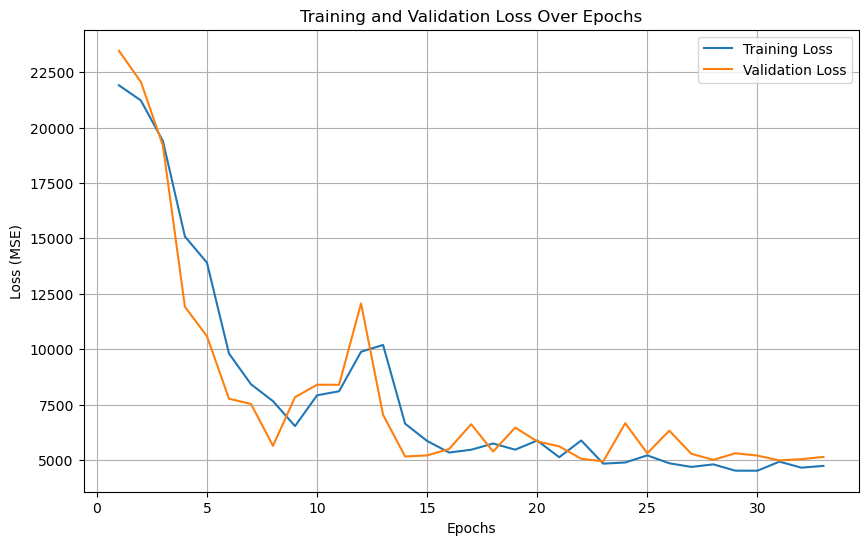

In [70]:
# plotting training and validation loss 
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| Hybrid GNN (Tuned)| OGB smiles2graph + RDKit descriptors | 0.159 | 0.234 | 0.965 | Best   |
| Hybrid GNN (Untuned) | OGB smiles2graph + RDKit descriptors | 0.223 | 0.308 | 0.939 | 2nd best|

# Step 11: Evaluate on test-dev and save the predictions to csv

In [ ]:
# map subset back to original dataset indices
test_indices = split_idx['test-dev']
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_ids = [] # store original molecule indices

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="Predicting")):
        batch = batch.to(device)
        pred = model(batch)
        all_preds.append(pred.cpu().numpy())

# stack predictions
all_preds = np.vstack(all_preds)

# match predictions to original indices
submission_df = pd.DataFrame({'mol_index': test_indices,  # original indices
                              'prediction': all_preds.flatten()  # flatten to 1D
                              })

# sort by original molecule ID 
submission_df = submission_df.sort_values('mol_index').reset_index(drop=True)

# save to CSV
submission_df.to_csv("hybridgnn_testdev_predictions_with_ids.csv", index=False)
print("Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'")

Predicting: 100%|██████████| 2298/2298 [00:22<00:00, 102.89it/s]


Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'


# Conclusions

## Model Performance Summary

All baseline models were initially trained and evaluated on a 5,000 molecule subset of the full dataset. Below is a comparison of results across different featurization strategies and model types:

### 2D Baseline Models

| Model Type    | Featurization      | MAE   | RMSE  | R²    | Notes                                 |
| ------------- | ------------------ | ----- | ----- | ----- | ------------------------------------- |
| MLP (Tuned)   | RDKit Fingerprints | 0.426 | 0.574 | 0.798 | Strong performance across all metrics |
| KRR (Tuned)   | RDKit Fingerprints | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R²       |
| RF (Tuned)    | RDKit Fingerprints | 0.423 | 0.583 | 0.791 | Best MAE, very competitive overall    |
| MLP (Tuned)   | Coulomb Matrix     | 0.636 | 0.819 | 0.588 | Significantly weaker performance      |
| MLP (Untuned) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Solid untuned baseline                |
| KRR (Untuned) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Notable drop from tuned version       |
| RF (Untuned)  | RDKit Fingerprints | 0.426 | 0.587 | 0.788 | Surprisingly close to tuned RF        |
| MLP (Untuned) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Consistently underperforms            |

### Graph Neural Network Models (ChemML)

| Model Type    | Featurization               | MAE   | RMSE  | R²    | Notes                                |
| ------------- | --------------------------- | ----- | ----- | ----- | ------------------------------------ |
| GNN (Tuned)   | `tensorise_molecules` Graph | 0.302 | 0.411 | 0.900 | Best results from ChemML experiments |
| GNN (Untuned) | `tensorise_molecules` Graph | 0.400 | 0.519 | 0.841 | Strong but less optimized            |

### Final Hybrid GNN Model Trained on Full Dataset (OGB-Compatible)

| Model Type           | Featurization                          | MAE   | RMSE  | R²    | Notes                              |
| -------------------- | -------------------------------------- | ----- | ----- | ----- | ---------------------------------- |
| Hybrid GNN (Tuned)   | OGB `smiles2graph` + RDKit descriptors | 0.159 | 0.234 | 0.965 | State-of-the-art level performance |
| Hybrid GNN (Untuned) | OGB `smiles2graph` + RDKit descriptors | 0.223 | 0.308 | 0.939 | Still very strong pre-tuning       |

---

## Model Error Analysis

I performed qualitative evaluation by comparing predicted vs. true HOMO–LUMO gaps for both randomly selected and poorly predicted molecules. The worst performing molecules often showed rare or complex structures likely underrepresented in the training set. This highlights the importance of structural diversity and potentially more expressive 3D information to improve generalization.

## Next Steps: Integrating 3D Molecular Information

To push performance even further and overcome limitations of 2D graphs and hand crafted descriptors, my next step will involve:

* Using **3D molecular geometries** 
* Incorporating **interatomic distances**, angles, and **spatial encoding** (SchNet, DimeNet, or SE(3)-equivariant models)
* Comparing results against the current best MAE (\~0.159)

This direction aligns with trends in molecular property prediction where 3D aware models often outperform purely 2D approaches, especially for quantum properties like HOMO–LUMO gaps.
